In [2]:
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize
from nltk.tokenize import RegexpTokenizer, TreebankWordTokenizer
import spacy
import matplotlib.pyplot as plt
nltk.download("stopwords")
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
%matplotlib inline

nlp = spacy.load('en_core_web_sm')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ravan\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ravan\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\ravan\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [2]:
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, AdaBoostClassifier
from sklearn.pipeline import make_pipeline
from imblearn.pipeline import make_pipeline as make_pipeline_imb
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from imblearn.ensemble import BalancedRandomForestClassifier
from imblearn.under_sampling  import  RandomUnderSampler
from imblearn.over_sampling import ADASYN, SMOTE
from imblearn.metrics import classification_report_imbalanced
from imblearn.pipeline import make_pipeline, Pipeline

from sklearn.metrics import accuracy_score, precision_score, recall_score, mean_absolute_error, median_absolute_error
from sklearn.model_selection import cross_val_score

from collections import Counter

# Preprocessing Text

## 1. Tokenize reviews into words remove stop words

In [9]:
def tokenize_sentences(x, tokenizer, stop_words):
    return [word.lower() for word in tokenizer.tokenize(x) if word.lower() not in stop_words and len(word) >=2]

raw_data = pd.read_csv("../amazon-product-ratings/product_rating.csv", index_col=0).dropna()
stop_words = set(stopwords.words('english')) 

# tokenize documents into sentences
my_tokenizer = RegexpTokenizer('\w+')
# data['reviews'] = data['reviews'].apply(lambda x: tokenize_sentences(x, my_tokenizer, stop_words))

In [4]:
def cleanup_text(docs, logging=False):
    texts = []
    counter = 1
    for doc in docs:
        if counter % 1000 == 0 and logging:
            print("Processed %d out of %d documents." % (counter, len(docs)))
        counter += 1
        doc = nlp(doc, disable=['parser', 'ner', 'tagger'])
        tokens = [tok.lemma_.lower().strip() for tok in doc if tok.lemma_ != '-PRON-' and not tok.is_punct]
        tokens = [tok for tok in tokens if tok not in stop_words]
        tokens = ' '.join(tokens)
        texts.append(tokens)
    return pd.Series(texts)

def cleanup_text(doc):
    doc = nlp(doc, disable=['parser', 'ner', 'tagger', 'textcat'])
    tokens = [tok.lemma_.lower().strip() for tok in doc if tok.lemma_ != '-PRON-' and not tok.is_punct]
    tokens = [tok for tok in tokens if tok not in stop_words]
    return tokens

In [232]:
split_reviews = raw_data['reviews'].iloc[:1000].apply(cleanup_text)

Wall time: 2.95 s


In [353]:
raw_data['reviews'] = raw_data['reviews'].apply(lambda x: re.sub('[\>\<=_`\^\(\)&!@:#$;,\.\+-/\d]', '', x))

In [354]:

split_reviews = []
for doc in nlp.pipe(raw_data['reviews'].tolist(), disable=['parser', 'ner', 'tagger', 'textcat']):
    tokens = [tok.lemma_.lower().strip() for tok in doc if tok.lemma_ != '-PRON-' and (not tok.is_punct) and (not tok.is_space) and (not tok.like_num)]
    tokens = [tok for tok in tokens if tok not in stop_words]
    split_reviews.append(tokens)


In [355]:
raw_data['split_reviews'] = split_reviews

## 2. Train a Word2Vec model

In [14]:
from gensim.models.word2vec import Word2Vec
from gensim.models.doc2vec import TaggedDocument
from sklearn.model_selection import train_test_split
from gensim.summarization.summarizer import summarize
from gensim.summarization import keywords

In [24]:
documents = raw_data['split_reviews'].tolist()
train_corpus, test_corpus, y_train, y_test = train_test_split(raw_data['split_reviews'], raw_data['ratings'].values, test_size=0.33, random_state=42)
# test_corpus = [x.words for x in test_corpus] # we only want words for test corpus

In [445]:
ratings_one_num = (raw_data['ratings'] == 1).sum()

4701

In [108]:
n_dim = 100
epochs = 10
model = Word2Vec(documents, size=n_dim, min_count=2, workers=8)
model.train(documents, total_examples=len(documents), epochs=epochs)

(69246131, 79723620)

In [521]:
sentimental_words = neg_words + pos_words

In [5]:
def buildWordVector(tokens, size):
    vec = np.zeros(size).reshape((1, size))
    count = 0.
    for word in tokens:
        try:
            vec += model[word].reshape((1, size)) * 1
            count += 1
        except KeyError: # handling the case where the token is not in the corpus. useful for testing.
            continue
    if count != 0:
        vec /= count
    return vec

# Training with different models

In [3]:
raw_data = pd.read_pickle('reviews.pkl')

In [505]:
rating_one_index = raw_data[raw_data['ratings'] == 1].index
num_to_sample = len(rating_one_index)

sample_indices = []
for rating in range(1, 6):
    indices = raw_data[raw_data['ratings'] == rating].index
    sample_indices.append(np.random.choice(indices, num_to_sample))
sample_indices = np.array(sample_indices)
sample_indices = sample_indices.reshape((sample_indices.shape[0] * sample_indices.shape[1], ))

In [512]:
sample_documents = raw_data.loc[sample_indices]['split_reviews'].tolist()

In [5]:
documents = raw_data['split_reviews'].tolist()
vectorizer = TfidfVectorizer(analyzer=lambda x: x, min_df=10)
matrix = vectorizer.fit_transform(documents)
tfidf = dict(zip(vectorizer.get_feature_names(), vectorizer.idf_))

In [6]:
from gensim.summarization.summarizer import summarize
from gensim.summarization import keywords

C:\Anaconda3\lib\site-packages\gensim\utils.py:1209: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [607]:
w2v_features = np.concatenate([buildWordVector(tokens, n_dim) for tokens in documents])

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


In [608]:
w2v_features = pd.DataFrame(w2v_features)

In [609]:
raw_data = raw_data.drop(w2v_feature_col, axis=1)

In [610]:
raw_data = raw_data.reset_index().drop('index', axis=1)
raw_data = pd.concat([raw_data, w2v_features],axis=1)

# 3 Train a simple model

In [114]:
train_tags = [x.tags for x in train_corpus]
test_tags = [x.tags for x in test_corpus]

X_train = model[train_tags]
X_test = model[test_tags]

In [115]:
sampler = RandomUnderSampler()
X_train_res, y_train_res = sampler.fit_resample(X_train, y)
clf = AdaBoostClassifier()
clf.fit(X_train_res, y_train_res)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=None)

In [124]:
sampler = RandomUnderSampler()
X_train_res, y_train_res = sampler.fit_resample(X_train, y)
clf = AdaBoostClassifier()
clf.fit(X_train_res, y_train_res)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=None)

In [125]:
print(classification_report_imbalanced(clf.predict(X_test), y_test))

                   pre       rec       spe        f1       geo       iba       sup

        1.0       0.33      0.05      0.98      0.09      0.23      0.05      9625
        2.0       0.19      0.07      0.97      0.10      0.26      0.06      5790
        3.0       0.28      0.16      0.91      0.20      0.38      0.13      9559
        4.0       0.17      0.28      0.78      0.21      0.47      0.21      7502
        5.0       0.50      0.75      0.48      0.60      0.60      0.37     22801

avg / total       0.36      0.39      0.73      0.34      0.44      0.22     55277



In [585]:
print([tfidf[word] for word in documents[0]])
print(documents[0])

[2.106728176195469, 3.801681369215963, 3.2644383320221495, 4.874695580839653, 3.0019480753660073, 5.539558047561015, 3.0019480753660073, 5.024756275415386]
['like', 'item', 'price', 'granddaughter', 'want', 'mark', 'want', 'letter']


# Feature Extraction

In [418]:
with open("../amazon-product-ratings/positive-words.txt") as f1:
    pos_words = f1.read().split('\n')
pos_words = pos_words[:-1]

with open("../amazon-product-ratings/negative-words.txt") as f2:
    neg_words = f2.read().split('\n')
neg_words = neg_words[:-1]

pos_words = pd.Series(pos_words).str.lower().tolist()
neg_words = pd.Series(neg_words).str.lower().tolist()

# Using Spark count sentimental words

In [57]:
raw_data['reviews'] = raw_data['reviews'].str.lower()
# raw_data['split_reviews'] = raw_data['reviews'].apply(lambda x: my_tokenizer.tokenize(x))

In [58]:
from operator import add
rdd = sc.parallelize(raw_data['reviews'].dropna().values)
pos_words_count = rdd.map(lambda x: sum([1 for word in x.split(' ') if word in pos_words])).collect()
neg_words_count = rdd.map(lambda x: sum([1 for word in x.split(' ') if word in neg_words])).collect()

raw_data['pos_words_count'] = pos_words_count
raw_data['neg_words_count'] = neg_words_count
raw_data['review_length'] = raw_data['reviews'].apply(lambda x: len(my_tokenizer.tokenize(x)))

# Some Visulization
## We discvoer that in the reviews, sentiment words are highly correlated with the ratings

more negative words, means lower the ratings
more positive words, mean higher the ratings

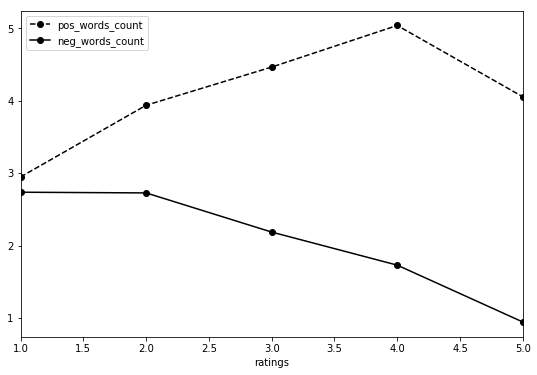

In [478]:
plt.tight_layout()
raw_data.groupby('ratings').agg({'pos_words_count': 'mean',
                                'neg_words_count': 'mean'}).plot(figsize=(9, 6), style=['--', '-'], color=['black', 'black'], marker='o')

# negation in the sentences should be taken care of!

"My little man got this for his first birthday along with the base. Now at 18 months he drags it back into the family room if we move it.  He loves his pony and will climb on and off all on his own whenever the mood strikes him. The base does make it very stable for younger kids and has not once tipped over. I have only had to add more air once to get the pressure back up, **not ** bad considering he has used it daily for half a year. We have the green with blue saddle and colors online are very true (assuming your monitor is).Rody has survived many a chomp on the ears and tail during rough teething times, but between us catching our little culprit and the thickness of the rubber it has not sustained any damage. Rody continues to look overjoyed to see our Son regardless of the abuse and I'm sure will be part of the family for a long time."

In [205]:
[word for word in my_tokenizer.tokenize(raw_data.loc[8781]['reviews']) if word in neg_words]

['drags', 'bad', 'rough', 'culprit', 'damage', 'abuse']

# Reviews length

It's reasonable to say, people tend to give longer reviews when they are angry or really hate the product, and tend to give shorter reviews when they are satisifed with the product

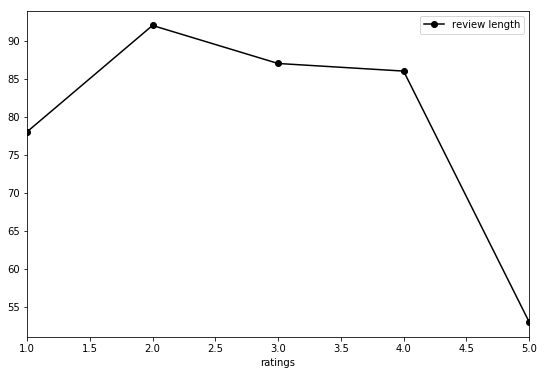

In [479]:
import seaborn
raw_data.groupby('ratings').review_length.median().plot(figsize=(9, 6), color='black', marker='o')
plt.legend(["review length"])

In [430]:
documents

1.9122393694260618

# Train a simple model based on sentimental words count

We decided to use mean absolute error as the metric to evaluate our model

$score = \sum_{i=1}^{n}|\hat{y_i} - y_i| $

Right now, our simple model, on average, predicts one rating away from the true rating

In [661]:
w2v_feature_col = list(range(100))
features_data = raw_data[['ratings'] + w2v_feature_col]
X = features_data[w2v_feature_col]
y = features_data['ratings']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.33, stratify=y)

sampler = SMOTE(k_neighbors=5)
X_train_res, y_train_res = sampler.fit_resample(X_train, y_train)
# clf = AdaBoostClassifier(n_estimators=100)
# clf.fit(X_train_res, y_train_res)

# mean_absolute_error(clf.predict(X_val), y_val)

In [488]:
print(classification_report_imbalanced(y_val, clf.predict(X_val)))

                   pre       rec       spe        f1       geo       iba       sup

        1.0       0.57      0.09      0.99      0.15      0.29      0.08     10341
        2.0       0.13      0.08      0.97      0.10      0.27      0.07      3526
        3.0       0.11      0.13      0.91      0.12      0.34      0.10      4768
        4.0       0.29      0.28      0.79      0.29      0.47      0.21     12563
        5.0       0.53      0.75      0.49      0.62      0.61      0.38     24079

avg / total       0.42      0.42      0.72      0.38      0.47      0.24     55277



In [ ]:
from sklearn.svm import SVC
features_data = raw_data[['ratings'] + ['pos_words_count', 'neg_words_count', 'review_length']]
X = features_data[['pos_words_count', 'neg_words_count', 'review_length']]
y = features_data['ratings']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.33, stratify=y)

sampler = SMOTE(k_neighbors=5)
X_train_res, y_train_res = sampler.fit_resample(X_train, y_train)
# clf = AdaBoostClassifier(n_estimators=100)
clf = SVC(C=1.0)
clf.fit(X_train_res, y_train_res)

mean_absolute_error(clf.predict(X_val), y_val)

C:\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


In [70]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.callbacks import EarlyStopping

w2v_feature_col = list(range(100))
features_data = raw_data[['ratings'] + w2v_feature_col]
X = features_data[w2v_feature_col]
y = features_data['ratings']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.33, stratify=y)

sampler = SMOTE(k_neighbors=5)
X_train_res, y_train_res = sampler.fit_resample(X_train, y_train)
y_train_nn_res = pd.get_dummies(y_train_res).astype(np.int32)

nn = Sequential()
nn.add(Dense(16, activation='relu', input_dim=100))
nn.add(Dense(64, activation='relu'))
nn.add(Dense(32, activation='relu'))
nn.add(Dense(5, activation='softmax'))
nn.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['mae'])
callbacks = [EarlyStopping(monitor='loss', patience=1)]

nn.fit(X_train_res, y_train_nn_res, epochs=10, batch_size=100, callbacks=callbacks)

Epoch 1/10
344165/344165 [==============================] - ETA: 21:06 - loss: 1.6469 - mean_absolute_error: 0.31 - ETA: 27s - loss: 1.5011 - mean_absolute_error: 0.3022 - ETA: 15s - loss: 1.4319 - mean_absolute_error: 0.29 - ETA: 11s - loss: 1.3885 - mean_absolute_error: 0.28 - ETA: 9s - loss: 1.3558 - mean_absolute_error: 0.2785 - ETA: 7s - loss: 1.3305 - mean_absolute_error: 0.274 - ETA: 6s - loss: 1.3122 - mean_absolute_error: 0.271 - ETA: 6s - loss: 1.2988 - mean_absolute_error: 0.268 - ETA: 5s - loss: 1.2867 - mean_absolute_error: 0.266 - ETA: 5s - loss: 1.2768 - mean_absolute_error: 0.265 - ETA: 5s - loss: 1.2687 - mean_absolute_error: 0.263 - ETA: 4s - loss: 1.2625 - mean_absolute_error: 0.262 - ETA: 4s - loss: 1.2543 - mean_absolute_error: 0.261 - ETA: 4s - loss: 1.2492 - mean_absolute_error: 0.260 - ETA: 4s - loss: 1.2445 - mean_absolute_error: 0.259 - ETA: 3s - loss: 1.2400 - mean_absolute_error: 0.258 - ETA: 3s - loss: 1.2356 - mean_absolute_error: 0.258 - ETA: 3s - loss: 1

344165/344165 [==============================] - ETA: 37s - loss: 0.8910 - mean_absolute_error: 0.20 - ETA: 3s - loss: 1.0371 - mean_absolute_error: 0.2214 - ETA: 2s - loss: 1.0342 - mean_absolute_error: 0.220 - ETA: 2s - loss: 1.0354 - mean_absolute_error: 0.220 - ETA: 2s - loss: 1.0350 - mean_absolute_error: 0.221 - ETA: 2s - loss: 1.0367 - mean_absolute_error: 0.221 - ETA: 2s - loss: 1.0367 - mean_absolute_error: 0.221 - ETA: 2s - loss: 1.0372 - mean_absolute_error: 0.221 - ETA: 2s - loss: 1.0412 - mean_absolute_error: 0.222 - ETA: 2s - loss: 1.0415 - mean_absolute_error: 0.222 - ETA: 2s - loss: 1.0399 - mean_absolute_error: 0.222 - ETA: 2s - loss: 1.0411 - mean_absolute_error: 0.222 - ETA: 2s - loss: 1.0408 - mean_absolute_error: 0.222 - ETA: 2s - loss: 1.0423 - mean_absolute_error: 0.222 - ETA: 2s - loss: 1.0419 - mean_absolute_error: 0.222 - ETA: 2s - loss: 1.0426 - mean_absolute_error: 0.222 - ETA: 2s - loss: 1.0417 - mean_absolute_error: 0.222 - ETA: 2s - loss: 1.0429 - mean_ab

344165/344165 [==============================] - ETA: 30s - loss: 0.9686 - mean_absolute_error: 0.21 - ETA: 3s - loss: 1.0106 - mean_absolute_error: 0.2156 - ETA: 2s - loss: 1.0019 - mean_absolute_error: 0.213 - ETA: 2s - loss: 1.0163 - mean_absolute_error: 0.215 - ETA: 2s - loss: 1.0140 - mean_absolute_error: 0.215 - ETA: 2s - loss: 1.0133 - mean_absolute_error: 0.216 - ETA: 2s - loss: 1.0137 - mean_absolute_error: 0.216 - ETA: 2s - loss: 1.0118 - mean_absolute_error: 0.215 - ETA: 2s - loss: 1.0120 - mean_absolute_error: 0.215 - ETA: 2s - loss: 1.0108 - mean_absolute_error: 0.215 - ETA: 2s - loss: 1.0111 - mean_absolute_error: 0.215 - ETA: 2s - loss: 1.0111 - mean_absolute_error: 0.215 - ETA: 2s - loss: 1.0112 - mean_absolute_error: 0.215 - ETA: 2s - loss: 1.0116 - mean_absolute_error: 0.215 - ETA: 2s - loss: 1.0111 - mean_absolute_error: 0.215 - ETA: 2s - loss: 1.0106 - mean_absolute_error: 0.215 - ETA: 2s - loss: 1.0111 - mean_absolute_error: 0.215 - ETA: 1s - loss: 1.0117 - mean_ab

In [71]:
y_pred_nn = nn.predict_classes(X_val) + 1
mean_absolute_error(y_pred_nn, y_val)

0.6581580042332253

$ h_1 =  relu(W_1x)$  
$h_2 = relu(W_2 h_1)$  
$y = softmax(W_2 h_2)$

In [18]:
from keras.optimizers import adam
nn = Sequential()
nn.add(Dense(16, activation='relu', input_dim=100))
nn.add(Dense(64, activation='relu'))
nn.add(Dense(32, activation='relu'))
nn.add(Dense(5, activation='softmax'))

optimizer = adam(lr=0.0005)
nn.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['mae'])
callbacks = [EarlyStopping(monitor='loss', patience=2)]

nn.fit(X_train_res[:500, :], y_train_nn_res.iloc[:500], epochs=20, batch_size=10,callbacks=callbacks)

Epoch 1/20
500/500 [==============================] - ETA: 12s - loss: 1.8919 - mean_absolute_error: 0.30 - 0s 584us/step - loss: 1.3626 - mean_absolute_error: 0.2562
Epoch 2/20
500/500 [==============================] - ETA: 0s - loss: 1.2810 - mean_absolute_error: 0.217 - 0s 74us/step - loss: 1.0589 - mean_absolute_error: 0.2171
Epoch 3/20
500/500 [==============================] - ETA: 0s - loss: 0.9835 - mean_absolute_error: 0.214 - 0s 74us/step - loss: 0.9998 - mean_absolute_error: 0.2051
Epoch 4/20
500/500 [==============================] - ETA: 0s - loss: 1.0682 - mean_absolute_error: 0.236 - 0s 74us/step - loss: 0.9498 - mean_absolute_error: 0.2008
Epoch 5/20
500/500 [==============================] - ETA: 0s - loss: 0.9160 - mean_absolute_error: 0.200 - 0s 74us/step - loss: 0.9126 - mean_absolute_error: 0.1939
Epoch 6/20
500/500 [==============================] - ETA: 0s - loss: 0.6554 - mean_absolute_error: 0.153 - 0s 76us/step - loss: 0.8761 - mean_absolute_error: 0.1857
Epo

In [19]:
y_pred_nn = nn.predict_classes(X_val) + 1
mean_absolute_error(y_pred_nn, y_val)

0.6111221665430469

In [69]:
print(classification_report_imbalanced(y_val, y_pred_nn))

                   pre       rec       spe        f1       geo       iba       sup

        1.0       0.19      0.21      0.97      0.20      0.46      0.19      1551
        2.0       0.19      0.13      0.98      0.16      0.36      0.12      2076
        3.0       0.30      0.29      0.93      0.30      0.52      0.25      5395
        4.0       0.36      0.35      0.82      0.36      0.54      0.27     12352
        5.0       0.76      0.78      0.61      0.77      0.69      0.48     33903

avg / total       0.59      0.60      0.71      0.59      0.62      0.39     55277



In [591]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.callbacks import EarlyStopping

w2v_feature_col = list(range(100))
simple_feature_col = ['pos_words_count', 'neg_words_count', 'review_length']
y_col = ['ratings']
features_data = raw_data[simple_feature_col + y_col]
X = features_data[simple_feature_col]
y = features_data['ratings']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.33, stratify=y)

sampler = SMOTE(k_neighbors=5)
X_train_res, y_train_res = sampler.fit_resample(X_train, y_train)
y_train_nn_res = pd.get_dummies(y_train_res).astype(np.int32)


nn = Sequential()
nn.add(Dense(16, activation='relu', input_dim=3))
nn.add(Dense(32, activation='relu'))
nn.add(Dense(5, activation='softmax'))
nn.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['mae'])
callbacks = [EarlyStopping(monitor='loss', patience=1)]

nn.fit(X_train_res, y_train_nn_res, epochs=10, batch_size=100, callbacks=callbacks)

Epoch 1/10
344165/344165 [==============================] - ETA: 50:53 - loss: 6.2571 - mean_absolute_error: 0.32 - ETA: 1:06 - loss: 2.7771 - mean_absolute_error: 0.3200 - ETA: 37s - loss: 2.3174 - mean_absolute_error: 0.319 - ETA: 25s - loss: 2.1165 - mean_absolute_error: 0.31 - ETA: 19s - loss: 2.0179 - mean_absolute_error: 0.31 - ETA: 16s - loss: 1.9612 - mean_absolute_error: 0.31 - ETA: 14s - loss: 1.9217 - mean_absolute_error: 0.31 - ETA: 12s - loss: 1.8950 - mean_absolute_error: 0.31 - ETA: 11s - loss: 1.8721 - mean_absolute_error: 0.31 - ETA: 10s - loss: 1.8483 - mean_absolute_error: 0.31 - ETA: 9s - loss: 1.8328 - mean_absolute_error: 0.3159 - ETA: 8s - loss: 1.8191 - mean_absolute_error: 0.315 - ETA: 7s - loss: 1.8052 - mean_absolute_error: 0.315 - ETA: 7s - loss: 1.7952 - mean_absolute_error: 0.315 - ETA: 7s - loss: 1.7850 - mean_absolute_error: 0.314 - ETA: 6s - loss: 1.7750 - mean_absolute_error: 0.314 - ETA: 6s - loss: 1.7657 - mean_absolute_error: 0.314 - ETA: 6s - loss:

344165/344165 [==============================] - ETA: 37s - loss: 1.5321 - mean_absolute_error: 0.30 - ETA: 4s - loss: 1.4730 - mean_absolute_error: 0.2959 - ETA: 3s - loss: 1.4801 - mean_absolute_error: 0.297 - ETA: 3s - loss: 1.4823 - mean_absolute_error: 0.297 - ETA: 3s - loss: 1.4797 - mean_absolute_error: 0.297 - ETA: 3s - loss: 1.4784 - mean_absolute_error: 0.297 - ETA: 3s - loss: 1.4786 - mean_absolute_error: 0.297 - ETA: 3s - loss: 1.4795 - mean_absolute_error: 0.297 - ETA: 3s - loss: 1.4783 - mean_absolute_error: 0.297 - ETA: 3s - loss: 1.4780 - mean_absolute_error: 0.296 - ETA: 2s - loss: 1.4780 - mean_absolute_error: 0.296 - ETA: 2s - loss: 1.4780 - mean_absolute_error: 0.296 - ETA: 2s - loss: 1.4780 - mean_absolute_error: 0.296 - ETA: 2s - loss: 1.4783 - mean_absolute_error: 0.297 - ETA: 2s - loss: 1.4784 - mean_absolute_error: 0.297 - ETA: 2s - loss: 1.4784 - mean_absolute_error: 0.297 - ETA: 2s - loss: 1.4784 - mean_absolute_error: 0.297 - ETA: 2s - loss: 1.4783 - mean_ab

344165/344165 [==============================] - ETA: 31s - loss: 1.5359 - mean_absolute_error: 0.30 - ETA: 4s - loss: 1.4738 - mean_absolute_error: 0.2982 - ETA: 3s - loss: 1.4629 - mean_absolute_error: 0.296 - ETA: 3s - loss: 1.4645 - mean_absolute_error: 0.297 - ETA: 3s - loss: 1.4672 - mean_absolute_error: 0.297 - ETA: 3s - loss: 1.4675 - mean_absolute_error: 0.297 - ETA: 3s - loss: 1.4678 - mean_absolute_error: 0.297 - ETA: 3s - loss: 1.4670 - mean_absolute_error: 0.297 - ETA: 3s - loss: 1.4666 - mean_absolute_error: 0.297 - ETA: 3s - loss: 1.4675 - mean_absolute_error: 0.297 - ETA: 3s - loss: 1.4670 - mean_absolute_error: 0.297 - ETA: 3s - loss: 1.4660 - mean_absolute_error: 0.296 - ETA: 3s - loss: 1.4656 - mean_absolute_error: 0.296 - ETA: 3s - loss: 1.4663 - mean_absolute_error: 0.296 - ETA: 3s - loss: 1.4659 - mean_absolute_error: 0.296 - ETA: 2s - loss: 1.4655 - mean_absolute_error: 0.296 - ETA: 2s - loss: 1.4651 - mean_absolute_error: 0.296 - ETA: 2s - loss: 1.4653 - mean_ab

# LSTM and CNN

In [9]:
from keras.layers.embeddings import Embedding
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Conv1D, Dropout, MaxPooling1D, LSTM, Flatten, Dense, Bidirectional
from keras.models import Sequential
from keras.callbacks import EarlyStopping

C:\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [12]:
documents = raw_data['split_reviews'].tolist()
vectorizer = TfidfVectorizer(analyzer=lambda x: x, min_df=10)
matrix = vectorizer.fit_transform(documents)
tfidf = dict(zip(vectorizer.get_feature_names(), vectorizer.idf_))

In [25]:

vocab_size = len(tfidf) + 1

keras_tokenizer = Tokenizer(num_words=vocab_size)
keras_tokenizer.fit_on_texts(raw_data['split_reviews'])


seq = keras_tokenizer.texts_to_sequences(raw_data['split_reviews'])
new_data = pad_sequences(seq, maxlen=50)

y = raw_data['ratings']
X_train, X_val, y_train, y_val = train_test_split(new_data, y, test_size=0.33, stratify=y)
sampler = SMOTE(k_neighbors=5)
X_train_res, y_train_res = sampler.fit_resample(X_train, y_train)
y_train_nn_res = pd.get_dummies(y_train_res).astype(np.int32)

In [119]:
model_conv = Sequential()
model_conv.add(Embedding(vocab_size, 100, input_length=50))
model_conv.add(Dropout(0.2))
model_conv.add(Conv1D(64, 5, activation='relu'))
model_conv.add(MaxPooling1D(pool_size=4))
model_conv.add(LSTM(100))
model_conv.add(Dense(5, activation='softmax'))
model_conv.compile(loss='categorical_crossentropy', 
                   optimizer='adam',    
                   metrics=['mae'])
model_conv.fit(X_train_res, y_train_nn_res, epochs=10, batch_size=100, callbacks=callbacks)

y_pred_nn = model_conv.predict_classes(X_val) + 1
mae = mean_absolute_error(y_pred_nn, y_val)

Epoch 1/10


 17100/344165 [>.............................] - ETA: 1:23:18 - loss: 1.6095 - mean_absolute_error: 0.32 - ETA: 43:12 - loss: 1.6098 - mean_absolute_error: 0.3200 - ETA: 29:53 - loss: 1.6103 - mean_absolute_error: 0.32 - ETA: 23:12 - loss: 1.6102 - mean_absolute_error: 0.32 - ETA: 19:11 - loss: 1.6132 - mean_absolute_error: 0.32 - ETA: 16:30 - loss: 1.6131 - mean_absolute_error: 0.32 - ETA: 14:36 - loss: 1.6117 - mean_absolute_error: 0.32 - ETA: 13:10 - loss: 1.6110 - mean_absolute_error: 0.32 - ETA: 12:05 - loss: 1.6102 - mean_absolute_error: 0.32 - ETA: 11:10 - loss: 1.6107 - mean_absolute_error: 0.32 - ETA: 10:26 - loss: 1.6106 - mean_absolute_error: 0.32 - ETA: 9:16 - loss: 1.6100 - mean_absolute_error: 0.3200 - ETA: 8:52 - loss: 1.6090 - mean_absolute_error: 0.319 - ETA: 8:28 - loss: 1.6081 - mean_absolute_error: 0.319 - ETA: 7:47 - loss: 1.6070 - mean_absolute_error: 0.319 - ETA: 7:30 - loss: 1.6066 - mean_absolute_error: 0.319 - ETA: 7:17 - loss: 1.6061 - mean_absolute_error: 0.

 72800/344165 [=====>........................] - ETA: 2:36 - loss: 1.4657 - mean_absolute_error: 0.296 - ETA: 2:36 - loss: 1.4656 - mean_absolute_error: 0.296 - ETA: 2:36 - loss: 1.4651 - mean_absolute_error: 0.296 - ETA: 2:36 - loss: 1.4648 - mean_absolute_error: 0.296 - ETA: 2:36 - loss: 1.4648 - mean_absolute_error: 0.296 - ETA: 2:36 - loss: 1.4643 - mean_absolute_error: 0.296 - ETA: 2:36 - loss: 1.4641 - mean_absolute_error: 0.296 - ETA: 2:36 - loss: 1.4638 - mean_absolute_error: 0.296 - ETA: 2:36 - loss: 1.4636 - mean_absolute_error: 0.296 - ETA: 2:35 - loss: 1.4635 - mean_absolute_error: 0.296 - ETA: 2:35 - loss: 1.4632 - mean_absolute_error: 0.296 - ETA: 2:35 - loss: 1.4629 - mean_absolute_error: 0.296 - ETA: 2:35 - loss: 1.4626 - mean_absolute_error: 0.296 - ETA: 2:35 - loss: 1.4623 - mean_absolute_error: 0.296 - ETA: 2:35 - loss: 1.4620 - mean_absolute_error: 0.296 - ETA: 2:35 - loss: 1.4617 - mean_absolute_error: 0.296 - ETA: 2:34 - loss: 1.4614 - mean_absolute_error: 0.296 -

 90700/344165 [======>.......................] - ETA: 2:26 - loss: 1.4398 - mean_absolute_error: 0.292 - ETA: 2:26 - loss: 1.4399 - mean_absolute_error: 0.292 - ETA: 2:26 - loss: 1.4397 - mean_absolute_error: 0.292 - ETA: 2:26 - loss: 1.4395 - mean_absolute_error: 0.292 - ETA: 2:26 - loss: 1.4393 - mean_absolute_error: 0.292 - ETA: 2:26 - loss: 1.4392 - mean_absolute_error: 0.292 - ETA: 2:26 - loss: 1.4391 - mean_absolute_error: 0.292 - ETA: 2:26 - loss: 1.4389 - mean_absolute_error: 0.292 - ETA: 2:26 - loss: 1.4387 - mean_absolute_error: 0.292 - ETA: 2:26 - loss: 1.4385 - mean_absolute_error: 0.292 - ETA: 2:26 - loss: 1.4384 - mean_absolute_error: 0.292 - ETA: 2:26 - loss: 1.4384 - mean_absolute_error: 0.292 - ETA: 2:26 - loss: 1.4382 - mean_absolute_error: 0.292 - ETA: 2:26 - loss: 1.4381 - mean_absolute_error: 0.292 - ETA: 2:26 - loss: 1.4381 - mean_absolute_error: 0.292 - ETA: 2:26 - loss: 1.4379 - mean_absolute_error: 0.292 - ETA: 2:26 - loss: 1.4377 - mean_absolute_error: 0.292 -

108100/344165 [========>.....................] - ETA: 2:16 - loss: 1.4198 - mean_absolute_error: 0.289 - ETA: 2:16 - loss: 1.4197 - mean_absolute_error: 0.289 - ETA: 2:16 - loss: 1.4195 - mean_absolute_error: 0.289 - ETA: 2:16 - loss: 1.4194 - mean_absolute_error: 0.289 - ETA: 2:16 - loss: 1.4193 - mean_absolute_error: 0.289 - ETA: 2:16 - loss: 1.4192 - mean_absolute_error: 0.289 - ETA: 2:16 - loss: 1.4189 - mean_absolute_error: 0.289 - ETA: 2:16 - loss: 1.4188 - mean_absolute_error: 0.289 - ETA: 2:15 - loss: 1.4188 - mean_absolute_error: 0.289 - ETA: 2:15 - loss: 1.4187 - mean_absolute_error: 0.289 - ETA: 2:15 - loss: 1.4186 - mean_absolute_error: 0.289 - ETA: 2:15 - loss: 1.4184 - mean_absolute_error: 0.289 - ETA: 2:15 - loss: 1.4182 - mean_absolute_error: 0.289 - ETA: 2:15 - loss: 1.4181 - mean_absolute_error: 0.289 - ETA: 2:15 - loss: 1.4181 - mean_absolute_error: 0.289 - ETA: 2:15 - loss: 1.4180 - mean_absolute_error: 0.289 - ETA: 2:15 - loss: 1.4180 - mean_absolute_error: 0.289 -

129900/344165 [==========>...................] - ETA: 2:06 - loss: 1.4052 - mean_absolute_error: 0.287 - ETA: 2:06 - loss: 1.4052 - mean_absolute_error: 0.287 - ETA: 2:06 - loss: 1.4051 - mean_absolute_error: 0.287 - ETA: 2:06 - loss: 1.4051 - mean_absolute_error: 0.287 - ETA: 2:06 - loss: 1.4050 - mean_absolute_error: 0.287 - ETA: 2:06 - loss: 1.4049 - mean_absolute_error: 0.287 - ETA: 2:06 - loss: 1.4049 - mean_absolute_error: 0.287 - ETA: 2:05 - loss: 1.4048 - mean_absolute_error: 0.287 - ETA: 2:05 - loss: 1.4047 - mean_absolute_error: 0.287 - ETA: 2:05 - loss: 1.4046 - mean_absolute_error: 0.287 - ETA: 2:05 - loss: 1.4046 - mean_absolute_error: 0.287 - ETA: 2:05 - loss: 1.4045 - mean_absolute_error: 0.287 - ETA: 2:05 - loss: 1.4044 - mean_absolute_error: 0.287 - ETA: 2:05 - loss: 1.4042 - mean_absolute_error: 0.287 - ETA: 2:05 - loss: 1.4042 - mean_absolute_error: 0.287 - ETA: 2:05 - loss: 1.4040 - mean_absolute_error: 0.287 - ETA: 2:05 - loss: 1.4040 - mean_absolute_error: 0.287 -

148600/344165 [===========>..................] - ETA: 1:53 - loss: 1.3919 - mean_absolute_error: 0.285 - ETA: 1:52 - loss: 1.3918 - mean_absolute_error: 0.285 - ETA: 1:52 - loss: 1.3917 - mean_absolute_error: 0.285 - ETA: 1:52 - loss: 1.3917 - mean_absolute_error: 0.285 - ETA: 1:52 - loss: 1.3917 - mean_absolute_error: 0.285 - ETA: 1:52 - loss: 1.3916 - mean_absolute_error: 0.285 - ETA: 1:52 - loss: 1.3916 - mean_absolute_error: 0.285 - ETA: 1:52 - loss: 1.3914 - mean_absolute_error: 0.285 - ETA: 1:52 - loss: 1.3913 - mean_absolute_error: 0.285 - ETA: 1:52 - loss: 1.3913 - mean_absolute_error: 0.285 - ETA: 1:52 - loss: 1.3910 - mean_absolute_error: 0.285 - ETA: 1:52 - loss: 1.3911 - mean_absolute_error: 0.285 - ETA: 1:52 - loss: 1.3910 - mean_absolute_error: 0.285 - ETA: 1:52 - loss: 1.3909 - mean_absolute_error: 0.285 - ETA: 1:51 - loss: 1.3909 - mean_absolute_error: 0.285 - ETA: 1:51 - loss: 1.3908 - mean_absolute_error: 0.285 - ETA: 1:51 - loss: 1.3907 - mean_absolute_error: 0.285 -

167500/344165 [=============>................] - ETA: 1:42 - loss: 1.3815 - mean_absolute_error: 0.283 - ETA: 1:42 - loss: 1.3815 - mean_absolute_error: 0.283 - ETA: 1:42 - loss: 1.3813 - mean_absolute_error: 0.283 - ETA: 1:42 - loss: 1.3812 - mean_absolute_error: 0.283 - ETA: 1:42 - loss: 1.3811 - mean_absolute_error: 0.283 - ETA: 1:42 - loss: 1.3811 - mean_absolute_error: 0.283 - ETA: 1:42 - loss: 1.3810 - mean_absolute_error: 0.283 - ETA: 1:42 - loss: 1.3809 - mean_absolute_error: 0.283 - ETA: 1:42 - loss: 1.3809 - mean_absolute_error: 0.283 - ETA: 1:42 - loss: 1.3808 - mean_absolute_error: 0.283 - ETA: 1:41 - loss: 1.3808 - mean_absolute_error: 0.283 - ETA: 1:41 - loss: 1.3808 - mean_absolute_error: 0.283 - ETA: 1:41 - loss: 1.3807 - mean_absolute_error: 0.283 - ETA: 1:41 - loss: 1.3806 - mean_absolute_error: 0.283 - ETA: 1:41 - loss: 1.3804 - mean_absolute_error: 0.283 - ETA: 1:41 - loss: 1.3804 - mean_absolute_error: 0.283 - ETA: 1:41 - loss: 1.3802 - mean_absolute_error: 0.283 -

184900/344165 [===============>..............] - ETA: 1:32 - loss: 1.3730 - mean_absolute_error: 0.282 - ETA: 1:32 - loss: 1.3730 - mean_absolute_error: 0.282 - ETA: 1:32 - loss: 1.3730 - mean_absolute_error: 0.282 - ETA: 1:31 - loss: 1.3730 - mean_absolute_error: 0.282 - ETA: 1:31 - loss: 1.3730 - mean_absolute_error: 0.282 - ETA: 1:31 - loss: 1.3730 - mean_absolute_error: 0.282 - ETA: 1:31 - loss: 1.3729 - mean_absolute_error: 0.282 - ETA: 1:31 - loss: 1.3728 - mean_absolute_error: 0.282 - ETA: 1:31 - loss: 1.3727 - mean_absolute_error: 0.282 - ETA: 1:31 - loss: 1.3727 - mean_absolute_error: 0.282 - ETA: 1:31 - loss: 1.3727 - mean_absolute_error: 0.282 - ETA: 1:31 - loss: 1.3727 - mean_absolute_error: 0.282 - ETA: 1:31 - loss: 1.3726 - mean_absolute_error: 0.282 - ETA: 1:31 - loss: 1.3725 - mean_absolute_error: 0.282 - ETA: 1:31 - loss: 1.3724 - mean_absolute_error: 0.282 - ETA: 1:30 - loss: 1.3724 - mean_absolute_error: 0.282 - ETA: 1:30 - loss: 1.3723 - mean_absolute_error: 0.282 -

200200/344165 [================>.............] - ETA: 1:23 - loss: 1.3664 - mean_absolute_error: 0.281 - ETA: 1:22 - loss: 1.3664 - mean_absolute_error: 0.281 - ETA: 1:22 - loss: 1.3664 - mean_absolute_error: 0.281 - ETA: 1:22 - loss: 1.3664 - mean_absolute_error: 0.281 - ETA: 1:22 - loss: 1.3663 - mean_absolute_error: 0.281 - ETA: 1:22 - loss: 1.3663 - mean_absolute_error: 0.281 - ETA: 1:22 - loss: 1.3663 - mean_absolute_error: 0.281 - ETA: 1:22 - loss: 1.3662 - mean_absolute_error: 0.281 - ETA: 1:22 - loss: 1.3662 - mean_absolute_error: 0.281 - ETA: 1:22 - loss: 1.3661 - mean_absolute_error: 0.281 - ETA: 1:22 - loss: 1.3661 - mean_absolute_error: 0.281 - ETA: 1:22 - loss: 1.3660 - mean_absolute_error: 0.281 - ETA: 1:22 - loss: 1.3660 - mean_absolute_error: 0.281 - ETA: 1:22 - loss: 1.3659 - mean_absolute_error: 0.281 - ETA: 1:22 - loss: 1.3659 - mean_absolute_error: 0.281 - ETA: 1:22 - loss: 1.3659 - mean_absolute_error: 0.281 - ETA: 1:22 - loss: 1.3659 - mean_absolute_error: 0.281 -

215200/344165 [=================>............] - ETA: 1:15 - loss: 1.3615 - mean_absolute_error: 0.280 - ETA: 1:15 - loss: 1.3615 - mean_absolute_error: 0.280 - ETA: 1:15 - loss: 1.3614 - mean_absolute_error: 0.280 - ETA: 1:15 - loss: 1.3613 - mean_absolute_error: 0.280 - ETA: 1:15 - loss: 1.3613 - mean_absolute_error: 0.280 - ETA: 1:15 - loss: 1.3612 - mean_absolute_error: 0.280 - ETA: 1:15 - loss: 1.3612 - mean_absolute_error: 0.280 - ETA: 1:15 - loss: 1.3612 - mean_absolute_error: 0.280 - ETA: 1:15 - loss: 1.3611 - mean_absolute_error: 0.280 - ETA: 1:15 - loss: 1.3611 - mean_absolute_error: 0.280 - ETA: 1:15 - loss: 1.3611 - mean_absolute_error: 0.280 - ETA: 1:14 - loss: 1.3611 - mean_absolute_error: 0.280 - ETA: 1:14 - loss: 1.3610 - mean_absolute_error: 0.280 - ETA: 1:14 - loss: 1.3610 - mean_absolute_error: 0.280 - ETA: 1:14 - loss: 1.3610 - mean_absolute_error: 0.280 - ETA: 1:14 - loss: 1.3609 - mean_absolute_error: 0.280 - ETA: 1:14 - loss: 1.3609 - mean_absolute_error: 0.280 -

235000/344165 [===================>..........] - ETA: 1:07 - loss: 1.3567 - mean_absolute_error: 0.280 - ETA: 1:07 - loss: 1.3567 - mean_absolute_error: 0.280 - ETA: 1:07 - loss: 1.3567 - mean_absolute_error: 0.280 - ETA: 1:07 - loss: 1.3568 - mean_absolute_error: 0.280 - ETA: 1:07 - loss: 1.3567 - mean_absolute_error: 0.280 - ETA: 1:07 - loss: 1.3567 - mean_absolute_error: 0.280 - ETA: 1:07 - loss: 1.3566 - mean_absolute_error: 0.280 - ETA: 1:07 - loss: 1.3565 - mean_absolute_error: 0.280 - ETA: 1:07 - loss: 1.3565 - mean_absolute_error: 0.280 - ETA: 1:07 - loss: 1.3564 - mean_absolute_error: 0.280 - ETA: 1:07 - loss: 1.3564 - mean_absolute_error: 0.280 - ETA: 1:07 - loss: 1.3564 - mean_absolute_error: 0.280 - ETA: 1:07 - loss: 1.3564 - mean_absolute_error: 0.280 - ETA: 1:07 - loss: 1.3563 - mean_absolute_error: 0.280 - ETA: 1:07 - loss: 1.3562 - mean_absolute_error: 0.280 - ETA: 1:07 - loss: 1.3562 - mean_absolute_error: 0.280 - ETA: 1:06 - loss: 1.3562 - mean_absolute_error: 0.280 -

253700/344165 [=====================>........] - ETA: 57s - loss: 1.3509 - mean_absolute_error: 0.27 - ETA: 57s - loss: 1.3509 - mean_absolute_error: 0.27 - ETA: 57s - loss: 1.3508 - mean_absolute_error: 0.27 - ETA: 57s - loss: 1.3508 - mean_absolute_error: 0.27 - ETA: 57s - loss: 1.3507 - mean_absolute_error: 0.27 - ETA: 57s - loss: 1.3507 - mean_absolute_error: 0.27 - ETA: 56s - loss: 1.3507 - mean_absolute_error: 0.27 - ETA: 56s - loss: 1.3506 - mean_absolute_error: 0.27 - ETA: 56s - loss: 1.3506 - mean_absolute_error: 0.27 - ETA: 56s - loss: 1.3506 - mean_absolute_error: 0.27 - ETA: 56s - loss: 1.3505 - mean_absolute_error: 0.27 - ETA: 56s - loss: 1.3505 - mean_absolute_error: 0.27 - ETA: 56s - loss: 1.3505 - mean_absolute_error: 0.27 - ETA: 56s - loss: 1.3504 - mean_absolute_error: 0.27 - ETA: 56s - loss: 1.3504 - mean_absolute_error: 0.27 - ETA: 56s - loss: 1.3503 - mean_absolute_error: 0.27 - ETA: 56s - loss: 1.3503 - mean_absolute_error: 0.27 - ETA: 56s - loss: 1.3502 - mean_ab

271400/344165 [======================>.......] - ETA: 47s - loss: 1.3462 - mean_absolute_error: 0.27 - ETA: 47s - loss: 1.3461 - mean_absolute_error: 0.27 - ETA: 47s - loss: 1.3461 - mean_absolute_error: 0.27 - ETA: 47s - loss: 1.3461 - mean_absolute_error: 0.27 - ETA: 47s - loss: 1.3461 - mean_absolute_error: 0.27 - ETA: 47s - loss: 1.3461 - mean_absolute_error: 0.27 - ETA: 47s - loss: 1.3460 - mean_absolute_error: 0.27 - ETA: 47s - loss: 1.3460 - mean_absolute_error: 0.27 - ETA: 46s - loss: 1.3459 - mean_absolute_error: 0.27 - ETA: 46s - loss: 1.3459 - mean_absolute_error: 0.27 - ETA: 46s - loss: 1.3459 - mean_absolute_error: 0.27 - ETA: 46s - loss: 1.3459 - mean_absolute_error: 0.27 - ETA: 46s - loss: 1.3459 - mean_absolute_error: 0.27 - ETA: 46s - loss: 1.3459 - mean_absolute_error: 0.27 - ETA: 46s - loss: 1.3458 - mean_absolute_error: 0.27 - ETA: 46s - loss: 1.3458 - mean_absolute_error: 0.27 - ETA: 46s - loss: 1.3458 - mean_absolute_error: 0.27 - ETA: 46s - loss: 1.3457 - mean_ab

289800/344165 [========================>.....] - ETA: 38s - loss: 1.3416 - mean_absolute_error: 0.27 - ETA: 38s - loss: 1.3416 - mean_absolute_error: 0.27 - ETA: 37s - loss: 1.3416 - mean_absolute_error: 0.27 - ETA: 37s - loss: 1.3416 - mean_absolute_error: 0.27 - ETA: 37s - loss: 1.3416 - mean_absolute_error: 0.27 - ETA: 37s - loss: 1.3416 - mean_absolute_error: 0.27 - ETA: 37s - loss: 1.3415 - mean_absolute_error: 0.27 - ETA: 37s - loss: 1.3415 - mean_absolute_error: 0.27 - ETA: 37s - loss: 1.3415 - mean_absolute_error: 0.27 - ETA: 37s - loss: 1.3414 - mean_absolute_error: 0.27 - ETA: 37s - loss: 1.3414 - mean_absolute_error: 0.27 - ETA: 37s - loss: 1.3413 - mean_absolute_error: 0.27 - ETA: 37s - loss: 1.3413 - mean_absolute_error: 0.27 - ETA: 37s - loss: 1.3413 - mean_absolute_error: 0.27 - ETA: 37s - loss: 1.3413 - mean_absolute_error: 0.27 - ETA: 37s - loss: 1.3412 - mean_absolute_error: 0.27 - ETA: 37s - loss: 1.3412 - mean_absolute_error: 0.27 - ETA: 36s - loss: 1.3412 - mean_ab

309200/344165 [=========================>....] - ETA: 28s - loss: 1.3374 - mean_absolute_error: 0.27 - ETA: 28s - loss: 1.3374 - mean_absolute_error: 0.27 - ETA: 28s - loss: 1.3374 - mean_absolute_error: 0.27 - ETA: 28s - loss: 1.3374 - mean_absolute_error: 0.27 - ETA: 28s - loss: 1.3374 - mean_absolute_error: 0.27 - ETA: 28s - loss: 1.3373 - mean_absolute_error: 0.27 - ETA: 27s - loss: 1.3373 - mean_absolute_error: 0.27 - ETA: 27s - loss: 1.3373 - mean_absolute_error: 0.27 - ETA: 27s - loss: 1.3372 - mean_absolute_error: 0.27 - ETA: 27s - loss: 1.3372 - mean_absolute_error: 0.27 - ETA: 27s - loss: 1.3372 - mean_absolute_error: 0.27 - ETA: 27s - loss: 1.3372 - mean_absolute_error: 0.27 - ETA: 27s - loss: 1.3372 - mean_absolute_error: 0.27 - ETA: 27s - loss: 1.3371 - mean_absolute_error: 0.27 - ETA: 27s - loss: 1.3371 - mean_absolute_error: 0.27 - ETA: 27s - loss: 1.3371 - mean_absolute_error: 0.27 - ETA: 27s - loss: 1.3371 - mean_absolute_error: 0.27 - ETA: 27s - loss: 1.3370 - mean_ab

327000/344165 [===========================>..] - ETA: 18s - loss: 1.3336 - mean_absolute_error: 0.27 - ETA: 18s - loss: 1.3336 - mean_absolute_error: 0.27 - ETA: 18s - loss: 1.3336 - mean_absolute_error: 0.27 - ETA: 18s - loss: 1.3336 - mean_absolute_error: 0.27 - ETA: 18s - loss: 1.3336 - mean_absolute_error: 0.27 - ETA: 17s - loss: 1.3335 - mean_absolute_error: 0.27 - ETA: 17s - loss: 1.3335 - mean_absolute_error: 0.27 - ETA: 17s - loss: 1.3335 - mean_absolute_error: 0.27 - ETA: 17s - loss: 1.3335 - mean_absolute_error: 0.27 - ETA: 17s - loss: 1.3335 - mean_absolute_error: 0.27 - ETA: 17s - loss: 1.3335 - mean_absolute_error: 0.27 - ETA: 17s - loss: 1.3334 - mean_absolute_error: 0.27 - ETA: 17s - loss: 1.3334 - mean_absolute_error: 0.27 - ETA: 17s - loss: 1.3334 - mean_absolute_error: 0.27 - ETA: 17s - loss: 1.3334 - mean_absolute_error: 0.27 - ETA: 17s - loss: 1.3334 - mean_absolute_error: 0.27 - ETA: 17s - loss: 1.3333 - mean_absolute_error: 0.27 - ETA: 17s - loss: 1.3333 - mean_ab

344165/344165 [==============================] - ETA: 8s - loss: 1.3304 - mean_absolute_error: 0.276 - ETA: 8s - loss: 1.3304 - mean_absolute_error: 0.276 - ETA: 8s - loss: 1.3303 - mean_absolute_error: 0.276 - ETA: 8s - loss: 1.3303 - mean_absolute_error: 0.276 - ETA: 8s - loss: 1.3303 - mean_absolute_error: 0.276 - ETA: 8s - loss: 1.3303 - mean_absolute_error: 0.276 - ETA: 8s - loss: 1.3302 - mean_absolute_error: 0.276 - ETA: 8s - loss: 1.3302 - mean_absolute_error: 0.276 - ETA: 8s - loss: 1.3302 - mean_absolute_error: 0.276 - ETA: 8s - loss: 1.3302 - mean_absolute_error: 0.276 - ETA: 8s - loss: 1.3302 - mean_absolute_error: 0.276 - ETA: 8s - loss: 1.3302 - mean_absolute_error: 0.276 - ETA: 8s - loss: 1.3302 - mean_absolute_error: 0.276 - ETA: 8s - loss: 1.3301 - mean_absolute_error: 0.276 - ETA: 8s - loss: 1.3301 - mean_absolute_error: 0.276 - ETA: 7s - loss: 1.3301 - mean_absolute_error: 0.276 - ETA: 7s - loss: 1.3301 - mean_absolute_error: 0.276 - ETA: 7s - loss: 1.3301 - mean_abs

 19000/344165 [>.............................] - ETA: 3:15 - loss: 1.2354 - mean_absolute_error: 0.268 - ETA: 2:49 - loss: 1.2571 - mean_absolute_error: 0.270 - ETA: 2:43 - loss: 1.2453 - mean_absolute_error: 0.267 - ETA: 2:40 - loss: 1.2349 - mean_absolute_error: 0.266 - ETA: 2:38 - loss: 1.2280 - mean_absolute_error: 0.266 - ETA: 2:38 - loss: 1.2391 - mean_absolute_error: 0.267 - ETA: 2:37 - loss: 1.2425 - mean_absolute_error: 0.267 - ETA: 2:37 - loss: 1.2361 - mean_absolute_error: 0.265 - ETA: 2:36 - loss: 1.2368 - mean_absolute_error: 0.265 - ETA: 2:36 - loss: 1.2364 - mean_absolute_error: 0.265 - ETA: 2:36 - loss: 1.2366 - mean_absolute_error: 0.265 - ETA: 2:35 - loss: 1.2401 - mean_absolute_error: 0.265 - ETA: 2:36 - loss: 1.2386 - mean_absolute_error: 0.265 - ETA: 2:36 - loss: 1.2484 - mean_absolute_error: 0.266 - ETA: 2:39 - loss: 1.2493 - mean_absolute_error: 0.266 - ETA: 2:38 - loss: 1.2493 - mean_absolute_error: 0.267 - ETA: 2:38 - loss: 1.2455 - mean_absolute_error: 0.266 -

 76800/344165 [=====>........................] - ETA: 2:21 - loss: 1.2281 - mean_absolute_error: 0.261 - ETA: 2:21 - loss: 1.2282 - mean_absolute_error: 0.261 - ETA: 2:21 - loss: 1.2282 - mean_absolute_error: 0.261 - ETA: 2:21 - loss: 1.2282 - mean_absolute_error: 0.261 - ETA: 2:21 - loss: 1.2283 - mean_absolute_error: 0.261 - ETA: 2:21 - loss: 1.2283 - mean_absolute_error: 0.261 - ETA: 2:21 - loss: 1.2282 - mean_absolute_error: 0.261 - ETA: 2:21 - loss: 1.2285 - mean_absolute_error: 0.261 - ETA: 2:21 - loss: 1.2286 - mean_absolute_error: 0.261 - ETA: 2:21 - loss: 1.2284 - mean_absolute_error: 0.261 - ETA: 2:21 - loss: 1.2283 - mean_absolute_error: 0.261 - ETA: 2:21 - loss: 1.2283 - mean_absolute_error: 0.261 - ETA: 2:21 - loss: 1.2283 - mean_absolute_error: 0.261 - ETA: 2:21 - loss: 1.2284 - mean_absolute_error: 0.261 - ETA: 2:20 - loss: 1.2285 - mean_absolute_error: 0.261 - ETA: 2:20 - loss: 1.2285 - mean_absolute_error: 0.261 - ETA: 2:20 - loss: 1.2285 - mean_absolute_error: 0.261 -

 93400/344165 [=======>......................] - ETA: 2:13 - loss: 1.2296 - mean_absolute_error: 0.261 - ETA: 2:13 - loss: 1.2297 - mean_absolute_error: 0.261 - ETA: 2:13 - loss: 1.2296 - mean_absolute_error: 0.261 - ETA: 2:13 - loss: 1.2295 - mean_absolute_error: 0.261 - ETA: 2:13 - loss: 1.2296 - mean_absolute_error: 0.261 - ETA: 2:13 - loss: 1.2297 - mean_absolute_error: 0.261 - ETA: 2:13 - loss: 1.2299 - mean_absolute_error: 0.261 - ETA: 2:13 - loss: 1.2297 - mean_absolute_error: 0.261 - ETA: 2:13 - loss: 1.2297 - mean_absolute_error: 0.261 - ETA: 2:13 - loss: 1.2298 - mean_absolute_error: 0.261 - ETA: 2:13 - loss: 1.2298 - mean_absolute_error: 0.261 - ETA: 2:13 - loss: 1.2298 - mean_absolute_error: 0.261 - ETA: 2:13 - loss: 1.2299 - mean_absolute_error: 0.261 - ETA: 2:13 - loss: 1.2300 - mean_absolute_error: 0.261 - ETA: 2:13 - loss: 1.2298 - mean_absolute_error: 0.261 - ETA: 2:13 - loss: 1.2299 - mean_absolute_error: 0.261 - ETA: 2:13 - loss: 1.2299 - mean_absolute_error: 0.261 -

110300/344165 [========>.....................] - ETA: 2:06 - loss: 1.2306 - mean_absolute_error: 0.261 - ETA: 2:06 - loss: 1.2306 - mean_absolute_error: 0.261 - ETA: 2:06 - loss: 1.2308 - mean_absolute_error: 0.261 - ETA: 2:06 - loss: 1.2306 - mean_absolute_error: 0.261 - ETA: 2:06 - loss: 1.2306 - mean_absolute_error: 0.261 - ETA: 2:06 - loss: 1.2306 - mean_absolute_error: 0.261 - ETA: 2:06 - loss: 1.2306 - mean_absolute_error: 0.261 - ETA: 2:06 - loss: 1.2307 - mean_absolute_error: 0.261 - ETA: 2:06 - loss: 1.2306 - mean_absolute_error: 0.261 - ETA: 2:06 - loss: 1.2306 - mean_absolute_error: 0.261 - ETA: 2:06 - loss: 1.2306 - mean_absolute_error: 0.261 - ETA: 2:06 - loss: 1.2306 - mean_absolute_error: 0.261 - ETA: 2:06 - loss: 1.2306 - mean_absolute_error: 0.261 - ETA: 2:05 - loss: 1.2305 - mean_absolute_error: 0.261 - ETA: 2:05 - loss: 1.2306 - mean_absolute_error: 0.261 - ETA: 2:05 - loss: 1.2306 - mean_absolute_error: 0.261 - ETA: 2:05 - loss: 1.2306 - mean_absolute_error: 0.261 -

130700/344165 [==========>...................] - ETA: 1:58 - loss: 1.2308 - mean_absolute_error: 0.261 - ETA: 1:58 - loss: 1.2308 - mean_absolute_error: 0.261 - ETA: 1:58 - loss: 1.2308 - mean_absolute_error: 0.261 - ETA: 1:58 - loss: 1.2308 - mean_absolute_error: 0.261 - ETA: 1:58 - loss: 1.2306 - mean_absolute_error: 0.261 - ETA: 1:58 - loss: 1.2307 - mean_absolute_error: 0.261 - ETA: 1:58 - loss: 1.2309 - mean_absolute_error: 0.261 - ETA: 1:58 - loss: 1.2308 - mean_absolute_error: 0.261 - ETA: 1:58 - loss: 1.2309 - mean_absolute_error: 0.261 - ETA: 1:58 - loss: 1.2309 - mean_absolute_error: 0.261 - ETA: 1:58 - loss: 1.2309 - mean_absolute_error: 0.261 - ETA: 1:58 - loss: 1.2309 - mean_absolute_error: 0.261 - ETA: 1:57 - loss: 1.2309 - mean_absolute_error: 0.261 - ETA: 1:57 - loss: 1.2309 - mean_absolute_error: 0.261 - ETA: 1:57 - loss: 1.2309 - mean_absolute_error: 0.261 - ETA: 1:57 - loss: 1.2309 - mean_absolute_error: 0.261 - ETA: 1:57 - loss: 1.2309 - mean_absolute_error: 0.261 -

150900/344165 [============>.................] - ETA: 1:47 - loss: 1.2301 - mean_absolute_error: 0.261 - ETA: 1:47 - loss: 1.2300 - mean_absolute_error: 0.261 - ETA: 1:47 - loss: 1.2298 - mean_absolute_error: 0.261 - ETA: 1:47 - loss: 1.2299 - mean_absolute_error: 0.261 - ETA: 1:47 - loss: 1.2300 - mean_absolute_error: 0.261 - ETA: 1:47 - loss: 1.2299 - mean_absolute_error: 0.261 - ETA: 1:47 - loss: 1.2299 - mean_absolute_error: 0.261 - ETA: 1:47 - loss: 1.2299 - mean_absolute_error: 0.261 - ETA: 1:47 - loss: 1.2300 - mean_absolute_error: 0.261 - ETA: 1:46 - loss: 1.2300 - mean_absolute_error: 0.261 - ETA: 1:46 - loss: 1.2299 - mean_absolute_error: 0.261 - ETA: 1:46 - loss: 1.2299 - mean_absolute_error: 0.261 - ETA: 1:46 - loss: 1.2299 - mean_absolute_error: 0.261 - ETA: 1:46 - loss: 1.2298 - mean_absolute_error: 0.261 - ETA: 1:46 - loss: 1.2299 - mean_absolute_error: 0.261 - ETA: 1:46 - loss: 1.2299 - mean_absolute_error: 0.261 - ETA: 1:46 - loss: 1.2300 - mean_absolute_error: 0.261 -

168500/344165 [=============>................] - ETA: 1:37 - loss: 1.2297 - mean_absolute_error: 0.261 - ETA: 1:37 - loss: 1.2297 - mean_absolute_error: 0.261 - ETA: 1:37 - loss: 1.2297 - mean_absolute_error: 0.261 - ETA: 1:37 - loss: 1.2297 - mean_absolute_error: 0.261 - ETA: 1:37 - loss: 1.2298 - mean_absolute_error: 0.261 - ETA: 1:37 - loss: 1.2297 - mean_absolute_error: 0.261 - ETA: 1:37 - loss: 1.2297 - mean_absolute_error: 0.261 - ETA: 1:37 - loss: 1.2297 - mean_absolute_error: 0.261 - ETA: 1:36 - loss: 1.2297 - mean_absolute_error: 0.261 - ETA: 1:36 - loss: 1.2297 - mean_absolute_error: 0.261 - ETA: 1:36 - loss: 1.2297 - mean_absolute_error: 0.261 - ETA: 1:36 - loss: 1.2297 - mean_absolute_error: 0.261 - ETA: 1:36 - loss: 1.2297 - mean_absolute_error: 0.261 - ETA: 1:36 - loss: 1.2297 - mean_absolute_error: 0.261 - ETA: 1:36 - loss: 1.2298 - mean_absolute_error: 0.261 - ETA: 1:36 - loss: 1.2298 - mean_absolute_error: 0.261 - ETA: 1:36 - loss: 1.2298 - mean_absolute_error: 0.261 -

188000/344165 [===============>..............] - ETA: 1:28 - loss: 1.2306 - mean_absolute_error: 0.261 - ETA: 1:28 - loss: 1.2306 - mean_absolute_error: 0.261 - ETA: 1:28 - loss: 1.2306 - mean_absolute_error: 0.261 - ETA: 1:28 - loss: 1.2306 - mean_absolute_error: 0.261 - ETA: 1:28 - loss: 1.2305 - mean_absolute_error: 0.261 - ETA: 1:28 - loss: 1.2305 - mean_absolute_error: 0.261 - ETA: 1:28 - loss: 1.2306 - mean_absolute_error: 0.261 - ETA: 1:27 - loss: 1.2305 - mean_absolute_error: 0.261 - ETA: 1:27 - loss: 1.2306 - mean_absolute_error: 0.261 - ETA: 1:27 - loss: 1.2306 - mean_absolute_error: 0.261 - ETA: 1:27 - loss: 1.2305 - mean_absolute_error: 0.261 - ETA: 1:27 - loss: 1.2305 - mean_absolute_error: 0.261 - ETA: 1:27 - loss: 1.2305 - mean_absolute_error: 0.261 - ETA: 1:27 - loss: 1.2305 - mean_absolute_error: 0.261 - ETA: 1:27 - loss: 1.2304 - mean_absolute_error: 0.261 - ETA: 1:27 - loss: 1.2304 - mean_absolute_error: 0.261 - ETA: 1:27 - loss: 1.2304 - mean_absolute_error: 0.261 -

209800/344165 [=================>............] - ETA: 1:18 - loss: 1.2308 - mean_absolute_error: 0.261 - ETA: 1:18 - loss: 1.2309 - mean_absolute_error: 0.261 - ETA: 1:18 - loss: 1.2310 - mean_absolute_error: 0.261 - ETA: 1:18 - loss: 1.2309 - mean_absolute_error: 0.261 - ETA: 1:18 - loss: 1.2309 - mean_absolute_error: 0.261 - ETA: 1:18 - loss: 1.2309 - mean_absolute_error: 0.261 - ETA: 1:18 - loss: 1.2308 - mean_absolute_error: 0.261 - ETA: 1:18 - loss: 1.2308 - mean_absolute_error: 0.261 - ETA: 1:18 - loss: 1.2309 - mean_absolute_error: 0.261 - ETA: 1:18 - loss: 1.2308 - mean_absolute_error: 0.261 - ETA: 1:18 - loss: 1.2309 - mean_absolute_error: 0.261 - ETA: 1:17 - loss: 1.2309 - mean_absolute_error: 0.261 - ETA: 1:17 - loss: 1.2308 - mean_absolute_error: 0.261 - ETA: 1:17 - loss: 1.2308 - mean_absolute_error: 0.261 - ETA: 1:17 - loss: 1.2308 - mean_absolute_error: 0.261 - ETA: 1:17 - loss: 1.2307 - mean_absolute_error: 0.261 - ETA: 1:17 - loss: 1.2307 - mean_absolute_error: 0.261 -

228100/344165 [==================>...........] - ETA: 1:07 - loss: 1.2307 - mean_absolute_error: 0.261 - ETA: 1:07 - loss: 1.2308 - mean_absolute_error: 0.261 - ETA: 1:07 - loss: 1.2308 - mean_absolute_error: 0.261 - ETA: 1:07 - loss: 1.2307 - mean_absolute_error: 0.261 - ETA: 1:07 - loss: 1.2308 - mean_absolute_error: 0.261 - ETA: 1:07 - loss: 1.2308 - mean_absolute_error: 0.261 - ETA: 1:07 - loss: 1.2309 - mean_absolute_error: 0.261 - ETA: 1:07 - loss: 1.2308 - mean_absolute_error: 0.261 - ETA: 1:07 - loss: 1.2308 - mean_absolute_error: 0.261 - ETA: 1:06 - loss: 1.2309 - mean_absolute_error: 0.261 - ETA: 1:06 - loss: 1.2309 - mean_absolute_error: 0.261 - ETA: 1:06 - loss: 1.2309 - mean_absolute_error: 0.261 - ETA: 1:06 - loss: 1.2309 - mean_absolute_error: 0.261 - ETA: 1:06 - loss: 1.2309 - mean_absolute_error: 0.261 - ETA: 1:06 - loss: 1.2309 - mean_absolute_error: 0.261 - ETA: 1:06 - loss: 1.2309 - mean_absolute_error: 0.261 - ETA: 1:06 - loss: 1.2309 - mean_absolute_error: 0.261 -

246400/344165 [====================>.........] - ETA: 58s - loss: 1.2310 - mean_absolute_error: 0.26 - ETA: 58s - loss: 1.2310 - mean_absolute_error: 0.26 - ETA: 58s - loss: 1.2310 - mean_absolute_error: 0.26 - ETA: 58s - loss: 1.2309 - mean_absolute_error: 0.26 - ETA: 58s - loss: 1.2309 - mean_absolute_error: 0.26 - ETA: 58s - loss: 1.2309 - mean_absolute_error: 0.26 - ETA: 58s - loss: 1.2309 - mean_absolute_error: 0.26 - ETA: 58s - loss: 1.2309 - mean_absolute_error: 0.26 - ETA: 57s - loss: 1.2309 - mean_absolute_error: 0.26 - ETA: 57s - loss: 1.2308 - mean_absolute_error: 0.26 - ETA: 57s - loss: 1.2308 - mean_absolute_error: 0.26 - ETA: 57s - loss: 1.2308 - mean_absolute_error: 0.26 - ETA: 57s - loss: 1.2308 - mean_absolute_error: 0.26 - ETA: 57s - loss: 1.2308 - mean_absolute_error: 0.26 - ETA: 57s - loss: 1.2308 - mean_absolute_error: 0.26 - ETA: 57s - loss: 1.2307 - mean_absolute_error: 0.26 - ETA: 57s - loss: 1.2307 - mean_absolute_error: 0.26 - ETA: 57s - loss: 1.2307 - mean_ab

269300/344165 [======================>.......] - ETA: 49s - loss: 1.2304 - mean_absolute_error: 0.26 - ETA: 49s - loss: 1.2304 - mean_absolute_error: 0.26 - ETA: 49s - loss: 1.2304 - mean_absolute_error: 0.26 - ETA: 49s - loss: 1.2304 - mean_absolute_error: 0.26 - ETA: 48s - loss: 1.2304 - mean_absolute_error: 0.26 - ETA: 48s - loss: 1.2304 - mean_absolute_error: 0.26 - ETA: 48s - loss: 1.2304 - mean_absolute_error: 0.26 - ETA: 48s - loss: 1.2304 - mean_absolute_error: 0.26 - ETA: 48s - loss: 1.2304 - mean_absolute_error: 0.26 - ETA: 48s - loss: 1.2304 - mean_absolute_error: 0.26 - ETA: 48s - loss: 1.2303 - mean_absolute_error: 0.26 - ETA: 48s - loss: 1.2303 - mean_absolute_error: 0.26 - ETA: 48s - loss: 1.2303 - mean_absolute_error: 0.26 - ETA: 48s - loss: 1.2304 - mean_absolute_error: 0.26 - ETA: 48s - loss: 1.2304 - mean_absolute_error: 0.26 - ETA: 48s - loss: 1.2304 - mean_absolute_error: 0.26 - ETA: 48s - loss: 1.2304 - mean_absolute_error: 0.26 - ETA: 48s - loss: 1.2304 - mean_ab

288400/344165 [========================>.....] - ETA: 37s - loss: 1.2306 - mean_absolute_error: 0.26 - ETA: 37s - loss: 1.2307 - mean_absolute_error: 0.26 - ETA: 37s - loss: 1.2306 - mean_absolute_error: 0.26 - ETA: 37s - loss: 1.2307 - mean_absolute_error: 0.26 - ETA: 37s - loss: 1.2307 - mean_absolute_error: 0.26 - ETA: 37s - loss: 1.2307 - mean_absolute_error: 0.26 - ETA: 37s - loss: 1.2306 - mean_absolute_error: 0.26 - ETA: 37s - loss: 1.2306 - mean_absolute_error: 0.26 - ETA: 36s - loss: 1.2306 - mean_absolute_error: 0.26 - ETA: 36s - loss: 1.2307 - mean_absolute_error: 0.26 - ETA: 36s - loss: 1.2306 - mean_absolute_error: 0.26 - ETA: 36s - loss: 1.2306 - mean_absolute_error: 0.26 - ETA: 36s - loss: 1.2306 - mean_absolute_error: 0.26 - ETA: 36s - loss: 1.2307 - mean_absolute_error: 0.26 - ETA: 36s - loss: 1.2306 - mean_absolute_error: 0.26 - ETA: 36s - loss: 1.2307 - mean_absolute_error: 0.26 - ETA: 36s - loss: 1.2307 - mean_absolute_error: 0.26 - ETA: 36s - loss: 1.2306 - mean_ab

307000/344165 [=========================>....] - ETA: 27s - loss: 1.2305 - mean_absolute_error: 0.26 - ETA: 27s - loss: 1.2305 - mean_absolute_error: 0.26 - ETA: 27s - loss: 1.2305 - mean_absolute_error: 0.26 - ETA: 27s - loss: 1.2305 - mean_absolute_error: 0.26 - ETA: 27s - loss: 1.2306 - mean_absolute_error: 0.26 - ETA: 27s - loss: 1.2306 - mean_absolute_error: 0.26 - ETA: 27s - loss: 1.2306 - mean_absolute_error: 0.26 - ETA: 27s - loss: 1.2306 - mean_absolute_error: 0.26 - ETA: 27s - loss: 1.2306 - mean_absolute_error: 0.26 - ETA: 27s - loss: 1.2306 - mean_absolute_error: 0.26 - ETA: 27s - loss: 1.2307 - mean_absolute_error: 0.26 - ETA: 27s - loss: 1.2307 - mean_absolute_error: 0.26 - ETA: 27s - loss: 1.2307 - mean_absolute_error: 0.26 - ETA: 27s - loss: 1.2306 - mean_absolute_error: 0.26 - ETA: 27s - loss: 1.2306 - mean_absolute_error: 0.26 - ETA: 27s - loss: 1.2306 - mean_absolute_error: 0.26 - ETA: 27s - loss: 1.2306 - mean_absolute_error: 0.26 - ETA: 26s - loss: 1.2307 - mean_ab

328200/344165 [===========================>..] - ETA: 18s - loss: 1.2306 - mean_absolute_error: 0.26 - ETA: 18s - loss: 1.2306 - mean_absolute_error: 0.26 - ETA: 18s - loss: 1.2306 - mean_absolute_error: 0.26 - ETA: 18s - loss: 1.2306 - mean_absolute_error: 0.26 - ETA: 18s - loss: 1.2306 - mean_absolute_error: 0.26 - ETA: 18s - loss: 1.2306 - mean_absolute_error: 0.26 - ETA: 18s - loss: 1.2307 - mean_absolute_error: 0.26 - ETA: 18s - loss: 1.2307 - mean_absolute_error: 0.26 - ETA: 17s - loss: 1.2306 - mean_absolute_error: 0.26 - ETA: 17s - loss: 1.2306 - mean_absolute_error: 0.26 - ETA: 17s - loss: 1.2306 - mean_absolute_error: 0.26 - ETA: 17s - loss: 1.2305 - mean_absolute_error: 0.26 - ETA: 17s - loss: 1.2306 - mean_absolute_error: 0.26 - ETA: 17s - loss: 1.2305 - mean_absolute_error: 0.26 - ETA: 17s - loss: 1.2305 - mean_absolute_error: 0.26 - ETA: 17s - loss: 1.2305 - mean_absolute_error: 0.26 - ETA: 17s - loss: 1.2304 - mean_absolute_error: 0.26 - ETA: 17s - loss: 1.2304 - mean_ab

344165/344165 [==============================] - ETA: 7s - loss: 1.2305 - mean_absolute_error: 0.261 - ETA: 7s - loss: 1.2305 - mean_absolute_error: 0.261 - ETA: 7s - loss: 1.2305 - mean_absolute_error: 0.261 - ETA: 7s - loss: 1.2305 - mean_absolute_error: 0.261 - ETA: 7s - loss: 1.2305 - mean_absolute_error: 0.261 - ETA: 7s - loss: 1.2305 - mean_absolute_error: 0.261 - ETA: 7s - loss: 1.2305 - mean_absolute_error: 0.261 - ETA: 7s - loss: 1.2305 - mean_absolute_error: 0.261 - ETA: 7s - loss: 1.2305 - mean_absolute_error: 0.261 - ETA: 7s - loss: 1.2305 - mean_absolute_error: 0.261 - ETA: 7s - loss: 1.2305 - mean_absolute_error: 0.261 - ETA: 7s - loss: 1.2305 - mean_absolute_error: 0.261 - ETA: 7s - loss: 1.2305 - mean_absolute_error: 0.261 - ETA: 6s - loss: 1.2304 - mean_absolute_error: 0.261 - ETA: 6s - loss: 1.2304 - mean_absolute_error: 0.261 - ETA: 6s - loss: 1.2305 - mean_absolute_error: 0.261 - ETA: 6s - loss: 1.2305 - mean_absolute_error: 0.261 - ETA: 6s - loss: 1.2305 - mean_abs

 21800/344165 [>.............................] - ETA: 3:19 - loss: 1.2432 - mean_absolute_error: 0.265 - ETA: 3:08 - loss: 1.2296 - mean_absolute_error: 0.262 - ETA: 3:05 - loss: 1.2065 - mean_absolute_error: 0.259 - ETA: 3:04 - loss: 1.2016 - mean_absolute_error: 0.257 - ETA: 3:02 - loss: 1.2031 - mean_absolute_error: 0.258 - ETA: 3:01 - loss: 1.1855 - mean_absolute_error: 0.256 - ETA: 2:55 - loss: 1.1804 - mean_absolute_error: 0.256 - ETA: 2:57 - loss: 1.1823 - mean_absolute_error: 0.256 - ETA: 2:53 - loss: 1.1865 - mean_absolute_error: 0.257 - ETA: 2:51 - loss: 1.1760 - mean_absolute_error: 0.256 - ETA: 2:51 - loss: 1.1729 - mean_absolute_error: 0.255 - ETA: 2:50 - loss: 1.1694 - mean_absolute_error: 0.255 - ETA: 2:49 - loss: 1.1696 - mean_absolute_error: 0.255 - ETA: 2:47 - loss: 1.1697 - mean_absolute_error: 0.255 - ETA: 2:46 - loss: 1.1689 - mean_absolute_error: 0.255 - ETA: 2:45 - loss: 1.1660 - mean_absolute_error: 0.254 - ETA: 2:45 - loss: 1.1622 - mean_absolute_error: 0.253 -

 87000/344165 [======>.......................] - ETA: 2:19 - loss: 1.1750 - mean_absolute_error: 0.252 - ETA: 2:19 - loss: 1.1750 - mean_absolute_error: 0.252 - ETA: 2:19 - loss: 1.1750 - mean_absolute_error: 0.252 - ETA: 2:19 - loss: 1.1749 - mean_absolute_error: 0.252 - ETA: 2:18 - loss: 1.1747 - mean_absolute_error: 0.252 - ETA: 2:18 - loss: 1.1747 - mean_absolute_error: 0.252 - ETA: 2:18 - loss: 1.1744 - mean_absolute_error: 0.252 - ETA: 2:18 - loss: 1.1745 - mean_absolute_error: 0.252 - ETA: 2:18 - loss: 1.1747 - mean_absolute_error: 0.252 - ETA: 2:18 - loss: 1.1746 - mean_absolute_error: 0.252 - ETA: 2:18 - loss: 1.1747 - mean_absolute_error: 0.252 - ETA: 2:18 - loss: 1.1748 - mean_absolute_error: 0.252 - ETA: 2:18 - loss: 1.1746 - mean_absolute_error: 0.252 - ETA: 2:18 - loss: 1.1748 - mean_absolute_error: 0.252 - ETA: 2:18 - loss: 1.1747 - mean_absolute_error: 0.252 - ETA: 2:18 - loss: 1.1749 - mean_absolute_error: 0.252 - ETA: 2:17 - loss: 1.1748 - mean_absolute_error: 0.252 -

110200/344165 [========>.....................] - ETA: 2:05 - loss: 1.1749 - mean_absolute_error: 0.252 - ETA: 2:05 - loss: 1.1752 - mean_absolute_error: 0.252 - ETA: 2:05 - loss: 1.1751 - mean_absolute_error: 0.252 - ETA: 2:04 - loss: 1.1750 - mean_absolute_error: 0.252 - ETA: 2:04 - loss: 1.1752 - mean_absolute_error: 0.252 - ETA: 2:04 - loss: 1.1754 - mean_absolute_error: 0.252 - ETA: 2:04 - loss: 1.1753 - mean_absolute_error: 0.252 - ETA: 2:04 - loss: 1.1753 - mean_absolute_error: 0.252 - ETA: 2:04 - loss: 1.1754 - mean_absolute_error: 0.252 - ETA: 2:04 - loss: 1.1754 - mean_absolute_error: 0.252 - ETA: 2:04 - loss: 1.1754 - mean_absolute_error: 0.252 - ETA: 2:03 - loss: 1.1754 - mean_absolute_error: 0.252 - ETA: 2:03 - loss: 1.1754 - mean_absolute_error: 0.252 - ETA: 2:03 - loss: 1.1753 - mean_absolute_error: 0.252 - ETA: 2:03 - loss: 1.1753 - mean_absolute_error: 0.252 - ETA: 2:03 - loss: 1.1753 - mean_absolute_error: 0.252 - ETA: 2:03 - loss: 1.1754 - mean_absolute_error: 0.252 -

131900/344165 [==========>...................] - ETA: 1:53 - loss: 1.1780 - mean_absolute_error: 0.252 - ETA: 1:53 - loss: 1.1780 - mean_absolute_error: 0.252 - ETA: 1:53 - loss: 1.1781 - mean_absolute_error: 0.252 - ETA: 1:53 - loss: 1.1781 - mean_absolute_error: 0.252 - ETA: 1:53 - loss: 1.1781 - mean_absolute_error: 0.252 - ETA: 1:53 - loss: 1.1781 - mean_absolute_error: 0.252 - ETA: 1:52 - loss: 1.1781 - mean_absolute_error: 0.252 - ETA: 1:52 - loss: 1.1780 - mean_absolute_error: 0.252 - ETA: 1:52 - loss: 1.1780 - mean_absolute_error: 0.252 - ETA: 1:52 - loss: 1.1780 - mean_absolute_error: 0.252 - ETA: 1:52 - loss: 1.1781 - mean_absolute_error: 0.252 - ETA: 1:52 - loss: 1.1781 - mean_absolute_error: 0.252 - ETA: 1:52 - loss: 1.1780 - mean_absolute_error: 0.252 - ETA: 1:52 - loss: 1.1781 - mean_absolute_error: 0.252 - ETA: 1:52 - loss: 1.1782 - mean_absolute_error: 0.252 - ETA: 1:52 - loss: 1.1783 - mean_absolute_error: 0.252 - ETA: 1:52 - loss: 1.1784 - mean_absolute_error: 0.252 -

152700/344165 [============>.................] - ETA: 1:42 - loss: 1.1795 - mean_absolute_error: 0.253 - ETA: 1:42 - loss: 1.1795 - mean_absolute_error: 0.252 - ETA: 1:42 - loss: 1.1794 - mean_absolute_error: 0.252 - ETA: 1:42 - loss: 1.1794 - mean_absolute_error: 0.252 - ETA: 1:42 - loss: 1.1795 - mean_absolute_error: 0.253 - ETA: 1:42 - loss: 1.1795 - mean_absolute_error: 0.253 - ETA: 1:42 - loss: 1.1795 - mean_absolute_error: 0.253 - ETA: 1:42 - loss: 1.1794 - mean_absolute_error: 0.252 - ETA: 1:42 - loss: 1.1794 - mean_absolute_error: 0.252 - ETA: 1:42 - loss: 1.1795 - mean_absolute_error: 0.253 - ETA: 1:42 - loss: 1.1794 - mean_absolute_error: 0.253 - ETA: 1:42 - loss: 1.1794 - mean_absolute_error: 0.253 - ETA: 1:42 - loss: 1.1795 - mean_absolute_error: 0.253 - ETA: 1:42 - loss: 1.1794 - mean_absolute_error: 0.252 - ETA: 1:42 - loss: 1.1795 - mean_absolute_error: 0.253 - ETA: 1:42 - loss: 1.1795 - mean_absolute_error: 0.252 - ETA: 1:42 - loss: 1.1796 - mean_absolute_error: 0.253 -

169900/344165 [=============>................] - ETA: 1:33 - loss: 1.1800 - mean_absolute_error: 0.253 - ETA: 1:32 - loss: 1.1800 - mean_absolute_error: 0.253 - ETA: 1:32 - loss: 1.1800 - mean_absolute_error: 0.253 - ETA: 1:32 - loss: 1.1800 - mean_absolute_error: 0.253 - ETA: 1:32 - loss: 1.1800 - mean_absolute_error: 0.253 - ETA: 1:32 - loss: 1.1799 - mean_absolute_error: 0.253 - ETA: 1:32 - loss: 1.1799 - mean_absolute_error: 0.253 - ETA: 1:32 - loss: 1.1800 - mean_absolute_error: 0.253 - ETA: 1:32 - loss: 1.1800 - mean_absolute_error: 0.253 - ETA: 1:32 - loss: 1.1800 - mean_absolute_error: 0.253 - ETA: 1:32 - loss: 1.1800 - mean_absolute_error: 0.253 - ETA: 1:32 - loss: 1.1800 - mean_absolute_error: 0.253 - ETA: 1:32 - loss: 1.1799 - mean_absolute_error: 0.253 - ETA: 1:32 - loss: 1.1800 - mean_absolute_error: 0.253 - ETA: 1:32 - loss: 1.1800 - mean_absolute_error: 0.253 - ETA: 1:32 - loss: 1.1800 - mean_absolute_error: 0.253 - ETA: 1:32 - loss: 1.1801 - mean_absolute_error: 0.253 -

186000/344165 [===============>..............] - ETA: 1:25 - loss: 1.1808 - mean_absolute_error: 0.253 - ETA: 1:25 - loss: 1.1809 - mean_absolute_error: 0.253 - ETA: 1:25 - loss: 1.1809 - mean_absolute_error: 0.253 - ETA: 1:25 - loss: 1.1810 - mean_absolute_error: 0.253 - ETA: 1:25 - loss: 1.1810 - mean_absolute_error: 0.253 - ETA: 1:25 - loss: 1.1810 - mean_absolute_error: 0.253 - ETA: 1:25 - loss: 1.1810 - mean_absolute_error: 0.253 - ETA: 1:25 - loss: 1.1810 - mean_absolute_error: 0.253 - ETA: 1:25 - loss: 1.1811 - mean_absolute_error: 0.253 - ETA: 1:25 - loss: 1.1810 - mean_absolute_error: 0.253 - ETA: 1:25 - loss: 1.1811 - mean_absolute_error: 0.253 - ETA: 1:25 - loss: 1.1811 - mean_absolute_error: 0.253 - ETA: 1:25 - loss: 1.1811 - mean_absolute_error: 0.253 - ETA: 1:25 - loss: 1.1811 - mean_absolute_error: 0.253 - ETA: 1:25 - loss: 1.1810 - mean_absolute_error: 0.253 - ETA: 1:25 - loss: 1.1810 - mean_absolute_error: 0.253 - ETA: 1:25 - loss: 1.1810 - mean_absolute_error: 0.253 -

204000/344165 [================>.............] - ETA: 1:18 - loss: 1.1818 - mean_absolute_error: 0.253 - ETA: 1:18 - loss: 1.1818 - mean_absolute_error: 0.253 - ETA: 1:18 - loss: 1.1818 - mean_absolute_error: 0.253 - ETA: 1:18 - loss: 1.1818 - mean_absolute_error: 0.253 - ETA: 1:18 - loss: 1.1819 - mean_absolute_error: 0.253 - ETA: 1:18 - loss: 1.1819 - mean_absolute_error: 0.253 - ETA: 1:18 - loss: 1.1819 - mean_absolute_error: 0.253 - ETA: 1:18 - loss: 1.1819 - mean_absolute_error: 0.253 - ETA: 1:17 - loss: 1.1819 - mean_absolute_error: 0.253 - ETA: 1:17 - loss: 1.1819 - mean_absolute_error: 0.253 - ETA: 1:17 - loss: 1.1819 - mean_absolute_error: 0.253 - ETA: 1:17 - loss: 1.1819 - mean_absolute_error: 0.253 - ETA: 1:17 - loss: 1.1820 - mean_absolute_error: 0.253 - ETA: 1:17 - loss: 1.1821 - mean_absolute_error: 0.253 - ETA: 1:17 - loss: 1.1821 - mean_absolute_error: 0.253 - ETA: 1:17 - loss: 1.1821 - mean_absolute_error: 0.253 - ETA: 1:17 - loss: 1.1822 - mean_absolute_error: 0.253 -

222800/344165 [==================>...........] - ETA: 1:09 - loss: 1.1825 - mean_absolute_error: 0.253 - ETA: 1:09 - loss: 1.1825 - mean_absolute_error: 0.253 - ETA: 1:09 - loss: 1.1825 - mean_absolute_error: 0.253 - ETA: 1:09 - loss: 1.1826 - mean_absolute_error: 0.253 - ETA: 1:09 - loss: 1.1826 - mean_absolute_error: 0.253 - ETA: 1:09 - loss: 1.1826 - mean_absolute_error: 0.253 - ETA: 1:09 - loss: 1.1826 - mean_absolute_error: 0.253 - ETA: 1:09 - loss: 1.1825 - mean_absolute_error: 0.253 - ETA: 1:09 - loss: 1.1826 - mean_absolute_error: 0.253 - ETA: 1:09 - loss: 1.1826 - mean_absolute_error: 0.253 - ETA: 1:09 - loss: 1.1826 - mean_absolute_error: 0.253 - ETA: 1:09 - loss: 1.1825 - mean_absolute_error: 0.253 - ETA: 1:09 - loss: 1.1825 - mean_absolute_error: 0.253 - ETA: 1:09 - loss: 1.1826 - mean_absolute_error: 0.253 - ETA: 1:09 - loss: 1.1825 - mean_absolute_error: 0.253 - ETA: 1:09 - loss: 1.1826 - mean_absolute_error: 0.253 - ETA: 1:09 - loss: 1.1826 - mean_absolute_error: 0.253 -

240500/344165 [===================>..........] - ETA: 1:00 - loss: 1.1832 - mean_absolute_error: 0.253 - ETA: 1:00 - loss: 1.1833 - mean_absolute_error: 0.253 - ETA: 1:00 - loss: 1.1833 - mean_absolute_error: 0.253 - ETA: 1:00 - loss: 1.1832 - mean_absolute_error: 0.253 - ETA: 1:00 - loss: 1.1832 - mean_absolute_error: 0.253 - ETA: 1:00 - loss: 1.1832 - mean_absolute_error: 0.253 - ETA: 1:00 - loss: 1.1832 - mean_absolute_error: 0.253 - ETA: 1:00 - loss: 1.1831 - mean_absolute_error: 0.253 - ETA: 1:00 - loss: 1.1832 - mean_absolute_error: 0.253 - ETA: 1:00 - loss: 1.1831 - mean_absolute_error: 0.253 - ETA: 1:00 - loss: 1.1831 - mean_absolute_error: 0.253 - ETA: 1:00 - loss: 1.1831 - mean_absolute_error: 0.253 - ETA: 1:00 - loss: 1.1831 - mean_absolute_error: 0.253 - ETA: 1:00 - loss: 1.1831 - mean_absolute_error: 0.253 - ETA: 1:00 - loss: 1.1831 - mean_absolute_error: 0.253 - ETA: 1:00 - loss: 1.1831 - mean_absolute_error: 0.253 - ETA: 59s - loss: 1.1831 - mean_absolute_error: 0.253 - 

263700/344165 [=====================>........] - ETA: 52s - loss: 1.1842 - mean_absolute_error: 0.25 - ETA: 52s - loss: 1.1842 - mean_absolute_error: 0.25 - ETA: 52s - loss: 1.1842 - mean_absolute_error: 0.25 - ETA: 52s - loss: 1.1842 - mean_absolute_error: 0.25 - ETA: 52s - loss: 1.1842 - mean_absolute_error: 0.25 - ETA: 52s - loss: 1.1842 - mean_absolute_error: 0.25 - ETA: 51s - loss: 1.1842 - mean_absolute_error: 0.25 - ETA: 51s - loss: 1.1842 - mean_absolute_error: 0.25 - ETA: 51s - loss: 1.1843 - mean_absolute_error: 0.25 - ETA: 51s - loss: 1.1843 - mean_absolute_error: 0.25 - ETA: 51s - loss: 1.1843 - mean_absolute_error: 0.25 - ETA: 51s - loss: 1.1843 - mean_absolute_error: 0.25 - ETA: 51s - loss: 1.1843 - mean_absolute_error: 0.25 - ETA: 51s - loss: 1.1843 - mean_absolute_error: 0.25 - ETA: 51s - loss: 1.1843 - mean_absolute_error: 0.25 - ETA: 51s - loss: 1.1843 - mean_absolute_error: 0.25 - ETA: 51s - loss: 1.1843 - mean_absolute_error: 0.25 - ETA: 51s - loss: 1.1843 - mean_ab

283100/344165 [=======================>......] - ETA: 40s - loss: 1.1848 - mean_absolute_error: 0.25 - ETA: 40s - loss: 1.1848 - mean_absolute_error: 0.25 - ETA: 40s - loss: 1.1848 - mean_absolute_error: 0.25 - ETA: 40s - loss: 1.1848 - mean_absolute_error: 0.25 - ETA: 40s - loss: 1.1848 - mean_absolute_error: 0.25 - ETA: 39s - loss: 1.1848 - mean_absolute_error: 0.25 - ETA: 39s - loss: 1.1848 - mean_absolute_error: 0.25 - ETA: 39s - loss: 1.1847 - mean_absolute_error: 0.25 - ETA: 39s - loss: 1.1847 - mean_absolute_error: 0.25 - ETA: 39s - loss: 1.1847 - mean_absolute_error: 0.25 - ETA: 39s - loss: 1.1847 - mean_absolute_error: 0.25 - ETA: 39s - loss: 1.1848 - mean_absolute_error: 0.25 - ETA: 39s - loss: 1.1848 - mean_absolute_error: 0.25 - ETA: 39s - loss: 1.1848 - mean_absolute_error: 0.25 - ETA: 39s - loss: 1.1848 - mean_absolute_error: 0.25 - ETA: 38s - loss: 1.1848 - mean_absolute_error: 0.25 - ETA: 38s - loss: 1.1849 - mean_absolute_error: 0.25 - ETA: 38s - loss: 1.1849 - mean_ab

299800/344165 [=========================>....] - ETA: 30s - loss: 1.1858 - mean_absolute_error: 0.25 - ETA: 30s - loss: 1.1858 - mean_absolute_error: 0.25 - ETA: 30s - loss: 1.1858 - mean_absolute_error: 0.25 - ETA: 30s - loss: 1.1858 - mean_absolute_error: 0.25 - ETA: 30s - loss: 1.1858 - mean_absolute_error: 0.25 - ETA: 30s - loss: 1.1858 - mean_absolute_error: 0.25 - ETA: 30s - loss: 1.1858 - mean_absolute_error: 0.25 - ETA: 30s - loss: 1.1858 - mean_absolute_error: 0.25 - ETA: 30s - loss: 1.1858 - mean_absolute_error: 0.25 - ETA: 30s - loss: 1.1858 - mean_absolute_error: 0.25 - ETA: 30s - loss: 1.1858 - mean_absolute_error: 0.25 - ETA: 30s - loss: 1.1858 - mean_absolute_error: 0.25 - ETA: 30s - loss: 1.1858 - mean_absolute_error: 0.25 - ETA: 30s - loss: 1.1858 - mean_absolute_error: 0.25 - ETA: 29s - loss: 1.1858 - mean_absolute_error: 0.25 - ETA: 29s - loss: 1.1859 - mean_absolute_error: 0.25 - ETA: 29s - loss: 1.1859 - mean_absolute_error: 0.25 - ETA: 29s - loss: 1.1859 - mean_ab

317300/344165 [==========================>...] - ETA: 22s - loss: 1.1862 - mean_absolute_error: 0.25 - ETA: 22s - loss: 1.1862 - mean_absolute_error: 0.25 - ETA: 22s - loss: 1.1862 - mean_absolute_error: 0.25 - ETA: 22s - loss: 1.1862 - mean_absolute_error: 0.25 - ETA: 22s - loss: 1.1862 - mean_absolute_error: 0.25 - ETA: 22s - loss: 1.1862 - mean_absolute_error: 0.25 - ETA: 22s - loss: 1.1862 - mean_absolute_error: 0.25 - ETA: 22s - loss: 1.1863 - mean_absolute_error: 0.25 - ETA: 21s - loss: 1.1863 - mean_absolute_error: 0.25 - ETA: 21s - loss: 1.1862 - mean_absolute_error: 0.25 - ETA: 21s - loss: 1.1862 - mean_absolute_error: 0.25 - ETA: 21s - loss: 1.1862 - mean_absolute_error: 0.25 - ETA: 21s - loss: 1.1863 - mean_absolute_error: 0.25 - ETA: 21s - loss: 1.1862 - mean_absolute_error: 0.25 - ETA: 21s - loss: 1.1862 - mean_absolute_error: 0.25 - ETA: 21s - loss: 1.1863 - mean_absolute_error: 0.25 - ETA: 21s - loss: 1.1863 - mean_absolute_error: 0.25 - ETA: 21s - loss: 1.1863 - mean_ab

336400/344165 [============================>.] - ETA: 13s - loss: 1.1864 - mean_absolute_error: 0.25 - ETA: 13s - loss: 1.1864 - mean_absolute_error: 0.25 - ETA: 13s - loss: 1.1864 - mean_absolute_error: 0.25 - ETA: 13s - loss: 1.1865 - mean_absolute_error: 0.25 - ETA: 13s - loss: 1.1865 - mean_absolute_error: 0.25 - ETA: 12s - loss: 1.1865 - mean_absolute_error: 0.25 - ETA: 12s - loss: 1.1864 - mean_absolute_error: 0.25 - ETA: 12s - loss: 1.1864 - mean_absolute_error: 0.25 - ETA: 12s - loss: 1.1865 - mean_absolute_error: 0.25 - ETA: 12s - loss: 1.1865 - mean_absolute_error: 0.25 - ETA: 12s - loss: 1.1865 - mean_absolute_error: 0.25 - ETA: 12s - loss: 1.1865 - mean_absolute_error: 0.25 - ETA: 12s - loss: 1.1865 - mean_absolute_error: 0.25 - ETA: 12s - loss: 1.1865 - mean_absolute_error: 0.25 - ETA: 12s - loss: 1.1865 - mean_absolute_error: 0.25 - ETA: 12s - loss: 1.1866 - mean_absolute_error: 0.25 - ETA: 11s - loss: 1.1866 - mean_absolute_error: 0.25 - ETA: 11s - loss: 1.1866 - mean_ab

344165/344165 [==============================] - ETA: 3s - loss: 1.1869 - mean_absolute_error: 0.254 - ETA: 3s - loss: 1.1869 - mean_absolute_error: 0.254 - ETA: 3s - loss: 1.1869 - mean_absolute_error: 0.254 - ETA: 3s - loss: 1.1869 - mean_absolute_error: 0.254 - ETA: 3s - loss: 1.1869 - mean_absolute_error: 0.254 - ETA: 3s - loss: 1.1869 - mean_absolute_error: 0.254 - ETA: 3s - loss: 1.1870 - mean_absolute_error: 0.254 - ETA: 3s - loss: 1.1869 - mean_absolute_error: 0.254 - ETA: 3s - loss: 1.1870 - mean_absolute_error: 0.254 - ETA: 3s - loss: 1.1870 - mean_absolute_error: 0.254 - ETA: 3s - loss: 1.1870 - mean_absolute_error: 0.254 - ETA: 3s - loss: 1.1870 - mean_absolute_error: 0.254 - ETA: 3s - loss: 1.1870 - mean_absolute_error: 0.254 - ETA: 3s - loss: 1.1870 - mean_absolute_error: 0.254 - ETA: 3s - loss: 1.1870 - mean_absolute_error: 0.254 - ETA: 3s - loss: 1.1870 - mean_absolute_error: 0.254 - ETA: 2s - loss: 1.1870 - mean_absolute_error: 0.254 - ETA: 2s - loss: 1.1870 - mean_abs

 15500/344165 [>.............................] - ETA: 3:29 - loss: 1.2178 - mean_absolute_error: 0.266 - ETA: 3:12 - loss: 1.1766 - mean_absolute_error: 0.257 - ETA: 3:16 - loss: 1.1346 - mean_absolute_error: 0.251 - ETA: 3:11 - loss: 1.1428 - mean_absolute_error: 0.253 - ETA: 3:08 - loss: 1.1335 - mean_absolute_error: 0.251 - ETA: 3:08 - loss: 1.1409 - mean_absolute_error: 0.252 - ETA: 3:01 - loss: 1.1271 - mean_absolute_error: 0.250 - ETA: 3:01 - loss: 1.1246 - mean_absolute_error: 0.248 - ETA: 3:01 - loss: 1.1300 - mean_absolute_error: 0.249 - ETA: 3:01 - loss: 1.1234 - mean_absolute_error: 0.247 - ETA: 3:02 - loss: 1.1351 - mean_absolute_error: 0.248 - ETA: 3:02 - loss: 1.1423 - mean_absolute_error: 0.249 - ETA: 3:02 - loss: 1.1513 - mean_absolute_error: 0.251 - ETA: 3:03 - loss: 1.1546 - mean_absolute_error: 0.251 - ETA: 3:04 - loss: 1.1562 - mean_absolute_error: 0.251 - ETA: 3:04 - loss: 1.1521 - mean_absolute_error: 0.250 - ETA: 3:04 - loss: 1.1550 - mean_absolute_error: 0.251 -

 63900/344165 [====>.........................] - ETA: 2:37 - loss: 1.1372 - mean_absolute_error: 0.246 - ETA: 2:37 - loss: 1.1373 - mean_absolute_error: 0.246 - ETA: 2:36 - loss: 1.1374 - mean_absolute_error: 0.246 - ETA: 2:36 - loss: 1.1374 - mean_absolute_error: 0.246 - ETA: 2:36 - loss: 1.1372 - mean_absolute_error: 0.246 - ETA: 2:36 - loss: 1.1371 - mean_absolute_error: 0.246 - ETA: 2:36 - loss: 1.1370 - mean_absolute_error: 0.246 - ETA: 2:36 - loss: 1.1370 - mean_absolute_error: 0.246 - ETA: 2:36 - loss: 1.1370 - mean_absolute_error: 0.246 - ETA: 2:36 - loss: 1.1372 - mean_absolute_error: 0.246 - ETA: 2:36 - loss: 1.1373 - mean_absolute_error: 0.246 - ETA: 2:36 - loss: 1.1375 - mean_absolute_error: 0.246 - ETA: 2:36 - loss: 1.1374 - mean_absolute_error: 0.246 - ETA: 2:36 - loss: 1.1375 - mean_absolute_error: 0.246 - ETA: 2:36 - loss: 1.1375 - mean_absolute_error: 0.246 - ETA: 2:36 - loss: 1.1375 - mean_absolute_error: 0.246 - ETA: 2:36 - loss: 1.1375 - mean_absolute_error: 0.246 -

 80600/344165 [======>.......................] - ETA: 2:29 - loss: 1.1390 - mean_absolute_error: 0.246 - ETA: 2:29 - loss: 1.1391 - mean_absolute_error: 0.246 - ETA: 2:29 - loss: 1.1391 - mean_absolute_error: 0.246 - ETA: 2:29 - loss: 1.1390 - mean_absolute_error: 0.246 - ETA: 2:29 - loss: 1.1391 - mean_absolute_error: 0.246 - ETA: 2:29 - loss: 1.1390 - mean_absolute_error: 0.246 - ETA: 2:29 - loss: 1.1389 - mean_absolute_error: 0.246 - ETA: 2:29 - loss: 1.1390 - mean_absolute_error: 0.246 - ETA: 2:29 - loss: 1.1390 - mean_absolute_error: 0.246 - ETA: 2:29 - loss: 1.1390 - mean_absolute_error: 0.246 - ETA: 2:29 - loss: 1.1389 - mean_absolute_error: 0.246 - ETA: 2:29 - loss: 1.1389 - mean_absolute_error: 0.246 - ETA: 2:29 - loss: 1.1389 - mean_absolute_error: 0.246 - ETA: 2:29 - loss: 1.1389 - mean_absolute_error: 0.246 - ETA: 2:28 - loss: 1.1389 - mean_absolute_error: 0.246 - ETA: 2:28 - loss: 1.1388 - mean_absolute_error: 0.246 - ETA: 2:28 - loss: 1.1389 - mean_absolute_error: 0.246 -

 97500/344165 [=======>......................] - ETA: 2:19 - loss: 1.1407 - mean_absolute_error: 0.246 - ETA: 2:19 - loss: 1.1408 - mean_absolute_error: 0.246 - ETA: 2:19 - loss: 1.1408 - mean_absolute_error: 0.246 - ETA: 2:19 - loss: 1.1407 - mean_absolute_error: 0.246 - ETA: 2:19 - loss: 1.1406 - mean_absolute_error: 0.246 - ETA: 2:19 - loss: 1.1406 - mean_absolute_error: 0.246 - ETA: 2:19 - loss: 1.1406 - mean_absolute_error: 0.246 - ETA: 2:19 - loss: 1.1406 - mean_absolute_error: 0.246 - ETA: 2:19 - loss: 1.1407 - mean_absolute_error: 0.246 - ETA: 2:18 - loss: 1.1407 - mean_absolute_error: 0.246 - ETA: 2:18 - loss: 1.1408 - mean_absolute_error: 0.246 - ETA: 2:18 - loss: 1.1409 - mean_absolute_error: 0.246 - ETA: 2:18 - loss: 1.1411 - mean_absolute_error: 0.246 - ETA: 2:18 - loss: 1.1410 - mean_absolute_error: 0.246 - ETA: 2:18 - loss: 1.1410 - mean_absolute_error: 0.246 - ETA: 2:18 - loss: 1.1411 - mean_absolute_error: 0.246 - ETA: 2:18 - loss: 1.1413 - mean_absolute_error: 0.246 -

115500/344165 [=========>....................] - ETA: 2:10 - loss: 1.1425 - mean_absolute_error: 0.246 - ETA: 2:10 - loss: 1.1423 - mean_absolute_error: 0.246 - ETA: 2:10 - loss: 1.1423 - mean_absolute_error: 0.246 - ETA: 2:10 - loss: 1.1422 - mean_absolute_error: 0.246 - ETA: 2:10 - loss: 1.1422 - mean_absolute_error: 0.246 - ETA: 2:10 - loss: 1.1423 - mean_absolute_error: 0.246 - ETA: 2:10 - loss: 1.1422 - mean_absolute_error: 0.246 - ETA: 2:10 - loss: 1.1423 - mean_absolute_error: 0.246 - ETA: 2:10 - loss: 1.1422 - mean_absolute_error: 0.246 - ETA: 2:09 - loss: 1.1424 - mean_absolute_error: 0.246 - ETA: 2:09 - loss: 1.1425 - mean_absolute_error: 0.246 - ETA: 2:09 - loss: 1.1426 - mean_absolute_error: 0.246 - ETA: 2:09 - loss: 1.1426 - mean_absolute_error: 0.246 - ETA: 2:09 - loss: 1.1426 - mean_absolute_error: 0.246 - ETA: 2:09 - loss: 1.1426 - mean_absolute_error: 0.246 - ETA: 2:09 - loss: 1.1425 - mean_absolute_error: 0.246 - ETA: 2:09 - loss: 1.1425 - mean_absolute_error: 0.246 -

131300/344165 [==========>...................] - ETA: 2:00 - loss: 1.1424 - mean_absolute_error: 0.246 - ETA: 2:00 - loss: 1.1424 - mean_absolute_error: 0.246 - ETA: 2:00 - loss: 1.1424 - mean_absolute_error: 0.246 - ETA: 2:00 - loss: 1.1424 - mean_absolute_error: 0.246 - ETA: 2:00 - loss: 1.1424 - mean_absolute_error: 0.246 - ETA: 2:00 - loss: 1.1424 - mean_absolute_error: 0.246 - ETA: 2:00 - loss: 1.1426 - mean_absolute_error: 0.246 - ETA: 2:00 - loss: 1.1426 - mean_absolute_error: 0.246 - ETA: 2:00 - loss: 1.1426 - mean_absolute_error: 0.246 - ETA: 2:00 - loss: 1.1425 - mean_absolute_error: 0.246 - ETA: 2:00 - loss: 1.1425 - mean_absolute_error: 0.246 - ETA: 2:00 - loss: 1.1425 - mean_absolute_error: 0.246 - ETA: 2:00 - loss: 1.1426 - mean_absolute_error: 0.246 - ETA: 2:00 - loss: 1.1427 - mean_absolute_error: 0.246 - ETA: 2:00 - loss: 1.1426 - mean_absolute_error: 0.246 - ETA: 2:00 - loss: 1.1426 - mean_absolute_error: 0.246 - ETA: 2:00 - loss: 1.1427 - mean_absolute_error: 0.246 -

147000/344165 [===========>..................] - ETA: 1:52 - loss: 1.1440 - mean_absolute_error: 0.247 - ETA: 1:52 - loss: 1.1440 - mean_absolute_error: 0.247 - ETA: 1:52 - loss: 1.1441 - mean_absolute_error: 0.247 - ETA: 1:52 - loss: 1.1441 - mean_absolute_error: 0.247 - ETA: 1:52 - loss: 1.1441 - mean_absolute_error: 0.247 - ETA: 1:52 - loss: 1.1442 - mean_absolute_error: 0.247 - ETA: 1:52 - loss: 1.1441 - mean_absolute_error: 0.247 - ETA: 1:52 - loss: 1.1441 - mean_absolute_error: 0.247 - ETA: 1:52 - loss: 1.1441 - mean_absolute_error: 0.247 - ETA: 1:52 - loss: 1.1440 - mean_absolute_error: 0.247 - ETA: 1:52 - loss: 1.1441 - mean_absolute_error: 0.247 - ETA: 1:52 - loss: 1.1441 - mean_absolute_error: 0.247 - ETA: 1:52 - loss: 1.1442 - mean_absolute_error: 0.247 - ETA: 1:52 - loss: 1.1442 - mean_absolute_error: 0.247 - ETA: 1:52 - loss: 1.1442 - mean_absolute_error: 0.247 - ETA: 1:52 - loss: 1.1442 - mean_absolute_error: 0.247 - ETA: 1:52 - loss: 1.1442 - mean_absolute_error: 0.247 -

165800/344165 [=============>................] - ETA: 1:44 - loss: 1.1450 - mean_absolute_error: 0.247 - ETA: 1:44 - loss: 1.1450 - mean_absolute_error: 0.247 - ETA: 1:44 - loss: 1.1449 - mean_absolute_error: 0.247 - ETA: 1:44 - loss: 1.1449 - mean_absolute_error: 0.247 - ETA: 1:44 - loss: 1.1449 - mean_absolute_error: 0.247 - ETA: 1:44 - loss: 1.1449 - mean_absolute_error: 0.247 - ETA: 1:44 - loss: 1.1449 - mean_absolute_error: 0.247 - ETA: 1:44 - loss: 1.1450 - mean_absolute_error: 0.247 - ETA: 1:44 - loss: 1.1450 - mean_absolute_error: 0.247 - ETA: 1:44 - loss: 1.1449 - mean_absolute_error: 0.247 - ETA: 1:44 - loss: 1.1449 - mean_absolute_error: 0.247 - ETA: 1:43 - loss: 1.1450 - mean_absolute_error: 0.247 - ETA: 1:43 - loss: 1.1449 - mean_absolute_error: 0.247 - ETA: 1:43 - loss: 1.1449 - mean_absolute_error: 0.247 - ETA: 1:43 - loss: 1.1449 - mean_absolute_error: 0.247 - ETA: 1:43 - loss: 1.1449 - mean_absolute_error: 0.247 - ETA: 1:43 - loss: 1.1449 - mean_absolute_error: 0.247 -

184500/344165 [===============>..............] - ETA: 1:34 - loss: 1.1450 - mean_absolute_error: 0.247 - ETA: 1:34 - loss: 1.1451 - mean_absolute_error: 0.247 - ETA: 1:34 - loss: 1.1450 - mean_absolute_error: 0.247 - ETA: 1:34 - loss: 1.1451 - mean_absolute_error: 0.247 - ETA: 1:34 - loss: 1.1451 - mean_absolute_error: 0.247 - ETA: 1:34 - loss: 1.1451 - mean_absolute_error: 0.247 - ETA: 1:34 - loss: 1.1451 - mean_absolute_error: 0.247 - ETA: 1:33 - loss: 1.1451 - mean_absolute_error: 0.247 - ETA: 1:33 - loss: 1.1451 - mean_absolute_error: 0.247 - ETA: 1:33 - loss: 1.1451 - mean_absolute_error: 0.247 - ETA: 1:33 - loss: 1.1451 - mean_absolute_error: 0.247 - ETA: 1:33 - loss: 1.1451 - mean_absolute_error: 0.247 - ETA: 1:33 - loss: 1.1451 - mean_absolute_error: 0.247 - ETA: 1:33 - loss: 1.1451 - mean_absolute_error: 0.247 - ETA: 1:33 - loss: 1.1451 - mean_absolute_error: 0.247 - ETA: 1:33 - loss: 1.1450 - mean_absolute_error: 0.247 - ETA: 1:33 - loss: 1.1451 - mean_absolute_error: 0.247 -

208100/344165 [=================>............] - ETA: 1:24 - loss: 1.1461 - mean_absolute_error: 0.247 - ETA: 1:24 - loss: 1.1462 - mean_absolute_error: 0.247 - ETA: 1:24 - loss: 1.1462 - mean_absolute_error: 0.247 - ETA: 1:24 - loss: 1.1462 - mean_absolute_error: 0.247 - ETA: 1:24 - loss: 1.1462 - mean_absolute_error: 0.247 - ETA: 1:24 - loss: 1.1462 - mean_absolute_error: 0.247 - ETA: 1:23 - loss: 1.1462 - mean_absolute_error: 0.247 - ETA: 1:23 - loss: 1.1462 - mean_absolute_error: 0.247 - ETA: 1:23 - loss: 1.1462 - mean_absolute_error: 0.247 - ETA: 1:23 - loss: 1.1462 - mean_absolute_error: 0.247 - ETA: 1:23 - loss: 1.1462 - mean_absolute_error: 0.247 - ETA: 1:23 - loss: 1.1462 - mean_absolute_error: 0.247 - ETA: 1:23 - loss: 1.1462 - mean_absolute_error: 0.247 - ETA: 1:23 - loss: 1.1462 - mean_absolute_error: 0.247 - ETA: 1:23 - loss: 1.1462 - mean_absolute_error: 0.247 - ETA: 1:23 - loss: 1.1461 - mean_absolute_error: 0.247 - ETA: 1:22 - loss: 1.1461 - mean_absolute_error: 0.247 -

227700/344165 [==================>...........] - ETA: 1:11 - loss: 1.1463 - mean_absolute_error: 0.247 - ETA: 1:10 - loss: 1.1462 - mean_absolute_error: 0.247 - ETA: 1:10 - loss: 1.1462 - mean_absolute_error: 0.247 - ETA: 1:10 - loss: 1.1461 - mean_absolute_error: 0.247 - ETA: 1:10 - loss: 1.1461 - mean_absolute_error: 0.247 - ETA: 1:10 - loss: 1.1462 - mean_absolute_error: 0.247 - ETA: 1:10 - loss: 1.1462 - mean_absolute_error: 0.247 - ETA: 1:10 - loss: 1.1462 - mean_absolute_error: 0.247 - ETA: 1:10 - loss: 1.1462 - mean_absolute_error: 0.247 - ETA: 1:10 - loss: 1.1462 - mean_absolute_error: 0.247 - ETA: 1:10 - loss: 1.1462 - mean_absolute_error: 0.247 - ETA: 1:09 - loss: 1.1463 - mean_absolute_error: 0.247 - ETA: 1:09 - loss: 1.1463 - mean_absolute_error: 0.247 - ETA: 1:09 - loss: 1.1463 - mean_absolute_error: 0.247 - ETA: 1:09 - loss: 1.1463 - mean_absolute_error: 0.247 - ETA: 1:09 - loss: 1.1463 - mean_absolute_error: 0.247 - ETA: 1:09 - loss: 1.1463 - mean_absolute_error: 0.247 -

253300/344165 [=====================>........] - ETA: 1:00 - loss: 1.1471 - mean_absolute_error: 0.247 - ETA: 1:00 - loss: 1.1471 - mean_absolute_error: 0.247 - ETA: 1:00 - loss: 1.1471 - mean_absolute_error: 0.247 - ETA: 1:00 - loss: 1.1471 - mean_absolute_error: 0.247 - ETA: 1:00 - loss: 1.1471 - mean_absolute_error: 0.247 - ETA: 1:00 - loss: 1.1470 - mean_absolute_error: 0.247 - ETA: 1:00 - loss: 1.1471 - mean_absolute_error: 0.247 - ETA: 1:00 - loss: 1.1470 - mean_absolute_error: 0.247 - ETA: 1:00 - loss: 1.1470 - mean_absolute_error: 0.247 - ETA: 59s - loss: 1.1470 - mean_absolute_error: 0.247 - ETA: 59s - loss: 1.1470 - mean_absolute_error: 0.24 - ETA: 59s - loss: 1.1470 - mean_absolute_error: 0.24 - ETA: 59s - loss: 1.1470 - mean_absolute_error: 0.24 - ETA: 59s - loss: 1.1470 - mean_absolute_error: 0.24 - ETA: 59s - loss: 1.1470 - mean_absolute_error: 0.24 - ETA: 59s - loss: 1.1471 - mean_absolute_error: 0.24 - ETA: 59s - loss: 1.1472 - mean_absolute_error: 0.24 - ETA: 59s - los

272700/344165 [======================>.......] - ETA: 46s - loss: 1.1484 - mean_absolute_error: 0.24 - ETA: 46s - loss: 1.1484 - mean_absolute_error: 0.24 - ETA: 46s - loss: 1.1484 - mean_absolute_error: 0.24 - ETA: 46s - loss: 1.1484 - mean_absolute_error: 0.24 - ETA: 46s - loss: 1.1485 - mean_absolute_error: 0.24 - ETA: 46s - loss: 1.1485 - mean_absolute_error: 0.24 - ETA: 46s - loss: 1.1485 - mean_absolute_error: 0.24 - ETA: 46s - loss: 1.1485 - mean_absolute_error: 0.24 - ETA: 46s - loss: 1.1485 - mean_absolute_error: 0.24 - ETA: 46s - loss: 1.1486 - mean_absolute_error: 0.24 - ETA: 45s - loss: 1.1486 - mean_absolute_error: 0.24 - ETA: 45s - loss: 1.1486 - mean_absolute_error: 0.24 - ETA: 45s - loss: 1.1486 - mean_absolute_error: 0.24 - ETA: 45s - loss: 1.1487 - mean_absolute_error: 0.24 - ETA: 45s - loss: 1.1487 - mean_absolute_error: 0.24 - ETA: 45s - loss: 1.1487 - mean_absolute_error: 0.24 - ETA: 45s - loss: 1.1487 - mean_absolute_error: 0.24 - ETA: 45s - loss: 1.1488 - mean_ab

289800/344165 [========================>.....] - ETA: 36s - loss: 1.1490 - mean_absolute_error: 0.24 - ETA: 36s - loss: 1.1490 - mean_absolute_error: 0.24 - ETA: 36s - loss: 1.1490 - mean_absolute_error: 0.24 - ETA: 36s - loss: 1.1490 - mean_absolute_error: 0.24 - ETA: 36s - loss: 1.1490 - mean_absolute_error: 0.24 - ETA: 36s - loss: 1.1490 - mean_absolute_error: 0.24 - ETA: 36s - loss: 1.1490 - mean_absolute_error: 0.24 - ETA: 36s - loss: 1.1490 - mean_absolute_error: 0.24 - ETA: 36s - loss: 1.1490 - mean_absolute_error: 0.24 - ETA: 36s - loss: 1.1491 - mean_absolute_error: 0.24 - ETA: 36s - loss: 1.1491 - mean_absolute_error: 0.24 - ETA: 36s - loss: 1.1491 - mean_absolute_error: 0.24 - ETA: 36s - loss: 1.1491 - mean_absolute_error: 0.24 - ETA: 36s - loss: 1.1491 - mean_absolute_error: 0.24 - ETA: 35s - loss: 1.1491 - mean_absolute_error: 0.24 - ETA: 35s - loss: 1.1491 - mean_absolute_error: 0.24 - ETA: 35s - loss: 1.1491 - mean_absolute_error: 0.24 - ETA: 35s - loss: 1.1491 - mean_ab

305300/344165 [=========================>....] - ETA: 28s - loss: 1.1498 - mean_absolute_error: 0.24 - ETA: 28s - loss: 1.1498 - mean_absolute_error: 0.24 - ETA: 28s - loss: 1.1497 - mean_absolute_error: 0.24 - ETA: 27s - loss: 1.1497 - mean_absolute_error: 0.24 - ETA: 27s - loss: 1.1497 - mean_absolute_error: 0.24 - ETA: 27s - loss: 1.1498 - mean_absolute_error: 0.24 - ETA: 27s - loss: 1.1498 - mean_absolute_error: 0.24 - ETA: 27s - loss: 1.1498 - mean_absolute_error: 0.24 - ETA: 27s - loss: 1.1498 - mean_absolute_error: 0.24 - ETA: 27s - loss: 1.1499 - mean_absolute_error: 0.24 - ETA: 27s - loss: 1.1499 - mean_absolute_error: 0.24 - ETA: 27s - loss: 1.1499 - mean_absolute_error: 0.24 - ETA: 27s - loss: 1.1499 - mean_absolute_error: 0.24 - ETA: 27s - loss: 1.1500 - mean_absolute_error: 0.24 - ETA: 27s - loss: 1.1499 - mean_absolute_error: 0.24 - ETA: 27s - loss: 1.1500 - mean_absolute_error: 0.24 - ETA: 27s - loss: 1.1499 - mean_absolute_error: 0.24 - ETA: 27s - loss: 1.1499 - mean_ab

321200/344165 [==========================>...] - ETA: 20s - loss: 1.1505 - mean_absolute_error: 0.24 - ETA: 20s - loss: 1.1505 - mean_absolute_error: 0.24 - ETA: 19s - loss: 1.1505 - mean_absolute_error: 0.24 - ETA: 19s - loss: 1.1505 - mean_absolute_error: 0.24 - ETA: 19s - loss: 1.1506 - mean_absolute_error: 0.24 - ETA: 19s - loss: 1.1506 - mean_absolute_error: 0.24 - ETA: 19s - loss: 1.1506 - mean_absolute_error: 0.24 - ETA: 19s - loss: 1.1506 - mean_absolute_error: 0.24 - ETA: 19s - loss: 1.1506 - mean_absolute_error: 0.24 - ETA: 19s - loss: 1.1507 - mean_absolute_error: 0.24 - ETA: 19s - loss: 1.1507 - mean_absolute_error: 0.24 - ETA: 19s - loss: 1.1507 - mean_absolute_error: 0.24 - ETA: 19s - loss: 1.1507 - mean_absolute_error: 0.24 - ETA: 19s - loss: 1.1507 - mean_absolute_error: 0.24 - ETA: 19s - loss: 1.1507 - mean_absolute_error: 0.24 - ETA: 19s - loss: 1.1507 - mean_absolute_error: 0.24 - ETA: 19s - loss: 1.1507 - mean_absolute_error: 0.24 - ETA: 18s - loss: 1.1507 - mean_ab

337400/344165 [============================>.] - ETA: 11s - loss: 1.1513 - mean_absolute_error: 0.24 - ETA: 11s - loss: 1.1513 - mean_absolute_error: 0.24 - ETA: 11s - loss: 1.1513 - mean_absolute_error: 0.24 - ETA: 11s - loss: 1.1513 - mean_absolute_error: 0.24 - ETA: 11s - loss: 1.1513 - mean_absolute_error: 0.24 - ETA: 11s - loss: 1.1513 - mean_absolute_error: 0.24 - ETA: 11s - loss: 1.1513 - mean_absolute_error: 0.24 - ETA: 11s - loss: 1.1513 - mean_absolute_error: 0.24 - ETA: 11s - loss: 1.1513 - mean_absolute_error: 0.24 - ETA: 11s - loss: 1.1513 - mean_absolute_error: 0.24 - ETA: 11s - loss: 1.1513 - mean_absolute_error: 0.24 - ETA: 11s - loss: 1.1513 - mean_absolute_error: 0.24 - ETA: 11s - loss: 1.1512 - mean_absolute_error: 0.24 - ETA: 11s - loss: 1.1512 - mean_absolute_error: 0.24 - ETA: 11s - loss: 1.1512 - mean_absolute_error: 0.24 - ETA: 11s - loss: 1.1512 - mean_absolute_error: 0.24 - ETA: 11s - loss: 1.1513 - mean_absolute_error: 0.24 - ETA: 11s - loss: 1.1513 - mean_ab

344165/344165 [==============================] - ETA: 3s - loss: 1.1517 - mean_absolute_error: 0.248 - ETA: 3s - loss: 1.1517 - mean_absolute_error: 0.248 - ETA: 3s - loss: 1.1517 - mean_absolute_error: 0.248 - ETA: 3s - loss: 1.1517 - mean_absolute_error: 0.248 - ETA: 3s - loss: 1.1517 - mean_absolute_error: 0.248 - ETA: 3s - loss: 1.1517 - mean_absolute_error: 0.248 - ETA: 3s - loss: 1.1517 - mean_absolute_error: 0.248 - ETA: 3s - loss: 1.1517 - mean_absolute_error: 0.248 - ETA: 3s - loss: 1.1518 - mean_absolute_error: 0.248 - ETA: 2s - loss: 1.1518 - mean_absolute_error: 0.248 - ETA: 2s - loss: 1.1517 - mean_absolute_error: 0.248 - ETA: 2s - loss: 1.1517 - mean_absolute_error: 0.248 - ETA: 2s - loss: 1.1517 - mean_absolute_error: 0.248 - ETA: 2s - loss: 1.1518 - mean_absolute_error: 0.248 - ETA: 2s - loss: 1.1518 - mean_absolute_error: 0.248 - ETA: 2s - loss: 1.1518 - mean_absolute_error: 0.248 - ETA: 2s - loss: 1.1518 - mean_absolute_error: 0.248 - ETA: 2s - loss: 1.1518 - mean_abs

 15100/344165 [>.............................] - ETA: 3:29 - loss: 1.1974 - mean_absolute_error: 0.252 - ETA: 3:17 - loss: 1.2003 - mean_absolute_error: 0.254 - ETA: 3:10 - loss: 1.1467 - mean_absolute_error: 0.247 - ETA: 3:06 - loss: 1.1835 - mean_absolute_error: 0.250 - ETA: 3:04 - loss: 1.1684 - mean_absolute_error: 0.250 - ETA: 3:03 - loss: 1.1546 - mean_absolute_error: 0.248 - ETA: 3:03 - loss: 1.1515 - mean_absolute_error: 0.248 - ETA: 3:02 - loss: 1.1446 - mean_absolute_error: 0.247 - ETA: 3:02 - loss: 1.1425 - mean_absolute_error: 0.247 - ETA: 3:02 - loss: 1.1351 - mean_absolute_error: 0.246 - ETA: 3:02 - loss: 1.1202 - mean_absolute_error: 0.244 - ETA: 3:02 - loss: 1.1200 - mean_absolute_error: 0.244 - ETA: 3:01 - loss: 1.1120 - mean_absolute_error: 0.243 - ETA: 3:01 - loss: 1.1096 - mean_absolute_error: 0.243 - ETA: 3:02 - loss: 1.1154 - mean_absolute_error: 0.244 - ETA: 3:02 - loss: 1.1193 - mean_absolute_error: 0.244 - ETA: 3:02 - loss: 1.1161 - mean_absolute_error: 0.244 -

 68100/344165 [====>.........................] - ETA: 2:40 - loss: 1.0969 - mean_absolute_error: 0.238 - ETA: 2:40 - loss: 1.0969 - mean_absolute_error: 0.238 - ETA: 2:40 - loss: 1.0974 - mean_absolute_error: 0.238 - ETA: 2:40 - loss: 1.0974 - mean_absolute_error: 0.238 - ETA: 2:40 - loss: 1.0975 - mean_absolute_error: 0.238 - ETA: 2:40 - loss: 1.0974 - mean_absolute_error: 0.238 - ETA: 2:39 - loss: 1.0976 - mean_absolute_error: 0.238 - ETA: 2:39 - loss: 1.0976 - mean_absolute_error: 0.238 - ETA: 2:39 - loss: 1.0977 - mean_absolute_error: 0.238 - ETA: 2:39 - loss: 1.0975 - mean_absolute_error: 0.238 - ETA: 2:39 - loss: 1.0976 - mean_absolute_error: 0.238 - ETA: 2:39 - loss: 1.0976 - mean_absolute_error: 0.238 - ETA: 2:39 - loss: 1.0977 - mean_absolute_error: 0.238 - ETA: 2:38 - loss: 1.0977 - mean_absolute_error: 0.238 - ETA: 2:38 - loss: 1.0978 - mean_absolute_error: 0.238 - ETA: 2:38 - loss: 1.0977 - mean_absolute_error: 0.238 - ETA: 2:38 - loss: 1.0976 - mean_absolute_error: 0.238 -

 88600/344165 [======>.......................] - ETA: 2:26 - loss: 1.1001 - mean_absolute_error: 0.239 - ETA: 2:26 - loss: 1.1000 - mean_absolute_error: 0.239 - ETA: 2:26 - loss: 1.1000 - mean_absolute_error: 0.239 - ETA: 2:26 - loss: 1.1000 - mean_absolute_error: 0.239 - ETA: 2:26 - loss: 1.1000 - mean_absolute_error: 0.239 - ETA: 2:26 - loss: 1.0999 - mean_absolute_error: 0.239 - ETA: 2:26 - loss: 1.0998 - mean_absolute_error: 0.238 - ETA: 2:25 - loss: 1.0998 - mean_absolute_error: 0.238 - ETA: 2:25 - loss: 1.0999 - mean_absolute_error: 0.239 - ETA: 2:25 - loss: 1.0999 - mean_absolute_error: 0.239 - ETA: 2:25 - loss: 1.0999 - mean_absolute_error: 0.238 - ETA: 2:25 - loss: 1.0998 - mean_absolute_error: 0.238 - ETA: 2:25 - loss: 1.0996 - mean_absolute_error: 0.238 - ETA: 2:25 - loss: 1.0997 - mean_absolute_error: 0.238 - ETA: 2:25 - loss: 1.0998 - mean_absolute_error: 0.238 - ETA: 2:25 - loss: 1.1001 - mean_absolute_error: 0.239 - ETA: 2:25 - loss: 1.1001 - mean_absolute_error: 0.239 -

106400/344165 [========>.....................] - ETA: 2:14 - loss: 1.1017 - mean_absolute_error: 0.239 - ETA: 2:14 - loss: 1.1018 - mean_absolute_error: 0.239 - ETA: 2:14 - loss: 1.1018 - mean_absolute_error: 0.239 - ETA: 2:14 - loss: 1.1017 - mean_absolute_error: 0.239 - ETA: 2:14 - loss: 1.1016 - mean_absolute_error: 0.239 - ETA: 2:13 - loss: 1.1017 - mean_absolute_error: 0.239 - ETA: 2:13 - loss: 1.1018 - mean_absolute_error: 0.239 - ETA: 2:13 - loss: 1.1017 - mean_absolute_error: 0.239 - ETA: 2:13 - loss: 1.1017 - mean_absolute_error: 0.239 - ETA: 2:13 - loss: 1.1019 - mean_absolute_error: 0.239 - ETA: 2:13 - loss: 1.1018 - mean_absolute_error: 0.239 - ETA: 2:13 - loss: 1.1019 - mean_absolute_error: 0.239 - ETA: 2:13 - loss: 1.1018 - mean_absolute_error: 0.239 - ETA: 2:13 - loss: 1.1018 - mean_absolute_error: 0.239 - ETA: 2:13 - loss: 1.1018 - mean_absolute_error: 0.239 - ETA: 2:13 - loss: 1.1017 - mean_absolute_error: 0.239 - ETA: 2:13 - loss: 1.1017 - mean_absolute_error: 0.239 -

123600/344165 [=========>....................] - ETA: 2:04 - loss: 1.1018 - mean_absolute_error: 0.239 - ETA: 2:04 - loss: 1.1017 - mean_absolute_error: 0.239 - ETA: 2:04 - loss: 1.1018 - mean_absolute_error: 0.239 - ETA: 2:04 - loss: 1.1019 - mean_absolute_error: 0.239 - ETA: 2:04 - loss: 1.1019 - mean_absolute_error: 0.239 - ETA: 2:04 - loss: 1.1019 - mean_absolute_error: 0.239 - ETA: 2:04 - loss: 1.1018 - mean_absolute_error: 0.239 - ETA: 2:04 - loss: 1.1017 - mean_absolute_error: 0.239 - ETA: 2:04 - loss: 1.1018 - mean_absolute_error: 0.239 - ETA: 2:04 - loss: 1.1018 - mean_absolute_error: 0.239 - ETA: 2:04 - loss: 1.1017 - mean_absolute_error: 0.239 - ETA: 2:04 - loss: 1.1017 - mean_absolute_error: 0.239 - ETA: 2:04 - loss: 1.1017 - mean_absolute_error: 0.239 - ETA: 2:04 - loss: 1.1017 - mean_absolute_error: 0.239 - ETA: 2:04 - loss: 1.1017 - mean_absolute_error: 0.239 - ETA: 2:04 - loss: 1.1017 - mean_absolute_error: 0.239 - ETA: 2:04 - loss: 1.1017 - mean_absolute_error: 0.239 -

141200/344165 [===========>..................] - ETA: 1:55 - loss: 1.1031 - mean_absolute_error: 0.239 - ETA: 1:55 - loss: 1.1033 - mean_absolute_error: 0.239 - ETA: 1:55 - loss: 1.1032 - mean_absolute_error: 0.239 - ETA: 1:55 - loss: 1.1032 - mean_absolute_error: 0.239 - ETA: 1:55 - loss: 1.1032 - mean_absolute_error: 0.239 - ETA: 1:55 - loss: 1.1032 - mean_absolute_error: 0.239 - ETA: 1:55 - loss: 1.1032 - mean_absolute_error: 0.239 - ETA: 1:55 - loss: 1.1033 - mean_absolute_error: 0.239 - ETA: 1:55 - loss: 1.1033 - mean_absolute_error: 0.239 - ETA: 1:55 - loss: 1.1032 - mean_absolute_error: 0.239 - ETA: 1:54 - loss: 1.1034 - mean_absolute_error: 0.239 - ETA: 1:54 - loss: 1.1035 - mean_absolute_error: 0.239 - ETA: 1:54 - loss: 1.1034 - mean_absolute_error: 0.239 - ETA: 1:54 - loss: 1.1036 - mean_absolute_error: 0.239 - ETA: 1:54 - loss: 1.1036 - mean_absolute_error: 0.239 - ETA: 1:54 - loss: 1.1037 - mean_absolute_error: 0.239 - ETA: 1:54 - loss: 1.1037 - mean_absolute_error: 0.239 -

159400/344165 [============>.................] - ETA: 1:46 - loss: 1.1050 - mean_absolute_error: 0.239 - ETA: 1:46 - loss: 1.1051 - mean_absolute_error: 0.239 - ETA: 1:45 - loss: 1.1051 - mean_absolute_error: 0.239 - ETA: 1:45 - loss: 1.1051 - mean_absolute_error: 0.239 - ETA: 1:45 - loss: 1.1052 - mean_absolute_error: 0.239 - ETA: 1:45 - loss: 1.1053 - mean_absolute_error: 0.239 - ETA: 1:45 - loss: 1.1053 - mean_absolute_error: 0.239 - ETA: 1:45 - loss: 1.1052 - mean_absolute_error: 0.239 - ETA: 1:45 - loss: 1.1052 - mean_absolute_error: 0.239 - ETA: 1:45 - loss: 1.1052 - mean_absolute_error: 0.239 - ETA: 1:45 - loss: 1.1054 - mean_absolute_error: 0.239 - ETA: 1:45 - loss: 1.1054 - mean_absolute_error: 0.239 - ETA: 1:45 - loss: 1.1054 - mean_absolute_error: 0.239 - ETA: 1:45 - loss: 1.1054 - mean_absolute_error: 0.239 - ETA: 1:45 - loss: 1.1055 - mean_absolute_error: 0.239 - ETA: 1:45 - loss: 1.1055 - mean_absolute_error: 0.239 - ETA: 1:45 - loss: 1.1056 - mean_absolute_error: 0.239 -

179300/344165 [==============>...............] - ETA: 1:36 - loss: 1.1068 - mean_absolute_error: 0.239 - ETA: 1:36 - loss: 1.1067 - mean_absolute_error: 0.239 - ETA: 1:36 - loss: 1.1067 - mean_absolute_error: 0.239 - ETA: 1:36 - loss: 1.1067 - mean_absolute_error: 0.239 - ETA: 1:36 - loss: 1.1067 - mean_absolute_error: 0.239 - ETA: 1:36 - loss: 1.1067 - mean_absolute_error: 0.239 - ETA: 1:36 - loss: 1.1067 - mean_absolute_error: 0.239 - ETA: 1:36 - loss: 1.1067 - mean_absolute_error: 0.239 - ETA: 1:35 - loss: 1.1068 - mean_absolute_error: 0.239 - ETA: 1:35 - loss: 1.1068 - mean_absolute_error: 0.239 - ETA: 1:35 - loss: 1.1068 - mean_absolute_error: 0.239 - ETA: 1:35 - loss: 1.1068 - mean_absolute_error: 0.239 - ETA: 1:35 - loss: 1.1069 - mean_absolute_error: 0.239 - ETA: 1:35 - loss: 1.1069 - mean_absolute_error: 0.239 - ETA: 1:35 - loss: 1.1069 - mean_absolute_error: 0.239 - ETA: 1:35 - loss: 1.1070 - mean_absolute_error: 0.239 - ETA: 1:35 - loss: 1.1070 - mean_absolute_error: 0.239 -

200500/344165 [================>.............] - ETA: 1:25 - loss: 1.1083 - mean_absolute_error: 0.239 - ETA: 1:25 - loss: 1.1084 - mean_absolute_error: 0.240 - ETA: 1:25 - loss: 1.1084 - mean_absolute_error: 0.240 - ETA: 1:25 - loss: 1.1084 - mean_absolute_error: 0.239 - ETA: 1:25 - loss: 1.1084 - mean_absolute_error: 0.240 - ETA: 1:25 - loss: 1.1084 - mean_absolute_error: 0.240 - ETA: 1:25 - loss: 1.1084 - mean_absolute_error: 0.240 - ETA: 1:25 - loss: 1.1085 - mean_absolute_error: 0.240 - ETA: 1:24 - loss: 1.1085 - mean_absolute_error: 0.240 - ETA: 1:24 - loss: 1.1084 - mean_absolute_error: 0.240 - ETA: 1:24 - loss: 1.1085 - mean_absolute_error: 0.240 - ETA: 1:24 - loss: 1.1084 - mean_absolute_error: 0.240 - ETA: 1:24 - loss: 1.1084 - mean_absolute_error: 0.240 - ETA: 1:24 - loss: 1.1085 - mean_absolute_error: 0.240 - ETA: 1:24 - loss: 1.1085 - mean_absolute_error: 0.240 - ETA: 1:24 - loss: 1.1085 - mean_absolute_error: 0.240 - ETA: 1:24 - loss: 1.1085 - mean_absolute_error: 0.240 -

222300/344165 [==================>...........] - ETA: 1:14 - loss: 1.1095 - mean_absolute_error: 0.240 - ETA: 1:14 - loss: 1.1095 - mean_absolute_error: 0.240 - ETA: 1:14 - loss: 1.1095 - mean_absolute_error: 0.240 - ETA: 1:14 - loss: 1.1095 - mean_absolute_error: 0.240 - ETA: 1:13 - loss: 1.1095 - mean_absolute_error: 0.240 - ETA: 1:13 - loss: 1.1096 - mean_absolute_error: 0.240 - ETA: 1:13 - loss: 1.1096 - mean_absolute_error: 0.240 - ETA: 1:13 - loss: 1.1096 - mean_absolute_error: 0.240 - ETA: 1:13 - loss: 1.1096 - mean_absolute_error: 0.240 - ETA: 1:13 - loss: 1.1095 - mean_absolute_error: 0.240 - ETA: 1:13 - loss: 1.1096 - mean_absolute_error: 0.240 - ETA: 1:13 - loss: 1.1096 - mean_absolute_error: 0.240 - ETA: 1:13 - loss: 1.1095 - mean_absolute_error: 0.240 - ETA: 1:13 - loss: 1.1096 - mean_absolute_error: 0.240 - ETA: 1:12 - loss: 1.1096 - mean_absolute_error: 0.240 - ETA: 1:12 - loss: 1.1095 - mean_absolute_error: 0.240 - ETA: 1:12 - loss: 1.1095 - mean_absolute_error: 0.240 -

244700/344165 [====================>.........] - ETA: 1:02 - loss: 1.1106 - mean_absolute_error: 0.240 - ETA: 1:02 - loss: 1.1106 - mean_absolute_error: 0.240 - ETA: 1:02 - loss: 1.1106 - mean_absolute_error: 0.240 - ETA: 1:02 - loss: 1.1106 - mean_absolute_error: 0.240 - ETA: 1:02 - loss: 1.1107 - mean_absolute_error: 0.240 - ETA: 1:02 - loss: 1.1107 - mean_absolute_error: 0.240 - ETA: 1:02 - loss: 1.1107 - mean_absolute_error: 0.240 - ETA: 1:01 - loss: 1.1107 - mean_absolute_error: 0.240 - ETA: 1:01 - loss: 1.1107 - mean_absolute_error: 0.240 - ETA: 1:01 - loss: 1.1107 - mean_absolute_error: 0.240 - ETA: 1:01 - loss: 1.1106 - mean_absolute_error: 0.240 - ETA: 1:01 - loss: 1.1106 - mean_absolute_error: 0.240 - ETA: 1:01 - loss: 1.1106 - mean_absolute_error: 0.240 - ETA: 1:01 - loss: 1.1107 - mean_absolute_error: 0.240 - ETA: 1:01 - loss: 1.1107 - mean_absolute_error: 0.240 - ETA: 1:01 - loss: 1.1107 - mean_absolute_error: 0.240 - ETA: 1:01 - loss: 1.1107 - mean_absolute_error: 0.240 -

268200/344165 [======================>.......] - ETA: 50s - loss: 1.1121 - mean_absolute_error: 0.24 - ETA: 50s - loss: 1.1122 - mean_absolute_error: 0.24 - ETA: 50s - loss: 1.1121 - mean_absolute_error: 0.24 - ETA: 50s - loss: 1.1122 - mean_absolute_error: 0.24 - ETA: 50s - loss: 1.1122 - mean_absolute_error: 0.24 - ETA: 50s - loss: 1.1122 - mean_absolute_error: 0.24 - ETA: 50s - loss: 1.1123 - mean_absolute_error: 0.24 - ETA: 50s - loss: 1.1123 - mean_absolute_error: 0.24 - ETA: 50s - loss: 1.1123 - mean_absolute_error: 0.24 - ETA: 49s - loss: 1.1124 - mean_absolute_error: 0.24 - ETA: 49s - loss: 1.1123 - mean_absolute_error: 0.24 - ETA: 49s - loss: 1.1124 - mean_absolute_error: 0.24 - ETA: 49s - loss: 1.1123 - mean_absolute_error: 0.24 - ETA: 49s - loss: 1.1123 - mean_absolute_error: 0.24 - ETA: 49s - loss: 1.1124 - mean_absolute_error: 0.24 - ETA: 49s - loss: 1.1124 - mean_absolute_error: 0.24 - ETA: 49s - loss: 1.1125 - mean_absolute_error: 0.24 - ETA: 49s - loss: 1.1125 - mean_ab

288100/344165 [========================>.....] - ETA: 38s - loss: 1.1135 - mean_absolute_error: 0.24 - ETA: 38s - loss: 1.1135 - mean_absolute_error: 0.24 - ETA: 38s - loss: 1.1135 - mean_absolute_error: 0.24 - ETA: 38s - loss: 1.1136 - mean_absolute_error: 0.24 - ETA: 38s - loss: 1.1135 - mean_absolute_error: 0.24 - ETA: 38s - loss: 1.1135 - mean_absolute_error: 0.24 - ETA: 38s - loss: 1.1135 - mean_absolute_error: 0.24 - ETA: 38s - loss: 1.1135 - mean_absolute_error: 0.24 - ETA: 38s - loss: 1.1135 - mean_absolute_error: 0.24 - ETA: 37s - loss: 1.1136 - mean_absolute_error: 0.24 - ETA: 37s - loss: 1.1136 - mean_absolute_error: 0.24 - ETA: 37s - loss: 1.1136 - mean_absolute_error: 0.24 - ETA: 37s - loss: 1.1136 - mean_absolute_error: 0.24 - ETA: 37s - loss: 1.1136 - mean_absolute_error: 0.24 - ETA: 37s - loss: 1.1136 - mean_absolute_error: 0.24 - ETA: 37s - loss: 1.1137 - mean_absolute_error: 0.24 - ETA: 37s - loss: 1.1137 - mean_absolute_error: 0.24 - ETA: 37s - loss: 1.1137 - mean_ab

311200/344165 [==========================>...] - ETA: 28s - loss: 1.1147 - mean_absolute_error: 0.24 - ETA: 28s - loss: 1.1147 - mean_absolute_error: 0.24 - ETA: 28s - loss: 1.1147 - mean_absolute_error: 0.24 - ETA: 28s - loss: 1.1147 - mean_absolute_error: 0.24 - ETA: 28s - loss: 1.1147 - mean_absolute_error: 0.24 - ETA: 28s - loss: 1.1147 - mean_absolute_error: 0.24 - ETA: 27s - loss: 1.1146 - mean_absolute_error: 0.24 - ETA: 27s - loss: 1.1146 - mean_absolute_error: 0.24 - ETA: 27s - loss: 1.1146 - mean_absolute_error: 0.24 - ETA: 27s - loss: 1.1146 - mean_absolute_error: 0.24 - ETA: 27s - loss: 1.1146 - mean_absolute_error: 0.24 - ETA: 27s - loss: 1.1147 - mean_absolute_error: 0.24 - ETA: 27s - loss: 1.1147 - mean_absolute_error: 0.24 - ETA: 27s - loss: 1.1147 - mean_absolute_error: 0.24 - ETA: 27s - loss: 1.1147 - mean_absolute_error: 0.24 - ETA: 27s - loss: 1.1147 - mean_absolute_error: 0.24 - ETA: 26s - loss: 1.1147 - mean_absolute_error: 0.24 - ETA: 26s - loss: 1.1148 - mean_ab

328000/344165 [===========================>..] - ETA: 16s - loss: 1.1159 - mean_absolute_error: 0.24 - ETA: 16s - loss: 1.1159 - mean_absolute_error: 0.24 - ETA: 16s - loss: 1.1159 - mean_absolute_error: 0.24 - ETA: 16s - loss: 1.1159 - mean_absolute_error: 0.24 - ETA: 16s - loss: 1.1159 - mean_absolute_error: 0.24 - ETA: 16s - loss: 1.1159 - mean_absolute_error: 0.24 - ETA: 16s - loss: 1.1160 - mean_absolute_error: 0.24 - ETA: 16s - loss: 1.1160 - mean_absolute_error: 0.24 - ETA: 16s - loss: 1.1160 - mean_absolute_error: 0.24 - ETA: 16s - loss: 1.1160 - mean_absolute_error: 0.24 - ETA: 16s - loss: 1.1160 - mean_absolute_error: 0.24 - ETA: 16s - loss: 1.1160 - mean_absolute_error: 0.24 - ETA: 16s - loss: 1.1160 - mean_absolute_error: 0.24 - ETA: 16s - loss: 1.1160 - mean_absolute_error: 0.24 - ETA: 15s - loss: 1.1160 - mean_absolute_error: 0.24 - ETA: 15s - loss: 1.1160 - mean_absolute_error: 0.24 - ETA: 15s - loss: 1.1161 - mean_absolute_error: 0.24 - ETA: 15s - loss: 1.1160 - mean_ab

344165/344165 [==============================] - ETA: 8s - loss: 1.1170 - mean_absolute_error: 0.241 - ETA: 8s - loss: 1.1171 - mean_absolute_error: 0.241 - ETA: 8s - loss: 1.1170 - mean_absolute_error: 0.241 - ETA: 8s - loss: 1.1170 - mean_absolute_error: 0.241 - ETA: 7s - loss: 1.1170 - mean_absolute_error: 0.241 - ETA: 7s - loss: 1.1170 - mean_absolute_error: 0.241 - ETA: 7s - loss: 1.1170 - mean_absolute_error: 0.241 - ETA: 7s - loss: 1.1171 - mean_absolute_error: 0.241 - ETA: 7s - loss: 1.1171 - mean_absolute_error: 0.241 - ETA: 7s - loss: 1.1171 - mean_absolute_error: 0.241 - ETA: 7s - loss: 1.1171 - mean_absolute_error: 0.241 - ETA: 7s - loss: 1.1171 - mean_absolute_error: 0.241 - ETA: 7s - loss: 1.1170 - mean_absolute_error: 0.241 - ETA: 7s - loss: 1.1170 - mean_absolute_error: 0.241 - ETA: 7s - loss: 1.1170 - mean_absolute_error: 0.241 - ETA: 7s - loss: 1.1170 - mean_absolute_error: 0.241 - ETA: 7s - loss: 1.1170 - mean_absolute_error: 0.241 - ETA: 7s - loss: 1.1170 - mean_abs

 19600/344165 [>.............................] - ETA: 3:15 - loss: 1.0966 - mean_absolute_error: 0.243 - ETA: 2:53 - loss: 1.1154 - mean_absolute_error: 0.241 - ETA: 3:07 - loss: 1.1102 - mean_absolute_error: 0.240 - ETA: 2:56 - loss: 1.0681 - mean_absolute_error: 0.233 - ETA: 3:00 - loss: 1.0649 - mean_absolute_error: 0.234 - ETA: 2:57 - loss: 1.0742 - mean_absolute_error: 0.236 - ETA: 2:53 - loss: 1.0764 - mean_absolute_error: 0.237 - ETA: 2:53 - loss: 1.0773 - mean_absolute_error: 0.237 - ETA: 2:54 - loss: 1.0852 - mean_absolute_error: 0.238 - ETA: 2:55 - loss: 1.0831 - mean_absolute_error: 0.238 - ETA: 2:55 - loss: 1.0838 - mean_absolute_error: 0.238 - ETA: 2:58 - loss: 1.0801 - mean_absolute_error: 0.238 - ETA: 2:59 - loss: 1.0799 - mean_absolute_error: 0.238 - ETA: 2:59 - loss: 1.0756 - mean_absolute_error: 0.238 - ETA: 3:00 - loss: 1.0742 - mean_absolute_error: 0.238 - ETA: 3:00 - loss: 1.0749 - mean_absolute_error: 0.238 - ETA: 3:01 - loss: 1.0730 - mean_absolute_error: 0.238 -

 70100/344165 [=====>........................] - ETA: 2:31 - loss: 1.0625 - mean_absolute_error: 0.231 - ETA: 2:31 - loss: 1.0624 - mean_absolute_error: 0.231 - ETA: 2:31 - loss: 1.0624 - mean_absolute_error: 0.231 - ETA: 2:31 - loss: 1.0623 - mean_absolute_error: 0.231 - ETA: 2:31 - loss: 1.0625 - mean_absolute_error: 0.231 - ETA: 2:31 - loss: 1.0624 - mean_absolute_error: 0.231 - ETA: 2:31 - loss: 1.0622 - mean_absolute_error: 0.231 - ETA: 2:31 - loss: 1.0621 - mean_absolute_error: 0.231 - ETA: 2:31 - loss: 1.0621 - mean_absolute_error: 0.231 - ETA: 2:31 - loss: 1.0622 - mean_absolute_error: 0.231 - ETA: 2:31 - loss: 1.0621 - mean_absolute_error: 0.231 - ETA: 2:31 - loss: 1.0622 - mean_absolute_error: 0.231 - ETA: 2:31 - loss: 1.0623 - mean_absolute_error: 0.231 - ETA: 2:30 - loss: 1.0624 - mean_absolute_error: 0.231 - ETA: 2:30 - loss: 1.0623 - mean_absolute_error: 0.231 - ETA: 2:30 - loss: 1.0620 - mean_absolute_error: 0.231 - ETA: 2:30 - loss: 1.0622 - mean_absolute_error: 0.231 -

 86000/344165 [======>.......................] - ETA: 2:26 - loss: 1.0632 - mean_absolute_error: 0.231 - ETA: 2:26 - loss: 1.0631 - mean_absolute_error: 0.231 - ETA: 2:26 - loss: 1.0632 - mean_absolute_error: 0.231 - ETA: 2:26 - loss: 1.0633 - mean_absolute_error: 0.231 - ETA: 2:26 - loss: 1.0634 - mean_absolute_error: 0.231 - ETA: 2:26 - loss: 1.0635 - mean_absolute_error: 0.231 - ETA: 2:26 - loss: 1.0636 - mean_absolute_error: 0.231 - ETA: 2:26 - loss: 1.0636 - mean_absolute_error: 0.231 - ETA: 2:26 - loss: 1.0635 - mean_absolute_error: 0.231 - ETA: 2:26 - loss: 1.0636 - mean_absolute_error: 0.231 - ETA: 2:26 - loss: 1.0637 - mean_absolute_error: 0.231 - ETA: 2:25 - loss: 1.0638 - mean_absolute_error: 0.231 - ETA: 2:25 - loss: 1.0637 - mean_absolute_error: 0.231 - ETA: 2:25 - loss: 1.0637 - mean_absolute_error: 0.231 - ETA: 2:25 - loss: 1.0637 - mean_absolute_error: 0.231 - ETA: 2:25 - loss: 1.0638 - mean_absolute_error: 0.231 - ETA: 2:25 - loss: 1.0639 - mean_absolute_error: 0.231 -

105400/344165 [========>.....................] - ETA: 2:18 - loss: 1.0658 - mean_absolute_error: 0.232 - ETA: 2:18 - loss: 1.0659 - mean_absolute_error: 0.232 - ETA: 2:18 - loss: 1.0660 - mean_absolute_error: 0.232 - ETA: 2:18 - loss: 1.0660 - mean_absolute_error: 0.232 - ETA: 2:18 - loss: 1.0661 - mean_absolute_error: 0.232 - ETA: 2:18 - loss: 1.0661 - mean_absolute_error: 0.232 - ETA: 2:18 - loss: 1.0661 - mean_absolute_error: 0.232 - ETA: 2:18 - loss: 1.0661 - mean_absolute_error: 0.232 - ETA: 2:18 - loss: 1.0661 - mean_absolute_error: 0.232 - ETA: 2:18 - loss: 1.0661 - mean_absolute_error: 0.232 - ETA: 2:18 - loss: 1.0660 - mean_absolute_error: 0.232 - ETA: 2:18 - loss: 1.0661 - mean_absolute_error: 0.232 - ETA: 2:18 - loss: 1.0660 - mean_absolute_error: 0.232 - ETA: 2:18 - loss: 1.0659 - mean_absolute_error: 0.232 - ETA: 2:18 - loss: 1.0659 - mean_absolute_error: 0.232 - ETA: 2:18 - loss: 1.0658 - mean_absolute_error: 0.232 - ETA: 2:18 - loss: 1.0658 - mean_absolute_error: 0.232 -

129700/344165 [==========>...................] - ETA: 2:07 - loss: 1.0677 - mean_absolute_error: 0.232 - ETA: 2:06 - loss: 1.0677 - mean_absolute_error: 0.232 - ETA: 2:06 - loss: 1.0678 - mean_absolute_error: 0.232 - ETA: 2:06 - loss: 1.0677 - mean_absolute_error: 0.232 - ETA: 2:06 - loss: 1.0677 - mean_absolute_error: 0.232 - ETA: 2:06 - loss: 1.0677 - mean_absolute_error: 0.232 - ETA: 2:06 - loss: 1.0678 - mean_absolute_error: 0.232 - ETA: 2:06 - loss: 1.0678 - mean_absolute_error: 0.232 - ETA: 2:06 - loss: 1.0678 - mean_absolute_error: 0.232 - ETA: 2:06 - loss: 1.0677 - mean_absolute_error: 0.232 - ETA: 2:06 - loss: 1.0678 - mean_absolute_error: 0.232 - ETA: 2:06 - loss: 1.0678 - mean_absolute_error: 0.232 - ETA: 2:06 - loss: 1.0678 - mean_absolute_error: 0.232 - ETA: 2:06 - loss: 1.0678 - mean_absolute_error: 0.232 - ETA: 2:06 - loss: 1.0678 - mean_absolute_error: 0.232 - ETA: 2:06 - loss: 1.0678 - mean_absolute_error: 0.232 - ETA: 2:05 - loss: 1.0678 - mean_absolute_error: 0.232 -

147200/344165 [===========>..................] - ETA: 1:51 - loss: 1.0699 - mean_absolute_error: 0.232 - ETA: 1:51 - loss: 1.0699 - mean_absolute_error: 0.232 - ETA: 1:51 - loss: 1.0700 - mean_absolute_error: 0.232 - ETA: 1:51 - loss: 1.0700 - mean_absolute_error: 0.232 - ETA: 1:51 - loss: 1.0701 - mean_absolute_error: 0.232 - ETA: 1:51 - loss: 1.0703 - mean_absolute_error: 0.232 - ETA: 1:50 - loss: 1.0703 - mean_absolute_error: 0.232 - ETA: 1:50 - loss: 1.0703 - mean_absolute_error: 0.232 - ETA: 1:50 - loss: 1.0703 - mean_absolute_error: 0.232 - ETA: 1:50 - loss: 1.0704 - mean_absolute_error: 0.232 - ETA: 1:50 - loss: 1.0703 - mean_absolute_error: 0.232 - ETA: 1:50 - loss: 1.0701 - mean_absolute_error: 0.232 - ETA: 1:50 - loss: 1.0701 - mean_absolute_error: 0.232 - ETA: 1:50 - loss: 1.0701 - mean_absolute_error: 0.232 - ETA: 1:50 - loss: 1.0701 - mean_absolute_error: 0.232 - ETA: 1:50 - loss: 1.0701 - mean_absolute_error: 0.232 - ETA: 1:49 - loss: 1.0700 - mean_absolute_error: 0.232 -

162800/344165 [=============>................] - ETA: 1:42 - loss: 1.0716 - mean_absolute_error: 0.232 - ETA: 1:42 - loss: 1.0717 - mean_absolute_error: 0.232 - ETA: 1:42 - loss: 1.0717 - mean_absolute_error: 0.232 - ETA: 1:42 - loss: 1.0716 - mean_absolute_error: 0.232 - ETA: 1:42 - loss: 1.0717 - mean_absolute_error: 0.232 - ETA: 1:42 - loss: 1.0718 - mean_absolute_error: 0.232 - ETA: 1:42 - loss: 1.0720 - mean_absolute_error: 0.233 - ETA: 1:42 - loss: 1.0720 - mean_absolute_error: 0.233 - ETA: 1:42 - loss: 1.0719 - mean_absolute_error: 0.233 - ETA: 1:42 - loss: 1.0719 - mean_absolute_error: 0.232 - ETA: 1:42 - loss: 1.0719 - mean_absolute_error: 0.232 - ETA: 1:42 - loss: 1.0719 - mean_absolute_error: 0.232 - ETA: 1:42 - loss: 1.0718 - mean_absolute_error: 0.232 - ETA: 1:42 - loss: 1.0718 - mean_absolute_error: 0.232 - ETA: 1:42 - loss: 1.0718 - mean_absolute_error: 0.232 - ETA: 1:42 - loss: 1.0718 - mean_absolute_error: 0.232 - ETA: 1:42 - loss: 1.0717 - mean_absolute_error: 0.232 -

183100/344165 [==============>...............] - ETA: 1:35 - loss: 1.0725 - mean_absolute_error: 0.233 - ETA: 1:35 - loss: 1.0724 - mean_absolute_error: 0.233 - ETA: 1:35 - loss: 1.0724 - mean_absolute_error: 0.233 - ETA: 1:35 - loss: 1.0724 - mean_absolute_error: 0.233 - ETA: 1:35 - loss: 1.0724 - mean_absolute_error: 0.233 - ETA: 1:35 - loss: 1.0724 - mean_absolute_error: 0.233 - ETA: 1:35 - loss: 1.0724 - mean_absolute_error: 0.233 - ETA: 1:35 - loss: 1.0724 - mean_absolute_error: 0.233 - ETA: 1:35 - loss: 1.0725 - mean_absolute_error: 0.233 - ETA: 1:34 - loss: 1.0724 - mean_absolute_error: 0.233 - ETA: 1:34 - loss: 1.0725 - mean_absolute_error: 0.233 - ETA: 1:34 - loss: 1.0724 - mean_absolute_error: 0.233 - ETA: 1:34 - loss: 1.0725 - mean_absolute_error: 0.233 - ETA: 1:34 - loss: 1.0725 - mean_absolute_error: 0.233 - ETA: 1:34 - loss: 1.0726 - mean_absolute_error: 0.233 - ETA: 1:34 - loss: 1.0726 - mean_absolute_error: 0.233 - ETA: 1:34 - loss: 1.0726 - mean_absolute_error: 0.233 -

207000/344165 [=================>............] - ETA: 1:24 - loss: 1.0731 - mean_absolute_error: 0.233 - ETA: 1:24 - loss: 1.0732 - mean_absolute_error: 0.233 - ETA: 1:24 - loss: 1.0731 - mean_absolute_error: 0.233 - ETA: 1:23 - loss: 1.0731 - mean_absolute_error: 0.233 - ETA: 1:23 - loss: 1.0731 - mean_absolute_error: 0.233 - ETA: 1:23 - loss: 1.0732 - mean_absolute_error: 0.233 - ETA: 1:23 - loss: 1.0733 - mean_absolute_error: 0.233 - ETA: 1:23 - loss: 1.0733 - mean_absolute_error: 0.233 - ETA: 1:23 - loss: 1.0733 - mean_absolute_error: 0.233 - ETA: 1:23 - loss: 1.0734 - mean_absolute_error: 0.233 - ETA: 1:23 - loss: 1.0735 - mean_absolute_error: 0.233 - ETA: 1:22 - loss: 1.0735 - mean_absolute_error: 0.233 - ETA: 1:22 - loss: 1.0736 - mean_absolute_error: 0.233 - ETA: 1:22 - loss: 1.0735 - mean_absolute_error: 0.233 - ETA: 1:22 - loss: 1.0735 - mean_absolute_error: 0.233 - ETA: 1:22 - loss: 1.0736 - mean_absolute_error: 0.233 - ETA: 1:22 - loss: 1.0735 - mean_absolute_error: 0.233 -

228600/344165 [==================>...........] - ETA: 1:10 - loss: 1.0749 - mean_absolute_error: 0.233 - ETA: 1:10 - loss: 1.0749 - mean_absolute_error: 0.233 - ETA: 1:10 - loss: 1.0750 - mean_absolute_error: 0.233 - ETA: 1:10 - loss: 1.0750 - mean_absolute_error: 0.233 - ETA: 1:10 - loss: 1.0751 - mean_absolute_error: 0.233 - ETA: 1:10 - loss: 1.0752 - mean_absolute_error: 0.233 - ETA: 1:10 - loss: 1.0751 - mean_absolute_error: 0.233 - ETA: 1:10 - loss: 1.0752 - mean_absolute_error: 0.233 - ETA: 1:10 - loss: 1.0752 - mean_absolute_error: 0.233 - ETA: 1:10 - loss: 1.0752 - mean_absolute_error: 0.233 - ETA: 1:10 - loss: 1.0751 - mean_absolute_error: 0.233 - ETA: 1:10 - loss: 1.0751 - mean_absolute_error: 0.233 - ETA: 1:09 - loss: 1.0752 - mean_absolute_error: 0.233 - ETA: 1:09 - loss: 1.0752 - mean_absolute_error: 0.233 - ETA: 1:09 - loss: 1.0752 - mean_absolute_error: 0.233 - ETA: 1:09 - loss: 1.0752 - mean_absolute_error: 0.233 - ETA: 1:09 - loss: 1.0752 - mean_absolute_error: 0.233 -

252300/344165 [====================>.........] - ETA: 59s - loss: 1.0754 - mean_absolute_error: 0.23 - ETA: 59s - loss: 1.0754 - mean_absolute_error: 0.23 - ETA: 59s - loss: 1.0754 - mean_absolute_error: 0.23 - ETA: 59s - loss: 1.0754 - mean_absolute_error: 0.23 - ETA: 59s - loss: 1.0754 - mean_absolute_error: 0.23 - ETA: 58s - loss: 1.0754 - mean_absolute_error: 0.23 - ETA: 58s - loss: 1.0754 - mean_absolute_error: 0.23 - ETA: 58s - loss: 1.0755 - mean_absolute_error: 0.23 - ETA: 58s - loss: 1.0755 - mean_absolute_error: 0.23 - ETA: 58s - loss: 1.0756 - mean_absolute_error: 0.23 - ETA: 58s - loss: 1.0756 - mean_absolute_error: 0.23 - ETA: 58s - loss: 1.0756 - mean_absolute_error: 0.23 - ETA: 58s - loss: 1.0756 - mean_absolute_error: 0.23 - ETA: 58s - loss: 1.0756 - mean_absolute_error: 0.23 - ETA: 58s - loss: 1.0757 - mean_absolute_error: 0.23 - ETA: 58s - loss: 1.0757 - mean_absolute_error: 0.23 - ETA: 58s - loss: 1.0758 - mean_absolute_error: 0.23 - ETA: 58s - loss: 1.0758 - mean_ab

276500/344165 [=======================>......] - ETA: 46s - loss: 1.0769 - mean_absolute_error: 0.23 - ETA: 46s - loss: 1.0769 - mean_absolute_error: 0.23 - ETA: 46s - loss: 1.0769 - mean_absolute_error: 0.23 - ETA: 46s - loss: 1.0769 - mean_absolute_error: 0.23 - ETA: 46s - loss: 1.0769 - mean_absolute_error: 0.23 - ETA: 46s - loss: 1.0769 - mean_absolute_error: 0.23 - ETA: 46s - loss: 1.0770 - mean_absolute_error: 0.23 - ETA: 46s - loss: 1.0769 - mean_absolute_error: 0.23 - ETA: 46s - loss: 1.0769 - mean_absolute_error: 0.23 - ETA: 46s - loss: 1.0770 - mean_absolute_error: 0.23 - ETA: 46s - loss: 1.0769 - mean_absolute_error: 0.23 - ETA: 45s - loss: 1.0769 - mean_absolute_error: 0.23 - ETA: 45s - loss: 1.0769 - mean_absolute_error: 0.23 - ETA: 45s - loss: 1.0769 - mean_absolute_error: 0.23 - ETA: 45s - loss: 1.0769 - mean_absolute_error: 0.23 - ETA: 45s - loss: 1.0769 - mean_absolute_error: 0.23 - ETA: 45s - loss: 1.0769 - mean_absolute_error: 0.23 - ETA: 45s - loss: 1.0769 - mean_ab

300100/344165 [=========================>....] - ETA: 34s - loss: 1.0781 - mean_absolute_error: 0.23 - ETA: 34s - loss: 1.0782 - mean_absolute_error: 0.23 - ETA: 34s - loss: 1.0782 - mean_absolute_error: 0.23 - ETA: 34s - loss: 1.0782 - mean_absolute_error: 0.23 - ETA: 34s - loss: 1.0782 - mean_absolute_error: 0.23 - ETA: 34s - loss: 1.0783 - mean_absolute_error: 0.23 - ETA: 34s - loss: 1.0783 - mean_absolute_error: 0.23 - ETA: 33s - loss: 1.0784 - mean_absolute_error: 0.23 - ETA: 33s - loss: 1.0784 - mean_absolute_error: 0.23 - ETA: 33s - loss: 1.0784 - mean_absolute_error: 0.23 - ETA: 33s - loss: 1.0784 - mean_absolute_error: 0.23 - ETA: 33s - loss: 1.0784 - mean_absolute_error: 0.23 - ETA: 33s - loss: 1.0784 - mean_absolute_error: 0.23 - ETA: 33s - loss: 1.0784 - mean_absolute_error: 0.23 - ETA: 33s - loss: 1.0784 - mean_absolute_error: 0.23 - ETA: 33s - loss: 1.0784 - mean_absolute_error: 0.23 - ETA: 33s - loss: 1.0784 - mean_absolute_error: 0.23 - ETA: 33s - loss: 1.0784 - mean_ab

322200/344165 [===========================>..] - ETA: 22s - loss: 1.0797 - mean_absolute_error: 0.23 - ETA: 22s - loss: 1.0798 - mean_absolute_error: 0.23 - ETA: 22s - loss: 1.0797 - mean_absolute_error: 0.23 - ETA: 21s - loss: 1.0797 - mean_absolute_error: 0.23 - ETA: 21s - loss: 1.0797 - mean_absolute_error: 0.23 - ETA: 21s - loss: 1.0797 - mean_absolute_error: 0.23 - ETA: 21s - loss: 1.0797 - mean_absolute_error: 0.23 - ETA: 21s - loss: 1.0797 - mean_absolute_error: 0.23 - ETA: 21s - loss: 1.0797 - mean_absolute_error: 0.23 - ETA: 21s - loss: 1.0797 - mean_absolute_error: 0.23 - ETA: 21s - loss: 1.0798 - mean_absolute_error: 0.23 - ETA: 21s - loss: 1.0798 - mean_absolute_error: 0.23 - ETA: 21s - loss: 1.0799 - mean_absolute_error: 0.23 - ETA: 21s - loss: 1.0799 - mean_absolute_error: 0.23 - ETA: 20s - loss: 1.0799 - mean_absolute_error: 0.23 - ETA: 20s - loss: 1.0800 - mean_absolute_error: 0.23 - ETA: 20s - loss: 1.0800 - mean_absolute_error: 0.23 - ETA: 20s - loss: 1.0800 - mean_ab

341500/344165 [============================>.] - ETA: 11s - loss: 1.0809 - mean_absolute_error: 0.23 - ETA: 10s - loss: 1.0809 - mean_absolute_error: 0.23 - ETA: 10s - loss: 1.0809 - mean_absolute_error: 0.23 - ETA: 10s - loss: 1.0809 - mean_absolute_error: 0.23 - ETA: 10s - loss: 1.0809 - mean_absolute_error: 0.23 - ETA: 10s - loss: 1.0809 - mean_absolute_error: 0.23 - ETA: 10s - loss: 1.0809 - mean_absolute_error: 0.23 - ETA: 10s - loss: 1.0809 - mean_absolute_error: 0.23 - ETA: 10s - loss: 1.0809 - mean_absolute_error: 0.23 - ETA: 10s - loss: 1.0809 - mean_absolute_error: 0.23 - ETA: 10s - loss: 1.0809 - mean_absolute_error: 0.23 - ETA: 10s - loss: 1.0810 - mean_absolute_error: 0.23 - ETA: 10s - loss: 1.0810 - mean_absolute_error: 0.23 - ETA: 10s - loss: 1.0810 - mean_absolute_error: 0.23 - ETA: 10s - loss: 1.0810 - mean_absolute_error: 0.23 - ETA: 10s - loss: 1.0810 - mean_absolute_error: 0.23 - ETA: 10s - loss: 1.0809 - mean_absolute_error: 0.23 - ETA: 10s - loss: 1.0810 - mean_ab

344165/344165 [==============================] - ETA: 1s - loss: 1.0824 - mean_absolute_error: 0.234 - ETA: 1s - loss: 1.0824 - mean_absolute_error: 0.234 - ETA: 1s - loss: 1.0824 - mean_absolute_error: 0.234 - ETA: 1s - loss: 1.0824 - mean_absolute_error: 0.234 - ETA: 1s - loss: 1.0824 - mean_absolute_error: 0.234 - ETA: 0s - loss: 1.0824 - mean_absolute_error: 0.234 - ETA: 0s - loss: 1.0824 - mean_absolute_error: 0.234 - ETA: 0s - loss: 1.0824 - mean_absolute_error: 0.234 - ETA: 0s - loss: 1.0824 - mean_absolute_error: 0.234 - ETA: 0s - loss: 1.0824 - mean_absolute_error: 0.234 - ETA: 0s - loss: 1.0824 - mean_absolute_error: 0.234 - ETA: 0s - loss: 1.0825 - mean_absolute_error: 0.234 - ETA: 0s - loss: 1.0825 - mean_absolute_error: 0.234 - ETA: 0s - loss: 1.0825 - mean_absolute_error: 0.234 - ETA: 0s - loss: 1.0825 - mean_absolute_error: 0.234 - ETA: 0s - loss: 1.0826 - mean_absolute_error: 0.234 - ETA: 0s - loss: 1.0825 - mean_absolute_error: 0.234 - ETA: 0s - loss: 1.0826 - mean_abs

 18400/344165 [>.............................] - ETA: 3:25 - loss: 0.9746 - mean_absolute_error: 0.224 - ETA: 2:51 - loss: 1.0448 - mean_absolute_error: 0.238 - ETA: 2:52 - loss: 1.0520 - mean_absolute_error: 0.237 - ETA: 2:54 - loss: 1.0605 - mean_absolute_error: 0.238 - ETA: 2:46 - loss: 1.0719 - mean_absolute_error: 0.239 - ETA: 2:49 - loss: 1.0580 - mean_absolute_error: 0.236 - ETA: 2:53 - loss: 1.0522 - mean_absolute_error: 0.235 - ETA: 2:51 - loss: 1.0404 - mean_absolute_error: 0.233 - ETA: 2:51 - loss: 1.0380 - mean_absolute_error: 0.233 - ETA: 2:52 - loss: 1.0377 - mean_absolute_error: 0.233 - ETA: 2:55 - loss: 1.0451 - mean_absolute_error: 0.234 - ETA: 2:55 - loss: 1.0365 - mean_absolute_error: 0.232 - ETA: 2:55 - loss: 1.0330 - mean_absolute_error: 0.232 - ETA: 2:53 - loss: 1.0372 - mean_absolute_error: 0.232 - ETA: 2:54 - loss: 1.0381 - mean_absolute_error: 0.232 - ETA: 2:52 - loss: 1.0315 - mean_absolute_error: 0.231 - ETA: 2:52 - loss: 1.0265 - mean_absolute_error: 0.230 -

 71200/344165 [=====>........................] - ETA: 2:31 - loss: 1.0195 - mean_absolute_error: 0.223 - ETA: 2:31 - loss: 1.0194 - mean_absolute_error: 0.223 - ETA: 2:31 - loss: 1.0196 - mean_absolute_error: 0.223 - ETA: 2:31 - loss: 1.0196 - mean_absolute_error: 0.223 - ETA: 2:31 - loss: 1.0197 - mean_absolute_error: 0.223 - ETA: 2:31 - loss: 1.0198 - mean_absolute_error: 0.223 - ETA: 2:31 - loss: 1.0200 - mean_absolute_error: 0.223 - ETA: 2:31 - loss: 1.0200 - mean_absolute_error: 0.223 - ETA: 2:31 - loss: 1.0199 - mean_absolute_error: 0.223 - ETA: 2:31 - loss: 1.0200 - mean_absolute_error: 0.223 - ETA: 2:31 - loss: 1.0201 - mean_absolute_error: 0.223 - ETA: 2:31 - loss: 1.0201 - mean_absolute_error: 0.223 - ETA: 2:31 - loss: 1.0203 - mean_absolute_error: 0.223 - ETA: 2:31 - loss: 1.0203 - mean_absolute_error: 0.223 - ETA: 2:30 - loss: 1.0204 - mean_absolute_error: 0.223 - ETA: 2:30 - loss: 1.0206 - mean_absolute_error: 0.223 - ETA: 2:30 - loss: 1.0206 - mean_absolute_error: 0.223 -

 88900/344165 [======>.......................] - ETA: 2:23 - loss: 1.0242 - mean_absolute_error: 0.223 - ETA: 2:23 - loss: 1.0243 - mean_absolute_error: 0.223 - ETA: 2:23 - loss: 1.0242 - mean_absolute_error: 0.223 - ETA: 2:23 - loss: 1.0243 - mean_absolute_error: 0.223 - ETA: 2:23 - loss: 1.0242 - mean_absolute_error: 0.223 - ETA: 2:23 - loss: 1.0242 - mean_absolute_error: 0.223 - ETA: 2:23 - loss: 1.0243 - mean_absolute_error: 0.223 - ETA: 2:23 - loss: 1.0243 - mean_absolute_error: 0.223 - ETA: 2:23 - loss: 1.0243 - mean_absolute_error: 0.223 - ETA: 2:23 - loss: 1.0243 - mean_absolute_error: 0.223 - ETA: 2:22 - loss: 1.0243 - mean_absolute_error: 0.223 - ETA: 2:22 - loss: 1.0243 - mean_absolute_error: 0.223 - ETA: 2:22 - loss: 1.0242 - mean_absolute_error: 0.223 - ETA: 2:22 - loss: 1.0240 - mean_absolute_error: 0.223 - ETA: 2:22 - loss: 1.0240 - mean_absolute_error: 0.223 - ETA: 2:22 - loss: 1.0240 - mean_absolute_error: 0.223 - ETA: 2:22 - loss: 1.0242 - mean_absolute_error: 0.223 -

108800/344165 [========>.....................] - ETA: 2:14 - loss: 1.0259 - mean_absolute_error: 0.224 - ETA: 2:14 - loss: 1.0259 - mean_absolute_error: 0.224 - ETA: 2:14 - loss: 1.0261 - mean_absolute_error: 0.224 - ETA: 2:14 - loss: 1.0263 - mean_absolute_error: 0.224 - ETA: 2:14 - loss: 1.0264 - mean_absolute_error: 0.224 - ETA: 2:14 - loss: 1.0266 - mean_absolute_error: 0.224 - ETA: 2:14 - loss: 1.0266 - mean_absolute_error: 0.224 - ETA: 2:13 - loss: 1.0267 - mean_absolute_error: 0.224 - ETA: 2:13 - loss: 1.0266 - mean_absolute_error: 0.224 - ETA: 2:13 - loss: 1.0269 - mean_absolute_error: 0.224 - ETA: 2:13 - loss: 1.0268 - mean_absolute_error: 0.224 - ETA: 2:13 - loss: 1.0267 - mean_absolute_error: 0.224 - ETA: 2:13 - loss: 1.0267 - mean_absolute_error: 0.224 - ETA: 2:13 - loss: 1.0267 - mean_absolute_error: 0.224 - ETA: 2:13 - loss: 1.0266 - mean_absolute_error: 0.224 - ETA: 2:13 - loss: 1.0267 - mean_absolute_error: 0.224 - ETA: 2:13 - loss: 1.0267 - mean_absolute_error: 0.224 -

129800/344165 [==========>...................] - ETA: 2:02 - loss: 1.0283 - mean_absolute_error: 0.224 - ETA: 2:02 - loss: 1.0283 - mean_absolute_error: 0.224 - ETA: 2:02 - loss: 1.0283 - mean_absolute_error: 0.224 - ETA: 2:02 - loss: 1.0283 - mean_absolute_error: 0.224 - ETA: 2:02 - loss: 1.0284 - mean_absolute_error: 0.224 - ETA: 2:02 - loss: 1.0286 - mean_absolute_error: 0.224 - ETA: 2:02 - loss: 1.0286 - mean_absolute_error: 0.224 - ETA: 2:02 - loss: 1.0286 - mean_absolute_error: 0.224 - ETA: 2:02 - loss: 1.0287 - mean_absolute_error: 0.224 - ETA: 2:02 - loss: 1.0287 - mean_absolute_error: 0.224 - ETA: 2:02 - loss: 1.0286 - mean_absolute_error: 0.224 - ETA: 2:02 - loss: 1.0287 - mean_absolute_error: 0.224 - ETA: 2:01 - loss: 1.0287 - mean_absolute_error: 0.224 - ETA: 2:01 - loss: 1.0287 - mean_absolute_error: 0.224 - ETA: 2:01 - loss: 1.0286 - mean_absolute_error: 0.224 - ETA: 2:01 - loss: 1.0285 - mean_absolute_error: 0.224 - ETA: 2:01 - loss: 1.0284 - mean_absolute_error: 0.224 -

146700/344165 [===========>..................] - ETA: 1:50 - loss: 1.0316 - mean_absolute_error: 0.224 - ETA: 1:50 - loss: 1.0316 - mean_absolute_error: 0.224 - ETA: 1:50 - loss: 1.0316 - mean_absolute_error: 0.224 - ETA: 1:50 - loss: 1.0315 - mean_absolute_error: 0.224 - ETA: 1:50 - loss: 1.0314 - mean_absolute_error: 0.224 - ETA: 1:50 - loss: 1.0314 - mean_absolute_error: 0.224 - ETA: 1:50 - loss: 1.0315 - mean_absolute_error: 0.224 - ETA: 1:50 - loss: 1.0315 - mean_absolute_error: 0.224 - ETA: 1:50 - loss: 1.0315 - mean_absolute_error: 0.224 - ETA: 1:50 - loss: 1.0315 - mean_absolute_error: 0.224 - ETA: 1:50 - loss: 1.0314 - mean_absolute_error: 0.224 - ETA: 1:50 - loss: 1.0314 - mean_absolute_error: 0.224 - ETA: 1:50 - loss: 1.0314 - mean_absolute_error: 0.224 - ETA: 1:50 - loss: 1.0314 - mean_absolute_error: 0.224 - ETA: 1:50 - loss: 1.0314 - mean_absolute_error: 0.224 - ETA: 1:49 - loss: 1.0313 - mean_absolute_error: 0.224 - ETA: 1:49 - loss: 1.0312 - mean_absolute_error: 0.224 -

163000/344165 [=============>................] - ETA: 1:42 - loss: 1.0332 - mean_absolute_error: 0.225 - ETA: 1:42 - loss: 1.0333 - mean_absolute_error: 0.225 - ETA: 1:42 - loss: 1.0333 - mean_absolute_error: 0.225 - ETA: 1:42 - loss: 1.0334 - mean_absolute_error: 0.225 - ETA: 1:42 - loss: 1.0334 - mean_absolute_error: 0.225 - ETA: 1:42 - loss: 1.0333 - mean_absolute_error: 0.225 - ETA: 1:42 - loss: 1.0333 - mean_absolute_error: 0.225 - ETA: 1:42 - loss: 1.0333 - mean_absolute_error: 0.225 - ETA: 1:41 - loss: 1.0333 - mean_absolute_error: 0.225 - ETA: 1:41 - loss: 1.0333 - mean_absolute_error: 0.225 - ETA: 1:41 - loss: 1.0333 - mean_absolute_error: 0.225 - ETA: 1:41 - loss: 1.0333 - mean_absolute_error: 0.225 - ETA: 1:41 - loss: 1.0332 - mean_absolute_error: 0.225 - ETA: 1:41 - loss: 1.0332 - mean_absolute_error: 0.225 - ETA: 1:41 - loss: 1.0332 - mean_absolute_error: 0.225 - ETA: 1:41 - loss: 1.0332 - mean_absolute_error: 0.225 - ETA: 1:41 - loss: 1.0331 - mean_absolute_error: 0.225 -

178400/344165 [==============>...............] - ETA: 1:34 - loss: 1.0336 - mean_absolute_error: 0.225 - ETA: 1:34 - loss: 1.0337 - mean_absolute_error: 0.225 - ETA: 1:34 - loss: 1.0337 - mean_absolute_error: 0.225 - ETA: 1:34 - loss: 1.0337 - mean_absolute_error: 0.225 - ETA: 1:34 - loss: 1.0337 - mean_absolute_error: 0.225 - ETA: 1:33 - loss: 1.0337 - mean_absolute_error: 0.225 - ETA: 1:33 - loss: 1.0337 - mean_absolute_error: 0.225 - ETA: 1:33 - loss: 1.0338 - mean_absolute_error: 0.225 - ETA: 1:33 - loss: 1.0338 - mean_absolute_error: 0.225 - ETA: 1:33 - loss: 1.0338 - mean_absolute_error: 0.225 - ETA: 1:33 - loss: 1.0339 - mean_absolute_error: 0.225 - ETA: 1:33 - loss: 1.0339 - mean_absolute_error: 0.225 - ETA: 1:33 - loss: 1.0339 - mean_absolute_error: 0.225 - ETA: 1:33 - loss: 1.0339 - mean_absolute_error: 0.225 - ETA: 1:33 - loss: 1.0339 - mean_absolute_error: 0.225 - ETA: 1:33 - loss: 1.0339 - mean_absolute_error: 0.225 - ETA: 1:33 - loss: 1.0339 - mean_absolute_error: 0.225 -

198000/344165 [================>.............] - ETA: 1:26 - loss: 1.0358 - mean_absolute_error: 0.225 - ETA: 1:26 - loss: 1.0358 - mean_absolute_error: 0.225 - ETA: 1:26 - loss: 1.0357 - mean_absolute_error: 0.225 - ETA: 1:26 - loss: 1.0357 - mean_absolute_error: 0.225 - ETA: 1:26 - loss: 1.0358 - mean_absolute_error: 0.225 - ETA: 1:26 - loss: 1.0359 - mean_absolute_error: 0.225 - ETA: 1:26 - loss: 1.0358 - mean_absolute_error: 0.225 - ETA: 1:26 - loss: 1.0358 - mean_absolute_error: 0.225 - ETA: 1:26 - loss: 1.0358 - mean_absolute_error: 0.225 - ETA: 1:26 - loss: 1.0358 - mean_absolute_error: 0.225 - ETA: 1:26 - loss: 1.0358 - mean_absolute_error: 0.225 - ETA: 1:25 - loss: 1.0358 - mean_absolute_error: 0.225 - ETA: 1:25 - loss: 1.0358 - mean_absolute_error: 0.225 - ETA: 1:25 - loss: 1.0359 - mean_absolute_error: 0.225 - ETA: 1:25 - loss: 1.0360 - mean_absolute_error: 0.225 - ETA: 1:25 - loss: 1.0361 - mean_absolute_error: 0.225 - ETA: 1:25 - loss: 1.0361 - mean_absolute_error: 0.225 -

216000/344165 [=================>............] - ETA: 1:16 - loss: 1.0377 - mean_absolute_error: 0.225 - ETA: 1:16 - loss: 1.0377 - mean_absolute_error: 0.225 - ETA: 1:16 - loss: 1.0378 - mean_absolute_error: 0.225 - ETA: 1:16 - loss: 1.0378 - mean_absolute_error: 0.225 - ETA: 1:15 - loss: 1.0379 - mean_absolute_error: 0.225 - ETA: 1:15 - loss: 1.0379 - mean_absolute_error: 0.225 - ETA: 1:15 - loss: 1.0379 - mean_absolute_error: 0.225 - ETA: 1:15 - loss: 1.0379 - mean_absolute_error: 0.225 - ETA: 1:15 - loss: 1.0378 - mean_absolute_error: 0.225 - ETA: 1:15 - loss: 1.0379 - mean_absolute_error: 0.225 - ETA: 1:15 - loss: 1.0379 - mean_absolute_error: 0.225 - ETA: 1:15 - loss: 1.0379 - mean_absolute_error: 0.225 - ETA: 1:15 - loss: 1.0380 - mean_absolute_error: 0.225 - ETA: 1:15 - loss: 1.0380 - mean_absolute_error: 0.225 - ETA: 1:15 - loss: 1.0380 - mean_absolute_error: 0.225 - ETA: 1:15 - loss: 1.0381 - mean_absolute_error: 0.225 - ETA: 1:15 - loss: 1.0381 - mean_absolute_error: 0.225 -

236600/344165 [===================>..........] - ETA: 1:06 - loss: 1.0394 - mean_absolute_error: 0.226 - ETA: 1:06 - loss: 1.0394 - mean_absolute_error: 0.226 - ETA: 1:06 - loss: 1.0394 - mean_absolute_error: 0.226 - ETA: 1:06 - loss: 1.0395 - mean_absolute_error: 0.226 - ETA: 1:06 - loss: 1.0396 - mean_absolute_error: 0.226 - ETA: 1:06 - loss: 1.0396 - mean_absolute_error: 0.226 - ETA: 1:06 - loss: 1.0396 - mean_absolute_error: 0.226 - ETA: 1:06 - loss: 1.0395 - mean_absolute_error: 0.226 - ETA: 1:06 - loss: 1.0396 - mean_absolute_error: 0.226 - ETA: 1:06 - loss: 1.0396 - mean_absolute_error: 0.226 - ETA: 1:05 - loss: 1.0396 - mean_absolute_error: 0.226 - ETA: 1:05 - loss: 1.0397 - mean_absolute_error: 0.226 - ETA: 1:05 - loss: 1.0397 - mean_absolute_error: 0.226 - ETA: 1:05 - loss: 1.0397 - mean_absolute_error: 0.226 - ETA: 1:05 - loss: 1.0397 - mean_absolute_error: 0.226 - ETA: 1:05 - loss: 1.0397 - mean_absolute_error: 0.226 - ETA: 1:05 - loss: 1.0397 - mean_absolute_error: 0.226 -

259600/344165 [=====================>........] - ETA: 55s - loss: 1.0413 - mean_absolute_error: 0.22 - ETA: 55s - loss: 1.0413 - mean_absolute_error: 0.22 - ETA: 55s - loss: 1.0414 - mean_absolute_error: 0.22 - ETA: 55s - loss: 1.0414 - mean_absolute_error: 0.22 - ETA: 55s - loss: 1.0414 - mean_absolute_error: 0.22 - ETA: 55s - loss: 1.0414 - mean_absolute_error: 0.22 - ETA: 55s - loss: 1.0414 - mean_absolute_error: 0.22 - ETA: 55s - loss: 1.0415 - mean_absolute_error: 0.22 - ETA: 55s - loss: 1.0415 - mean_absolute_error: 0.22 - ETA: 54s - loss: 1.0415 - mean_absolute_error: 0.22 - ETA: 54s - loss: 1.0415 - mean_absolute_error: 0.22 - ETA: 54s - loss: 1.0415 - mean_absolute_error: 0.22 - ETA: 54s - loss: 1.0415 - mean_absolute_error: 0.22 - ETA: 54s - loss: 1.0416 - mean_absolute_error: 0.22 - ETA: 54s - loss: 1.0415 - mean_absolute_error: 0.22 - ETA: 54s - loss: 1.0415 - mean_absolute_error: 0.22 - ETA: 54s - loss: 1.0415 - mean_absolute_error: 0.22 - ETA: 54s - loss: 1.0415 - mean_ab

278700/344165 [=======================>......] - ETA: 43s - loss: 1.0426 - mean_absolute_error: 0.22 - ETA: 43s - loss: 1.0426 - mean_absolute_error: 0.22 - ETA: 43s - loss: 1.0427 - mean_absolute_error: 0.22 - ETA: 43s - loss: 1.0427 - mean_absolute_error: 0.22 - ETA: 43s - loss: 1.0426 - mean_absolute_error: 0.22 - ETA: 43s - loss: 1.0426 - mean_absolute_error: 0.22 - ETA: 43s - loss: 1.0426 - mean_absolute_error: 0.22 - ETA: 43s - loss: 1.0426 - mean_absolute_error: 0.22 - ETA: 43s - loss: 1.0427 - mean_absolute_error: 0.22 - ETA: 43s - loss: 1.0427 - mean_absolute_error: 0.22 - ETA: 43s - loss: 1.0427 - mean_absolute_error: 0.22 - ETA: 43s - loss: 1.0427 - mean_absolute_error: 0.22 - ETA: 42s - loss: 1.0427 - mean_absolute_error: 0.22 - ETA: 42s - loss: 1.0427 - mean_absolute_error: 0.22 - ETA: 42s - loss: 1.0427 - mean_absolute_error: 0.22 - ETA: 42s - loss: 1.0427 - mean_absolute_error: 0.22 - ETA: 42s - loss: 1.0427 - mean_absolute_error: 0.22 - ETA: 42s - loss: 1.0426 - mean_ab

296600/344165 [========================>.....] - ETA: 33s - loss: 1.0441 - mean_absolute_error: 0.22 - ETA: 33s - loss: 1.0441 - mean_absolute_error: 0.22 - ETA: 33s - loss: 1.0441 - mean_absolute_error: 0.22 - ETA: 33s - loss: 1.0441 - mean_absolute_error: 0.22 - ETA: 33s - loss: 1.0442 - mean_absolute_error: 0.22 - ETA: 33s - loss: 1.0442 - mean_absolute_error: 0.22 - ETA: 33s - loss: 1.0443 - mean_absolute_error: 0.22 - ETA: 33s - loss: 1.0443 - mean_absolute_error: 0.22 - ETA: 33s - loss: 1.0443 - mean_absolute_error: 0.22 - ETA: 33s - loss: 1.0443 - mean_absolute_error: 0.22 - ETA: 33s - loss: 1.0443 - mean_absolute_error: 0.22 - ETA: 32s - loss: 1.0444 - mean_absolute_error: 0.22 - ETA: 32s - loss: 1.0444 - mean_absolute_error: 0.22 - ETA: 32s - loss: 1.0444 - mean_absolute_error: 0.22 - ETA: 32s - loss: 1.0444 - mean_absolute_error: 0.22 - ETA: 32s - loss: 1.0444 - mean_absolute_error: 0.22 - ETA: 32s - loss: 1.0443 - mean_absolute_error: 0.22 - ETA: 32s - loss: 1.0443 - mean_ab

315400/344165 [==========================>...] - ETA: 24s - loss: 1.0454 - mean_absolute_error: 0.22 - ETA: 24s - loss: 1.0454 - mean_absolute_error: 0.22 - ETA: 24s - loss: 1.0454 - mean_absolute_error: 0.22 - ETA: 24s - loss: 1.0455 - mean_absolute_error: 0.22 - ETA: 24s - loss: 1.0455 - mean_absolute_error: 0.22 - ETA: 24s - loss: 1.0455 - mean_absolute_error: 0.22 - ETA: 24s - loss: 1.0455 - mean_absolute_error: 0.22 - ETA: 24s - loss: 1.0455 - mean_absolute_error: 0.22 - ETA: 24s - loss: 1.0456 - mean_absolute_error: 0.22 - ETA: 24s - loss: 1.0456 - mean_absolute_error: 0.22 - ETA: 24s - loss: 1.0455 - mean_absolute_error: 0.22 - ETA: 24s - loss: 1.0456 - mean_absolute_error: 0.22 - ETA: 24s - loss: 1.0456 - mean_absolute_error: 0.22 - ETA: 24s - loss: 1.0456 - mean_absolute_error: 0.22 - ETA: 23s - loss: 1.0456 - mean_absolute_error: 0.22 - ETA: 23s - loss: 1.0456 - mean_absolute_error: 0.22 - ETA: 23s - loss: 1.0456 - mean_absolute_error: 0.22 - ETA: 23s - loss: 1.0456 - mean_ab

335900/344165 [============================>.] - ETA: 14s - loss: 1.0466 - mean_absolute_error: 0.22 - ETA: 14s - loss: 1.0466 - mean_absolute_error: 0.22 - ETA: 14s - loss: 1.0466 - mean_absolute_error: 0.22 - ETA: 14s - loss: 1.0466 - mean_absolute_error: 0.22 - ETA: 14s - loss: 1.0466 - mean_absolute_error: 0.22 - ETA: 14s - loss: 1.0466 - mean_absolute_error: 0.22 - ETA: 14s - loss: 1.0467 - mean_absolute_error: 0.22 - ETA: 14s - loss: 1.0467 - mean_absolute_error: 0.22 - ETA: 14s - loss: 1.0467 - mean_absolute_error: 0.22 - ETA: 14s - loss: 1.0467 - mean_absolute_error: 0.22 - ETA: 14s - loss: 1.0467 - mean_absolute_error: 0.22 - ETA: 14s - loss: 1.0467 - mean_absolute_error: 0.22 - ETA: 14s - loss: 1.0467 - mean_absolute_error: 0.22 - ETA: 14s - loss: 1.0467 - mean_absolute_error: 0.22 - ETA: 14s - loss: 1.0467 - mean_absolute_error: 0.22 - ETA: 14s - loss: 1.0467 - mean_absolute_error: 0.22 - ETA: 14s - loss: 1.0467 - mean_absolute_error: 0.22 - ETA: 13s - loss: 1.0467 - mean_ab

344165/344165 [==============================] - ETA: 4s - loss: 1.0475 - mean_absolute_error: 0.227 - ETA: 4s - loss: 1.0475 - mean_absolute_error: 0.227 - ETA: 4s - loss: 1.0475 - mean_absolute_error: 0.227 - ETA: 4s - loss: 1.0475 - mean_absolute_error: 0.227 - ETA: 4s - loss: 1.0475 - mean_absolute_error: 0.227 - ETA: 3s - loss: 1.0475 - mean_absolute_error: 0.227 - ETA: 3s - loss: 1.0475 - mean_absolute_error: 0.227 - ETA: 3s - loss: 1.0476 - mean_absolute_error: 0.227 - ETA: 3s - loss: 1.0476 - mean_absolute_error: 0.227 - ETA: 3s - loss: 1.0475 - mean_absolute_error: 0.227 - ETA: 3s - loss: 1.0476 - mean_absolute_error: 0.227 - ETA: 3s - loss: 1.0476 - mean_absolute_error: 0.227 - ETA: 3s - loss: 1.0476 - mean_absolute_error: 0.227 - ETA: 3s - loss: 1.0476 - mean_absolute_error: 0.227 - ETA: 3s - loss: 1.0476 - mean_absolute_error: 0.227 - ETA: 3s - loss: 1.0476 - mean_absolute_error: 0.227 - ETA: 3s - loss: 1.0476 - mean_absolute_error: 0.227 - ETA: 3s - loss: 1.0476 - mean_abs

 15900/344165 [>.............................] - ETA: 3:46 - loss: 0.9852 - mean_absolute_error: 0.219 - ETA: 3:22 - loss: 0.9957 - mean_absolute_error: 0.223 - ETA: 3:03 - loss: 1.0017 - mean_absolute_error: 0.224 - ETA: 3:09 - loss: 0.9854 - mean_absolute_error: 0.220 - ETA: 3:12 - loss: 0.9902 - mean_absolute_error: 0.221 - ETA: 3:04 - loss: 0.9840 - mean_absolute_error: 0.220 - ETA: 3:04 - loss: 0.9907 - mean_absolute_error: 0.221 - ETA: 3:07 - loss: 0.9878 - mean_absolute_error: 0.221 - ETA: 3:07 - loss: 0.9780 - mean_absolute_error: 0.219 - ETA: 3:06 - loss: 0.9844 - mean_absolute_error: 0.219 - ETA: 3:06 - loss: 0.9904 - mean_absolute_error: 0.220 - ETA: 3:06 - loss: 0.9938 - mean_absolute_error: 0.220 - ETA: 3:06 - loss: 0.9877 - mean_absolute_error: 0.219 - ETA: 3:02 - loss: 0.9896 - mean_absolute_error: 0.220 - ETA: 3:02 - loss: 0.9840 - mean_absolute_error: 0.219 - ETA: 2:59 - loss: 0.9801 - mean_absolute_error: 0.218 - ETA: 3:00 - loss: 0.9793 - mean_absolute_error: 0.219 -

 60900/344165 [====>.........................] - ETA: 2:41 - loss: 0.9855 - mean_absolute_error: 0.215 - ETA: 2:41 - loss: 0.9855 - mean_absolute_error: 0.215 - ETA: 2:41 - loss: 0.9856 - mean_absolute_error: 0.215 - ETA: 2:41 - loss: 0.9857 - mean_absolute_error: 0.215 - ETA: 2:41 - loss: 0.9856 - mean_absolute_error: 0.215 - ETA: 2:41 - loss: 0.9854 - mean_absolute_error: 0.215 - ETA: 2:41 - loss: 0.9852 - mean_absolute_error: 0.215 - ETA: 2:41 - loss: 0.9855 - mean_absolute_error: 0.215 - ETA: 2:41 - loss: 0.9853 - mean_absolute_error: 0.215 - ETA: 2:41 - loss: 0.9853 - mean_absolute_error: 0.215 - ETA: 2:41 - loss: 0.9852 - mean_absolute_error: 0.215 - ETA: 2:41 - loss: 0.9854 - mean_absolute_error: 0.215 - ETA: 2:41 - loss: 0.9854 - mean_absolute_error: 0.215 - ETA: 2:41 - loss: 0.9852 - mean_absolute_error: 0.215 - ETA: 2:40 - loss: 0.9852 - mean_absolute_error: 0.215 - ETA: 2:41 - loss: 0.9850 - mean_absolute_error: 0.215 - ETA: 2:40 - loss: 0.9850 - mean_absolute_error: 0.215 -

 81200/344165 [======>.......................] - ETA: 2:35 - loss: 0.9859 - mean_absolute_error: 0.215 - ETA: 2:35 - loss: 0.9860 - mean_absolute_error: 0.215 - ETA: 2:35 - loss: 0.9858 - mean_absolute_error: 0.215 - ETA: 2:35 - loss: 0.9859 - mean_absolute_error: 0.215 - ETA: 2:35 - loss: 0.9860 - mean_absolute_error: 0.215 - ETA: 2:35 - loss: 0.9859 - mean_absolute_error: 0.215 - ETA: 2:35 - loss: 0.9857 - mean_absolute_error: 0.215 - ETA: 2:35 - loss: 0.9856 - mean_absolute_error: 0.215 - ETA: 2:35 - loss: 0.9854 - mean_absolute_error: 0.215 - ETA: 2:35 - loss: 0.9854 - mean_absolute_error: 0.215 - ETA: 2:34 - loss: 0.9855 - mean_absolute_error: 0.215 - ETA: 2:34 - loss: 0.9858 - mean_absolute_error: 0.215 - ETA: 2:34 - loss: 0.9858 - mean_absolute_error: 0.215 - ETA: 2:34 - loss: 0.9857 - mean_absolute_error: 0.215 - ETA: 2:34 - loss: 0.9857 - mean_absolute_error: 0.215 - ETA: 2:34 - loss: 0.9856 - mean_absolute_error: 0.215 - ETA: 2:34 - loss: 0.9855 - mean_absolute_error: 0.215 -

103200/344165 [=======>......................] - ETA: 2:21 - loss: 0.9863 - mean_absolute_error: 0.215 - ETA: 2:21 - loss: 0.9862 - mean_absolute_error: 0.215 - ETA: 2:21 - loss: 0.9859 - mean_absolute_error: 0.215 - ETA: 2:21 - loss: 0.9861 - mean_absolute_error: 0.215 - ETA: 2:21 - loss: 0.9861 - mean_absolute_error: 0.215 - ETA: 2:21 - loss: 0.9862 - mean_absolute_error: 0.215 - ETA: 2:20 - loss: 0.9863 - mean_absolute_error: 0.215 - ETA: 2:20 - loss: 0.9865 - mean_absolute_error: 0.215 - ETA: 2:20 - loss: 0.9867 - mean_absolute_error: 0.215 - ETA: 2:20 - loss: 0.9869 - mean_absolute_error: 0.215 - ETA: 2:20 - loss: 0.9870 - mean_absolute_error: 0.215 - ETA: 2:20 - loss: 0.9871 - mean_absolute_error: 0.215 - ETA: 2:20 - loss: 0.9870 - mean_absolute_error: 0.215 - ETA: 2:20 - loss: 0.9869 - mean_absolute_error: 0.215 - ETA: 2:20 - loss: 0.9867 - mean_absolute_error: 0.215 - ETA: 2:19 - loss: 0.9869 - mean_absolute_error: 0.215 - ETA: 2:19 - loss: 0.9870 - mean_absolute_error: 0.215 -

122600/344165 [=========>....................] - ETA: 2:06 - loss: 0.9900 - mean_absolute_error: 0.216 - ETA: 2:06 - loss: 0.9901 - mean_absolute_error: 0.216 - ETA: 2:06 - loss: 0.9901 - mean_absolute_error: 0.216 - ETA: 2:06 - loss: 0.9901 - mean_absolute_error: 0.216 - ETA: 2:06 - loss: 0.9902 - mean_absolute_error: 0.216 - ETA: 2:06 - loss: 0.9903 - mean_absolute_error: 0.216 - ETA: 2:06 - loss: 0.9904 - mean_absolute_error: 0.216 - ETA: 2:06 - loss: 0.9905 - mean_absolute_error: 0.216 - ETA: 2:06 - loss: 0.9906 - mean_absolute_error: 0.216 - ETA: 2:06 - loss: 0.9906 - mean_absolute_error: 0.216 - ETA: 2:06 - loss: 0.9906 - mean_absolute_error: 0.216 - ETA: 2:05 - loss: 0.9906 - mean_absolute_error: 0.216 - ETA: 2:05 - loss: 0.9907 - mean_absolute_error: 0.216 - ETA: 2:05 - loss: 0.9907 - mean_absolute_error: 0.216 - ETA: 2:05 - loss: 0.9908 - mean_absolute_error: 0.216 - ETA: 2:05 - loss: 0.9910 - mean_absolute_error: 0.216 - ETA: 2:05 - loss: 0.9910 - mean_absolute_error: 0.216 -

139900/344165 [===========>..................] - ETA: 1:56 - loss: 0.9935 - mean_absolute_error: 0.216 - ETA: 1:56 - loss: 0.9936 - mean_absolute_error: 0.216 - ETA: 1:56 - loss: 0.9935 - mean_absolute_error: 0.216 - ETA: 1:55 - loss: 0.9936 - mean_absolute_error: 0.216 - ETA: 1:55 - loss: 0.9936 - mean_absolute_error: 0.216 - ETA: 1:55 - loss: 0.9935 - mean_absolute_error: 0.216 - ETA: 1:55 - loss: 0.9935 - mean_absolute_error: 0.216 - ETA: 1:55 - loss: 0.9935 - mean_absolute_error: 0.216 - ETA: 1:55 - loss: 0.9936 - mean_absolute_error: 0.216 - ETA: 1:55 - loss: 0.9937 - mean_absolute_error: 0.216 - ETA: 1:55 - loss: 0.9938 - mean_absolute_error: 0.216 - ETA: 1:55 - loss: 0.9938 - mean_absolute_error: 0.216 - ETA: 1:55 - loss: 0.9938 - mean_absolute_error: 0.216 - ETA: 1:55 - loss: 0.9937 - mean_absolute_error: 0.216 - ETA: 1:55 - loss: 0.9938 - mean_absolute_error: 0.216 - ETA: 1:55 - loss: 0.9938 - mean_absolute_error: 0.216 - ETA: 1:55 - loss: 0.9939 - mean_absolute_error: 0.216 -

156300/344165 [============>.................] - ETA: 1:46 - loss: 0.9964 - mean_absolute_error: 0.217 - ETA: 1:46 - loss: 0.9963 - mean_absolute_error: 0.217 - ETA: 1:46 - loss: 0.9964 - mean_absolute_error: 0.217 - ETA: 1:46 - loss: 0.9964 - mean_absolute_error: 0.217 - ETA: 1:46 - loss: 0.9964 - mean_absolute_error: 0.217 - ETA: 1:46 - loss: 0.9964 - mean_absolute_error: 0.217 - ETA: 1:46 - loss: 0.9964 - mean_absolute_error: 0.217 - ETA: 1:46 - loss: 0.9964 - mean_absolute_error: 0.217 - ETA: 1:46 - loss: 0.9964 - mean_absolute_error: 0.217 - ETA: 1:46 - loss: 0.9964 - mean_absolute_error: 0.217 - ETA: 1:46 - loss: 0.9965 - mean_absolute_error: 0.217 - ETA: 1:46 - loss: 0.9964 - mean_absolute_error: 0.217 - ETA: 1:45 - loss: 0.9963 - mean_absolute_error: 0.217 - ETA: 1:45 - loss: 0.9963 - mean_absolute_error: 0.217 - ETA: 1:45 - loss: 0.9963 - mean_absolute_error: 0.217 - ETA: 1:45 - loss: 0.9964 - mean_absolute_error: 0.217 - ETA: 1:45 - loss: 0.9964 - mean_absolute_error: 0.217 -

171400/344165 [=============>................] - ETA: 1:38 - loss: 0.9971 - mean_absolute_error: 0.217 - ETA: 1:38 - loss: 0.9971 - mean_absolute_error: 0.217 - ETA: 1:38 - loss: 0.9970 - mean_absolute_error: 0.217 - ETA: 1:38 - loss: 0.9970 - mean_absolute_error: 0.217 - ETA: 1:38 - loss: 0.9970 - mean_absolute_error: 0.217 - ETA: 1:38 - loss: 0.9970 - mean_absolute_error: 0.217 - ETA: 1:38 - loss: 0.9971 - mean_absolute_error: 0.217 - ETA: 1:38 - loss: 0.9970 - mean_absolute_error: 0.217 - ETA: 1:38 - loss: 0.9970 - mean_absolute_error: 0.217 - ETA: 1:38 - loss: 0.9970 - mean_absolute_error: 0.217 - ETA: 1:38 - loss: 0.9970 - mean_absolute_error: 0.217 - ETA: 1:38 - loss: 0.9970 - mean_absolute_error: 0.217 - ETA: 1:38 - loss: 0.9970 - mean_absolute_error: 0.217 - ETA: 1:38 - loss: 0.9971 - mean_absolute_error: 0.217 - ETA: 1:38 - loss: 0.9971 - mean_absolute_error: 0.217 - ETA: 1:38 - loss: 0.9971 - mean_absolute_error: 0.217 - ETA: 1:38 - loss: 0.9970 - mean_absolute_error: 0.217 -

188400/344165 [===============>..............] - ETA: 1:31 - loss: 0.9984 - mean_absolute_error: 0.217 - ETA: 1:31 - loss: 0.9984 - mean_absolute_error: 0.217 - ETA: 1:31 - loss: 0.9985 - mean_absolute_error: 0.217 - ETA: 1:31 - loss: 0.9985 - mean_absolute_error: 0.217 - ETA: 1:31 - loss: 0.9985 - mean_absolute_error: 0.217 - ETA: 1:30 - loss: 0.9985 - mean_absolute_error: 0.217 - ETA: 1:30 - loss: 0.9985 - mean_absolute_error: 0.217 - ETA: 1:30 - loss: 0.9985 - mean_absolute_error: 0.217 - ETA: 1:30 - loss: 0.9985 - mean_absolute_error: 0.217 - ETA: 1:30 - loss: 0.9985 - mean_absolute_error: 0.217 - ETA: 1:30 - loss: 0.9985 - mean_absolute_error: 0.217 - ETA: 1:30 - loss: 0.9985 - mean_absolute_error: 0.217 - ETA: 1:30 - loss: 0.9985 - mean_absolute_error: 0.217 - ETA: 1:30 - loss: 0.9985 - mean_absolute_error: 0.217 - ETA: 1:30 - loss: 0.9985 - mean_absolute_error: 0.217 - ETA: 1:30 - loss: 0.9985 - mean_absolute_error: 0.217 - ETA: 1:30 - loss: 0.9985 - mean_absolute_error: 0.217 -

208300/344165 [=================>............] - ETA: 1:22 - loss: 1.0009 - mean_absolute_error: 0.218 - ETA: 1:22 - loss: 1.0010 - mean_absolute_error: 0.218 - ETA: 1:22 - loss: 1.0011 - mean_absolute_error: 0.218 - ETA: 1:22 - loss: 1.0011 - mean_absolute_error: 0.218 - ETA: 1:22 - loss: 1.0011 - mean_absolute_error: 0.218 - ETA: 1:21 - loss: 1.0011 - mean_absolute_error: 0.218 - ETA: 1:21 - loss: 1.0012 - mean_absolute_error: 0.218 - ETA: 1:21 - loss: 1.0011 - mean_absolute_error: 0.218 - ETA: 1:21 - loss: 1.0012 - mean_absolute_error: 0.218 - ETA: 1:21 - loss: 1.0012 - mean_absolute_error: 0.218 - ETA: 1:21 - loss: 1.0013 - mean_absolute_error: 0.218 - ETA: 1:21 - loss: 1.0013 - mean_absolute_error: 0.218 - ETA: 1:21 - loss: 1.0013 - mean_absolute_error: 0.218 - ETA: 1:21 - loss: 1.0013 - mean_absolute_error: 0.218 - ETA: 1:21 - loss: 1.0014 - mean_absolute_error: 0.218 - ETA: 1:21 - loss: 1.0014 - mean_absolute_error: 0.218 - ETA: 1:21 - loss: 1.0014 - mean_absolute_error: 0.218 -

227300/344165 [==================>...........] - ETA: 1:11 - loss: 1.0038 - mean_absolute_error: 0.218 - ETA: 1:11 - loss: 1.0038 - mean_absolute_error: 0.218 - ETA: 1:11 - loss: 1.0038 - mean_absolute_error: 0.218 - ETA: 1:11 - loss: 1.0039 - mean_absolute_error: 0.218 - ETA: 1:11 - loss: 1.0039 - mean_absolute_error: 0.218 - ETA: 1:10 - loss: 1.0040 - mean_absolute_error: 0.218 - ETA: 1:10 - loss: 1.0040 - mean_absolute_error: 0.218 - ETA: 1:10 - loss: 1.0040 - mean_absolute_error: 0.218 - ETA: 1:10 - loss: 1.0040 - mean_absolute_error: 0.218 - ETA: 1:10 - loss: 1.0040 - mean_absolute_error: 0.218 - ETA: 1:10 - loss: 1.0041 - mean_absolute_error: 0.218 - ETA: 1:10 - loss: 1.0040 - mean_absolute_error: 0.218 - ETA: 1:10 - loss: 1.0040 - mean_absolute_error: 0.218 - ETA: 1:10 - loss: 1.0040 - mean_absolute_error: 0.218 - ETA: 1:10 - loss: 1.0040 - mean_absolute_error: 0.218 - ETA: 1:10 - loss: 1.0041 - mean_absolute_error: 0.218 - ETA: 1:09 - loss: 1.0041 - mean_absolute_error: 0.218 -

243300/344165 [====================>.........] - ETA: 1:01 - loss: 1.0050 - mean_absolute_error: 0.218 - ETA: 1:01 - loss: 1.0049 - mean_absolute_error: 0.218 - ETA: 1:01 - loss: 1.0049 - mean_absolute_error: 0.218 - ETA: 1:01 - loss: 1.0049 - mean_absolute_error: 0.218 - ETA: 1:01 - loss: 1.0049 - mean_absolute_error: 0.218 - ETA: 1:01 - loss: 1.0049 - mean_absolute_error: 0.218 - ETA: 1:00 - loss: 1.0049 - mean_absolute_error: 0.218 - ETA: 1:00 - loss: 1.0049 - mean_absolute_error: 0.218 - ETA: 1:00 - loss: 1.0049 - mean_absolute_error: 0.218 - ETA: 1:00 - loss: 1.0050 - mean_absolute_error: 0.218 - ETA: 1:00 - loss: 1.0050 - mean_absolute_error: 0.218 - ETA: 1:00 - loss: 1.0050 - mean_absolute_error: 0.218 - ETA: 1:00 - loss: 1.0050 - mean_absolute_error: 0.218 - ETA: 1:00 - loss: 1.0050 - mean_absolute_error: 0.218 - ETA: 1:00 - loss: 1.0050 - mean_absolute_error: 0.218 - ETA: 1:00 - loss: 1.0050 - mean_absolute_error: 0.218 - ETA: 1:00 - loss: 1.0050 - mean_absolute_error: 0.218 -

262500/344165 [=====================>........] - ETA: 52s - loss: 1.0063 - mean_absolute_error: 0.21 - ETA: 52s - loss: 1.0062 - mean_absolute_error: 0.21 - ETA: 52s - loss: 1.0062 - mean_absolute_error: 0.21 - ETA: 52s - loss: 1.0062 - mean_absolute_error: 0.21 - ETA: 52s - loss: 1.0063 - mean_absolute_error: 0.21 - ETA: 52s - loss: 1.0063 - mean_absolute_error: 0.21 - ETA: 52s - loss: 1.0063 - mean_absolute_error: 0.21 - ETA: 52s - loss: 1.0062 - mean_absolute_error: 0.21 - ETA: 52s - loss: 1.0063 - mean_absolute_error: 0.21 - ETA: 52s - loss: 1.0063 - mean_absolute_error: 0.21 - ETA: 52s - loss: 1.0062 - mean_absolute_error: 0.21 - ETA: 52s - loss: 1.0062 - mean_absolute_error: 0.21 - ETA: 52s - loss: 1.0063 - mean_absolute_error: 0.21 - ETA: 52s - loss: 1.0064 - mean_absolute_error: 0.21 - ETA: 52s - loss: 1.0064 - mean_absolute_error: 0.21 - ETA: 52s - loss: 1.0064 - mean_absolute_error: 0.21 - ETA: 52s - loss: 1.0065 - mean_absolute_error: 0.21 - ETA: 52s - loss: 1.0065 - mean_ab

281100/344165 [=======================>......] - ETA: 42s - loss: 1.0073 - mean_absolute_error: 0.21 - ETA: 42s - loss: 1.0073 - mean_absolute_error: 0.21 - ETA: 42s - loss: 1.0073 - mean_absolute_error: 0.21 - ETA: 42s - loss: 1.0073 - mean_absolute_error: 0.21 - ETA: 42s - loss: 1.0073 - mean_absolute_error: 0.21 - ETA: 42s - loss: 1.0072 - mean_absolute_error: 0.21 - ETA: 42s - loss: 1.0073 - mean_absolute_error: 0.21 - ETA: 42s - loss: 1.0073 - mean_absolute_error: 0.21 - ETA: 42s - loss: 1.0073 - mean_absolute_error: 0.21 - ETA: 42s - loss: 1.0073 - mean_absolute_error: 0.21 - ETA: 42s - loss: 1.0073 - mean_absolute_error: 0.21 - ETA: 42s - loss: 1.0073 - mean_absolute_error: 0.21 - ETA: 42s - loss: 1.0074 - mean_absolute_error: 0.21 - ETA: 42s - loss: 1.0074 - mean_absolute_error: 0.21 - ETA: 41s - loss: 1.0074 - mean_absolute_error: 0.21 - ETA: 41s - loss: 1.0075 - mean_absolute_error: 0.21 - ETA: 41s - loss: 1.0075 - mean_absolute_error: 0.21 - ETA: 41s - loss: 1.0075 - mean_ab

301700/344165 [=========================>....] - ETA: 33s - loss: 1.0094 - mean_absolute_error: 0.21 - ETA: 32s - loss: 1.0094 - mean_absolute_error: 0.21 - ETA: 32s - loss: 1.0094 - mean_absolute_error: 0.21 - ETA: 32s - loss: 1.0094 - mean_absolute_error: 0.21 - ETA: 32s - loss: 1.0094 - mean_absolute_error: 0.21 - ETA: 32s - loss: 1.0094 - mean_absolute_error: 0.21 - ETA: 32s - loss: 1.0094 - mean_absolute_error: 0.21 - ETA: 32s - loss: 1.0095 - mean_absolute_error: 0.21 - ETA: 32s - loss: 1.0095 - mean_absolute_error: 0.21 - ETA: 32s - loss: 1.0095 - mean_absolute_error: 0.21 - ETA: 32s - loss: 1.0095 - mean_absolute_error: 0.21 - ETA: 32s - loss: 1.0095 - mean_absolute_error: 0.21 - ETA: 32s - loss: 1.0095 - mean_absolute_error: 0.21 - ETA: 32s - loss: 1.0096 - mean_absolute_error: 0.21 - ETA: 32s - loss: 1.0095 - mean_absolute_error: 0.21 - ETA: 32s - loss: 1.0095 - mean_absolute_error: 0.21 - ETA: 32s - loss: 1.0095 - mean_absolute_error: 0.21 - ETA: 32s - loss: 1.0095 - mean_ab

319400/344165 [==========================>...] - ETA: 22s - loss: 1.0116 - mean_absolute_error: 0.22 - ETA: 22s - loss: 1.0116 - mean_absolute_error: 0.22 - ETA: 22s - loss: 1.0116 - mean_absolute_error: 0.22 - ETA: 22s - loss: 1.0116 - mean_absolute_error: 0.22 - ETA: 21s - loss: 1.0116 - mean_absolute_error: 0.22 - ETA: 21s - loss: 1.0116 - mean_absolute_error: 0.22 - ETA: 21s - loss: 1.0116 - mean_absolute_error: 0.22 - ETA: 21s - loss: 1.0116 - mean_absolute_error: 0.22 - ETA: 21s - loss: 1.0116 - mean_absolute_error: 0.22 - ETA: 21s - loss: 1.0117 - mean_absolute_error: 0.22 - ETA: 21s - loss: 1.0117 - mean_absolute_error: 0.22 - ETA: 21s - loss: 1.0117 - mean_absolute_error: 0.22 - ETA: 21s - loss: 1.0117 - mean_absolute_error: 0.22 - ETA: 21s - loss: 1.0117 - mean_absolute_error: 0.22 - ETA: 21s - loss: 1.0117 - mean_absolute_error: 0.22 - ETA: 21s - loss: 1.0117 - mean_absolute_error: 0.22 - ETA: 21s - loss: 1.0117 - mean_absolute_error: 0.22 - ETA: 21s - loss: 1.0117 - mean_ab

336600/344165 [============================>.] - ETA: 12s - loss: 1.0126 - mean_absolute_error: 0.22 - ETA: 12s - loss: 1.0126 - mean_absolute_error: 0.22 - ETA: 12s - loss: 1.0126 - mean_absolute_error: 0.22 - ETA: 12s - loss: 1.0126 - mean_absolute_error: 0.22 - ETA: 12s - loss: 1.0126 - mean_absolute_error: 0.22 - ETA: 12s - loss: 1.0126 - mean_absolute_error: 0.22 - ETA: 12s - loss: 1.0126 - mean_absolute_error: 0.22 - ETA: 12s - loss: 1.0126 - mean_absolute_error: 0.22 - ETA: 12s - loss: 1.0126 - mean_absolute_error: 0.22 - ETA: 12s - loss: 1.0126 - mean_absolute_error: 0.22 - ETA: 12s - loss: 1.0127 - mean_absolute_error: 0.22 - ETA: 12s - loss: 1.0127 - mean_absolute_error: 0.22 - ETA: 12s - loss: 1.0127 - mean_absolute_error: 0.22 - ETA: 12s - loss: 1.0127 - mean_absolute_error: 0.22 - ETA: 12s - loss: 1.0127 - mean_absolute_error: 0.22 - ETA: 12s - loss: 1.0127 - mean_absolute_error: 0.22 - ETA: 12s - loss: 1.0127 - mean_absolute_error: 0.22 - ETA: 12s - loss: 1.0127 - mean_ab

344165/344165 [==============================] - ETA: 3s - loss: 1.0137 - mean_absolute_error: 0.220 - ETA: 3s - loss: 1.0137 - mean_absolute_error: 0.220 - ETA: 3s - loss: 1.0138 - mean_absolute_error: 0.220 - ETA: 3s - loss: 1.0138 - mean_absolute_error: 0.220 - ETA: 3s - loss: 1.0138 - mean_absolute_error: 0.220 - ETA: 3s - loss: 1.0138 - mean_absolute_error: 0.220 - ETA: 3s - loss: 1.0137 - mean_absolute_error: 0.220 - ETA: 3s - loss: 1.0138 - mean_absolute_error: 0.220 - ETA: 3s - loss: 1.0138 - mean_absolute_error: 0.220 - ETA: 3s - loss: 1.0138 - mean_absolute_error: 0.220 - ETA: 3s - loss: 1.0138 - mean_absolute_error: 0.220 - ETA: 3s - loss: 1.0138 - mean_absolute_error: 0.220 - ETA: 3s - loss: 1.0137 - mean_absolute_error: 0.220 - ETA: 2s - loss: 1.0138 - mean_absolute_error: 0.220 - ETA: 2s - loss: 1.0138 - mean_absolute_error: 0.220 - ETA: 2s - loss: 1.0137 - mean_absolute_error: 0.220 - ETA: 2s - loss: 1.0137 - mean_absolute_error: 0.220 - ETA: 2s - loss: 1.0138 - mean_abs

 17100/344165 [>.............................] - ETA: 3:53 - loss: 0.9949 - mean_absolute_error: 0.224 - ETA: 3:30 - loss: 0.9534 - mean_absolute_error: 0.215 - ETA: 3:42 - loss: 0.9626 - mean_absolute_error: 0.218 - ETA: 3:31 - loss: 0.9579 - mean_absolute_error: 0.215 - ETA: 3:25 - loss: 0.9347 - mean_absolute_error: 0.211 - ETA: 3:20 - loss: 0.9349 - mean_absolute_error: 0.212 - ETA: 3:17 - loss: 0.9372 - mean_absolute_error: 0.212 - ETA: 3:14 - loss: 0.9304 - mean_absolute_error: 0.211 - ETA: 3:12 - loss: 0.9313 - mean_absolute_error: 0.210 - ETA: 3:07 - loss: 0.9503 - mean_absolute_error: 0.211 - ETA: 3:02 - loss: 0.9541 - mean_absolute_error: 0.212 - ETA: 3:04 - loss: 0.9451 - mean_absolute_error: 0.211 - ETA: 3:03 - loss: 0.9434 - mean_absolute_error: 0.211 - ETA: 3:03 - loss: 0.9416 - mean_absolute_error: 0.210 - ETA: 3:04 - loss: 0.9426 - mean_absolute_error: 0.211 - ETA: 3:04 - loss: 0.9493 - mean_absolute_error: 0.211 - ETA: 3:04 - loss: 0.9545 - mean_absolute_error: 0.213 -

 69500/344165 [=====>........................] - ETA: 2:31 - loss: 0.9448 - mean_absolute_error: 0.207 - ETA: 2:31 - loss: 0.9444 - mean_absolute_error: 0.207 - ETA: 2:31 - loss: 0.9444 - mean_absolute_error: 0.207 - ETA: 2:31 - loss: 0.9444 - mean_absolute_error: 0.207 - ETA: 2:31 - loss: 0.9445 - mean_absolute_error: 0.207 - ETA: 2:31 - loss: 0.9445 - mean_absolute_error: 0.207 - ETA: 2:31 - loss: 0.9446 - mean_absolute_error: 0.207 - ETA: 2:31 - loss: 0.9447 - mean_absolute_error: 0.207 - ETA: 2:31 - loss: 0.9449 - mean_absolute_error: 0.207 - ETA: 2:31 - loss: 0.9450 - mean_absolute_error: 0.207 - ETA: 2:31 - loss: 0.9452 - mean_absolute_error: 0.207 - ETA: 2:31 - loss: 0.9451 - mean_absolute_error: 0.207 - ETA: 2:31 - loss: 0.9451 - mean_absolute_error: 0.208 - ETA: 2:31 - loss: 0.9452 - mean_absolute_error: 0.208 - ETA: 2:31 - loss: 0.9453 - mean_absolute_error: 0.208 - ETA: 2:31 - loss: 0.9452 - mean_absolute_error: 0.208 - ETA: 2:30 - loss: 0.9454 - mean_absolute_error: 0.208 -

 86900/344165 [======>.......................] - ETA: 2:22 - loss: 0.9495 - mean_absolute_error: 0.208 - ETA: 2:22 - loss: 0.9493 - mean_absolute_error: 0.208 - ETA: 2:22 - loss: 0.9495 - mean_absolute_error: 0.208 - ETA: 2:22 - loss: 0.9494 - mean_absolute_error: 0.208 - ETA: 2:22 - loss: 0.9497 - mean_absolute_error: 0.208 - ETA: 2:22 - loss: 0.9499 - mean_absolute_error: 0.208 - ETA: 2:22 - loss: 0.9497 - mean_absolute_error: 0.208 - ETA: 2:22 - loss: 0.9497 - mean_absolute_error: 0.208 - ETA: 2:22 - loss: 0.9497 - mean_absolute_error: 0.208 - ETA: 2:21 - loss: 0.9496 - mean_absolute_error: 0.208 - ETA: 2:21 - loss: 0.9496 - mean_absolute_error: 0.208 - ETA: 2:21 - loss: 0.9496 - mean_absolute_error: 0.208 - ETA: 2:21 - loss: 0.9496 - mean_absolute_error: 0.208 - ETA: 2:21 - loss: 0.9497 - mean_absolute_error: 0.208 - ETA: 2:21 - loss: 0.9498 - mean_absolute_error: 0.208 - ETA: 2:21 - loss: 0.9497 - mean_absolute_error: 0.208 - ETA: 2:21 - loss: 0.9498 - mean_absolute_error: 0.208 -

104100/344165 [========>.....................] - ETA: 2:13 - loss: 0.9534 - mean_absolute_error: 0.209 - ETA: 2:13 - loss: 0.9535 - mean_absolute_error: 0.209 - ETA: 2:13 - loss: 0.9535 - mean_absolute_error: 0.209 - ETA: 2:13 - loss: 0.9536 - mean_absolute_error: 0.209 - ETA: 2:13 - loss: 0.9536 - mean_absolute_error: 0.209 - ETA: 2:13 - loss: 0.9536 - mean_absolute_error: 0.209 - ETA: 2:13 - loss: 0.9536 - mean_absolute_error: 0.209 - ETA: 2:13 - loss: 0.9536 - mean_absolute_error: 0.209 - ETA: 2:12 - loss: 0.9536 - mean_absolute_error: 0.209 - ETA: 2:12 - loss: 0.9536 - mean_absolute_error: 0.209 - ETA: 2:12 - loss: 0.9535 - mean_absolute_error: 0.209 - ETA: 2:12 - loss: 0.9537 - mean_absolute_error: 0.209 - ETA: 2:12 - loss: 0.9536 - mean_absolute_error: 0.209 - ETA: 2:12 - loss: 0.9536 - mean_absolute_error: 0.209 - ETA: 2:12 - loss: 0.9536 - mean_absolute_error: 0.209 - ETA: 2:12 - loss: 0.9535 - mean_absolute_error: 0.209 - ETA: 2:12 - loss: 0.9537 - mean_absolute_error: 0.209 -

120200/344165 [=========>....................] - ETA: 2:04 - loss: 0.9567 - mean_absolute_error: 0.209 - ETA: 2:04 - loss: 0.9569 - mean_absolute_error: 0.209 - ETA: 2:04 - loss: 0.9569 - mean_absolute_error: 0.209 - ETA: 2:04 - loss: 0.9570 - mean_absolute_error: 0.209 - ETA: 2:04 - loss: 0.9569 - mean_absolute_error: 0.209 - ETA: 2:03 - loss: 0.9569 - mean_absolute_error: 0.209 - ETA: 2:03 - loss: 0.9568 - mean_absolute_error: 0.209 - ETA: 2:03 - loss: 0.9568 - mean_absolute_error: 0.209 - ETA: 2:03 - loss: 0.9569 - mean_absolute_error: 0.209 - ETA: 2:03 - loss: 0.9568 - mean_absolute_error: 0.209 - ETA: 2:03 - loss: 0.9568 - mean_absolute_error: 0.209 - ETA: 2:03 - loss: 0.9568 - mean_absolute_error: 0.209 - ETA: 2:03 - loss: 0.9569 - mean_absolute_error: 0.209 - ETA: 2:03 - loss: 0.9568 - mean_absolute_error: 0.209 - ETA: 2:03 - loss: 0.9569 - mean_absolute_error: 0.209 - ETA: 2:03 - loss: 0.9569 - mean_absolute_error: 0.209 - ETA: 2:03 - loss: 0.9570 - mean_absolute_error: 0.209 -

137100/344165 [==========>...................] - ETA: 1:56 - loss: 0.9581 - mean_absolute_error: 0.209 - ETA: 1:56 - loss: 0.9581 - mean_absolute_error: 0.209 - ETA: 1:56 - loss: 0.9581 - mean_absolute_error: 0.209 - ETA: 1:56 - loss: 0.9581 - mean_absolute_error: 0.209 - ETA: 1:56 - loss: 0.9580 - mean_absolute_error: 0.209 - ETA: 1:56 - loss: 0.9581 - mean_absolute_error: 0.209 - ETA: 1:56 - loss: 0.9582 - mean_absolute_error: 0.209 - ETA: 1:56 - loss: 0.9582 - mean_absolute_error: 0.209 - ETA: 1:55 - loss: 0.9582 - mean_absolute_error: 0.209 - ETA: 1:55 - loss: 0.9583 - mean_absolute_error: 0.209 - ETA: 1:55 - loss: 0.9583 - mean_absolute_error: 0.209 - ETA: 1:55 - loss: 0.9583 - mean_absolute_error: 0.209 - ETA: 1:55 - loss: 0.9582 - mean_absolute_error: 0.209 - ETA: 1:55 - loss: 0.9581 - mean_absolute_error: 0.209 - ETA: 1:55 - loss: 0.9582 - mean_absolute_error: 0.209 - ETA: 1:55 - loss: 0.9582 - mean_absolute_error: 0.209 - ETA: 1:55 - loss: 0.9582 - mean_absolute_error: 0.209 -

152300/344165 [============>.................] - ETA: 1:47 - loss: 0.9606 - mean_absolute_error: 0.210 - ETA: 1:47 - loss: 0.9606 - mean_absolute_error: 0.210 - ETA: 1:47 - loss: 0.9605 - mean_absolute_error: 0.210 - ETA: 1:47 - loss: 0.9606 - mean_absolute_error: 0.210 - ETA: 1:47 - loss: 0.9606 - mean_absolute_error: 0.210 - ETA: 1:47 - loss: 0.9606 - mean_absolute_error: 0.210 - ETA: 1:47 - loss: 0.9605 - mean_absolute_error: 0.210 - ETA: 1:47 - loss: 0.9605 - mean_absolute_error: 0.210 - ETA: 1:47 - loss: 0.9606 - mean_absolute_error: 0.210 - ETA: 1:47 - loss: 0.9606 - mean_absolute_error: 0.210 - ETA: 1:47 - loss: 0.9607 - mean_absolute_error: 0.210 - ETA: 1:47 - loss: 0.9607 - mean_absolute_error: 0.210 - ETA: 1:46 - loss: 0.9608 - mean_absolute_error: 0.210 - ETA: 1:46 - loss: 0.9608 - mean_absolute_error: 0.210 - ETA: 1:46 - loss: 0.9609 - mean_absolute_error: 0.210 - ETA: 1:46 - loss: 0.9609 - mean_absolute_error: 0.210 - ETA: 1:46 - loss: 0.9610 - mean_absolute_error: 0.210 -

169300/344165 [=============>................] - ETA: 1:40 - loss: 0.9625 - mean_absolute_error: 0.210 - ETA: 1:40 - loss: 0.9625 - mean_absolute_error: 0.210 - ETA: 1:40 - loss: 0.9625 - mean_absolute_error: 0.210 - ETA: 1:39 - loss: 0.9626 - mean_absolute_error: 0.210 - ETA: 1:39 - loss: 0.9627 - mean_absolute_error: 0.210 - ETA: 1:39 - loss: 0.9627 - mean_absolute_error: 0.210 - ETA: 1:39 - loss: 0.9628 - mean_absolute_error: 0.210 - ETA: 1:39 - loss: 0.9629 - mean_absolute_error: 0.210 - ETA: 1:39 - loss: 0.9628 - mean_absolute_error: 0.210 - ETA: 1:39 - loss: 0.9628 - mean_absolute_error: 0.210 - ETA: 1:39 - loss: 0.9628 - mean_absolute_error: 0.210 - ETA: 1:39 - loss: 0.9627 - mean_absolute_error: 0.210 - ETA: 1:39 - loss: 0.9627 - mean_absolute_error: 0.210 - ETA: 1:39 - loss: 0.9627 - mean_absolute_error: 0.210 - ETA: 1:39 - loss: 0.9627 - mean_absolute_error: 0.210 - ETA: 1:39 - loss: 0.9627 - mean_absolute_error: 0.210 - ETA: 1:39 - loss: 0.9628 - mean_absolute_error: 0.210 -

188000/344165 [===============>..............] - ETA: 1:31 - loss: 0.9653 - mean_absolute_error: 0.210 - ETA: 1:31 - loss: 0.9654 - mean_absolute_error: 0.210 - ETA: 1:31 - loss: 0.9655 - mean_absolute_error: 0.210 - ETA: 1:31 - loss: 0.9654 - mean_absolute_error: 0.210 - ETA: 1:31 - loss: 0.9653 - mean_absolute_error: 0.210 - ETA: 1:30 - loss: 0.9652 - mean_absolute_error: 0.210 - ETA: 1:30 - loss: 0.9653 - mean_absolute_error: 0.210 - ETA: 1:30 - loss: 0.9653 - mean_absolute_error: 0.210 - ETA: 1:30 - loss: 0.9652 - mean_absolute_error: 0.210 - ETA: 1:30 - loss: 0.9653 - mean_absolute_error: 0.210 - ETA: 1:30 - loss: 0.9653 - mean_absolute_error: 0.210 - ETA: 1:30 - loss: 0.9653 - mean_absolute_error: 0.210 - ETA: 1:30 - loss: 0.9653 - mean_absolute_error: 0.210 - ETA: 1:30 - loss: 0.9653 - mean_absolute_error: 0.210 - ETA: 1:30 - loss: 0.9654 - mean_absolute_error: 0.210 - ETA: 1:30 - loss: 0.9654 - mean_absolute_error: 0.210 - ETA: 1:30 - loss: 0.9655 - mean_absolute_error: 0.210 -

204600/344165 [================>.............] - ETA: 1:21 - loss: 0.9665 - mean_absolute_error: 0.211 - ETA: 1:21 - loss: 0.9665 - mean_absolute_error: 0.211 - ETA: 1:21 - loss: 0.9666 - mean_absolute_error: 0.211 - ETA: 1:21 - loss: 0.9665 - mean_absolute_error: 0.211 - ETA: 1:20 - loss: 0.9665 - mean_absolute_error: 0.211 - ETA: 1:20 - loss: 0.9665 - mean_absolute_error: 0.211 - ETA: 1:20 - loss: 0.9666 - mean_absolute_error: 0.211 - ETA: 1:20 - loss: 0.9665 - mean_absolute_error: 0.211 - ETA: 1:20 - loss: 0.9666 - mean_absolute_error: 0.211 - ETA: 1:20 - loss: 0.9666 - mean_absolute_error: 0.211 - ETA: 1:20 - loss: 0.9665 - mean_absolute_error: 0.211 - ETA: 1:20 - loss: 0.9665 - mean_absolute_error: 0.211 - ETA: 1:20 - loss: 0.9665 - mean_absolute_error: 0.211 - ETA: 1:20 - loss: 0.9665 - mean_absolute_error: 0.211 - ETA: 1:20 - loss: 0.9665 - mean_absolute_error: 0.211 - ETA: 1:20 - loss: 0.9665 - mean_absolute_error: 0.211 - ETA: 1:20 - loss: 0.9665 - mean_absolute_error: 0.211 -

222200/344165 [==================>...........] - ETA: 1:12 - loss: 0.9689 - mean_absolute_error: 0.211 - ETA: 1:12 - loss: 0.9689 - mean_absolute_error: 0.211 - ETA: 1:12 - loss: 0.9689 - mean_absolute_error: 0.211 - ETA: 1:12 - loss: 0.9689 - mean_absolute_error: 0.211 - ETA: 1:12 - loss: 0.9689 - mean_absolute_error: 0.211 - ETA: 1:12 - loss: 0.9690 - mean_absolute_error: 0.211 - ETA: 1:12 - loss: 0.9689 - mean_absolute_error: 0.211 - ETA: 1:12 - loss: 0.9690 - mean_absolute_error: 0.211 - ETA: 1:12 - loss: 0.9690 - mean_absolute_error: 0.211 - ETA: 1:11 - loss: 0.9691 - mean_absolute_error: 0.211 - ETA: 1:11 - loss: 0.9691 - mean_absolute_error: 0.211 - ETA: 1:11 - loss: 0.9691 - mean_absolute_error: 0.211 - ETA: 1:11 - loss: 0.9691 - mean_absolute_error: 0.211 - ETA: 1:11 - loss: 0.9691 - mean_absolute_error: 0.211 - ETA: 1:11 - loss: 0.9691 - mean_absolute_error: 0.211 - ETA: 1:11 - loss: 0.9691 - mean_absolute_error: 0.211 - ETA: 1:11 - loss: 0.9691 - mean_absolute_error: 0.211 -

239500/344165 [===================>..........] - ETA: 1:03 - loss: 0.9709 - mean_absolute_error: 0.211 - ETA: 1:03 - loss: 0.9709 - mean_absolute_error: 0.211 - ETA: 1:03 - loss: 0.9709 - mean_absolute_error: 0.211 - ETA: 1:03 - loss: 0.9709 - mean_absolute_error: 0.211 - ETA: 1:03 - loss: 0.9709 - mean_absolute_error: 0.211 - ETA: 1:03 - loss: 0.9709 - mean_absolute_error: 0.211 - ETA: 1:03 - loss: 0.9709 - mean_absolute_error: 0.211 - ETA: 1:03 - loss: 0.9709 - mean_absolute_error: 0.211 - ETA: 1:03 - loss: 0.9709 - mean_absolute_error: 0.211 - ETA: 1:03 - loss: 0.9709 - mean_absolute_error: 0.211 - ETA: 1:03 - loss: 0.9709 - mean_absolute_error: 0.211 - ETA: 1:02 - loss: 0.9709 - mean_absolute_error: 0.211 - ETA: 1:02 - loss: 0.9710 - mean_absolute_error: 0.211 - ETA: 1:02 - loss: 0.9709 - mean_absolute_error: 0.211 - ETA: 1:02 - loss: 0.9709 - mean_absolute_error: 0.211 - ETA: 1:02 - loss: 0.9709 - mean_absolute_error: 0.211 - ETA: 1:02 - loss: 0.9709 - mean_absolute_error: 0.211 -

257000/344165 [=====================>........] - ETA: 54s - loss: 0.9724 - mean_absolute_error: 0.21 - ETA: 54s - loss: 0.9724 - mean_absolute_error: 0.21 - ETA: 54s - loss: 0.9724 - mean_absolute_error: 0.21 - ETA: 54s - loss: 0.9724 - mean_absolute_error: 0.21 - ETA: 54s - loss: 0.9725 - mean_absolute_error: 0.21 - ETA: 54s - loss: 0.9725 - mean_absolute_error: 0.21 - ETA: 54s - loss: 0.9724 - mean_absolute_error: 0.21 - ETA: 54s - loss: 0.9724 - mean_absolute_error: 0.21 - ETA: 54s - loss: 0.9724 - mean_absolute_error: 0.21 - ETA: 54s - loss: 0.9724 - mean_absolute_error: 0.21 - ETA: 54s - loss: 0.9724 - mean_absolute_error: 0.21 - ETA: 54s - loss: 0.9724 - mean_absolute_error: 0.21 - ETA: 53s - loss: 0.9723 - mean_absolute_error: 0.21 - ETA: 53s - loss: 0.9724 - mean_absolute_error: 0.21 - ETA: 53s - loss: 0.9723 - mean_absolute_error: 0.21 - ETA: 53s - loss: 0.9724 - mean_absolute_error: 0.21 - ETA: 53s - loss: 0.9724 - mean_absolute_error: 0.21 - ETA: 53s - loss: 0.9724 - mean_ab

273500/344165 [======================>.......] - ETA: 45s - loss: 0.9736 - mean_absolute_error: 0.21 - ETA: 45s - loss: 0.9737 - mean_absolute_error: 0.21 - ETA: 45s - loss: 0.9737 - mean_absolute_error: 0.21 - ETA: 45s - loss: 0.9737 - mean_absolute_error: 0.21 - ETA: 45s - loss: 0.9737 - mean_absolute_error: 0.21 - ETA: 45s - loss: 0.9738 - mean_absolute_error: 0.21 - ETA: 45s - loss: 0.9738 - mean_absolute_error: 0.21 - ETA: 45s - loss: 0.9738 - mean_absolute_error: 0.21 - ETA: 45s - loss: 0.9737 - mean_absolute_error: 0.21 - ETA: 44s - loss: 0.9737 - mean_absolute_error: 0.21 - ETA: 44s - loss: 0.9737 - mean_absolute_error: 0.21 - ETA: 44s - loss: 0.9737 - mean_absolute_error: 0.21 - ETA: 44s - loss: 0.9737 - mean_absolute_error: 0.21 - ETA: 44s - loss: 0.9737 - mean_absolute_error: 0.21 - ETA: 44s - loss: 0.9737 - mean_absolute_error: 0.21 - ETA: 44s - loss: 0.9737 - mean_absolute_error: 0.21 - ETA: 44s - loss: 0.9736 - mean_absolute_error: 0.21 - ETA: 44s - loss: 0.9737 - mean_ab

290600/344165 [========================>.....] - ETA: 36s - loss: 0.9753 - mean_absolute_error: 0.21 - ETA: 36s - loss: 0.9753 - mean_absolute_error: 0.21 - ETA: 36s - loss: 0.9753 - mean_absolute_error: 0.21 - ETA: 36s - loss: 0.9754 - mean_absolute_error: 0.21 - ETA: 36s - loss: 0.9754 - mean_absolute_error: 0.21 - ETA: 36s - loss: 0.9755 - mean_absolute_error: 0.21 - ETA: 36s - loss: 0.9755 - mean_absolute_error: 0.21 - ETA: 36s - loss: 0.9755 - mean_absolute_error: 0.21 - ETA: 36s - loss: 0.9755 - mean_absolute_error: 0.21 - ETA: 36s - loss: 0.9755 - mean_absolute_error: 0.21 - ETA: 36s - loss: 0.9755 - mean_absolute_error: 0.21 - ETA: 36s - loss: 0.9755 - mean_absolute_error: 0.21 - ETA: 36s - loss: 0.9756 - mean_absolute_error: 0.21 - ETA: 35s - loss: 0.9755 - mean_absolute_error: 0.21 - ETA: 35s - loss: 0.9755 - mean_absolute_error: 0.21 - ETA: 35s - loss: 0.9756 - mean_absolute_error: 0.21 - ETA: 35s - loss: 0.9756 - mean_absolute_error: 0.21 - ETA: 35s - loss: 0.9756 - mean_ab

308600/344165 [=========================>....] - ETA: 27s - loss: 0.9765 - mean_absolute_error: 0.21 - ETA: 27s - loss: 0.9765 - mean_absolute_error: 0.21 - ETA: 27s - loss: 0.9765 - mean_absolute_error: 0.21 - ETA: 27s - loss: 0.9765 - mean_absolute_error: 0.21 - ETA: 27s - loss: 0.9765 - mean_absolute_error: 0.21 - ETA: 27s - loss: 0.9766 - mean_absolute_error: 0.21 - ETA: 27s - loss: 0.9766 - mean_absolute_error: 0.21 - ETA: 27s - loss: 0.9766 - mean_absolute_error: 0.21 - ETA: 27s - loss: 0.9766 - mean_absolute_error: 0.21 - ETA: 27s - loss: 0.9766 - mean_absolute_error: 0.21 - ETA: 27s - loss: 0.9766 - mean_absolute_error: 0.21 - ETA: 27s - loss: 0.9766 - mean_absolute_error: 0.21 - ETA: 27s - loss: 0.9766 - mean_absolute_error: 0.21 - ETA: 27s - loss: 0.9766 - mean_absolute_error: 0.21 - ETA: 27s - loss: 0.9766 - mean_absolute_error: 0.21 - ETA: 27s - loss: 0.9765 - mean_absolute_error: 0.21 - ETA: 26s - loss: 0.9766 - mean_absolute_error: 0.21 - ETA: 26s - loss: 0.9766 - mean_ab

326500/344165 [===========================>..] - ETA: 18s - loss: 0.9780 - mean_absolute_error: 0.21 - ETA: 18s - loss: 0.9780 - mean_absolute_error: 0.21 - ETA: 18s - loss: 0.9780 - mean_absolute_error: 0.21 - ETA: 18s - loss: 0.9781 - mean_absolute_error: 0.21 - ETA: 18s - loss: 0.9781 - mean_absolute_error: 0.21 - ETA: 18s - loss: 0.9781 - mean_absolute_error: 0.21 - ETA: 18s - loss: 0.9782 - mean_absolute_error: 0.21 - ETA: 18s - loss: 0.9782 - mean_absolute_error: 0.21 - ETA: 18s - loss: 0.9782 - mean_absolute_error: 0.21 - ETA: 18s - loss: 0.9781 - mean_absolute_error: 0.21 - ETA: 17s - loss: 0.9782 - mean_absolute_error: 0.21 - ETA: 17s - loss: 0.9781 - mean_absolute_error: 0.21 - ETA: 17s - loss: 0.9781 - mean_absolute_error: 0.21 - ETA: 17s - loss: 0.9782 - mean_absolute_error: 0.21 - ETA: 17s - loss: 0.9782 - mean_absolute_error: 0.21 - ETA: 17s - loss: 0.9782 - mean_absolute_error: 0.21 - ETA: 17s - loss: 0.9782 - mean_absolute_error: 0.21 - ETA: 17s - loss: 0.9783 - mean_ab

343300/344165 [============================>.] - ETA: 9s - loss: 0.9797 - mean_absolute_error: 0.213 - ETA: 9s - loss: 0.9797 - mean_absolute_error: 0.213 - ETA: 9s - loss: 0.9797 - mean_absolute_error: 0.213 - ETA: 9s - loss: 0.9797 - mean_absolute_error: 0.213 - ETA: 8s - loss: 0.9797 - mean_absolute_error: 0.213 - ETA: 8s - loss: 0.9798 - mean_absolute_error: 0.213 - ETA: 8s - loss: 0.9798 - mean_absolute_error: 0.213 - ETA: 8s - loss: 0.9798 - mean_absolute_error: 0.213 - ETA: 8s - loss: 0.9798 - mean_absolute_error: 0.213 - ETA: 8s - loss: 0.9798 - mean_absolute_error: 0.213 - ETA: 8s - loss: 0.9798 - mean_absolute_error: 0.213 - ETA: 8s - loss: 0.9798 - mean_absolute_error: 0.213 - ETA: 8s - loss: 0.9798 - mean_absolute_error: 0.213 - ETA: 8s - loss: 0.9798 - mean_absolute_error: 0.213 - ETA: 8s - loss: 0.9798 - mean_absolute_error: 0.213 - ETA: 8s - loss: 0.9798 - mean_absolute_error: 0.213 - ETA: 8s - loss: 0.9799 - mean_absolute_error: 0.213 - ETA: 8s - loss: 0.9799 - mean_abs

344165/344165 [==============================] - ETA: 0s - loss: 0.9811 - mean_absolute_error: 0.213 - ETA: 0s - loss: 0.9811 - mean_absolute_error: 0.213 - ETA: 0s - loss: 0.9811 - mean_absolute_error: 0.213 - ETA: 0s - loss: 0.9811 - mean_absolute_error: 0.213 - ETA: 0s - loss: 0.9811 - mean_absolute_error: 0.213 - ETA: 0s - loss: 0.9812 - mean_absolute_error: 0.213 - 180s 523us/step - loss: 0.9812 - mean_absolute_error: 0.2135
Epoch 10/10


 18500/344165 [>.............................] - ETA: 3:32 - loss: 0.9680 - mean_absolute_error: 0.212 - ETA: 3:25 - loss: 0.9452 - mean_absolute_error: 0.209 - ETA: 3:18 - loss: 0.9327 - mean_absolute_error: 0.207 - ETA: 3:12 - loss: 0.9275 - mean_absolute_error: 0.206 - ETA: 3:11 - loss: 0.9180 - mean_absolute_error: 0.205 - ETA: 3:10 - loss: 0.9257 - mean_absolute_error: 0.207 - ETA: 3:09 - loss: 0.9087 - mean_absolute_error: 0.204 - ETA: 3:10 - loss: 0.9080 - mean_absolute_error: 0.204 - ETA: 3:08 - loss: 0.9127 - mean_absolute_error: 0.205 - ETA: 3:07 - loss: 0.9187 - mean_absolute_error: 0.205 - ETA: 3:10 - loss: 0.9142 - mean_absolute_error: 0.205 - ETA: 3:09 - loss: 0.9203 - mean_absolute_error: 0.206 - ETA: 3:10 - loss: 0.9211 - mean_absolute_error: 0.206 - ETA: 3:09 - loss: 0.9208 - mean_absolute_error: 0.206 - ETA: 3:09 - loss: 0.9208 - mean_absolute_error: 0.206 - ETA: 3:08 - loss: 0.9281 - mean_absolute_error: 0.208 - ETA: 3:08 - loss: 0.9266 - mean_absolute_error: 0.207 -

 81100/344165 [======>.......................] - ETA: 2:19 - loss: 0.9162 - mean_absolute_error: 0.201 - ETA: 2:19 - loss: 0.9163 - mean_absolute_error: 0.201 - ETA: 2:19 - loss: 0.9162 - mean_absolute_error: 0.201 - ETA: 2:19 - loss: 0.9164 - mean_absolute_error: 0.201 - ETA: 2:19 - loss: 0.9164 - mean_absolute_error: 0.201 - ETA: 2:19 - loss: 0.9161 - mean_absolute_error: 0.201 - ETA: 2:19 - loss: 0.9164 - mean_absolute_error: 0.201 - ETA: 2:19 - loss: 0.9164 - mean_absolute_error: 0.201 - ETA: 2:19 - loss: 0.9164 - mean_absolute_error: 0.201 - ETA: 2:19 - loss: 0.9163 - mean_absolute_error: 0.201 - ETA: 2:19 - loss: 0.9162 - mean_absolute_error: 0.201 - ETA: 2:19 - loss: 0.9162 - mean_absolute_error: 0.201 - ETA: 2:19 - loss: 0.9165 - mean_absolute_error: 0.201 - ETA: 2:19 - loss: 0.9166 - mean_absolute_error: 0.201 - ETA: 2:18 - loss: 0.9167 - mean_absolute_error: 0.201 - ETA: 2:18 - loss: 0.9167 - mean_absolute_error: 0.201 - ETA: 2:18 - loss: 0.9166 - mean_absolute_error: 0.201 -

 98700/344165 [=======>......................] - ETA: 2:11 - loss: 0.9197 - mean_absolute_error: 0.202 - ETA: 2:11 - loss: 0.9198 - mean_absolute_error: 0.202 - ETA: 2:11 - loss: 0.9198 - mean_absolute_error: 0.202 - ETA: 2:11 - loss: 0.9199 - mean_absolute_error: 0.202 - ETA: 2:11 - loss: 0.9200 - mean_absolute_error: 0.202 - ETA: 2:10 - loss: 0.9201 - mean_absolute_error: 0.202 - ETA: 2:10 - loss: 0.9201 - mean_absolute_error: 0.202 - ETA: 2:10 - loss: 0.9201 - mean_absolute_error: 0.202 - ETA: 2:10 - loss: 0.9201 - mean_absolute_error: 0.202 - ETA: 2:10 - loss: 0.9200 - mean_absolute_error: 0.202 - ETA: 2:10 - loss: 0.9200 - mean_absolute_error: 0.202 - ETA: 2:10 - loss: 0.9200 - mean_absolute_error: 0.202 - ETA: 2:10 - loss: 0.9202 - mean_absolute_error: 0.202 - ETA: 2:10 - loss: 0.9202 - mean_absolute_error: 0.202 - ETA: 2:10 - loss: 0.9203 - mean_absolute_error: 0.202 - ETA: 2:10 - loss: 0.9204 - mean_absolute_error: 0.202 - ETA: 2:10 - loss: 0.9204 - mean_absolute_error: 0.202 -

115400/344165 [=========>....................] - ETA: 2:03 - loss: 0.9221 - mean_absolute_error: 0.202 - ETA: 2:03 - loss: 0.9222 - mean_absolute_error: 0.202 - ETA: 2:03 - loss: 0.9226 - mean_absolute_error: 0.202 - ETA: 2:02 - loss: 0.9228 - mean_absolute_error: 0.202 - ETA: 2:02 - loss: 0.9229 - mean_absolute_error: 0.202 - ETA: 2:02 - loss: 0.9228 - mean_absolute_error: 0.202 - ETA: 2:02 - loss: 0.9229 - mean_absolute_error: 0.202 - ETA: 2:02 - loss: 0.9228 - mean_absolute_error: 0.202 - ETA: 2:02 - loss: 0.9230 - mean_absolute_error: 0.202 - ETA: 2:02 - loss: 0.9231 - mean_absolute_error: 0.202 - ETA: 2:02 - loss: 0.9231 - mean_absolute_error: 0.202 - ETA: 2:02 - loss: 0.9232 - mean_absolute_error: 0.202 - ETA: 2:02 - loss: 0.9232 - mean_absolute_error: 0.202 - ETA: 2:02 - loss: 0.9232 - mean_absolute_error: 0.202 - ETA: 2:02 - loss: 0.9232 - mean_absolute_error: 0.202 - ETA: 2:02 - loss: 0.9232 - mean_absolute_error: 0.202 - ETA: 2:02 - loss: 0.9233 - mean_absolute_error: 0.202 -

133900/344165 [==========>...................] - ETA: 1:55 - loss: 0.9265 - mean_absolute_error: 0.202 - ETA: 1:55 - loss: 0.9264 - mean_absolute_error: 0.202 - ETA: 1:55 - loss: 0.9264 - mean_absolute_error: 0.202 - ETA: 1:55 - loss: 0.9263 - mean_absolute_error: 0.202 - ETA: 1:55 - loss: 0.9263 - mean_absolute_error: 0.202 - ETA: 1:55 - loss: 0.9263 - mean_absolute_error: 0.202 - ETA: 1:55 - loss: 0.9263 - mean_absolute_error: 0.202 - ETA: 1:55 - loss: 0.9263 - mean_absolute_error: 0.202 - ETA: 1:54 - loss: 0.9263 - mean_absolute_error: 0.202 - ETA: 1:54 - loss: 0.9264 - mean_absolute_error: 0.202 - ETA: 1:54 - loss: 0.9264 - mean_absolute_error: 0.202 - ETA: 1:54 - loss: 0.9264 - mean_absolute_error: 0.202 - ETA: 1:54 - loss: 0.9264 - mean_absolute_error: 0.202 - ETA: 1:54 - loss: 0.9265 - mean_absolute_error: 0.202 - ETA: 1:54 - loss: 0.9265 - mean_absolute_error: 0.202 - ETA: 1:54 - loss: 0.9266 - mean_absolute_error: 0.202 - ETA: 1:54 - loss: 0.9267 - mean_absolute_error: 0.202 -

154300/344165 [============>.................] - ETA: 1:46 - loss: 0.9280 - mean_absolute_error: 0.203 - ETA: 1:46 - loss: 0.9281 - mean_absolute_error: 0.203 - ETA: 1:45 - loss: 0.9282 - mean_absolute_error: 0.203 - ETA: 1:45 - loss: 0.9281 - mean_absolute_error: 0.203 - ETA: 1:45 - loss: 0.9283 - mean_absolute_error: 0.203 - ETA: 1:45 - loss: 0.9283 - mean_absolute_error: 0.203 - ETA: 1:45 - loss: 0.9283 - mean_absolute_error: 0.203 - ETA: 1:45 - loss: 0.9284 - mean_absolute_error: 0.203 - ETA: 1:45 - loss: 0.9284 - mean_absolute_error: 0.203 - ETA: 1:45 - loss: 0.9285 - mean_absolute_error: 0.203 - ETA: 1:45 - loss: 0.9285 - mean_absolute_error: 0.203 - ETA: 1:45 - loss: 0.9285 - mean_absolute_error: 0.203 - ETA: 1:45 - loss: 0.9285 - mean_absolute_error: 0.203 - ETA: 1:45 - loss: 0.9285 - mean_absolute_error: 0.203 - ETA: 1:44 - loss: 0.9285 - mean_absolute_error: 0.203 - ETA: 1:44 - loss: 0.9286 - mean_absolute_error: 0.203 - ETA: 1:44 - loss: 0.9285 - mean_absolute_error: 0.203 -

174000/344165 [==============>...............] - ETA: 1:35 - loss: 0.9310 - mean_absolute_error: 0.203 - ETA: 1:35 - loss: 0.9311 - mean_absolute_error: 0.203 - ETA: 1:35 - loss: 0.9311 - mean_absolute_error: 0.203 - ETA: 1:35 - loss: 0.9311 - mean_absolute_error: 0.203 - ETA: 1:35 - loss: 0.9312 - mean_absolute_error: 0.203 - ETA: 1:35 - loss: 0.9311 - mean_absolute_error: 0.203 - ETA: 1:35 - loss: 0.9312 - mean_absolute_error: 0.203 - ETA: 1:34 - loss: 0.9314 - mean_absolute_error: 0.203 - ETA: 1:34 - loss: 0.9313 - mean_absolute_error: 0.203 - ETA: 1:34 - loss: 0.9313 - mean_absolute_error: 0.203 - ETA: 1:34 - loss: 0.9314 - mean_absolute_error: 0.203 - ETA: 1:34 - loss: 0.9314 - mean_absolute_error: 0.203 - ETA: 1:34 - loss: 0.9315 - mean_absolute_error: 0.203 - ETA: 1:34 - loss: 0.9314 - mean_absolute_error: 0.203 - ETA: 1:34 - loss: 0.9315 - mean_absolute_error: 0.203 - ETA: 1:34 - loss: 0.9315 - mean_absolute_error: 0.203 - ETA: 1:34 - loss: 0.9314 - mean_absolute_error: 0.203 -

194900/344165 [===============>..............] - ETA: 1:25 - loss: 0.9340 - mean_absolute_error: 0.204 - ETA: 1:25 - loss: 0.9340 - mean_absolute_error: 0.204 - ETA: 1:25 - loss: 0.9342 - mean_absolute_error: 0.204 - ETA: 1:25 - loss: 0.9342 - mean_absolute_error: 0.204 - ETA: 1:25 - loss: 0.9342 - mean_absolute_error: 0.204 - ETA: 1:25 - loss: 0.9341 - mean_absolute_error: 0.204 - ETA: 1:25 - loss: 0.9341 - mean_absolute_error: 0.204 - ETA: 1:25 - loss: 0.9341 - mean_absolute_error: 0.204 - ETA: 1:25 - loss: 0.9342 - mean_absolute_error: 0.204 - ETA: 1:25 - loss: 0.9342 - mean_absolute_error: 0.204 - ETA: 1:25 - loss: 0.9342 - mean_absolute_error: 0.204 - ETA: 1:25 - loss: 0.9343 - mean_absolute_error: 0.204 - ETA: 1:24 - loss: 0.9343 - mean_absolute_error: 0.204 - ETA: 1:24 - loss: 0.9345 - mean_absolute_error: 0.204 - ETA: 1:24 - loss: 0.9345 - mean_absolute_error: 0.204 - ETA: 1:24 - loss: 0.9345 - mean_absolute_error: 0.204 - ETA: 1:24 - loss: 0.9345 - mean_absolute_error: 0.204 -

213800/344165 [=================>............] - ETA: 1:15 - loss: 0.9363 - mean_absolute_error: 0.204 - ETA: 1:15 - loss: 0.9364 - mean_absolute_error: 0.204 - ETA: 1:15 - loss: 0.9364 - mean_absolute_error: 0.204 - ETA: 1:15 - loss: 0.9364 - mean_absolute_error: 0.204 - ETA: 1:14 - loss: 0.9364 - mean_absolute_error: 0.204 - ETA: 1:14 - loss: 0.9364 - mean_absolute_error: 0.204 - ETA: 1:14 - loss: 0.9364 - mean_absolute_error: 0.204 - ETA: 1:14 - loss: 0.9364 - mean_absolute_error: 0.204 - ETA: 1:14 - loss: 0.9365 - mean_absolute_error: 0.204 - ETA: 1:14 - loss: 0.9365 - mean_absolute_error: 0.204 - ETA: 1:14 - loss: 0.9364 - mean_absolute_error: 0.204 - ETA: 1:14 - loss: 0.9364 - mean_absolute_error: 0.204 - ETA: 1:14 - loss: 0.9365 - mean_absolute_error: 0.204 - ETA: 1:14 - loss: 0.9365 - mean_absolute_error: 0.204 - ETA: 1:14 - loss: 0.9365 - mean_absolute_error: 0.204 - ETA: 1:14 - loss: 0.9365 - mean_absolute_error: 0.204 - ETA: 1:14 - loss: 0.9365 - mean_absolute_error: 0.204 -

236600/344165 [===================>..........] - ETA: 1:05 - loss: 0.9380 - mean_absolute_error: 0.204 - ETA: 1:05 - loss: 0.9380 - mean_absolute_error: 0.204 - ETA: 1:05 - loss: 0.9381 - mean_absolute_error: 0.204 - ETA: 1:05 - loss: 0.9381 - mean_absolute_error: 0.204 - ETA: 1:05 - loss: 0.9381 - mean_absolute_error: 0.204 - ETA: 1:05 - loss: 0.9381 - mean_absolute_error: 0.204 - ETA: 1:05 - loss: 0.9381 - mean_absolute_error: 0.204 - ETA: 1:04 - loss: 0.9381 - mean_absolute_error: 0.204 - ETA: 1:04 - loss: 0.9382 - mean_absolute_error: 0.204 - ETA: 1:04 - loss: 0.9383 - mean_absolute_error: 0.204 - ETA: 1:04 - loss: 0.9384 - mean_absolute_error: 0.204 - ETA: 1:04 - loss: 0.9383 - mean_absolute_error: 0.204 - ETA: 1:04 - loss: 0.9383 - mean_absolute_error: 0.204 - ETA: 1:04 - loss: 0.9383 - mean_absolute_error: 0.204 - ETA: 1:04 - loss: 0.9383 - mean_absolute_error: 0.204 - ETA: 1:04 - loss: 0.9384 - mean_absolute_error: 0.204 - ETA: 1:04 - loss: 0.9384 - mean_absolute_error: 0.204 -

256500/344165 [=====================>........] - ETA: 53s - loss: 0.9410 - mean_absolute_error: 0.20 - ETA: 53s - loss: 0.9410 - mean_absolute_error: 0.20 - ETA: 53s - loss: 0.9411 - mean_absolute_error: 0.20 - ETA: 53s - loss: 0.9411 - mean_absolute_error: 0.20 - ETA: 53s - loss: 0.9411 - mean_absolute_error: 0.20 - ETA: 53s - loss: 0.9411 - mean_absolute_error: 0.20 - ETA: 53s - loss: 0.9411 - mean_absolute_error: 0.20 - ETA: 53s - loss: 0.9412 - mean_absolute_error: 0.20 - ETA: 53s - loss: 0.9412 - mean_absolute_error: 0.20 - ETA: 53s - loss: 0.9412 - mean_absolute_error: 0.20 - ETA: 52s - loss: 0.9413 - mean_absolute_error: 0.20 - ETA: 52s - loss: 0.9413 - mean_absolute_error: 0.20 - ETA: 52s - loss: 0.9414 - mean_absolute_error: 0.20 - ETA: 52s - loss: 0.9414 - mean_absolute_error: 0.20 - ETA: 52s - loss: 0.9415 - mean_absolute_error: 0.20 - ETA: 52s - loss: 0.9415 - mean_absolute_error: 0.20 - ETA: 52s - loss: 0.9415 - mean_absolute_error: 0.20 - ETA: 52s - loss: 0.9416 - mean_ab

276400/344165 [=======================>......] - ETA: 44s - loss: 0.9431 - mean_absolute_error: 0.20 - ETA: 43s - loss: 0.9431 - mean_absolute_error: 0.20 - ETA: 43s - loss: 0.9431 - mean_absolute_error: 0.20 - ETA: 43s - loss: 0.9431 - mean_absolute_error: 0.20 - ETA: 43s - loss: 0.9431 - mean_absolute_error: 0.20 - ETA: 43s - loss: 0.9432 - mean_absolute_error: 0.20 - ETA: 43s - loss: 0.9432 - mean_absolute_error: 0.20 - ETA: 43s - loss: 0.9433 - mean_absolute_error: 0.20 - ETA: 43s - loss: 0.9433 - mean_absolute_error: 0.20 - ETA: 43s - loss: 0.9432 - mean_absolute_error: 0.20 - ETA: 43s - loss: 0.9433 - mean_absolute_error: 0.20 - ETA: 43s - loss: 0.9433 - mean_absolute_error: 0.20 - ETA: 43s - loss: 0.9433 - mean_absolute_error: 0.20 - ETA: 43s - loss: 0.9434 - mean_absolute_error: 0.20 - ETA: 43s - loss: 0.9434 - mean_absolute_error: 0.20 - ETA: 43s - loss: 0.9434 - mean_absolute_error: 0.20 - ETA: 43s - loss: 0.9435 - mean_absolute_error: 0.20 - ETA: 42s - loss: 0.9435 - mean_ab

297500/344165 [========================>.....] - ETA: 34s - loss: 0.9453 - mean_absolute_error: 0.20 - ETA: 34s - loss: 0.9453 - mean_absolute_error: 0.20 - ETA: 33s - loss: 0.9453 - mean_absolute_error: 0.20 - ETA: 33s - loss: 0.9453 - mean_absolute_error: 0.20 - ETA: 33s - loss: 0.9453 - mean_absolute_error: 0.20 - ETA: 33s - loss: 0.9454 - mean_absolute_error: 0.20 - ETA: 33s - loss: 0.9454 - mean_absolute_error: 0.20 - ETA: 33s - loss: 0.9454 - mean_absolute_error: 0.20 - ETA: 33s - loss: 0.9455 - mean_absolute_error: 0.20 - ETA: 33s - loss: 0.9455 - mean_absolute_error: 0.20 - ETA: 33s - loss: 0.9455 - mean_absolute_error: 0.20 - ETA: 33s - loss: 0.9455 - mean_absolute_error: 0.20 - ETA: 33s - loss: 0.9455 - mean_absolute_error: 0.20 - ETA: 33s - loss: 0.9455 - mean_absolute_error: 0.20 - ETA: 33s - loss: 0.9455 - mean_absolute_error: 0.20 - ETA: 33s - loss: 0.9455 - mean_absolute_error: 0.20 - ETA: 33s - loss: 0.9455 - mean_absolute_error: 0.20 - ETA: 33s - loss: 0.9455 - mean_ab

318800/344165 [==========================>...] - ETA: 23s - loss: 0.9469 - mean_absolute_error: 0.20 - ETA: 23s - loss: 0.9469 - mean_absolute_error: 0.20 - ETA: 23s - loss: 0.9469 - mean_absolute_error: 0.20 - ETA: 23s - loss: 0.9469 - mean_absolute_error: 0.20 - ETA: 23s - loss: 0.9469 - mean_absolute_error: 0.20 - ETA: 23s - loss: 0.9469 - mean_absolute_error: 0.20 - ETA: 22s - loss: 0.9470 - mean_absolute_error: 0.20 - ETA: 22s - loss: 0.9470 - mean_absolute_error: 0.20 - ETA: 22s - loss: 0.9470 - mean_absolute_error: 0.20 - ETA: 22s - loss: 0.9470 - mean_absolute_error: 0.20 - ETA: 22s - loss: 0.9471 - mean_absolute_error: 0.20 - ETA: 22s - loss: 0.9471 - mean_absolute_error: 0.20 - ETA: 22s - loss: 0.9471 - mean_absolute_error: 0.20 - ETA: 22s - loss: 0.9471 - mean_absolute_error: 0.20 - ETA: 22s - loss: 0.9472 - mean_absolute_error: 0.20 - ETA: 22s - loss: 0.9472 - mean_absolute_error: 0.20 - ETA: 22s - loss: 0.9472 - mean_absolute_error: 0.20 - ETA: 22s - loss: 0.9472 - mean_ab

344100/344165 [============================>.] - ETA: 12s - loss: 0.9484 - mean_absolute_error: 0.20 - ETA: 12s - loss: 0.9483 - mean_absolute_error: 0.20 - ETA: 12s - loss: 0.9484 - mean_absolute_error: 0.20 - ETA: 12s - loss: 0.9484 - mean_absolute_error: 0.20 - ETA: 12s - loss: 0.9484 - mean_absolute_error: 0.20 - ETA: 12s - loss: 0.9485 - mean_absolute_error: 0.20 - ETA: 12s - loss: 0.9485 - mean_absolute_error: 0.20 - ETA: 12s - loss: 0.9485 - mean_absolute_error: 0.20 - ETA: 12s - loss: 0.9485 - mean_absolute_error: 0.20 - ETA: 11s - loss: 0.9485 - mean_absolute_error: 0.20 - ETA: 11s - loss: 0.9486 - mean_absolute_error: 0.20 - ETA: 11s - loss: 0.9486 - mean_absolute_error: 0.20 - ETA: 11s - loss: 0.9486 - mean_absolute_error: 0.20 - ETA: 11s - loss: 0.9486 - mean_absolute_error: 0.20 - ETA: 11s - loss: 0.9487 - mean_absolute_error: 0.20 - ETA: 11s - loss: 0.9487 - mean_absolute_error: 0.20 - ETA: 11s - loss: 0.9487 - mean_absolute_error: 0.20 - ETA: 11s - loss: 0.9487 - mean_ab

344165/344165 [==============================] - 172s 500us/step - loss: 0.9504 - mean_absolute_error: 0.2070


In [120]:
y_pred_nn = model_conv.predict_classes(X_val) + 1
mean_absolute_error(y_pred_nn, y_val)

0.5926696456030537

In [121]:
print(classification_report_imbalanced(y_val, y_pred_nn))

                   pre       rec       spe        f1       geo       iba       sup

        1.0       0.22      0.27      0.97      0.25      0.51      0.25      1551
        2.0       0.17      0.14      0.97      0.15      0.37      0.13      2076
        3.0       0.28      0.34      0.90      0.31      0.56      0.29      5395
        4.0       0.36      0.33      0.83      0.35      0.53      0.26     12352
        5.0       0.77      0.76      0.63      0.76      0.69      0.49     33903

avg / total       0.59      0.59      0.73      0.59      0.63      0.40     55277



In [17]:
w2v_feature_col = list(range(100))
X_train, X_val, y_train, y_val = train_test_split(raw_data[w2v_feature_col], raw_data['ratings'], test_size=0.33, stratify=raw_data['ratings'])
sampler = SMOTE(k_neighbors=5)
X_train_res, y_train_res = sampler.fit_resample(X_train, y_train)
y_train_nn_res = pd.get_dummies(y_train_res).astype(np.int32)

In [18]:
model = Word2Vec.load("reviews.w2v")

In [19]:
vocab_size = len(tfidf) + 1
embedding_matrix = np.zeros((vocab_size, 100))
for word, index in keras_tokenizer.word_index.items():
    if index > vocab_size - 1:
        break
    else:
        embedding_vector = model[word]
        if embedding_vector is not None:
            embedding_matrix[index] = embedding_vector

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  import sys


In [28]:
model_conv = Sequential()
model_conv.add(Embedding(vocab_size, 100, input_length=50, weights=[embedding_matrix]))
model_conv.add(Dropout(0.2))
model_conv.add(Conv1D(64, 5, activation='relu'))
model_conv.add(MaxPooling1D(pool_size=4))
model_conv.add(Flatten())
model_conv.add(Dense(64, activation='relu'))
model_conv.add(Dense(32, activation='relu'))
model_conv.add(Dense(5, activation='softmax'))
model_conv.compile(loss='categorical_crossentropy', 
                   optimizer='adam',    
                   metrics=['mae'])
callbacks = [EarlyStopping(monitor='loss', patience=1)]

In [29]:
model_conv.fit(X_train_res, y_train_nn_res, epochs=10, batch_size=100, callbacks=callbacks)

Epoch 1/10


 29100/344165 [=>............................] - ETA: 19:19 - loss: 2.4569 - mean_absolute_error: 0.29 - ETA: 7:47 - loss: 2.2148 - mean_absolute_error: 0.3074 - ETA: 5:29 - loss: 2.0780 - mean_absolute_error: 0.311 - ETA: 4:31 - loss: 2.0055 - mean_absolute_error: 0.313 - ETA: 3:58 - loss: 1.9499 - mean_absolute_error: 0.314 - ETA: 3:37 - loss: 1.9052 - mean_absolute_error: 0.315 - ETA: 3:22 - loss: 1.8711 - mean_absolute_error: 0.315 - ETA: 3:11 - loss: 1.8438 - mean_absolute_error: 0.315 - ETA: 3:03 - loss: 1.8209 - mean_absolute_error: 0.315 - ETA: 2:56 - loss: 1.8082 - mean_absolute_error: 0.315 - ETA: 2:51 - loss: 1.7957 - mean_absolute_error: 0.315 - ETA: 2:46 - loss: 1.7833 - mean_absolute_error: 0.315 - ETA: 2:42 - loss: 1.7761 - mean_absolute_error: 0.315 - ETA: 2:39 - loss: 1.7675 - mean_absolute_error: 0.315 - ETA: 2:36 - loss: 1.7614 - mean_absolute_error: 0.315 - ETA: 2:34 - loss: 1.7591 - mean_absolute_error: 0.315 - ETA: 2:32 - loss: 1.7509 - mean_absolute_error: 0.315 

 87100/344165 [======>.......................] - ETA: 1:44 - loss: 1.4975 - mean_absolute_error: 0.296 - ETA: 1:44 - loss: 1.4972 - mean_absolute_error: 0.296 - ETA: 1:43 - loss: 1.4968 - mean_absolute_error: 0.296 - ETA: 1:43 - loss: 1.4963 - mean_absolute_error: 0.296 - ETA: 1:43 - loss: 1.4959 - mean_absolute_error: 0.296 - ETA: 1:43 - loss: 1.4956 - mean_absolute_error: 0.296 - ETA: 1:43 - loss: 1.4953 - mean_absolute_error: 0.296 - ETA: 1:43 - loss: 1.4950 - mean_absolute_error: 0.296 - ETA: 1:43 - loss: 1.4950 - mean_absolute_error: 0.296 - ETA: 1:43 - loss: 1.4948 - mean_absolute_error: 0.296 - ETA: 1:43 - loss: 1.4944 - mean_absolute_error: 0.296 - ETA: 1:43 - loss: 1.4940 - mean_absolute_error: 0.296 - ETA: 1:43 - loss: 1.4935 - mean_absolute_error: 0.296 - ETA: 1:43 - loss: 1.4930 - mean_absolute_error: 0.296 - ETA: 1:43 - loss: 1.4925 - mean_absolute_error: 0.295 - ETA: 1:43 - loss: 1.4923 - mean_absolute_error: 0.295 - ETA: 1:42 - loss: 1.4920 - mean_absolute_error: 0.295 -

116100/344165 [=========>....................] - ETA: 1:33 - loss: 1.4517 - mean_absolute_error: 0.291 - ETA: 1:32 - loss: 1.4515 - mean_absolute_error: 0.290 - ETA: 1:32 - loss: 1.4513 - mean_absolute_error: 0.290 - ETA: 1:32 - loss: 1.4510 - mean_absolute_error: 0.290 - ETA: 1:32 - loss: 1.4509 - mean_absolute_error: 0.290 - ETA: 1:32 - loss: 1.4507 - mean_absolute_error: 0.290 - ETA: 1:32 - loss: 1.4504 - mean_absolute_error: 0.290 - ETA: 1:32 - loss: 1.4502 - mean_absolute_error: 0.290 - ETA: 1:32 - loss: 1.4499 - mean_absolute_error: 0.290 - ETA: 1:32 - loss: 1.4497 - mean_absolute_error: 0.290 - ETA: 1:32 - loss: 1.4496 - mean_absolute_error: 0.290 - ETA: 1:32 - loss: 1.4494 - mean_absolute_error: 0.290 - ETA: 1:32 - loss: 1.4492 - mean_absolute_error: 0.290 - ETA: 1:32 - loss: 1.4490 - mean_absolute_error: 0.290 - ETA: 1:32 - loss: 1.4487 - mean_absolute_error: 0.290 - ETA: 1:32 - loss: 1.4484 - mean_absolute_error: 0.290 - ETA: 1:32 - loss: 1.4481 - mean_absolute_error: 0.290 -

145000/344165 [===========>..................] - ETA: 1:22 - loss: 1.4208 - mean_absolute_error: 0.287 - ETA: 1:22 - loss: 1.4207 - mean_absolute_error: 0.287 - ETA: 1:22 - loss: 1.4207 - mean_absolute_error: 0.287 - ETA: 1:22 - loss: 1.4206 - mean_absolute_error: 0.287 - ETA: 1:22 - loss: 1.4204 - mean_absolute_error: 0.287 - ETA: 1:22 - loss: 1.4202 - mean_absolute_error: 0.287 - ETA: 1:22 - loss: 1.4199 - mean_absolute_error: 0.287 - ETA: 1:22 - loss: 1.4198 - mean_absolute_error: 0.287 - ETA: 1:21 - loss: 1.4197 - mean_absolute_error: 0.287 - ETA: 1:21 - loss: 1.4195 - mean_absolute_error: 0.287 - ETA: 1:21 - loss: 1.4195 - mean_absolute_error: 0.287 - ETA: 1:21 - loss: 1.4193 - mean_absolute_error: 0.286 - ETA: 1:21 - loss: 1.4191 - mean_absolute_error: 0.286 - ETA: 1:21 - loss: 1.4189 - mean_absolute_error: 0.286 - ETA: 1:21 - loss: 1.4187 - mean_absolute_error: 0.286 - ETA: 1:21 - loss: 1.4185 - mean_absolute_error: 0.286 - ETA: 1:21 - loss: 1.4185 - mean_absolute_error: 0.286 -

174000/344165 [==============>...............] - ETA: 1:11 - loss: 1.3995 - mean_absolute_error: 0.284 - ETA: 1:11 - loss: 1.3993 - mean_absolute_error: 0.284 - ETA: 1:11 - loss: 1.3991 - mean_absolute_error: 0.284 - ETA: 1:11 - loss: 1.3988 - mean_absolute_error: 0.284 - ETA: 1:11 - loss: 1.3987 - mean_absolute_error: 0.284 - ETA: 1:11 - loss: 1.3986 - mean_absolute_error: 0.284 - ETA: 1:11 - loss: 1.3986 - mean_absolute_error: 0.284 - ETA: 1:11 - loss: 1.3985 - mean_absolute_error: 0.284 - ETA: 1:11 - loss: 1.3984 - mean_absolute_error: 0.284 - ETA: 1:11 - loss: 1.3984 - mean_absolute_error: 0.284 - ETA: 1:11 - loss: 1.3983 - mean_absolute_error: 0.284 - ETA: 1:11 - loss: 1.3982 - mean_absolute_error: 0.284 - ETA: 1:10 - loss: 1.3980 - mean_absolute_error: 0.284 - ETA: 1:10 - loss: 1.3977 - mean_absolute_error: 0.284 - ETA: 1:10 - loss: 1.3976 - mean_absolute_error: 0.284 - ETA: 1:10 - loss: 1.3976 - mean_absolute_error: 0.284 - ETA: 1:10 - loss: 1.3974 - mean_absolute_error: 0.284 -

204100/344165 [================>.............] - ETA: 1:01 - loss: 1.3834 - mean_absolute_error: 0.282 - ETA: 1:01 - loss: 1.3833 - mean_absolute_error: 0.282 - ETA: 1:01 - loss: 1.3832 - mean_absolute_error: 0.282 - ETA: 1:01 - loss: 1.3831 - mean_absolute_error: 0.282 - ETA: 1:00 - loss: 1.3831 - mean_absolute_error: 0.282 - ETA: 1:00 - loss: 1.3829 - mean_absolute_error: 0.282 - ETA: 1:00 - loss: 1.3828 - mean_absolute_error: 0.282 - ETA: 1:00 - loss: 1.3827 - mean_absolute_error: 0.282 - ETA: 1:00 - loss: 1.3825 - mean_absolute_error: 0.282 - ETA: 1:00 - loss: 1.3824 - mean_absolute_error: 0.282 - ETA: 1:00 - loss: 1.3823 - mean_absolute_error: 0.282 - ETA: 1:00 - loss: 1.3822 - mean_absolute_error: 0.282 - ETA: 1:00 - loss: 1.3820 - mean_absolute_error: 0.282 - ETA: 1:00 - loss: 1.3820 - mean_absolute_error: 0.282 - ETA: 1:00 - loss: 1.3819 - mean_absolute_error: 0.282 - ETA: 1:00 - loss: 1.3818 - mean_absolute_error: 0.282 - ETA: 1:00 - loss: 1.3817 - mean_absolute_error: 0.282 -

234100/344165 [===================>..........] - ETA: 50s - loss: 1.3694 - mean_absolute_error: 0.28 - ETA: 50s - loss: 1.3693 - mean_absolute_error: 0.28 - ETA: 50s - loss: 1.3692 - mean_absolute_error: 0.28 - ETA: 50s - loss: 1.3691 - mean_absolute_error: 0.28 - ETA: 50s - loss: 1.3690 - mean_absolute_error: 0.28 - ETA: 49s - loss: 1.3690 - mean_absolute_error: 0.28 - ETA: 49s - loss: 1.3689 - mean_absolute_error: 0.28 - ETA: 49s - loss: 1.3688 - mean_absolute_error: 0.28 - ETA: 49s - loss: 1.3686 - mean_absolute_error: 0.28 - ETA: 49s - loss: 1.3686 - mean_absolute_error: 0.28 - ETA: 49s - loss: 1.3685 - mean_absolute_error: 0.28 - ETA: 49s - loss: 1.3684 - mean_absolute_error: 0.28 - ETA: 49s - loss: 1.3684 - mean_absolute_error: 0.28 - ETA: 49s - loss: 1.3683 - mean_absolute_error: 0.28 - ETA: 49s - loss: 1.3681 - mean_absolute_error: 0.28 - ETA: 49s - loss: 1.3681 - mean_absolute_error: 0.28 - ETA: 49s - loss: 1.3680 - mean_absolute_error: 0.28 - ETA: 49s - loss: 1.3678 - mean_ab

264200/344165 [======================>.......] - ETA: 39s - loss: 1.3589 - mean_absolute_error: 0.27 - ETA: 39s - loss: 1.3588 - mean_absolute_error: 0.27 - ETA: 39s - loss: 1.3588 - mean_absolute_error: 0.27 - ETA: 39s - loss: 1.3587 - mean_absolute_error: 0.27 - ETA: 39s - loss: 1.3587 - mean_absolute_error: 0.27 - ETA: 39s - loss: 1.3586 - mean_absolute_error: 0.27 - ETA: 39s - loss: 1.3585 - mean_absolute_error: 0.27 - ETA: 39s - loss: 1.3585 - mean_absolute_error: 0.27 - ETA: 38s - loss: 1.3584 - mean_absolute_error: 0.27 - ETA: 38s - loss: 1.3583 - mean_absolute_error: 0.27 - ETA: 38s - loss: 1.3582 - mean_absolute_error: 0.27 - ETA: 38s - loss: 1.3582 - mean_absolute_error: 0.27 - ETA: 38s - loss: 1.3581 - mean_absolute_error: 0.27 - ETA: 38s - loss: 1.3580 - mean_absolute_error: 0.27 - ETA: 38s - loss: 1.3580 - mean_absolute_error: 0.27 - ETA: 38s - loss: 1.3579 - mean_absolute_error: 0.27 - ETA: 38s - loss: 1.3578 - mean_absolute_error: 0.27 - ETA: 38s - loss: 1.3578 - mean_ab

294300/344165 [========================>.....] - ETA: 28s - loss: 1.3497 - mean_absolute_error: 0.27 - ETA: 28s - loss: 1.3497 - mean_absolute_error: 0.27 - ETA: 28s - loss: 1.3496 - mean_absolute_error: 0.27 - ETA: 28s - loss: 1.3496 - mean_absolute_error: 0.27 - ETA: 28s - loss: 1.3495 - mean_absolute_error: 0.27 - ETA: 28s - loss: 1.3494 - mean_absolute_error: 0.27 - ETA: 28s - loss: 1.3494 - mean_absolute_error: 0.27 - ETA: 28s - loss: 1.3493 - mean_absolute_error: 0.27 - ETA: 28s - loss: 1.3493 - mean_absolute_error: 0.27 - ETA: 28s - loss: 1.3492 - mean_absolute_error: 0.27 - ETA: 27s - loss: 1.3492 - mean_absolute_error: 0.27 - ETA: 27s - loss: 1.3491 - mean_absolute_error: 0.27 - ETA: 27s - loss: 1.3490 - mean_absolute_error: 0.27 - ETA: 27s - loss: 1.3490 - mean_absolute_error: 0.27 - ETA: 27s - loss: 1.3489 - mean_absolute_error: 0.27 - ETA: 27s - loss: 1.3489 - mean_absolute_error: 0.27 - ETA: 27s - loss: 1.3488 - mean_absolute_error: 0.27 - ETA: 27s - loss: 1.3488 - mean_ab

324100/344165 [===========================>..] - ETA: 17s - loss: 1.3420 - mean_absolute_error: 0.27 - ETA: 17s - loss: 1.3420 - mean_absolute_error: 0.27 - ETA: 17s - loss: 1.3419 - mean_absolute_error: 0.27 - ETA: 17s - loss: 1.3419 - mean_absolute_error: 0.27 - ETA: 17s - loss: 1.3418 - mean_absolute_error: 0.27 - ETA: 17s - loss: 1.3418 - mean_absolute_error: 0.27 - ETA: 17s - loss: 1.3417 - mean_absolute_error: 0.27 - ETA: 17s - loss: 1.3416 - mean_absolute_error: 0.27 - ETA: 17s - loss: 1.3416 - mean_absolute_error: 0.27 - ETA: 17s - loss: 1.3415 - mean_absolute_error: 0.27 - ETA: 17s - loss: 1.3415 - mean_absolute_error: 0.27 - ETA: 17s - loss: 1.3415 - mean_absolute_error: 0.27 - ETA: 17s - loss: 1.3415 - mean_absolute_error: 0.27 - ETA: 16s - loss: 1.3415 - mean_absolute_error: 0.27 - ETA: 16s - loss: 1.3414 - mean_absolute_error: 0.27 - ETA: 16s - loss: 1.3413 - mean_absolute_error: 0.27 - ETA: 16s - loss: 1.3413 - mean_absolute_error: 0.27 - ETA: 16s - loss: 1.3412 - mean_ab

344165/344165 [==============================] - ETA: 7s - loss: 1.3351 - mean_absolute_error: 0.276 - ETA: 7s - loss: 1.3351 - mean_absolute_error: 0.276 - ETA: 6s - loss: 1.3350 - mean_absolute_error: 0.276 - ETA: 6s - loss: 1.3349 - mean_absolute_error: 0.276 - ETA: 6s - loss: 1.3349 - mean_absolute_error: 0.276 - ETA: 6s - loss: 1.3349 - mean_absolute_error: 0.276 - ETA: 6s - loss: 1.3348 - mean_absolute_error: 0.276 - ETA: 6s - loss: 1.3348 - mean_absolute_error: 0.276 - ETA: 6s - loss: 1.3347 - mean_absolute_error: 0.276 - ETA: 6s - loss: 1.3347 - mean_absolute_error: 0.276 - ETA: 6s - loss: 1.3347 - mean_absolute_error: 0.276 - ETA: 6s - loss: 1.3346 - mean_absolute_error: 0.276 - ETA: 6s - loss: 1.3346 - mean_absolute_error: 0.276 - ETA: 6s - loss: 1.3346 - mean_absolute_error: 0.276 - ETA: 6s - loss: 1.3345 - mean_absolute_error: 0.276 - ETA: 6s - loss: 1.3345 - mean_absolute_error: 0.276 - ETA: 5s - loss: 1.3345 - mean_absolute_error: 0.276 - ETA: 5s - loss: 1.3345 - mean_abs

 29000/344165 [=>............................] - ETA: 2:20 - loss: 1.3934 - mean_absolute_error: 0.278 - ETA: 2:08 - loss: 1.3249 - mean_absolute_error: 0.275 - ETA: 2:03 - loss: 1.3054 - mean_absolute_error: 0.273 - ETA: 2:03 - loss: 1.2828 - mean_absolute_error: 0.270 - ETA: 2:02 - loss: 1.2661 - mean_absolute_error: 0.267 - ETA: 2:02 - loss: 1.2544 - mean_absolute_error: 0.267 - ETA: 2:02 - loss: 1.2498 - mean_absolute_error: 0.267 - ETA: 2:02 - loss: 1.2531 - mean_absolute_error: 0.267 - ETA: 2:02 - loss: 1.2520 - mean_absolute_error: 0.266 - ETA: 2:02 - loss: 1.2510 - mean_absolute_error: 0.266 - ETA: 2:02 - loss: 1.2466 - mean_absolute_error: 0.265 - ETA: 2:02 - loss: 1.2485 - mean_absolute_error: 0.265 - ETA: 2:02 - loss: 1.2531 - mean_absolute_error: 0.265 - ETA: 2:02 - loss: 1.2528 - mean_absolute_error: 0.266 - ETA: 2:02 - loss: 1.2575 - mean_absolute_error: 0.266 - ETA: 2:01 - loss: 1.2612 - mean_absolute_error: 0.267 - ETA: 2:01 - loss: 1.2574 - mean_absolute_error: 0.266 -

 87000/344165 [======>.......................] - ETA: 1:42 - loss: 1.2519 - mean_absolute_error: 0.265 - ETA: 1:42 - loss: 1.2520 - mean_absolute_error: 0.265 - ETA: 1:42 - loss: 1.2522 - mean_absolute_error: 0.265 - ETA: 1:41 - loss: 1.2523 - mean_absolute_error: 0.265 - ETA: 1:41 - loss: 1.2522 - mean_absolute_error: 0.265 - ETA: 1:41 - loss: 1.2523 - mean_absolute_error: 0.265 - ETA: 1:41 - loss: 1.2525 - mean_absolute_error: 0.265 - ETA: 1:41 - loss: 1.2523 - mean_absolute_error: 0.265 - ETA: 1:41 - loss: 1.2520 - mean_absolute_error: 0.265 - ETA: 1:41 - loss: 1.2524 - mean_absolute_error: 0.265 - ETA: 1:41 - loss: 1.2527 - mean_absolute_error: 0.265 - ETA: 1:41 - loss: 1.2529 - mean_absolute_error: 0.265 - ETA: 1:41 - loss: 1.2529 - mean_absolute_error: 0.265 - ETA: 1:41 - loss: 1.2529 - mean_absolute_error: 0.265 - ETA: 1:41 - loss: 1.2526 - mean_absolute_error: 0.265 - ETA: 1:41 - loss: 1.2526 - mean_absolute_error: 0.265 - ETA: 1:40 - loss: 1.2526 - mean_absolute_error: 0.265 -

116100/344165 [=========>....................] - ETA: 1:32 - loss: 1.2493 - mean_absolute_error: 0.264 - ETA: 1:32 - loss: 1.2492 - mean_absolute_error: 0.264 - ETA: 1:31 - loss: 1.2491 - mean_absolute_error: 0.264 - ETA: 1:31 - loss: 1.2492 - mean_absolute_error: 0.264 - ETA: 1:31 - loss: 1.2492 - mean_absolute_error: 0.264 - ETA: 1:31 - loss: 1.2491 - mean_absolute_error: 0.264 - ETA: 1:31 - loss: 1.2490 - mean_absolute_error: 0.264 - ETA: 1:31 - loss: 1.2488 - mean_absolute_error: 0.264 - ETA: 1:31 - loss: 1.2489 - mean_absolute_error: 0.264 - ETA: 1:31 - loss: 1.2488 - mean_absolute_error: 0.264 - ETA: 1:31 - loss: 1.2488 - mean_absolute_error: 0.264 - ETA: 1:31 - loss: 1.2487 - mean_absolute_error: 0.264 - ETA: 1:31 - loss: 1.2487 - mean_absolute_error: 0.264 - ETA: 1:31 - loss: 1.2486 - mean_absolute_error: 0.264 - ETA: 1:31 - loss: 1.2489 - mean_absolute_error: 0.264 - ETA: 1:30 - loss: 1.2489 - mean_absolute_error: 0.264 - ETA: 1:30 - loss: 1.2490 - mean_absolute_error: 0.264 -

145200/344165 [===========>..................] - ETA: 1:21 - loss: 1.2470 - mean_absolute_error: 0.264 - ETA: 1:21 - loss: 1.2470 - mean_absolute_error: 0.264 - ETA: 1:21 - loss: 1.2470 - mean_absolute_error: 0.264 - ETA: 1:21 - loss: 1.2469 - mean_absolute_error: 0.264 - ETA: 1:21 - loss: 1.2468 - mean_absolute_error: 0.264 - ETA: 1:21 - loss: 1.2469 - mean_absolute_error: 0.264 - ETA: 1:21 - loss: 1.2469 - mean_absolute_error: 0.264 - ETA: 1:21 - loss: 1.2469 - mean_absolute_error: 0.264 - ETA: 1:21 - loss: 1.2469 - mean_absolute_error: 0.264 - ETA: 1:21 - loss: 1.2470 - mean_absolute_error: 0.264 - ETA: 1:20 - loss: 1.2471 - mean_absolute_error: 0.264 - ETA: 1:20 - loss: 1.2471 - mean_absolute_error: 0.264 - ETA: 1:20 - loss: 1.2470 - mean_absolute_error: 0.264 - ETA: 1:20 - loss: 1.2470 - mean_absolute_error: 0.264 - ETA: 1:20 - loss: 1.2469 - mean_absolute_error: 0.264 - ETA: 1:20 - loss: 1.2470 - mean_absolute_error: 0.264 - ETA: 1:20 - loss: 1.2469 - mean_absolute_error: 0.264 -

174400/344165 [==============>...............] - ETA: 1:11 - loss: 1.2468 - mean_absolute_error: 0.264 - ETA: 1:11 - loss: 1.2467 - mean_absolute_error: 0.264 - ETA: 1:11 - loss: 1.2467 - mean_absolute_error: 0.264 - ETA: 1:10 - loss: 1.2469 - mean_absolute_error: 0.264 - ETA: 1:10 - loss: 1.2469 - mean_absolute_error: 0.264 - ETA: 1:10 - loss: 1.2469 - mean_absolute_error: 0.264 - ETA: 1:10 - loss: 1.2469 - mean_absolute_error: 0.264 - ETA: 1:10 - loss: 1.2468 - mean_absolute_error: 0.264 - ETA: 1:10 - loss: 1.2468 - mean_absolute_error: 0.264 - ETA: 1:10 - loss: 1.2468 - mean_absolute_error: 0.264 - ETA: 1:10 - loss: 1.2468 - mean_absolute_error: 0.264 - ETA: 1:10 - loss: 1.2468 - mean_absolute_error: 0.264 - ETA: 1:10 - loss: 1.2468 - mean_absolute_error: 0.264 - ETA: 1:10 - loss: 1.2468 - mean_absolute_error: 0.264 - ETA: 1:10 - loss: 1.2468 - mean_absolute_error: 0.264 - ETA: 1:10 - loss: 1.2468 - mean_absolute_error: 0.264 - ETA: 1:10 - loss: 1.2469 - mean_absolute_error: 0.264 -

204600/344165 [================>.............] - ETA: 1:00 - loss: 1.2482 - mean_absolute_error: 0.264 - ETA: 1:00 - loss: 1.2483 - mean_absolute_error: 0.264 - ETA: 1:00 - loss: 1.2483 - mean_absolute_error: 0.264 - ETA: 1:00 - loss: 1.2482 - mean_absolute_error: 0.264 - ETA: 1:00 - loss: 1.2482 - mean_absolute_error: 0.264 - ETA: 1:00 - loss: 1.2481 - mean_absolute_error: 0.264 - ETA: 1:00 - loss: 1.2481 - mean_absolute_error: 0.264 - ETA: 1:00 - loss: 1.2481 - mean_absolute_error: 0.264 - ETA: 1:00 - loss: 1.2481 - mean_absolute_error: 0.264 - ETA: 1:00 - loss: 1.2481 - mean_absolute_error: 0.264 - ETA: 59s - loss: 1.2481 - mean_absolute_error: 0.264 - ETA: 59s - loss: 1.2481 - mean_absolute_error: 0.26 - ETA: 59s - loss: 1.2481 - mean_absolute_error: 0.26 - ETA: 59s - loss: 1.2481 - mean_absolute_error: 0.26 - ETA: 59s - loss: 1.2481 - mean_absolute_error: 0.26 - ETA: 59s - loss: 1.2480 - mean_absolute_error: 0.26 - ETA: 59s - loss: 1.2480 - mean_absolute_error: 0.26 - ETA: 59s - l

234700/344165 [===================>..........] - ETA: 49s - loss: 1.2488 - mean_absolute_error: 0.26 - ETA: 49s - loss: 1.2488 - mean_absolute_error: 0.26 - ETA: 49s - loss: 1.2489 - mean_absolute_error: 0.26 - ETA: 49s - loss: 1.2489 - mean_absolute_error: 0.26 - ETA: 49s - loss: 1.2488 - mean_absolute_error: 0.26 - ETA: 49s - loss: 1.2488 - mean_absolute_error: 0.26 - ETA: 49s - loss: 1.2489 - mean_absolute_error: 0.26 - ETA: 49s - loss: 1.2489 - mean_absolute_error: 0.26 - ETA: 49s - loss: 1.2489 - mean_absolute_error: 0.26 - ETA: 49s - loss: 1.2489 - mean_absolute_error: 0.26 - ETA: 49s - loss: 1.2489 - mean_absolute_error: 0.26 - ETA: 49s - loss: 1.2489 - mean_absolute_error: 0.26 - ETA: 48s - loss: 1.2489 - mean_absolute_error: 0.26 - ETA: 48s - loss: 1.2489 - mean_absolute_error: 0.26 - ETA: 48s - loss: 1.2489 - mean_absolute_error: 0.26 - ETA: 48s - loss: 1.2489 - mean_absolute_error: 0.26 - ETA: 48s - loss: 1.2488 - mean_absolute_error: 0.26 - ETA: 48s - loss: 1.2488 - mean_ab

264700/344165 [======================>.......] - ETA: 39s - loss: 1.2489 - mean_absolute_error: 0.26 - ETA: 39s - loss: 1.2490 - mean_absolute_error: 0.26 - ETA: 38s - loss: 1.2489 - mean_absolute_error: 0.26 - ETA: 38s - loss: 1.2489 - mean_absolute_error: 0.26 - ETA: 38s - loss: 1.2489 - mean_absolute_error: 0.26 - ETA: 38s - loss: 1.2489 - mean_absolute_error: 0.26 - ETA: 38s - loss: 1.2489 - mean_absolute_error: 0.26 - ETA: 38s - loss: 1.2489 - mean_absolute_error: 0.26 - ETA: 38s - loss: 1.2489 - mean_absolute_error: 0.26 - ETA: 38s - loss: 1.2489 - mean_absolute_error: 0.26 - ETA: 38s - loss: 1.2489 - mean_absolute_error: 0.26 - ETA: 38s - loss: 1.2489 - mean_absolute_error: 0.26 - ETA: 38s - loss: 1.2489 - mean_absolute_error: 0.26 - ETA: 38s - loss: 1.2489 - mean_absolute_error: 0.26 - ETA: 38s - loss: 1.2490 - mean_absolute_error: 0.26 - ETA: 38s - loss: 1.2490 - mean_absolute_error: 0.26 - ETA: 37s - loss: 1.2489 - mean_absolute_error: 0.26 - ETA: 37s - loss: 1.2489 - mean_ab

294800/344165 [========================>.....] - ETA: 28s - loss: 1.2483 - mean_absolute_error: 0.26 - ETA: 28s - loss: 1.2483 - mean_absolute_error: 0.26 - ETA: 28s - loss: 1.2483 - mean_absolute_error: 0.26 - ETA: 28s - loss: 1.2483 - mean_absolute_error: 0.26 - ETA: 28s - loss: 1.2482 - mean_absolute_error: 0.26 - ETA: 27s - loss: 1.2483 - mean_absolute_error: 0.26 - ETA: 27s - loss: 1.2483 - mean_absolute_error: 0.26 - ETA: 27s - loss: 1.2483 - mean_absolute_error: 0.26 - ETA: 27s - loss: 1.2483 - mean_absolute_error: 0.26 - ETA: 27s - loss: 1.2483 - mean_absolute_error: 0.26 - ETA: 27s - loss: 1.2483 - mean_absolute_error: 0.26 - ETA: 27s - loss: 1.2483 - mean_absolute_error: 0.26 - ETA: 27s - loss: 1.2484 - mean_absolute_error: 0.26 - ETA: 27s - loss: 1.2484 - mean_absolute_error: 0.26 - ETA: 27s - loss: 1.2483 - mean_absolute_error: 0.26 - ETA: 27s - loss: 1.2483 - mean_absolute_error: 0.26 - ETA: 27s - loss: 1.2484 - mean_absolute_error: 0.26 - ETA: 27s - loss: 1.2483 - mean_ab

325000/344165 [===========================>..] - ETA: 17s - loss: 1.2479 - mean_absolute_error: 0.26 - ETA: 17s - loss: 1.2478 - mean_absolute_error: 0.26 - ETA: 17s - loss: 1.2478 - mean_absolute_error: 0.26 - ETA: 17s - loss: 1.2478 - mean_absolute_error: 0.26 - ETA: 17s - loss: 1.2478 - mean_absolute_error: 0.26 - ETA: 17s - loss: 1.2478 - mean_absolute_error: 0.26 - ETA: 17s - loss: 1.2478 - mean_absolute_error: 0.26 - ETA: 17s - loss: 1.2478 - mean_absolute_error: 0.26 - ETA: 17s - loss: 1.2478 - mean_absolute_error: 0.26 - ETA: 16s - loss: 1.2478 - mean_absolute_error: 0.26 - ETA: 16s - loss: 1.2478 - mean_absolute_error: 0.26 - ETA: 16s - loss: 1.2478 - mean_absolute_error: 0.26 - ETA: 16s - loss: 1.2477 - mean_absolute_error: 0.26 - ETA: 16s - loss: 1.2477 - mean_absolute_error: 0.26 - ETA: 16s - loss: 1.2477 - mean_absolute_error: 0.26 - ETA: 16s - loss: 1.2477 - mean_absolute_error: 0.26 - ETA: 16s - loss: 1.2477 - mean_absolute_error: 0.26 - ETA: 16s - loss: 1.2477 - mean_ab

344165/344165 [==============================] - ETA: 6s - loss: 1.2474 - mean_absolute_error: 0.264 - ETA: 6s - loss: 1.2474 - mean_absolute_error: 0.264 - ETA: 6s - loss: 1.2474 - mean_absolute_error: 0.264 - ETA: 6s - loss: 1.2474 - mean_absolute_error: 0.264 - ETA: 6s - loss: 1.2474 - mean_absolute_error: 0.264 - ETA: 6s - loss: 1.2474 - mean_absolute_error: 0.264 - ETA: 6s - loss: 1.2474 - mean_absolute_error: 0.264 - ETA: 6s - loss: 1.2474 - mean_absolute_error: 0.264 - ETA: 6s - loss: 1.2474 - mean_absolute_error: 0.264 - ETA: 6s - loss: 1.2474 - mean_absolute_error: 0.264 - ETA: 6s - loss: 1.2474 - mean_absolute_error: 0.264 - ETA: 6s - loss: 1.2474 - mean_absolute_error: 0.264 - ETA: 5s - loss: 1.2474 - mean_absolute_error: 0.264 - ETA: 5s - loss: 1.2474 - mean_absolute_error: 0.264 - ETA: 5s - loss: 1.2474 - mean_absolute_error: 0.264 - ETA: 5s - loss: 1.2474 - mean_absolute_error: 0.264 - ETA: 5s - loss: 1.2474 - mean_absolute_error: 0.264 - ETA: 5s - loss: 1.2474 - mean_abs

 29100/344165 [=>............................] - ETA: 2:34 - loss: 1.1875 - mean_absolute_error: 0.256 - ETA: 2:12 - loss: 1.2005 - mean_absolute_error: 0.259 - ETA: 2:08 - loss: 1.2031 - mean_absolute_error: 0.260 - ETA: 2:05 - loss: 1.2084 - mean_absolute_error: 0.261 - ETA: 2:05 - loss: 1.2131 - mean_absolute_error: 0.261 - ETA: 2:04 - loss: 1.2169 - mean_absolute_error: 0.261 - ETA: 2:03 - loss: 1.2112 - mean_absolute_error: 0.261 - ETA: 2:03 - loss: 1.2135 - mean_absolute_error: 0.260 - ETA: 2:03 - loss: 1.2137 - mean_absolute_error: 0.261 - ETA: 2:02 - loss: 1.2189 - mean_absolute_error: 0.261 - ETA: 2:04 - loss: 1.2165 - mean_absolute_error: 0.260 - ETA: 2:04 - loss: 1.2183 - mean_absolute_error: 0.261 - ETA: 2:03 - loss: 1.2171 - mean_absolute_error: 0.260 - ETA: 2:03 - loss: 1.2320 - mean_absolute_error: 0.262 - ETA: 2:03 - loss: 1.2349 - mean_absolute_error: 0.262 - ETA: 2:03 - loss: 1.2334 - mean_absolute_error: 0.262 - ETA: 2:03 - loss: 1.2315 - mean_absolute_error: 0.262 -

 87400/344165 [======>.......................] - ETA: 1:42 - loss: 1.2232 - mean_absolute_error: 0.260 - ETA: 1:42 - loss: 1.2229 - mean_absolute_error: 0.260 - ETA: 1:42 - loss: 1.2230 - mean_absolute_error: 0.260 - ETA: 1:42 - loss: 1.2229 - mean_absolute_error: 0.260 - ETA: 1:42 - loss: 1.2228 - mean_absolute_error: 0.260 - ETA: 1:42 - loss: 1.2229 - mean_absolute_error: 0.260 - ETA: 1:42 - loss: 1.2229 - mean_absolute_error: 0.260 - ETA: 1:42 - loss: 1.2232 - mean_absolute_error: 0.260 - ETA: 1:41 - loss: 1.2233 - mean_absolute_error: 0.260 - ETA: 1:41 - loss: 1.2234 - mean_absolute_error: 0.260 - ETA: 1:41 - loss: 1.2233 - mean_absolute_error: 0.260 - ETA: 1:41 - loss: 1.2233 - mean_absolute_error: 0.260 - ETA: 1:41 - loss: 1.2232 - mean_absolute_error: 0.260 - ETA: 1:41 - loss: 1.2232 - mean_absolute_error: 0.260 - ETA: 1:41 - loss: 1.2232 - mean_absolute_error: 0.260 - ETA: 1:41 - loss: 1.2231 - mean_absolute_error: 0.260 - ETA: 1:41 - loss: 1.2230 - mean_absolute_error: 0.260 -

116500/344165 [=========>....................] - ETA: 1:31 - loss: 1.2239 - mean_absolute_error: 0.261 - ETA: 1:31 - loss: 1.2239 - mean_absolute_error: 0.261 - ETA: 1:31 - loss: 1.2239 - mean_absolute_error: 0.261 - ETA: 1:31 - loss: 1.2238 - mean_absolute_error: 0.261 - ETA: 1:31 - loss: 1.2239 - mean_absolute_error: 0.261 - ETA: 1:31 - loss: 1.2239 - mean_absolute_error: 0.261 - ETA: 1:31 - loss: 1.2238 - mean_absolute_error: 0.260 - ETA: 1:31 - loss: 1.2239 - mean_absolute_error: 0.261 - ETA: 1:31 - loss: 1.2237 - mean_absolute_error: 0.260 - ETA: 1:31 - loss: 1.2238 - mean_absolute_error: 0.260 - ETA: 1:31 - loss: 1.2239 - mean_absolute_error: 0.261 - ETA: 1:31 - loss: 1.2240 - mean_absolute_error: 0.261 - ETA: 1:30 - loss: 1.2240 - mean_absolute_error: 0.261 - ETA: 1:30 - loss: 1.2238 - mean_absolute_error: 0.261 - ETA: 1:30 - loss: 1.2239 - mean_absolute_error: 0.261 - ETA: 1:30 - loss: 1.2240 - mean_absolute_error: 0.261 - ETA: 1:30 - loss: 1.2240 - mean_absolute_error: 0.261 -

145400/344165 [===========>..................] - ETA: 1:21 - loss: 1.2260 - mean_absolute_error: 0.261 - ETA: 1:21 - loss: 1.2260 - mean_absolute_error: 0.261 - ETA: 1:21 - loss: 1.2260 - mean_absolute_error: 0.261 - ETA: 1:21 - loss: 1.2261 - mean_absolute_error: 0.261 - ETA: 1:21 - loss: 1.2260 - mean_absolute_error: 0.261 - ETA: 1:21 - loss: 1.2260 - mean_absolute_error: 0.261 - ETA: 1:21 - loss: 1.2260 - mean_absolute_error: 0.261 - ETA: 1:20 - loss: 1.2259 - mean_absolute_error: 0.261 - ETA: 1:20 - loss: 1.2259 - mean_absolute_error: 0.261 - ETA: 1:20 - loss: 1.2259 - mean_absolute_error: 0.261 - ETA: 1:20 - loss: 1.2259 - mean_absolute_error: 0.261 - ETA: 1:20 - loss: 1.2258 - mean_absolute_error: 0.261 - ETA: 1:20 - loss: 1.2258 - mean_absolute_error: 0.261 - ETA: 1:20 - loss: 1.2259 - mean_absolute_error: 0.261 - ETA: 1:20 - loss: 1.2259 - mean_absolute_error: 0.261 - ETA: 1:20 - loss: 1.2259 - mean_absolute_error: 0.261 - ETA: 1:20 - loss: 1.2258 - mean_absolute_error: 0.261 -

174600/344165 [==============>...............] - ETA: 1:11 - loss: 1.2254 - mean_absolute_error: 0.261 - ETA: 1:11 - loss: 1.2255 - mean_absolute_error: 0.261 - ETA: 1:11 - loss: 1.2254 - mean_absolute_error: 0.261 - ETA: 1:11 - loss: 1.2254 - mean_absolute_error: 0.261 - ETA: 1:11 - loss: 1.2254 - mean_absolute_error: 0.261 - ETA: 1:11 - loss: 1.2253 - mean_absolute_error: 0.261 - ETA: 1:11 - loss: 1.2253 - mean_absolute_error: 0.261 - ETA: 1:11 - loss: 1.2253 - mean_absolute_error: 0.261 - ETA: 1:10 - loss: 1.2253 - mean_absolute_error: 0.261 - ETA: 1:10 - loss: 1.2253 - mean_absolute_error: 0.261 - ETA: 1:10 - loss: 1.2252 - mean_absolute_error: 0.261 - ETA: 1:10 - loss: 1.2252 - mean_absolute_error: 0.261 - ETA: 1:10 - loss: 1.2254 - mean_absolute_error: 0.261 - ETA: 1:10 - loss: 1.2254 - mean_absolute_error: 0.261 - ETA: 1:10 - loss: 1.2255 - mean_absolute_error: 0.261 - ETA: 1:10 - loss: 1.2254 - mean_absolute_error: 0.261 - ETA: 1:10 - loss: 1.2253 - mean_absolute_error: 0.261 -

204700/344165 [================>.............] - ETA: 1:01 - loss: 1.2252 - mean_absolute_error: 0.261 - ETA: 1:00 - loss: 1.2252 - mean_absolute_error: 0.261 - ETA: 1:00 - loss: 1.2253 - mean_absolute_error: 0.261 - ETA: 1:00 - loss: 1.2253 - mean_absolute_error: 0.261 - ETA: 1:00 - loss: 1.2253 - mean_absolute_error: 0.261 - ETA: 1:00 - loss: 1.2253 - mean_absolute_error: 0.261 - ETA: 1:00 - loss: 1.2253 - mean_absolute_error: 0.261 - ETA: 1:00 - loss: 1.2254 - mean_absolute_error: 0.261 - ETA: 1:00 - loss: 1.2253 - mean_absolute_error: 0.261 - ETA: 1:00 - loss: 1.2253 - mean_absolute_error: 0.261 - ETA: 1:00 - loss: 1.2252 - mean_absolute_error: 0.261 - ETA: 1:00 - loss: 1.2252 - mean_absolute_error: 0.261 - ETA: 1:00 - loss: 1.2253 - mean_absolute_error: 0.261 - ETA: 1:00 - loss: 1.2252 - mean_absolute_error: 0.261 - ETA: 1:00 - loss: 1.2253 - mean_absolute_error: 0.261 - ETA: 59s - loss: 1.2252 - mean_absolute_error: 0.261 - ETA: 59s - loss: 1.2252 - mean_absolute_error: 0.26 - ET

234800/344165 [===================>..........] - ETA: 50s - loss: 1.2246 - mean_absolute_error: 0.26 - ETA: 50s - loss: 1.2247 - mean_absolute_error: 0.26 - ETA: 49s - loss: 1.2246 - mean_absolute_error: 0.26 - ETA: 49s - loss: 1.2246 - mean_absolute_error: 0.26 - ETA: 49s - loss: 1.2246 - mean_absolute_error: 0.26 - ETA: 49s - loss: 1.2246 - mean_absolute_error: 0.26 - ETA: 49s - loss: 1.2246 - mean_absolute_error: 0.26 - ETA: 49s - loss: 1.2246 - mean_absolute_error: 0.26 - ETA: 49s - loss: 1.2246 - mean_absolute_error: 0.26 - ETA: 49s - loss: 1.2246 - mean_absolute_error: 0.26 - ETA: 49s - loss: 1.2247 - mean_absolute_error: 0.26 - ETA: 49s - loss: 1.2246 - mean_absolute_error: 0.26 - ETA: 49s - loss: 1.2246 - mean_absolute_error: 0.26 - ETA: 49s - loss: 1.2246 - mean_absolute_error: 0.26 - ETA: 49s - loss: 1.2247 - mean_absolute_error: 0.26 - ETA: 49s - loss: 1.2246 - mean_absolute_error: 0.26 - ETA: 48s - loss: 1.2245 - mean_absolute_error: 0.26 - ETA: 48s - loss: 1.2246 - mean_ab

265000/344165 [======================>.......] - ETA: 39s - loss: 1.2252 - mean_absolute_error: 0.26 - ETA: 39s - loss: 1.2253 - mean_absolute_error: 0.26 - ETA: 39s - loss: 1.2252 - mean_absolute_error: 0.26 - ETA: 39s - loss: 1.2252 - mean_absolute_error: 0.26 - ETA: 38s - loss: 1.2251 - mean_absolute_error: 0.26 - ETA: 38s - loss: 1.2251 - mean_absolute_error: 0.26 - ETA: 38s - loss: 1.2251 - mean_absolute_error: 0.26 - ETA: 38s - loss: 1.2252 - mean_absolute_error: 0.26 - ETA: 38s - loss: 1.2252 - mean_absolute_error: 0.26 - ETA: 38s - loss: 1.2253 - mean_absolute_error: 0.26 - ETA: 38s - loss: 1.2253 - mean_absolute_error: 0.26 - ETA: 38s - loss: 1.2253 - mean_absolute_error: 0.26 - ETA: 38s - loss: 1.2253 - mean_absolute_error: 0.26 - ETA: 38s - loss: 1.2253 - mean_absolute_error: 0.26 - ETA: 38s - loss: 1.2253 - mean_absolute_error: 0.26 - ETA: 38s - loss: 1.2252 - mean_absolute_error: 0.26 - ETA: 38s - loss: 1.2253 - mean_absolute_error: 0.26 - ETA: 37s - loss: 1.2253 - mean_ab

295100/344165 [========================>.....] - ETA: 28s - loss: 1.2251 - mean_absolute_error: 0.26 - ETA: 28s - loss: 1.2251 - mean_absolute_error: 0.26 - ETA: 28s - loss: 1.2251 - mean_absolute_error: 0.26 - ETA: 28s - loss: 1.2251 - mean_absolute_error: 0.26 - ETA: 28s - loss: 1.2251 - mean_absolute_error: 0.26 - ETA: 27s - loss: 1.2251 - mean_absolute_error: 0.26 - ETA: 27s - loss: 1.2251 - mean_absolute_error: 0.26 - ETA: 27s - loss: 1.2251 - mean_absolute_error: 0.26 - ETA: 27s - loss: 1.2251 - mean_absolute_error: 0.26 - ETA: 27s - loss: 1.2251 - mean_absolute_error: 0.26 - ETA: 27s - loss: 1.2251 - mean_absolute_error: 0.26 - ETA: 27s - loss: 1.2251 - mean_absolute_error: 0.26 - ETA: 27s - loss: 1.2251 - mean_absolute_error: 0.26 - ETA: 27s - loss: 1.2251 - mean_absolute_error: 0.26 - ETA: 27s - loss: 1.2252 - mean_absolute_error: 0.26 - ETA: 27s - loss: 1.2252 - mean_absolute_error: 0.26 - ETA: 27s - loss: 1.2252 - mean_absolute_error: 0.26 - ETA: 27s - loss: 1.2252 - mean_ab

325300/344165 [===========================>..] - ETA: 17s - loss: 1.2252 - mean_absolute_error: 0.26 - ETA: 17s - loss: 1.2253 - mean_absolute_error: 0.26 - ETA: 17s - loss: 1.2253 - mean_absolute_error: 0.26 - ETA: 17s - loss: 1.2253 - mean_absolute_error: 0.26 - ETA: 17s - loss: 1.2253 - mean_absolute_error: 0.26 - ETA: 17s - loss: 1.2253 - mean_absolute_error: 0.26 - ETA: 17s - loss: 1.2253 - mean_absolute_error: 0.26 - ETA: 17s - loss: 1.2253 - mean_absolute_error: 0.26 - ETA: 16s - loss: 1.2253 - mean_absolute_error: 0.26 - ETA: 16s - loss: 1.2253 - mean_absolute_error: 0.26 - ETA: 16s - loss: 1.2253 - mean_absolute_error: 0.26 - ETA: 16s - loss: 1.2253 - mean_absolute_error: 0.26 - ETA: 16s - loss: 1.2252 - mean_absolute_error: 0.26 - ETA: 16s - loss: 1.2253 - mean_absolute_error: 0.26 - ETA: 16s - loss: 1.2253 - mean_absolute_error: 0.26 - ETA: 16s - loss: 1.2253 - mean_absolute_error: 0.26 - ETA: 16s - loss: 1.2253 - mean_absolute_error: 0.26 - ETA: 16s - loss: 1.2252 - mean_ab

344165/344165 [==============================] - ETA: 6s - loss: 1.2253 - mean_absolute_error: 0.261 - ETA: 6s - loss: 1.2253 - mean_absolute_error: 0.261 - ETA: 6s - loss: 1.2254 - mean_absolute_error: 0.261 - ETA: 6s - loss: 1.2254 - mean_absolute_error: 0.261 - ETA: 6s - loss: 1.2254 - mean_absolute_error: 0.261 - ETA: 6s - loss: 1.2254 - mean_absolute_error: 0.261 - ETA: 6s - loss: 1.2254 - mean_absolute_error: 0.261 - ETA: 6s - loss: 1.2254 - mean_absolute_error: 0.261 - ETA: 6s - loss: 1.2254 - mean_absolute_error: 0.261 - ETA: 6s - loss: 1.2254 - mean_absolute_error: 0.261 - ETA: 5s - loss: 1.2254 - mean_absolute_error: 0.261 - ETA: 5s - loss: 1.2255 - mean_absolute_error: 0.261 - ETA: 5s - loss: 1.2254 - mean_absolute_error: 0.261 - ETA: 5s - loss: 1.2254 - mean_absolute_error: 0.261 - ETA: 5s - loss: 1.2254 - mean_absolute_error: 0.261 - ETA: 5s - loss: 1.2254 - mean_absolute_error: 0.261 - ETA: 5s - loss: 1.2254 - mean_absolute_error: 0.261 - ETA: 5s - loss: 1.2254 - mean_abs

 29000/344165 [=>............................] - ETA: 2:30 - loss: 1.2093 - mean_absolute_error: 0.255 - ETA: 2:12 - loss: 1.2153 - mean_absolute_error: 0.260 - ETA: 2:07 - loss: 1.1888 - mean_absolute_error: 0.256 - ETA: 2:05 - loss: 1.1976 - mean_absolute_error: 0.256 - ETA: 2:04 - loss: 1.1914 - mean_absolute_error: 0.256 - ETA: 2:05 - loss: 1.1975 - mean_absolute_error: 0.258 - ETA: 2:05 - loss: 1.2001 - mean_absolute_error: 0.258 - ETA: 2:04 - loss: 1.2011 - mean_absolute_error: 0.258 - ETA: 2:04 - loss: 1.2017 - mean_absolute_error: 0.258 - ETA: 2:03 - loss: 1.1990 - mean_absolute_error: 0.258 - ETA: 2:03 - loss: 1.2021 - mean_absolute_error: 0.259 - ETA: 2:03 - loss: 1.2061 - mean_absolute_error: 0.259 - ETA: 2:03 - loss: 1.2042 - mean_absolute_error: 0.259 - ETA: 2:02 - loss: 1.2024 - mean_absolute_error: 0.259 - ETA: 2:02 - loss: 1.2052 - mean_absolute_error: 0.259 - ETA: 2:02 - loss: 1.2017 - mean_absolute_error: 0.259 - ETA: 2:02 - loss: 1.2023 - mean_absolute_error: 0.259 -

 87300/344165 [======>.......................] - ETA: 1:41 - loss: 1.2059 - mean_absolute_error: 0.258 - ETA: 1:41 - loss: 1.2059 - mean_absolute_error: 0.258 - ETA: 1:41 - loss: 1.2057 - mean_absolute_error: 0.258 - ETA: 1:41 - loss: 1.2058 - mean_absolute_error: 0.258 - ETA: 1:41 - loss: 1.2058 - mean_absolute_error: 0.258 - ETA: 1:41 - loss: 1.2060 - mean_absolute_error: 0.258 - ETA: 1:41 - loss: 1.2059 - mean_absolute_error: 0.258 - ETA: 1:41 - loss: 1.2059 - mean_absolute_error: 0.258 - ETA: 1:41 - loss: 1.2059 - mean_absolute_error: 0.258 - ETA: 1:41 - loss: 1.2058 - mean_absolute_error: 0.258 - ETA: 1:41 - loss: 1.2059 - mean_absolute_error: 0.258 - ETA: 1:41 - loss: 1.2061 - mean_absolute_error: 0.258 - ETA: 1:41 - loss: 1.2059 - mean_absolute_error: 0.258 - ETA: 1:40 - loss: 1.2060 - mean_absolute_error: 0.258 - ETA: 1:40 - loss: 1.2060 - mean_absolute_error: 0.258 - ETA: 1:40 - loss: 1.2059 - mean_absolute_error: 0.258 - ETA: 1:40 - loss: 1.2058 - mean_absolute_error: 0.258 -

116200/344165 [=========>....................] - ETA: 1:31 - loss: 1.2075 - mean_absolute_error: 0.258 - ETA: 1:31 - loss: 1.2075 - mean_absolute_error: 0.258 - ETA: 1:31 - loss: 1.2076 - mean_absolute_error: 0.258 - ETA: 1:31 - loss: 1.2077 - mean_absolute_error: 0.258 - ETA: 1:31 - loss: 1.2075 - mean_absolute_error: 0.258 - ETA: 1:31 - loss: 1.2074 - mean_absolute_error: 0.258 - ETA: 1:31 - loss: 1.2073 - mean_absolute_error: 0.258 - ETA: 1:30 - loss: 1.2072 - mean_absolute_error: 0.258 - ETA: 1:30 - loss: 1.2072 - mean_absolute_error: 0.258 - ETA: 1:30 - loss: 1.2073 - mean_absolute_error: 0.258 - ETA: 1:30 - loss: 1.2072 - mean_absolute_error: 0.258 - ETA: 1:30 - loss: 1.2072 - mean_absolute_error: 0.258 - ETA: 1:30 - loss: 1.2073 - mean_absolute_error: 0.258 - ETA: 1:30 - loss: 1.2074 - mean_absolute_error: 0.258 - ETA: 1:30 - loss: 1.2074 - mean_absolute_error: 0.258 - ETA: 1:30 - loss: 1.2074 - mean_absolute_error: 0.258 - ETA: 1:30 - loss: 1.2074 - mean_absolute_error: 0.258 -

145300/344165 [===========>..................] - ETA: 1:21 - loss: 1.2090 - mean_absolute_error: 0.258 - ETA: 1:21 - loss: 1.2091 - mean_absolute_error: 0.258 - ETA: 1:21 - loss: 1.2092 - mean_absolute_error: 0.258 - ETA: 1:21 - loss: 1.2093 - mean_absolute_error: 0.258 - ETA: 1:21 - loss: 1.2092 - mean_absolute_error: 0.258 - ETA: 1:20 - loss: 1.2093 - mean_absolute_error: 0.258 - ETA: 1:20 - loss: 1.2093 - mean_absolute_error: 0.258 - ETA: 1:20 - loss: 1.2093 - mean_absolute_error: 0.258 - ETA: 1:20 - loss: 1.2093 - mean_absolute_error: 0.258 - ETA: 1:20 - loss: 1.2092 - mean_absolute_error: 0.258 - ETA: 1:20 - loss: 1.2092 - mean_absolute_error: 0.258 - ETA: 1:20 - loss: 1.2092 - mean_absolute_error: 0.258 - ETA: 1:20 - loss: 1.2092 - mean_absolute_error: 0.258 - ETA: 1:20 - loss: 1.2091 - mean_absolute_error: 0.258 - ETA: 1:20 - loss: 1.2091 - mean_absolute_error: 0.258 - ETA: 1:20 - loss: 1.2091 - mean_absolute_error: 0.258 - ETA: 1:20 - loss: 1.2092 - mean_absolute_error: 0.258 -

174400/344165 [==============>...............] - ETA: 1:10 - loss: 1.2102 - mean_absolute_error: 0.258 - ETA: 1:10 - loss: 1.2102 - mean_absolute_error: 0.258 - ETA: 1:10 - loss: 1.2101 - mean_absolute_error: 0.258 - ETA: 1:10 - loss: 1.2101 - mean_absolute_error: 0.258 - ETA: 1:10 - loss: 1.2102 - mean_absolute_error: 0.258 - ETA: 1:10 - loss: 1.2102 - mean_absolute_error: 0.258 - ETA: 1:10 - loss: 1.2103 - mean_absolute_error: 0.258 - ETA: 1:10 - loss: 1.2103 - mean_absolute_error: 0.258 - ETA: 1:10 - loss: 1.2104 - mean_absolute_error: 0.258 - ETA: 1:10 - loss: 1.2104 - mean_absolute_error: 0.258 - ETA: 1:10 - loss: 1.2104 - mean_absolute_error: 0.259 - ETA: 1:10 - loss: 1.2105 - mean_absolute_error: 0.259 - ETA: 1:10 - loss: 1.2105 - mean_absolute_error: 0.259 - ETA: 1:09 - loss: 1.2106 - mean_absolute_error: 0.259 - ETA: 1:09 - loss: 1.2106 - mean_absolute_error: 0.259 - ETA: 1:09 - loss: 1.2107 - mean_absolute_error: 0.259 - ETA: 1:09 - loss: 1.2107 - mean_absolute_error: 0.259 -

204600/344165 [================>.............] - ETA: 1:00 - loss: 1.2101 - mean_absolute_error: 0.258 - ETA: 1:00 - loss: 1.2102 - mean_absolute_error: 0.258 - ETA: 1:00 - loss: 1.2102 - mean_absolute_error: 0.258 - ETA: 1:00 - loss: 1.2102 - mean_absolute_error: 0.258 - ETA: 1:00 - loss: 1.2102 - mean_absolute_error: 0.258 - ETA: 1:00 - loss: 1.2102 - mean_absolute_error: 0.258 - ETA: 1:00 - loss: 1.2102 - mean_absolute_error: 0.258 - ETA: 1:00 - loss: 1.2103 - mean_absolute_error: 0.258 - ETA: 59s - loss: 1.2103 - mean_absolute_error: 0.258 - ETA: 59s - loss: 1.2103 - mean_absolute_error: 0.25 - ETA: 59s - loss: 1.2103 - mean_absolute_error: 0.25 - ETA: 59s - loss: 1.2102 - mean_absolute_error: 0.25 - ETA: 59s - loss: 1.2102 - mean_absolute_error: 0.25 - ETA: 59s - loss: 1.2102 - mean_absolute_error: 0.25 - ETA: 59s - loss: 1.2103 - mean_absolute_error: 0.25 - ETA: 59s - loss: 1.2102 - mean_absolute_error: 0.25 - ETA: 59s - loss: 1.2102 - mean_absolute_error: 0.25 - ETA: 59s - loss:

234800/344165 [===================>..........] - ETA: 49s - loss: 1.2109 - mean_absolute_error: 0.25 - ETA: 49s - loss: 1.2109 - mean_absolute_error: 0.25 - ETA: 49s - loss: 1.2109 - mean_absolute_error: 0.25 - ETA: 49s - loss: 1.2109 - mean_absolute_error: 0.25 - ETA: 49s - loss: 1.2109 - mean_absolute_error: 0.25 - ETA: 49s - loss: 1.2108 - mean_absolute_error: 0.25 - ETA: 49s - loss: 1.2108 - mean_absolute_error: 0.25 - ETA: 49s - loss: 1.2108 - mean_absolute_error: 0.25 - ETA: 49s - loss: 1.2108 - mean_absolute_error: 0.25 - ETA: 49s - loss: 1.2107 - mean_absolute_error: 0.25 - ETA: 49s - loss: 1.2108 - mean_absolute_error: 0.25 - ETA: 48s - loss: 1.2107 - mean_absolute_error: 0.25 - ETA: 48s - loss: 1.2107 - mean_absolute_error: 0.25 - ETA: 48s - loss: 1.2108 - mean_absolute_error: 0.25 - ETA: 48s - loss: 1.2109 - mean_absolute_error: 0.25 - ETA: 48s - loss: 1.2109 - mean_absolute_error: 0.25 - ETA: 48s - loss: 1.2109 - mean_absolute_error: 0.25 - ETA: 48s - loss: 1.2109 - mean_ab

265000/344165 [======================>.......] - ETA: 38s - loss: 1.2104 - mean_absolute_error: 0.25 - ETA: 38s - loss: 1.2104 - mean_absolute_error: 0.25 - ETA: 38s - loss: 1.2103 - mean_absolute_error: 0.25 - ETA: 38s - loss: 1.2103 - mean_absolute_error: 0.25 - ETA: 38s - loss: 1.2102 - mean_absolute_error: 0.25 - ETA: 38s - loss: 1.2102 - mean_absolute_error: 0.25 - ETA: 38s - loss: 1.2102 - mean_absolute_error: 0.25 - ETA: 38s - loss: 1.2103 - mean_absolute_error: 0.25 - ETA: 38s - loss: 1.2103 - mean_absolute_error: 0.25 - ETA: 38s - loss: 1.2102 - mean_absolute_error: 0.25 - ETA: 38s - loss: 1.2102 - mean_absolute_error: 0.25 - ETA: 38s - loss: 1.2103 - mean_absolute_error: 0.25 - ETA: 38s - loss: 1.2103 - mean_absolute_error: 0.25 - ETA: 38s - loss: 1.2102 - mean_absolute_error: 0.25 - ETA: 37s - loss: 1.2102 - mean_absolute_error: 0.25 - ETA: 37s - loss: 1.2102 - mean_absolute_error: 0.25 - ETA: 37s - loss: 1.2102 - mean_absolute_error: 0.25 - ETA: 37s - loss: 1.2103 - mean_ab

295100/344165 [========================>.....] - ETA: 28s - loss: 1.2103 - mean_absolute_error: 0.25 - ETA: 28s - loss: 1.2103 - mean_absolute_error: 0.25 - ETA: 28s - loss: 1.2103 - mean_absolute_error: 0.25 - ETA: 27s - loss: 1.2103 - mean_absolute_error: 0.25 - ETA: 27s - loss: 1.2103 - mean_absolute_error: 0.25 - ETA: 27s - loss: 1.2103 - mean_absolute_error: 0.25 - ETA: 27s - loss: 1.2103 - mean_absolute_error: 0.25 - ETA: 27s - loss: 1.2103 - mean_absolute_error: 0.25 - ETA: 27s - loss: 1.2103 - mean_absolute_error: 0.25 - ETA: 27s - loss: 1.2104 - mean_absolute_error: 0.25 - ETA: 27s - loss: 1.2104 - mean_absolute_error: 0.25 - ETA: 27s - loss: 1.2104 - mean_absolute_error: 0.25 - ETA: 27s - loss: 1.2104 - mean_absolute_error: 0.25 - ETA: 27s - loss: 1.2104 - mean_absolute_error: 0.25 - ETA: 27s - loss: 1.2105 - mean_absolute_error: 0.25 - ETA: 27s - loss: 1.2105 - mean_absolute_error: 0.25 - ETA: 27s - loss: 1.2105 - mean_absolute_error: 0.25 - ETA: 26s - loss: 1.2105 - mean_ab

325000/344165 [===========================>..] - ETA: 17s - loss: 1.2109 - mean_absolute_error: 0.25 - ETA: 17s - loss: 1.2110 - mean_absolute_error: 0.25 - ETA: 17s - loss: 1.2110 - mean_absolute_error: 0.25 - ETA: 17s - loss: 1.2110 - mean_absolute_error: 0.25 - ETA: 17s - loss: 1.2109 - mean_absolute_error: 0.25 - ETA: 17s - loss: 1.2109 - mean_absolute_error: 0.25 - ETA: 17s - loss: 1.2109 - mean_absolute_error: 0.25 - ETA: 16s - loss: 1.2109 - mean_absolute_error: 0.25 - ETA: 16s - loss: 1.2109 - mean_absolute_error: 0.25 - ETA: 16s - loss: 1.2110 - mean_absolute_error: 0.25 - ETA: 16s - loss: 1.2110 - mean_absolute_error: 0.25 - ETA: 16s - loss: 1.2111 - mean_absolute_error: 0.25 - ETA: 16s - loss: 1.2110 - mean_absolute_error: 0.25 - ETA: 16s - loss: 1.2110 - mean_absolute_error: 0.25 - ETA: 16s - loss: 1.2110 - mean_absolute_error: 0.25 - ETA: 16s - loss: 1.2110 - mean_absolute_error: 0.25 - ETA: 16s - loss: 1.2111 - mean_absolute_error: 0.25 - ETA: 16s - loss: 1.2110 - mean_ab

344165/344165 [==============================] - ETA: 6s - loss: 1.2112 - mean_absolute_error: 0.259 - ETA: 6s - loss: 1.2113 - mean_absolute_error: 0.259 - ETA: 6s - loss: 1.2112 - mean_absolute_error: 0.259 - ETA: 6s - loss: 1.2113 - mean_absolute_error: 0.259 - ETA: 6s - loss: 1.2112 - mean_absolute_error: 0.259 - ETA: 6s - loss: 1.2112 - mean_absolute_error: 0.259 - ETA: 6s - loss: 1.2113 - mean_absolute_error: 0.259 - ETA: 6s - loss: 1.2113 - mean_absolute_error: 0.259 - ETA: 6s - loss: 1.2113 - mean_absolute_error: 0.259 - ETA: 6s - loss: 1.2113 - mean_absolute_error: 0.259 - ETA: 6s - loss: 1.2113 - mean_absolute_error: 0.259 - ETA: 5s - loss: 1.2113 - mean_absolute_error: 0.259 - ETA: 5s - loss: 1.2114 - mean_absolute_error: 0.259 - ETA: 5s - loss: 1.2114 - mean_absolute_error: 0.259 - ETA: 5s - loss: 1.2114 - mean_absolute_error: 0.259 - ETA: 5s - loss: 1.2114 - mean_absolute_error: 0.259 - ETA: 5s - loss: 1.2113 - mean_absolute_error: 0.259 - ETA: 5s - loss: 1.2113 - mean_abs

 29100/344165 [=>............................] - ETA: 2:27 - loss: 1.2354 - mean_absolute_error: 0.264 - ETA: 2:06 - loss: 1.1836 - mean_absolute_error: 0.258 - ETA: 2:05 - loss: 1.1894 - mean_absolute_error: 0.259 - ETA: 2:05 - loss: 1.1844 - mean_absolute_error: 0.257 - ETA: 2:05 - loss: 1.1790 - mean_absolute_error: 0.257 - ETA: 2:05 - loss: 1.1790 - mean_absolute_error: 0.257 - ETA: 2:04 - loss: 1.1763 - mean_absolute_error: 0.256 - ETA: 2:04 - loss: 1.1811 - mean_absolute_error: 0.257 - ETA: 2:03 - loss: 1.1777 - mean_absolute_error: 0.256 - ETA: 2:03 - loss: 1.1721 - mean_absolute_error: 0.255 - ETA: 2:03 - loss: 1.1815 - mean_absolute_error: 0.256 - ETA: 2:03 - loss: 1.1814 - mean_absolute_error: 0.256 - ETA: 2:03 - loss: 1.1754 - mean_absolute_error: 0.254 - ETA: 2:04 - loss: 1.1773 - mean_absolute_error: 0.254 - ETA: 2:06 - loss: 1.1819 - mean_absolute_error: 0.255 - ETA: 2:05 - loss: 1.1802 - mean_absolute_error: 0.255 - ETA: 2:05 - loss: 1.1809 - mean_absolute_error: 0.255 -

 87400/344165 [======>.......................] - ETA: 1:42 - loss: 1.1934 - mean_absolute_error: 0.256 - ETA: 1:42 - loss: 1.1933 - mean_absolute_error: 0.256 - ETA: 1:42 - loss: 1.1933 - mean_absolute_error: 0.256 - ETA: 1:42 - loss: 1.1932 - mean_absolute_error: 0.256 - ETA: 1:42 - loss: 1.1930 - mean_absolute_error: 0.256 - ETA: 1:42 - loss: 1.1932 - mean_absolute_error: 0.256 - ETA: 1:41 - loss: 1.1931 - mean_absolute_error: 0.256 - ETA: 1:41 - loss: 1.1932 - mean_absolute_error: 0.256 - ETA: 1:41 - loss: 1.1932 - mean_absolute_error: 0.256 - ETA: 1:41 - loss: 1.1931 - mean_absolute_error: 0.256 - ETA: 1:41 - loss: 1.1930 - mean_absolute_error: 0.256 - ETA: 1:41 - loss: 1.1931 - mean_absolute_error: 0.256 - ETA: 1:41 - loss: 1.1932 - mean_absolute_error: 0.256 - ETA: 1:41 - loss: 1.1929 - mean_absolute_error: 0.256 - ETA: 1:41 - loss: 1.1929 - mean_absolute_error: 0.256 - ETA: 1:41 - loss: 1.1931 - mean_absolute_error: 0.256 - ETA: 1:41 - loss: 1.1932 - mean_absolute_error: 0.256 -

116400/344165 [=========>....................] - ETA: 1:31 - loss: 1.1945 - mean_absolute_error: 0.256 - ETA: 1:31 - loss: 1.1944 - mean_absolute_error: 0.256 - ETA: 1:31 - loss: 1.1945 - mean_absolute_error: 0.256 - ETA: 1:31 - loss: 1.1946 - mean_absolute_error: 0.256 - ETA: 1:31 - loss: 1.1947 - mean_absolute_error: 0.256 - ETA: 1:31 - loss: 1.1946 - mean_absolute_error: 0.256 - ETA: 1:31 - loss: 1.1946 - mean_absolute_error: 0.256 - ETA: 1:31 - loss: 1.1947 - mean_absolute_error: 0.256 - ETA: 1:31 - loss: 1.1947 - mean_absolute_error: 0.256 - ETA: 1:31 - loss: 1.1945 - mean_absolute_error: 0.256 - ETA: 1:31 - loss: 1.1944 - mean_absolute_error: 0.256 - ETA: 1:30 - loss: 1.1944 - mean_absolute_error: 0.256 - ETA: 1:30 - loss: 1.1944 - mean_absolute_error: 0.256 - ETA: 1:30 - loss: 1.1946 - mean_absolute_error: 0.256 - ETA: 1:30 - loss: 1.1947 - mean_absolute_error: 0.256 - ETA: 1:30 - loss: 1.1945 - mean_absolute_error: 0.256 - ETA: 1:30 - loss: 1.1945 - mean_absolute_error: 0.256 -

145600/344165 [===========>..................] - ETA: 1:21 - loss: 1.1952 - mean_absolute_error: 0.256 - ETA: 1:21 - loss: 1.1951 - mean_absolute_error: 0.256 - ETA: 1:21 - loss: 1.1951 - mean_absolute_error: 0.256 - ETA: 1:21 - loss: 1.1951 - mean_absolute_error: 0.256 - ETA: 1:21 - loss: 1.1951 - mean_absolute_error: 0.256 - ETA: 1:21 - loss: 1.1952 - mean_absolute_error: 0.256 - ETA: 1:20 - loss: 1.1952 - mean_absolute_error: 0.256 - ETA: 1:20 - loss: 1.1950 - mean_absolute_error: 0.256 - ETA: 1:20 - loss: 1.1951 - mean_absolute_error: 0.256 - ETA: 1:20 - loss: 1.1951 - mean_absolute_error: 0.256 - ETA: 1:20 - loss: 1.1950 - mean_absolute_error: 0.256 - ETA: 1:20 - loss: 1.1950 - mean_absolute_error: 0.256 - ETA: 1:20 - loss: 1.1950 - mean_absolute_error: 0.256 - ETA: 1:20 - loss: 1.1951 - mean_absolute_error: 0.256 - ETA: 1:20 - loss: 1.1952 - mean_absolute_error: 0.256 - ETA: 1:20 - loss: 1.1951 - mean_absolute_error: 0.256 - ETA: 1:20 - loss: 1.1952 - mean_absolute_error: 0.256 -

174700/344165 [==============>...............] - ETA: 1:10 - loss: 1.1966 - mean_absolute_error: 0.256 - ETA: 1:10 - loss: 1.1966 - mean_absolute_error: 0.256 - ETA: 1:10 - loss: 1.1966 - mean_absolute_error: 0.256 - ETA: 1:10 - loss: 1.1967 - mean_absolute_error: 0.256 - ETA: 1:10 - loss: 1.1967 - mean_absolute_error: 0.256 - ETA: 1:10 - loss: 1.1968 - mean_absolute_error: 0.256 - ETA: 1:10 - loss: 1.1967 - mean_absolute_error: 0.256 - ETA: 1:10 - loss: 1.1967 - mean_absolute_error: 0.256 - ETA: 1:10 - loss: 1.1967 - mean_absolute_error: 0.256 - ETA: 1:10 - loss: 1.1967 - mean_absolute_error: 0.256 - ETA: 1:10 - loss: 1.1968 - mean_absolute_error: 0.256 - ETA: 1:10 - loss: 1.1968 - mean_absolute_error: 0.256 - ETA: 1:10 - loss: 1.1968 - mean_absolute_error: 0.256 - ETA: 1:09 - loss: 1.1967 - mean_absolute_error: 0.256 - ETA: 1:09 - loss: 1.1968 - mean_absolute_error: 0.256 - ETA: 1:09 - loss: 1.1968 - mean_absolute_error: 0.256 - ETA: 1:09 - loss: 1.1968 - mean_absolute_error: 0.256 -

204700/344165 [================>.............] - ETA: 1:00 - loss: 1.1969 - mean_absolute_error: 0.256 - ETA: 1:00 - loss: 1.1970 - mean_absolute_error: 0.256 - ETA: 1:00 - loss: 1.1969 - mean_absolute_error: 0.256 - ETA: 1:00 - loss: 1.1970 - mean_absolute_error: 0.256 - ETA: 1:00 - loss: 1.1970 - mean_absolute_error: 0.256 - ETA: 1:00 - loss: 1.1970 - mean_absolute_error: 0.256 - ETA: 1:00 - loss: 1.1970 - mean_absolute_error: 0.256 - ETA: 59s - loss: 1.1970 - mean_absolute_error: 0.256 - ETA: 59s - loss: 1.1970 - mean_absolute_error: 0.25 - ETA: 59s - loss: 1.1970 - mean_absolute_error: 0.25 - ETA: 59s - loss: 1.1970 - mean_absolute_error: 0.25 - ETA: 59s - loss: 1.1970 - mean_absolute_error: 0.25 - ETA: 59s - loss: 1.1970 - mean_absolute_error: 0.25 - ETA: 59s - loss: 1.1971 - mean_absolute_error: 0.25 - ETA: 59s - loss: 1.1971 - mean_absolute_error: 0.25 - ETA: 59s - loss: 1.1970 - mean_absolute_error: 0.25 - ETA: 59s - loss: 1.1971 - mean_absolute_error: 0.25 - ETA: 59s - loss: 1

234800/344165 [===================>..........] - ETA: 49s - loss: 1.1973 - mean_absolute_error: 0.25 - ETA: 49s - loss: 1.1973 - mean_absolute_error: 0.25 - ETA: 49s - loss: 1.1972 - mean_absolute_error: 0.25 - ETA: 49s - loss: 1.1973 - mean_absolute_error: 0.25 - ETA: 49s - loss: 1.1973 - mean_absolute_error: 0.25 - ETA: 49s - loss: 1.1973 - mean_absolute_error: 0.25 - ETA: 49s - loss: 1.1973 - mean_absolute_error: 0.25 - ETA: 49s - loss: 1.1973 - mean_absolute_error: 0.25 - ETA: 49s - loss: 1.1973 - mean_absolute_error: 0.25 - ETA: 49s - loss: 1.1972 - mean_absolute_error: 0.25 - ETA: 49s - loss: 1.1973 - mean_absolute_error: 0.25 - ETA: 48s - loss: 1.1973 - mean_absolute_error: 0.25 - ETA: 48s - loss: 1.1972 - mean_absolute_error: 0.25 - ETA: 48s - loss: 1.1972 - mean_absolute_error: 0.25 - ETA: 48s - loss: 1.1972 - mean_absolute_error: 0.25 - ETA: 48s - loss: 1.1972 - mean_absolute_error: 0.25 - ETA: 48s - loss: 1.1972 - mean_absolute_error: 0.25 - ETA: 48s - loss: 1.1972 - mean_ab

264900/344165 [======================>.......] - ETA: 38s - loss: 1.1982 - mean_absolute_error: 0.25 - ETA: 38s - loss: 1.1981 - mean_absolute_error: 0.25 - ETA: 38s - loss: 1.1981 - mean_absolute_error: 0.25 - ETA: 38s - loss: 1.1981 - mean_absolute_error: 0.25 - ETA: 38s - loss: 1.1982 - mean_absolute_error: 0.25 - ETA: 38s - loss: 1.1982 - mean_absolute_error: 0.25 - ETA: 38s - loss: 1.1982 - mean_absolute_error: 0.25 - ETA: 38s - loss: 1.1982 - mean_absolute_error: 0.25 - ETA: 38s - loss: 1.1982 - mean_absolute_error: 0.25 - ETA: 38s - loss: 1.1982 - mean_absolute_error: 0.25 - ETA: 38s - loss: 1.1982 - mean_absolute_error: 0.25 - ETA: 38s - loss: 1.1982 - mean_absolute_error: 0.25 - ETA: 38s - loss: 1.1981 - mean_absolute_error: 0.25 - ETA: 38s - loss: 1.1981 - mean_absolute_error: 0.25 - ETA: 37s - loss: 1.1981 - mean_absolute_error: 0.25 - ETA: 37s - loss: 1.1981 - mean_absolute_error: 0.25 - ETA: 37s - loss: 1.1981 - mean_absolute_error: 0.25 - ETA: 37s - loss: 1.1982 - mean_ab

295100/344165 [========================>.....] - ETA: 28s - loss: 1.1983 - mean_absolute_error: 0.25 - ETA: 28s - loss: 1.1983 - mean_absolute_error: 0.25 - ETA: 28s - loss: 1.1984 - mean_absolute_error: 0.25 - ETA: 28s - loss: 1.1984 - mean_absolute_error: 0.25 - ETA: 27s - loss: 1.1984 - mean_absolute_error: 0.25 - ETA: 27s - loss: 1.1984 - mean_absolute_error: 0.25 - ETA: 27s - loss: 1.1985 - mean_absolute_error: 0.25 - ETA: 27s - loss: 1.1986 - mean_absolute_error: 0.25 - ETA: 27s - loss: 1.1986 - mean_absolute_error: 0.25 - ETA: 27s - loss: 1.1986 - mean_absolute_error: 0.25 - ETA: 27s - loss: 1.1986 - mean_absolute_error: 0.25 - ETA: 27s - loss: 1.1987 - mean_absolute_error: 0.25 - ETA: 27s - loss: 1.1986 - mean_absolute_error: 0.25 - ETA: 27s - loss: 1.1986 - mean_absolute_error: 0.25 - ETA: 27s - loss: 1.1986 - mean_absolute_error: 0.25 - ETA: 27s - loss: 1.1986 - mean_absolute_error: 0.25 - ETA: 27s - loss: 1.1986 - mean_absolute_error: 0.25 - ETA: 27s - loss: 1.1987 - mean_ab

325300/344165 [===========================>..] - ETA: 17s - loss: 1.1985 - mean_absolute_error: 0.25 - ETA: 17s - loss: 1.1985 - mean_absolute_error: 0.25 - ETA: 17s - loss: 1.1985 - mean_absolute_error: 0.25 - ETA: 17s - loss: 1.1985 - mean_absolute_error: 0.25 - ETA: 17s - loss: 1.1986 - mean_absolute_error: 0.25 - ETA: 17s - loss: 1.1986 - mean_absolute_error: 0.25 - ETA: 17s - loss: 1.1986 - mean_absolute_error: 0.25 - ETA: 16s - loss: 1.1986 - mean_absolute_error: 0.25 - ETA: 16s - loss: 1.1986 - mean_absolute_error: 0.25 - ETA: 16s - loss: 1.1986 - mean_absolute_error: 0.25 - ETA: 16s - loss: 1.1986 - mean_absolute_error: 0.25 - ETA: 16s - loss: 1.1986 - mean_absolute_error: 0.25 - ETA: 16s - loss: 1.1986 - mean_absolute_error: 0.25 - ETA: 16s - loss: 1.1986 - mean_absolute_error: 0.25 - ETA: 16s - loss: 1.1986 - mean_absolute_error: 0.25 - ETA: 16s - loss: 1.1986 - mean_absolute_error: 0.25 - ETA: 16s - loss: 1.1987 - mean_absolute_error: 0.25 - ETA: 16s - loss: 1.1987 - mean_ab

344165/344165 [==============================] - ETA: 6s - loss: 1.1989 - mean_absolute_error: 0.257 - ETA: 6s - loss: 1.1989 - mean_absolute_error: 0.257 - ETA: 6s - loss: 1.1989 - mean_absolute_error: 0.257 - ETA: 6s - loss: 1.1989 - mean_absolute_error: 0.257 - ETA: 6s - loss: 1.1990 - mean_absolute_error: 0.257 - ETA: 6s - loss: 1.1990 - mean_absolute_error: 0.257 - ETA: 6s - loss: 1.1991 - mean_absolute_error: 0.257 - ETA: 6s - loss: 1.1991 - mean_absolute_error: 0.257 - ETA: 6s - loss: 1.1992 - mean_absolute_error: 0.257 - ETA: 6s - loss: 1.1992 - mean_absolute_error: 0.257 - ETA: 5s - loss: 1.1992 - mean_absolute_error: 0.257 - ETA: 5s - loss: 1.1992 - mean_absolute_error: 0.257 - ETA: 5s - loss: 1.1992 - mean_absolute_error: 0.257 - ETA: 5s - loss: 1.1992 - mean_absolute_error: 0.257 - ETA: 5s - loss: 1.1992 - mean_absolute_error: 0.257 - ETA: 5s - loss: 1.1992 - mean_absolute_error: 0.257 - ETA: 5s - loss: 1.1992 - mean_absolute_error: 0.257 - ETA: 5s - loss: 1.1991 - mean_abs

 29100/344165 [=>............................] - ETA: 2:37 - loss: 1.2173 - mean_absolute_error: 0.264 - ETA: 2:10 - loss: 1.1686 - mean_absolute_error: 0.254 - ETA: 2:06 - loss: 1.1566 - mean_absolute_error: 0.251 - ETA: 2:05 - loss: 1.1485 - mean_absolute_error: 0.250 - ETA: 2:06 - loss: 1.1411 - mean_absolute_error: 0.249 - ETA: 2:05 - loss: 1.1462 - mean_absolute_error: 0.249 - ETA: 2:05 - loss: 1.1716 - mean_absolute_error: 0.253 - ETA: 2:04 - loss: 1.1679 - mean_absolute_error: 0.253 - ETA: 2:03 - loss: 1.1646 - mean_absolute_error: 0.252 - ETA: 2:03 - loss: 1.1691 - mean_absolute_error: 0.253 - ETA: 2:02 - loss: 1.1693 - mean_absolute_error: 0.253 - ETA: 2:02 - loss: 1.1641 - mean_absolute_error: 0.253 - ETA: 2:02 - loss: 1.1722 - mean_absolute_error: 0.253 - ETA: 2:02 - loss: 1.1716 - mean_absolute_error: 0.253 - ETA: 2:02 - loss: 1.1675 - mean_absolute_error: 0.252 - ETA: 2:02 - loss: 1.1694 - mean_absolute_error: 0.253 - ETA: 2:01 - loss: 1.1690 - mean_absolute_error: 0.253 -

 87400/344165 [======>.......................] - ETA: 1:42 - loss: 1.1862 - mean_absolute_error: 0.255 - ETA: 1:41 - loss: 1.1862 - mean_absolute_error: 0.255 - ETA: 1:41 - loss: 1.1861 - mean_absolute_error: 0.255 - ETA: 1:41 - loss: 1.1862 - mean_absolute_error: 0.255 - ETA: 1:41 - loss: 1.1866 - mean_absolute_error: 0.255 - ETA: 1:41 - loss: 1.1865 - mean_absolute_error: 0.255 - ETA: 1:41 - loss: 1.1867 - mean_absolute_error: 0.255 - ETA: 1:41 - loss: 1.1866 - mean_absolute_error: 0.255 - ETA: 1:41 - loss: 1.1864 - mean_absolute_error: 0.255 - ETA: 1:41 - loss: 1.1865 - mean_absolute_error: 0.255 - ETA: 1:41 - loss: 1.1864 - mean_absolute_error: 0.255 - ETA: 1:41 - loss: 1.1866 - mean_absolute_error: 0.255 - ETA: 1:41 - loss: 1.1866 - mean_absolute_error: 0.255 - ETA: 1:41 - loss: 1.1867 - mean_absolute_error: 0.255 - ETA: 1:41 - loss: 1.1866 - mean_absolute_error: 0.255 - ETA: 1:40 - loss: 1.1868 - mean_absolute_error: 0.255 - ETA: 1:40 - loss: 1.1867 - mean_absolute_error: 0.255 -

116500/344165 [=========>....................] - ETA: 1:31 - loss: 1.1850 - mean_absolute_error: 0.255 - ETA: 1:31 - loss: 1.1851 - mean_absolute_error: 0.255 - ETA: 1:31 - loss: 1.1851 - mean_absolute_error: 0.255 - ETA: 1:31 - loss: 1.1850 - mean_absolute_error: 0.255 - ETA: 1:31 - loss: 1.1850 - mean_absolute_error: 0.255 - ETA: 1:31 - loss: 1.1850 - mean_absolute_error: 0.255 - ETA: 1:31 - loss: 1.1849 - mean_absolute_error: 0.255 - ETA: 1:30 - loss: 1.1852 - mean_absolute_error: 0.255 - ETA: 1:30 - loss: 1.1852 - mean_absolute_error: 0.255 - ETA: 1:30 - loss: 1.1851 - mean_absolute_error: 0.255 - ETA: 1:30 - loss: 1.1852 - mean_absolute_error: 0.255 - ETA: 1:30 - loss: 1.1852 - mean_absolute_error: 0.255 - ETA: 1:30 - loss: 1.1852 - mean_absolute_error: 0.255 - ETA: 1:30 - loss: 1.1853 - mean_absolute_error: 0.255 - ETA: 1:30 - loss: 1.1855 - mean_absolute_error: 0.255 - ETA: 1:30 - loss: 1.1854 - mean_absolute_error: 0.255 - ETA: 1:30 - loss: 1.1855 - mean_absolute_error: 0.255 -

145600/344165 [===========>..................] - ETA: 1:21 - loss: 1.1872 - mean_absolute_error: 0.255 - ETA: 1:21 - loss: 1.1872 - mean_absolute_error: 0.255 - ETA: 1:20 - loss: 1.1872 - mean_absolute_error: 0.255 - ETA: 1:20 - loss: 1.1873 - mean_absolute_error: 0.255 - ETA: 1:20 - loss: 1.1874 - mean_absolute_error: 0.255 - ETA: 1:20 - loss: 1.1874 - mean_absolute_error: 0.255 - ETA: 1:20 - loss: 1.1875 - mean_absolute_error: 0.255 - ETA: 1:20 - loss: 1.1876 - mean_absolute_error: 0.255 - ETA: 1:20 - loss: 1.1875 - mean_absolute_error: 0.255 - ETA: 1:20 - loss: 1.1875 - mean_absolute_error: 0.255 - ETA: 1:20 - loss: 1.1875 - mean_absolute_error: 0.255 - ETA: 1:20 - loss: 1.1875 - mean_absolute_error: 0.255 - ETA: 1:20 - loss: 1.1875 - mean_absolute_error: 0.255 - ETA: 1:20 - loss: 1.1877 - mean_absolute_error: 0.255 - ETA: 1:20 - loss: 1.1876 - mean_absolute_error: 0.255 - ETA: 1:20 - loss: 1.1875 - mean_absolute_error: 0.255 - ETA: 1:19 - loss: 1.1876 - mean_absolute_error: 0.255 -

174800/344165 [==============>...............] - ETA: 1:10 - loss: 1.1876 - mean_absolute_error: 0.255 - ETA: 1:10 - loss: 1.1876 - mean_absolute_error: 0.255 - ETA: 1:10 - loss: 1.1875 - mean_absolute_error: 0.255 - ETA: 1:10 - loss: 1.1875 - mean_absolute_error: 0.255 - ETA: 1:10 - loss: 1.1875 - mean_absolute_error: 0.255 - ETA: 1:10 - loss: 1.1875 - mean_absolute_error: 0.255 - ETA: 1:10 - loss: 1.1876 - mean_absolute_error: 0.255 - ETA: 1:10 - loss: 1.1877 - mean_absolute_error: 0.255 - ETA: 1:10 - loss: 1.1877 - mean_absolute_error: 0.255 - ETA: 1:10 - loss: 1.1877 - mean_absolute_error: 0.255 - ETA: 1:10 - loss: 1.1878 - mean_absolute_error: 0.255 - ETA: 1:10 - loss: 1.1878 - mean_absolute_error: 0.255 - ETA: 1:09 - loss: 1.1878 - mean_absolute_error: 0.255 - ETA: 1:09 - loss: 1.1879 - mean_absolute_error: 0.255 - ETA: 1:09 - loss: 1.1879 - mean_absolute_error: 0.255 - ETA: 1:09 - loss: 1.1880 - mean_absolute_error: 0.255 - ETA: 1:09 - loss: 1.1880 - mean_absolute_error: 0.255 -

205000/344165 [================>.............] - ETA: 1:00 - loss: 1.1878 - mean_absolute_error: 0.255 - ETA: 1:00 - loss: 1.1877 - mean_absolute_error: 0.255 - ETA: 1:00 - loss: 1.1877 - mean_absolute_error: 0.255 - ETA: 1:00 - loss: 1.1878 - mean_absolute_error: 0.255 - ETA: 1:00 - loss: 1.1878 - mean_absolute_error: 0.255 - ETA: 1:00 - loss: 1.1878 - mean_absolute_error: 0.255 - ETA: 1:00 - loss: 1.1878 - mean_absolute_error: 0.255 - ETA: 59s - loss: 1.1877 - mean_absolute_error: 0.255 - ETA: 59s - loss: 1.1878 - mean_absolute_error: 0.25 - ETA: 59s - loss: 1.1878 - mean_absolute_error: 0.25 - ETA: 59s - loss: 1.1878 - mean_absolute_error: 0.25 - ETA: 59s - loss: 1.1878 - mean_absolute_error: 0.25 - ETA: 59s - loss: 1.1878 - mean_absolute_error: 0.25 - ETA: 59s - loss: 1.1877 - mean_absolute_error: 0.25 - ETA: 59s - loss: 1.1877 - mean_absolute_error: 0.25 - ETA: 59s - loss: 1.1877 - mean_absolute_error: 0.25 - ETA: 59s - loss: 1.1877 - mean_absolute_error: 0.25 - ETA: 59s - loss: 1

235100/344165 [===================>..........] - ETA: 49s - loss: 1.1883 - mean_absolute_error: 0.25 - ETA: 49s - loss: 1.1883 - mean_absolute_error: 0.25 - ETA: 49s - loss: 1.1883 - mean_absolute_error: 0.25 - ETA: 49s - loss: 1.1881 - mean_absolute_error: 0.25 - ETA: 49s - loss: 1.1882 - mean_absolute_error: 0.25 - ETA: 49s - loss: 1.1882 - mean_absolute_error: 0.25 - ETA: 49s - loss: 1.1883 - mean_absolute_error: 0.25 - ETA: 49s - loss: 1.1883 - mean_absolute_error: 0.25 - ETA: 49s - loss: 1.1883 - mean_absolute_error: 0.25 - ETA: 49s - loss: 1.1883 - mean_absolute_error: 0.25 - ETA: 48s - loss: 1.1882 - mean_absolute_error: 0.25 - ETA: 48s - loss: 1.1883 - mean_absolute_error: 0.25 - ETA: 48s - loss: 1.1883 - mean_absolute_error: 0.25 - ETA: 48s - loss: 1.1883 - mean_absolute_error: 0.25 - ETA: 48s - loss: 1.1882 - mean_absolute_error: 0.25 - ETA: 48s - loss: 1.1883 - mean_absolute_error: 0.25 - ETA: 48s - loss: 1.1883 - mean_absolute_error: 0.25 - ETA: 48s - loss: 1.1883 - mean_ab

265300/344165 [======================>.......] - ETA: 38s - loss: 1.1889 - mean_absolute_error: 0.25 - ETA: 38s - loss: 1.1889 - mean_absolute_error: 0.25 - ETA: 38s - loss: 1.1890 - mean_absolute_error: 0.25 - ETA: 38s - loss: 1.1889 - mean_absolute_error: 0.25 - ETA: 38s - loss: 1.1889 - mean_absolute_error: 0.25 - ETA: 38s - loss: 1.1889 - mean_absolute_error: 0.25 - ETA: 38s - loss: 1.1888 - mean_absolute_error: 0.25 - ETA: 38s - loss: 1.1888 - mean_absolute_error: 0.25 - ETA: 38s - loss: 1.1888 - mean_absolute_error: 0.25 - ETA: 38s - loss: 1.1888 - mean_absolute_error: 0.25 - ETA: 38s - loss: 1.1888 - mean_absolute_error: 0.25 - ETA: 38s - loss: 1.1888 - mean_absolute_error: 0.25 - ETA: 38s - loss: 1.1888 - mean_absolute_error: 0.25 - ETA: 38s - loss: 1.1887 - mean_absolute_error: 0.25 - ETA: 37s - loss: 1.1887 - mean_absolute_error: 0.25 - ETA: 37s - loss: 1.1887 - mean_absolute_error: 0.25 - ETA: 37s - loss: 1.1886 - mean_absolute_error: 0.25 - ETA: 37s - loss: 1.1886 - mean_ab

295300/344165 [========================>.....] - ETA: 28s - loss: 1.1886 - mean_absolute_error: 0.25 - ETA: 28s - loss: 1.1886 - mean_absolute_error: 0.25 - ETA: 27s - loss: 1.1886 - mean_absolute_error: 0.25 - ETA: 27s - loss: 1.1886 - mean_absolute_error: 0.25 - ETA: 27s - loss: 1.1887 - mean_absolute_error: 0.25 - ETA: 27s - loss: 1.1887 - mean_absolute_error: 0.25 - ETA: 27s - loss: 1.1887 - mean_absolute_error: 0.25 - ETA: 27s - loss: 1.1887 - mean_absolute_error: 0.25 - ETA: 27s - loss: 1.1887 - mean_absolute_error: 0.25 - ETA: 27s - loss: 1.1887 - mean_absolute_error: 0.25 - ETA: 27s - loss: 1.1887 - mean_absolute_error: 0.25 - ETA: 27s - loss: 1.1887 - mean_absolute_error: 0.25 - ETA: 27s - loss: 1.1887 - mean_absolute_error: 0.25 - ETA: 27s - loss: 1.1888 - mean_absolute_error: 0.25 - ETA: 27s - loss: 1.1888 - mean_absolute_error: 0.25 - ETA: 27s - loss: 1.1888 - mean_absolute_error: 0.25 - ETA: 26s - loss: 1.1888 - mean_absolute_error: 0.25 - ETA: 26s - loss: 1.1888 - mean_ab

325500/344165 [===========================>..] - ETA: 17s - loss: 1.1887 - mean_absolute_error: 0.25 - ETA: 17s - loss: 1.1887 - mean_absolute_error: 0.25 - ETA: 17s - loss: 1.1887 - mean_absolute_error: 0.25 - ETA: 17s - loss: 1.1886 - mean_absolute_error: 0.25 - ETA: 17s - loss: 1.1886 - mean_absolute_error: 0.25 - ETA: 17s - loss: 1.1886 - mean_absolute_error: 0.25 - ETA: 16s - loss: 1.1886 - mean_absolute_error: 0.25 - ETA: 16s - loss: 1.1885 - mean_absolute_error: 0.25 - ETA: 16s - loss: 1.1885 - mean_absolute_error: 0.25 - ETA: 16s - loss: 1.1885 - mean_absolute_error: 0.25 - ETA: 16s - loss: 1.1885 - mean_absolute_error: 0.25 - ETA: 16s - loss: 1.1885 - mean_absolute_error: 0.25 - ETA: 16s - loss: 1.1884 - mean_absolute_error: 0.25 - ETA: 16s - loss: 1.1884 - mean_absolute_error: 0.25 - ETA: 16s - loss: 1.1884 - mean_absolute_error: 0.25 - ETA: 16s - loss: 1.1884 - mean_absolute_error: 0.25 - ETA: 16s - loss: 1.1884 - mean_absolute_error: 0.25 - ETA: 16s - loss: 1.1884 - mean_ab

344165/344165 [==============================] - ETA: 6s - loss: 1.1890 - mean_absolute_error: 0.255 - ETA: 6s - loss: 1.1890 - mean_absolute_error: 0.255 - ETA: 6s - loss: 1.1891 - mean_absolute_error: 0.255 - ETA: 6s - loss: 1.1891 - mean_absolute_error: 0.255 - ETA: 6s - loss: 1.1891 - mean_absolute_error: 0.255 - ETA: 6s - loss: 1.1891 - mean_absolute_error: 0.255 - ETA: 6s - loss: 1.1891 - mean_absolute_error: 0.255 - ETA: 6s - loss: 1.1891 - mean_absolute_error: 0.255 - ETA: 6s - loss: 1.1891 - mean_absolute_error: 0.255 - ETA: 5s - loss: 1.1892 - mean_absolute_error: 0.255 - ETA: 5s - loss: 1.1891 - mean_absolute_error: 0.255 - ETA: 5s - loss: 1.1891 - mean_absolute_error: 0.255 - ETA: 5s - loss: 1.1891 - mean_absolute_error: 0.255 - ETA: 5s - loss: 1.1891 - mean_absolute_error: 0.255 - ETA: 5s - loss: 1.1891 - mean_absolute_error: 0.255 - ETA: 5s - loss: 1.1891 - mean_absolute_error: 0.255 - ETA: 5s - loss: 1.1891 - mean_absolute_error: 0.255 - ETA: 5s - loss: 1.1892 - mean_abs

 29100/344165 [=>............................] - ETA: 2:27 - loss: 1.2806 - mean_absolute_error: 0.272 - ETA: 2:12 - loss: 1.1729 - mean_absolute_error: 0.255 - ETA: 2:07 - loss: 1.1922 - mean_absolute_error: 0.257 - ETA: 2:07 - loss: 1.1993 - mean_absolute_error: 0.259 - ETA: 2:05 - loss: 1.1953 - mean_absolute_error: 0.259 - ETA: 2:04 - loss: 1.1963 - mean_absolute_error: 0.258 - ETA: 2:03 - loss: 1.1966 - mean_absolute_error: 0.258 - ETA: 2:03 - loss: 1.1938 - mean_absolute_error: 0.257 - ETA: 2:03 - loss: 1.1981 - mean_absolute_error: 0.258 - ETA: 2:02 - loss: 1.1928 - mean_absolute_error: 0.257 - ETA: 2:04 - loss: 1.1950 - mean_absolute_error: 0.258 - ETA: 2:03 - loss: 1.1921 - mean_absolute_error: 0.257 - ETA: 2:02 - loss: 1.1889 - mean_absolute_error: 0.257 - ETA: 2:02 - loss: 1.1880 - mean_absolute_error: 0.257 - ETA: 2:02 - loss: 1.1863 - mean_absolute_error: 0.256 - ETA: 2:02 - loss: 1.1839 - mean_absolute_error: 0.256 - ETA: 2:02 - loss: 1.1824 - mean_absolute_error: 0.255 -

 87000/344165 [======>.......................] - ETA: 1:42 - loss: 1.1782 - mean_absolute_error: 0.254 - ETA: 1:42 - loss: 1.1782 - mean_absolute_error: 0.254 - ETA: 1:42 - loss: 1.1782 - mean_absolute_error: 0.254 - ETA: 1:42 - loss: 1.1781 - mean_absolute_error: 0.254 - ETA: 1:42 - loss: 1.1782 - mean_absolute_error: 0.254 - ETA: 1:42 - loss: 1.1784 - mean_absolute_error: 0.254 - ETA: 1:41 - loss: 1.1785 - mean_absolute_error: 0.254 - ETA: 1:41 - loss: 1.1785 - mean_absolute_error: 0.254 - ETA: 1:41 - loss: 1.1785 - mean_absolute_error: 0.254 - ETA: 1:41 - loss: 1.1786 - mean_absolute_error: 0.254 - ETA: 1:41 - loss: 1.1785 - mean_absolute_error: 0.254 - ETA: 1:41 - loss: 1.1784 - mean_absolute_error: 0.254 - ETA: 1:41 - loss: 1.1782 - mean_absolute_error: 0.254 - ETA: 1:41 - loss: 1.1781 - mean_absolute_error: 0.254 - ETA: 1:41 - loss: 1.1778 - mean_absolute_error: 0.254 - ETA: 1:41 - loss: 1.1779 - mean_absolute_error: 0.254 - ETA: 1:41 - loss: 1.1778 - mean_absolute_error: 0.254 -

116000/344165 [=========>....................] - ETA: 1:31 - loss: 1.1770 - mean_absolute_error: 0.253 - ETA: 1:31 - loss: 1.1771 - mean_absolute_error: 0.253 - ETA: 1:31 - loss: 1.1770 - mean_absolute_error: 0.253 - ETA: 1:31 - loss: 1.1771 - mean_absolute_error: 0.253 - ETA: 1:31 - loss: 1.1769 - mean_absolute_error: 0.253 - ETA: 1:31 - loss: 1.1769 - mean_absolute_error: 0.253 - ETA: 1:31 - loss: 1.1768 - mean_absolute_error: 0.253 - ETA: 1:31 - loss: 1.1769 - mean_absolute_error: 0.253 - ETA: 1:31 - loss: 1.1769 - mean_absolute_error: 0.253 - ETA: 1:31 - loss: 1.1769 - mean_absolute_error: 0.253 - ETA: 1:31 - loss: 1.1770 - mean_absolute_error: 0.253 - ETA: 1:31 - loss: 1.1769 - mean_absolute_error: 0.253 - ETA: 1:31 - loss: 1.1769 - mean_absolute_error: 0.253 - ETA: 1:30 - loss: 1.1769 - mean_absolute_error: 0.253 - ETA: 1:30 - loss: 1.1768 - mean_absolute_error: 0.253 - ETA: 1:30 - loss: 1.1769 - mean_absolute_error: 0.253 - ETA: 1:30 - loss: 1.1767 - mean_absolute_error: 0.253 -

145100/344165 [===========>..................] - ETA: 1:21 - loss: 1.1771 - mean_absolute_error: 0.253 - ETA: 1:21 - loss: 1.1771 - mean_absolute_error: 0.253 - ETA: 1:21 - loss: 1.1772 - mean_absolute_error: 0.253 - ETA: 1:21 - loss: 1.1772 - mean_absolute_error: 0.253 - ETA: 1:21 - loss: 1.1772 - mean_absolute_error: 0.253 - ETA: 1:21 - loss: 1.1771 - mean_absolute_error: 0.253 - ETA: 1:21 - loss: 1.1771 - mean_absolute_error: 0.253 - ETA: 1:20 - loss: 1.1771 - mean_absolute_error: 0.253 - ETA: 1:20 - loss: 1.1770 - mean_absolute_error: 0.253 - ETA: 1:20 - loss: 1.1771 - mean_absolute_error: 0.253 - ETA: 1:20 - loss: 1.1772 - mean_absolute_error: 0.253 - ETA: 1:20 - loss: 1.1773 - mean_absolute_error: 0.253 - ETA: 1:20 - loss: 1.1772 - mean_absolute_error: 0.253 - ETA: 1:20 - loss: 1.1772 - mean_absolute_error: 0.253 - ETA: 1:20 - loss: 1.1772 - mean_absolute_error: 0.253 - ETA: 1:20 - loss: 1.1772 - mean_absolute_error: 0.253 - ETA: 1:20 - loss: 1.1772 - mean_absolute_error: 0.253 -

174200/344165 [==============>...............] - ETA: 1:11 - loss: 1.1780 - mean_absolute_error: 0.253 - ETA: 1:11 - loss: 1.1781 - mean_absolute_error: 0.253 - ETA: 1:10 - loss: 1.1781 - mean_absolute_error: 0.253 - ETA: 1:10 - loss: 1.1779 - mean_absolute_error: 0.253 - ETA: 1:10 - loss: 1.1779 - mean_absolute_error: 0.253 - ETA: 1:10 - loss: 1.1779 - mean_absolute_error: 0.253 - ETA: 1:10 - loss: 1.1779 - mean_absolute_error: 0.253 - ETA: 1:10 - loss: 1.1780 - mean_absolute_error: 0.253 - ETA: 1:10 - loss: 1.1780 - mean_absolute_error: 0.253 - ETA: 1:10 - loss: 1.1780 - mean_absolute_error: 0.253 - ETA: 1:10 - loss: 1.1780 - mean_absolute_error: 0.253 - ETA: 1:10 - loss: 1.1780 - mean_absolute_error: 0.253 - ETA: 1:10 - loss: 1.1781 - mean_absolute_error: 0.253 - ETA: 1:10 - loss: 1.1781 - mean_absolute_error: 0.253 - ETA: 1:10 - loss: 1.1782 - mean_absolute_error: 0.253 - ETA: 1:09 - loss: 1.1782 - mean_absolute_error: 0.253 - ETA: 1:09 - loss: 1.1782 - mean_absolute_error: 0.253 -

204400/344165 [================>.............] - ETA: 1:00 - loss: 1.1784 - mean_absolute_error: 0.253 - ETA: 1:00 - loss: 1.1784 - mean_absolute_error: 0.253 - ETA: 1:00 - loss: 1.1784 - mean_absolute_error: 0.253 - ETA: 1:00 - loss: 1.1784 - mean_absolute_error: 0.253 - ETA: 1:00 - loss: 1.1784 - mean_absolute_error: 0.253 - ETA: 1:00 - loss: 1.1785 - mean_absolute_error: 0.253 - ETA: 1:00 - loss: 1.1785 - mean_absolute_error: 0.253 - ETA: 1:00 - loss: 1.1784 - mean_absolute_error: 0.253 - ETA: 1:00 - loss: 1.1784 - mean_absolute_error: 0.253 - ETA: 59s - loss: 1.1783 - mean_absolute_error: 0.253 - ETA: 59s - loss: 1.1783 - mean_absolute_error: 0.25 - ETA: 59s - loss: 1.1783 - mean_absolute_error: 0.25 - ETA: 59s - loss: 1.1782 - mean_absolute_error: 0.25 - ETA: 59s - loss: 1.1782 - mean_absolute_error: 0.25 - ETA: 59s - loss: 1.1781 - mean_absolute_error: 0.25 - ETA: 59s - loss: 1.1781 - mean_absolute_error: 0.25 - ETA: 59s - loss: 1.1781 - mean_absolute_error: 0.25 - ETA: 59s - los

234600/344165 [===================>..........] - ETA: 49s - loss: 1.1786 - mean_absolute_error: 0.25 - ETA: 49s - loss: 1.1786 - mean_absolute_error: 0.25 - ETA: 49s - loss: 1.1787 - mean_absolute_error: 0.25 - ETA: 49s - loss: 1.1787 - mean_absolute_error: 0.25 - ETA: 49s - loss: 1.1786 - mean_absolute_error: 0.25 - ETA: 49s - loss: 1.1786 - mean_absolute_error: 0.25 - ETA: 49s - loss: 1.1786 - mean_absolute_error: 0.25 - ETA: 49s - loss: 1.1786 - mean_absolute_error: 0.25 - ETA: 49s - loss: 1.1786 - mean_absolute_error: 0.25 - ETA: 49s - loss: 1.1786 - mean_absolute_error: 0.25 - ETA: 49s - loss: 1.1786 - mean_absolute_error: 0.25 - ETA: 49s - loss: 1.1787 - mean_absolute_error: 0.25 - ETA: 48s - loss: 1.1787 - mean_absolute_error: 0.25 - ETA: 48s - loss: 1.1787 - mean_absolute_error: 0.25 - ETA: 48s - loss: 1.1787 - mean_absolute_error: 0.25 - ETA: 48s - loss: 1.1787 - mean_absolute_error: 0.25 - ETA: 48s - loss: 1.1787 - mean_absolute_error: 0.25 - ETA: 48s - loss: 1.1787 - mean_ab

264800/344165 [======================>.......] - ETA: 39s - loss: 1.1792 - mean_absolute_error: 0.25 - ETA: 38s - loss: 1.1792 - mean_absolute_error: 0.25 - ETA: 38s - loss: 1.1792 - mean_absolute_error: 0.25 - ETA: 38s - loss: 1.1792 - mean_absolute_error: 0.25 - ETA: 38s - loss: 1.1791 - mean_absolute_error: 0.25 - ETA: 38s - loss: 1.1791 - mean_absolute_error: 0.25 - ETA: 38s - loss: 1.1792 - mean_absolute_error: 0.25 - ETA: 38s - loss: 1.1792 - mean_absolute_error: 0.25 - ETA: 38s - loss: 1.1792 - mean_absolute_error: 0.25 - ETA: 38s - loss: 1.1791 - mean_absolute_error: 0.25 - ETA: 38s - loss: 1.1792 - mean_absolute_error: 0.25 - ETA: 38s - loss: 1.1792 - mean_absolute_error: 0.25 - ETA: 38s - loss: 1.1792 - mean_absolute_error: 0.25 - ETA: 38s - loss: 1.1792 - mean_absolute_error: 0.25 - ETA: 38s - loss: 1.1792 - mean_absolute_error: 0.25 - ETA: 37s - loss: 1.1793 - mean_absolute_error: 0.25 - ETA: 37s - loss: 1.1793 - mean_absolute_error: 0.25 - ETA: 37s - loss: 1.1793 - mean_ab

295000/344165 [========================>.....] - ETA: 28s - loss: 1.1789 - mean_absolute_error: 0.25 - ETA: 28s - loss: 1.1789 - mean_absolute_error: 0.25 - ETA: 28s - loss: 1.1789 - mean_absolute_error: 0.25 - ETA: 28s - loss: 1.1789 - mean_absolute_error: 0.25 - ETA: 27s - loss: 1.1789 - mean_absolute_error: 0.25 - ETA: 27s - loss: 1.1789 - mean_absolute_error: 0.25 - ETA: 27s - loss: 1.1789 - mean_absolute_error: 0.25 - ETA: 27s - loss: 1.1789 - mean_absolute_error: 0.25 - ETA: 27s - loss: 1.1790 - mean_absolute_error: 0.25 - ETA: 27s - loss: 1.1789 - mean_absolute_error: 0.25 - ETA: 27s - loss: 1.1790 - mean_absolute_error: 0.25 - ETA: 27s - loss: 1.1790 - mean_absolute_error: 0.25 - ETA: 27s - loss: 1.1790 - mean_absolute_error: 0.25 - ETA: 27s - loss: 1.1790 - mean_absolute_error: 0.25 - ETA: 27s - loss: 1.1790 - mean_absolute_error: 0.25 - ETA: 27s - loss: 1.1791 - mean_absolute_error: 0.25 - ETA: 27s - loss: 1.1791 - mean_absolute_error: 0.25 - ETA: 27s - loss: 1.1791 - mean_ab

324800/344165 [===========================>..] - ETA: 17s - loss: 1.1790 - mean_absolute_error: 0.25 - ETA: 17s - loss: 1.1790 - mean_absolute_error: 0.25 - ETA: 17s - loss: 1.1790 - mean_absolute_error: 0.25 - ETA: 17s - loss: 1.1790 - mean_absolute_error: 0.25 - ETA: 17s - loss: 1.1790 - mean_absolute_error: 0.25 - ETA: 17s - loss: 1.1789 - mean_absolute_error: 0.25 - ETA: 17s - loss: 1.1790 - mean_absolute_error: 0.25 - ETA: 16s - loss: 1.1790 - mean_absolute_error: 0.25 - ETA: 16s - loss: 1.1790 - mean_absolute_error: 0.25 - ETA: 16s - loss: 1.1790 - mean_absolute_error: 0.25 - ETA: 16s - loss: 1.1790 - mean_absolute_error: 0.25 - ETA: 16s - loss: 1.1791 - mean_absolute_error: 0.25 - ETA: 16s - loss: 1.1791 - mean_absolute_error: 0.25 - ETA: 16s - loss: 1.1791 - mean_absolute_error: 0.25 - ETA: 16s - loss: 1.1791 - mean_absolute_error: 0.25 - ETA: 16s - loss: 1.1791 - mean_absolute_error: 0.25 - ETA: 16s - loss: 1.1791 - mean_absolute_error: 0.25 - ETA: 16s - loss: 1.1791 - mean_ab

344165/344165 [==============================] - ETA: 6s - loss: 1.1796 - mean_absolute_error: 0.253 - ETA: 6s - loss: 1.1796 - mean_absolute_error: 0.253 - ETA: 6s - loss: 1.1796 - mean_absolute_error: 0.253 - ETA: 6s - loss: 1.1796 - mean_absolute_error: 0.253 - ETA: 6s - loss: 1.1796 - mean_absolute_error: 0.253 - ETA: 6s - loss: 1.1796 - mean_absolute_error: 0.253 - ETA: 6s - loss: 1.1796 - mean_absolute_error: 0.253 - ETA: 6s - loss: 1.1796 - mean_absolute_error: 0.253 - ETA: 6s - loss: 1.1796 - mean_absolute_error: 0.253 - ETA: 6s - loss: 1.1796 - mean_absolute_error: 0.253 - ETA: 6s - loss: 1.1796 - mean_absolute_error: 0.253 - ETA: 6s - loss: 1.1795 - mean_absolute_error: 0.253 - ETA: 6s - loss: 1.1795 - mean_absolute_error: 0.253 - ETA: 5s - loss: 1.1795 - mean_absolute_error: 0.253 - ETA: 5s - loss: 1.1795 - mean_absolute_error: 0.253 - ETA: 5s - loss: 1.1795 - mean_absolute_error: 0.253 - ETA: 5s - loss: 1.1795 - mean_absolute_error: 0.253 - ETA: 5s - loss: 1.1795 - mean_abs

 28300/344165 [=>............................] - ETA: 2:20 - loss: 1.2115 - mean_absolute_error: 0.254 - ETA: 2:09 - loss: 1.1998 - mean_absolute_error: 0.258 - ETA: 2:10 - loss: 1.1969 - mean_absolute_error: 0.257 - ETA: 2:07 - loss: 1.1704 - mean_absolute_error: 0.255 - ETA: 2:05 - loss: 1.1684 - mean_absolute_error: 0.254 - ETA: 2:05 - loss: 1.1846 - mean_absolute_error: 0.256 - ETA: 2:04 - loss: 1.1832 - mean_absolute_error: 0.256 - ETA: 2:03 - loss: 1.1757 - mean_absolute_error: 0.255 - ETA: 2:03 - loss: 1.1703 - mean_absolute_error: 0.254 - ETA: 2:03 - loss: 1.1684 - mean_absolute_error: 0.253 - ETA: 2:04 - loss: 1.1693 - mean_absolute_error: 0.253 - ETA: 2:03 - loss: 1.1653 - mean_absolute_error: 0.253 - ETA: 2:03 - loss: 1.1663 - mean_absolute_error: 0.253 - ETA: 2:03 - loss: 1.1632 - mean_absolute_error: 0.252 - ETA: 2:02 - loss: 1.1645 - mean_absolute_error: 0.252 - ETA: 2:02 - loss: 1.1673 - mean_absolute_error: 0.252 - ETA: 2:02 - loss: 1.1683 - mean_absolute_error: 0.252 -

 85000/344165 [======>.......................] - ETA: 1:51 - loss: 1.1691 - mean_absolute_error: 0.252 - ETA: 1:51 - loss: 1.1689 - mean_absolute_error: 0.252 - ETA: 1:51 - loss: 1.1689 - mean_absolute_error: 0.252 - ETA: 1:51 - loss: 1.1692 - mean_absolute_error: 0.252 - ETA: 1:51 - loss: 1.1694 - mean_absolute_error: 0.252 - ETA: 1:50 - loss: 1.1693 - mean_absolute_error: 0.252 - ETA: 1:50 - loss: 1.1691 - mean_absolute_error: 0.252 - ETA: 1:50 - loss: 1.1689 - mean_absolute_error: 0.252 - ETA: 1:50 - loss: 1.1689 - mean_absolute_error: 0.252 - ETA: 1:50 - loss: 1.1689 - mean_absolute_error: 0.252 - ETA: 1:50 - loss: 1.1687 - mean_absolute_error: 0.252 - ETA: 1:50 - loss: 1.1688 - mean_absolute_error: 0.252 - ETA: 1:50 - loss: 1.1687 - mean_absolute_error: 0.252 - ETA: 1:50 - loss: 1.1687 - mean_absolute_error: 0.252 - ETA: 1:50 - loss: 1.1685 - mean_absolute_error: 0.252 - ETA: 1:50 - loss: 1.1685 - mean_absolute_error: 0.252 - ETA: 1:50 - loss: 1.1686 - mean_absolute_error: 0.252 -

112600/344165 [========>.....................] - ETA: 1:42 - loss: 1.1680 - mean_absolute_error: 0.252 - ETA: 1:42 - loss: 1.1679 - mean_absolute_error: 0.251 - ETA: 1:42 - loss: 1.1680 - mean_absolute_error: 0.251 - ETA: 1:42 - loss: 1.1678 - mean_absolute_error: 0.251 - ETA: 1:42 - loss: 1.1677 - mean_absolute_error: 0.251 - ETA: 1:42 - loss: 1.1678 - mean_absolute_error: 0.251 - ETA: 1:42 - loss: 1.1679 - mean_absolute_error: 0.251 - ETA: 1:41 - loss: 1.1678 - mean_absolute_error: 0.251 - ETA: 1:41 - loss: 1.1678 - mean_absolute_error: 0.251 - ETA: 1:41 - loss: 1.1679 - mean_absolute_error: 0.251 - ETA: 1:41 - loss: 1.1679 - mean_absolute_error: 0.251 - ETA: 1:41 - loss: 1.1679 - mean_absolute_error: 0.251 - ETA: 1:41 - loss: 1.1679 - mean_absolute_error: 0.251 - ETA: 1:41 - loss: 1.1678 - mean_absolute_error: 0.251 - ETA: 1:41 - loss: 1.1678 - mean_absolute_error: 0.251 - ETA: 1:41 - loss: 1.1679 - mean_absolute_error: 0.251 - ETA: 1:41 - loss: 1.1678 - mean_absolute_error: 0.251 -

139400/344165 [===========>..................] - ETA: 1:32 - loss: 1.1689 - mean_absolute_error: 0.252 - ETA: 1:32 - loss: 1.1690 - mean_absolute_error: 0.252 - ETA: 1:32 - loss: 1.1689 - mean_absolute_error: 0.252 - ETA: 1:32 - loss: 1.1690 - mean_absolute_error: 0.252 - ETA: 1:31 - loss: 1.1690 - mean_absolute_error: 0.252 - ETA: 1:31 - loss: 1.1689 - mean_absolute_error: 0.252 - ETA: 1:31 - loss: 1.1689 - mean_absolute_error: 0.252 - ETA: 1:31 - loss: 1.1689 - mean_absolute_error: 0.252 - ETA: 1:31 - loss: 1.1689 - mean_absolute_error: 0.252 - ETA: 1:31 - loss: 1.1688 - mean_absolute_error: 0.252 - ETA: 1:31 - loss: 1.1689 - mean_absolute_error: 0.252 - ETA: 1:31 - loss: 1.1688 - mean_absolute_error: 0.252 - ETA: 1:31 - loss: 1.1689 - mean_absolute_error: 0.252 - ETA: 1:31 - loss: 1.1688 - mean_absolute_error: 0.252 - ETA: 1:31 - loss: 1.1688 - mean_absolute_error: 0.252 - ETA: 1:31 - loss: 1.1688 - mean_absolute_error: 0.252 - ETA: 1:30 - loss: 1.1688 - mean_absolute_error: 0.252 -

167600/344165 [=============>................] - ETA: 1:22 - loss: 1.1694 - mean_absolute_error: 0.252 - ETA: 1:21 - loss: 1.1694 - mean_absolute_error: 0.252 - ETA: 1:21 - loss: 1.1694 - mean_absolute_error: 0.252 - ETA: 1:21 - loss: 1.1694 - mean_absolute_error: 0.252 - ETA: 1:21 - loss: 1.1694 - mean_absolute_error: 0.252 - ETA: 1:21 - loss: 1.1695 - mean_absolute_error: 0.252 - ETA: 1:21 - loss: 1.1695 - mean_absolute_error: 0.252 - ETA: 1:21 - loss: 1.1696 - mean_absolute_error: 0.252 - ETA: 1:21 - loss: 1.1695 - mean_absolute_error: 0.252 - ETA: 1:21 - loss: 1.1693 - mean_absolute_error: 0.252 - ETA: 1:21 - loss: 1.1694 - mean_absolute_error: 0.252 - ETA: 1:21 - loss: 1.1694 - mean_absolute_error: 0.252 - ETA: 1:21 - loss: 1.1694 - mean_absolute_error: 0.252 - ETA: 1:20 - loss: 1.1693 - mean_absolute_error: 0.252 - ETA: 1:20 - loss: 1.1692 - mean_absolute_error: 0.252 - ETA: 1:20 - loss: 1.1692 - mean_absolute_error: 0.252 - ETA: 1:20 - loss: 1.1692 - mean_absolute_error: 0.252 -

196700/344165 [================>.............] - ETA: 1:10 - loss: 1.1692 - mean_absolute_error: 0.252 - ETA: 1:10 - loss: 1.1693 - mean_absolute_error: 0.252 - ETA: 1:10 - loss: 1.1693 - mean_absolute_error: 0.252 - ETA: 1:10 - loss: 1.1694 - mean_absolute_error: 0.252 - ETA: 1:10 - loss: 1.1694 - mean_absolute_error: 0.252 - ETA: 1:10 - loss: 1.1695 - mean_absolute_error: 0.252 - ETA: 1:10 - loss: 1.1695 - mean_absolute_error: 0.252 - ETA: 1:10 - loss: 1.1695 - mean_absolute_error: 0.252 - ETA: 1:09 - loss: 1.1695 - mean_absolute_error: 0.252 - ETA: 1:09 - loss: 1.1694 - mean_absolute_error: 0.252 - ETA: 1:09 - loss: 1.1694 - mean_absolute_error: 0.252 - ETA: 1:09 - loss: 1.1694 - mean_absolute_error: 0.252 - ETA: 1:09 - loss: 1.1693 - mean_absolute_error: 0.252 - ETA: 1:09 - loss: 1.1694 - mean_absolute_error: 0.252 - ETA: 1:09 - loss: 1.1694 - mean_absolute_error: 0.252 - ETA: 1:09 - loss: 1.1694 - mean_absolute_error: 0.252 - ETA: 1:09 - loss: 1.1694 - mean_absolute_error: 0.252 -

226400/344165 [==================>...........] - ETA: 58s - loss: 1.1692 - mean_absolute_error: 0.25 - ETA: 58s - loss: 1.1692 - mean_absolute_error: 0.25 - ETA: 58s - loss: 1.1692 - mean_absolute_error: 0.25 - ETA: 58s - loss: 1.1693 - mean_absolute_error: 0.25 - ETA: 58s - loss: 1.1693 - mean_absolute_error: 0.25 - ETA: 58s - loss: 1.1693 - mean_absolute_error: 0.25 - ETA: 58s - loss: 1.1693 - mean_absolute_error: 0.25 - ETA: 58s - loss: 1.1693 - mean_absolute_error: 0.25 - ETA: 58s - loss: 1.1693 - mean_absolute_error: 0.25 - ETA: 58s - loss: 1.1693 - mean_absolute_error: 0.25 - ETA: 57s - loss: 1.1693 - mean_absolute_error: 0.25 - ETA: 57s - loss: 1.1693 - mean_absolute_error: 0.25 - ETA: 57s - loss: 1.1693 - mean_absolute_error: 0.25 - ETA: 57s - loss: 1.1692 - mean_absolute_error: 0.25 - ETA: 57s - loss: 1.1693 - mean_absolute_error: 0.25 - ETA: 57s - loss: 1.1692 - mean_absolute_error: 0.25 - ETA: 57s - loss: 1.1692 - mean_absolute_error: 0.25 - ETA: 57s - loss: 1.1692 - mean_ab

256300/344165 [=====================>........] - ETA: 46s - loss: 1.1693 - mean_absolute_error: 0.25 - ETA: 46s - loss: 1.1693 - mean_absolute_error: 0.25 - ETA: 46s - loss: 1.1693 - mean_absolute_error: 0.25 - ETA: 46s - loss: 1.1692 - mean_absolute_error: 0.25 - ETA: 46s - loss: 1.1692 - mean_absolute_error: 0.25 - ETA: 46s - loss: 1.1693 - mean_absolute_error: 0.25 - ETA: 46s - loss: 1.1693 - mean_absolute_error: 0.25 - ETA: 46s - loss: 1.1693 - mean_absolute_error: 0.25 - ETA: 46s - loss: 1.1694 - mean_absolute_error: 0.25 - ETA: 46s - loss: 1.1694 - mean_absolute_error: 0.25 - ETA: 46s - loss: 1.1694 - mean_absolute_error: 0.25 - ETA: 46s - loss: 1.1695 - mean_absolute_error: 0.25 - ETA: 45s - loss: 1.1695 - mean_absolute_error: 0.25 - ETA: 45s - loss: 1.1695 - mean_absolute_error: 0.25 - ETA: 45s - loss: 1.1695 - mean_absolute_error: 0.25 - ETA: 45s - loss: 1.1695 - mean_absolute_error: 0.25 - ETA: 45s - loss: 1.1695 - mean_absolute_error: 0.25 - ETA: 45s - loss: 1.1696 - mean_ab

285600/344165 [=======================>......] - ETA: 34s - loss: 1.1700 - mean_absolute_error: 0.25 - ETA: 34s - loss: 1.1701 - mean_absolute_error: 0.25 - ETA: 34s - loss: 1.1701 - mean_absolute_error: 0.25 - ETA: 34s - loss: 1.1700 - mean_absolute_error: 0.25 - ETA: 34s - loss: 1.1701 - mean_absolute_error: 0.25 - ETA: 34s - loss: 1.1701 - mean_absolute_error: 0.25 - ETA: 34s - loss: 1.1700 - mean_absolute_error: 0.25 - ETA: 34s - loss: 1.1701 - mean_absolute_error: 0.25 - ETA: 34s - loss: 1.1701 - mean_absolute_error: 0.25 - ETA: 34s - loss: 1.1701 - mean_absolute_error: 0.25 - ETA: 34s - loss: 1.1702 - mean_absolute_error: 0.25 - ETA: 34s - loss: 1.1702 - mean_absolute_error: 0.25 - ETA: 34s - loss: 1.1701 - mean_absolute_error: 0.25 - ETA: 33s - loss: 1.1701 - mean_absolute_error: 0.25 - ETA: 33s - loss: 1.1702 - mean_absolute_error: 0.25 - ETA: 33s - loss: 1.1702 - mean_absolute_error: 0.25 - ETA: 33s - loss: 1.1702 - mean_absolute_error: 0.25 - ETA: 33s - loss: 1.1702 - mean_ab

314700/344165 [==========================>...] - ETA: 23s - loss: 1.1708 - mean_absolute_error: 0.25 - ETA: 23s - loss: 1.1708 - mean_absolute_error: 0.25 - ETA: 23s - loss: 1.1708 - mean_absolute_error: 0.25 - ETA: 23s - loss: 1.1708 - mean_absolute_error: 0.25 - ETA: 22s - loss: 1.1708 - mean_absolute_error: 0.25 - ETA: 22s - loss: 1.1708 - mean_absolute_error: 0.25 - ETA: 22s - loss: 1.1708 - mean_absolute_error: 0.25 - ETA: 22s - loss: 1.1709 - mean_absolute_error: 0.25 - ETA: 22s - loss: 1.1709 - mean_absolute_error: 0.25 - ETA: 22s - loss: 1.1709 - mean_absolute_error: 0.25 - ETA: 22s - loss: 1.1709 - mean_absolute_error: 0.25 - ETA: 22s - loss: 1.1709 - mean_absolute_error: 0.25 - ETA: 22s - loss: 1.1709 - mean_absolute_error: 0.25 - ETA: 22s - loss: 1.1709 - mean_absolute_error: 0.25 - ETA: 22s - loss: 1.1709 - mean_absolute_error: 0.25 - ETA: 22s - loss: 1.1709 - mean_absolute_error: 0.25 - ETA: 22s - loss: 1.1709 - mean_absolute_error: 0.25 - ETA: 22s - loss: 1.1709 - mean_ab

343900/344165 [============================>.] - ETA: 11s - loss: 1.1711 - mean_absolute_error: 0.25 - ETA: 11s - loss: 1.1712 - mean_absolute_error: 0.25 - ETA: 11s - loss: 1.1711 - mean_absolute_error: 0.25 - ETA: 11s - loss: 1.1711 - mean_absolute_error: 0.25 - ETA: 11s - loss: 1.1711 - mean_absolute_error: 0.25 - ETA: 11s - loss: 1.1711 - mean_absolute_error: 0.25 - ETA: 11s - loss: 1.1712 - mean_absolute_error: 0.25 - ETA: 11s - loss: 1.1712 - mean_absolute_error: 0.25 - ETA: 11s - loss: 1.1711 - mean_absolute_error: 0.25 - ETA: 11s - loss: 1.1712 - mean_absolute_error: 0.25 - ETA: 10s - loss: 1.1711 - mean_absolute_error: 0.25 - ETA: 10s - loss: 1.1712 - mean_absolute_error: 0.25 - ETA: 10s - loss: 1.1712 - mean_absolute_error: 0.25 - ETA: 10s - loss: 1.1712 - mean_absolute_error: 0.25 - ETA: 10s - loss: 1.1712 - mean_absolute_error: 0.25 - ETA: 10s - loss: 1.1713 - mean_absolute_error: 0.25 - ETA: 10s - loss: 1.1713 - mean_absolute_error: 0.25 - ETA: 10s - loss: 1.1712 - mean_ab

344165/344165 [==============================] - ETA: 0s - loss: 1.1717 - mean_absolute_error: 0.252 - 137s 399us/step - loss: 1.1718 - mean_absolute_error: 0.2524
Epoch 9/10


 28800/344165 [=>............................] - ETA: 2:51 - loss: 1.2204 - mean_absolute_error: 0.254 - ETA: 2:30 - loss: 1.1745 - mean_absolute_error: 0.255 - ETA: 2:24 - loss: 1.1851 - mean_absolute_error: 0.256 - ETA: 2:21 - loss: 1.1861 - mean_absolute_error: 0.257 - ETA: 2:18 - loss: 1.1642 - mean_absolute_error: 0.254 - ETA: 2:17 - loss: 1.1587 - mean_absolute_error: 0.253 - ETA: 2:17 - loss: 1.1441 - mean_absolute_error: 0.252 - ETA: 2:16 - loss: 1.1454 - mean_absolute_error: 0.252 - ETA: 2:16 - loss: 1.1508 - mean_absolute_error: 0.252 - ETA: 2:16 - loss: 1.1603 - mean_absolute_error: 0.253 - ETA: 2:15 - loss: 1.1555 - mean_absolute_error: 0.252 - ETA: 2:15 - loss: 1.1491 - mean_absolute_error: 0.251 - ETA: 2:16 - loss: 1.1515 - mean_absolute_error: 0.251 - ETA: 2:15 - loss: 1.1529 - mean_absolute_error: 0.252 - ETA: 2:16 - loss: 1.1554 - mean_absolute_error: 0.252 - ETA: 2:16 - loss: 1.1531 - mean_absolute_error: 0.251 - ETA: 2:15 - loss: 1.1526 - mean_absolute_error: 0.252 -

 87000/344165 [======>.......................] - ETA: 1:45 - loss: 1.1590 - mean_absolute_error: 0.250 - ETA: 1:45 - loss: 1.1588 - mean_absolute_error: 0.250 - ETA: 1:45 - loss: 1.1589 - mean_absolute_error: 0.250 - ETA: 1:45 - loss: 1.1589 - mean_absolute_error: 0.250 - ETA: 1:45 - loss: 1.1592 - mean_absolute_error: 0.250 - ETA: 1:45 - loss: 1.1593 - mean_absolute_error: 0.250 - ETA: 1:44 - loss: 1.1594 - mean_absolute_error: 0.250 - ETA: 1:44 - loss: 1.1595 - mean_absolute_error: 0.250 - ETA: 1:44 - loss: 1.1593 - mean_absolute_error: 0.250 - ETA: 1:44 - loss: 1.1593 - mean_absolute_error: 0.250 - ETA: 1:44 - loss: 1.1593 - mean_absolute_error: 0.250 - ETA: 1:44 - loss: 1.1593 - mean_absolute_error: 0.250 - ETA: 1:44 - loss: 1.1592 - mean_absolute_error: 0.250 - ETA: 1:44 - loss: 1.1594 - mean_absolute_error: 0.250 - ETA: 1:44 - loss: 1.1594 - mean_absolute_error: 0.250 - ETA: 1:44 - loss: 1.1595 - mean_absolute_error: 0.250 - ETA: 1:44 - loss: 1.1596 - mean_absolute_error: 0.250 -

116000/344165 [=========>....................] - ETA: 1:32 - loss: 1.1606 - mean_absolute_error: 0.250 - ETA: 1:32 - loss: 1.1605 - mean_absolute_error: 0.250 - ETA: 1:32 - loss: 1.1605 - mean_absolute_error: 0.250 - ETA: 1:31 - loss: 1.1605 - mean_absolute_error: 0.250 - ETA: 1:31 - loss: 1.1605 - mean_absolute_error: 0.250 - ETA: 1:31 - loss: 1.1606 - mean_absolute_error: 0.250 - ETA: 1:31 - loss: 1.1605 - mean_absolute_error: 0.250 - ETA: 1:31 - loss: 1.1606 - mean_absolute_error: 0.250 - ETA: 1:31 - loss: 1.1605 - mean_absolute_error: 0.250 - ETA: 1:31 - loss: 1.1604 - mean_absolute_error: 0.250 - ETA: 1:31 - loss: 1.1604 - mean_absolute_error: 0.250 - ETA: 1:31 - loss: 1.1604 - mean_absolute_error: 0.250 - ETA: 1:31 - loss: 1.1603 - mean_absolute_error: 0.250 - ETA: 1:31 - loss: 1.1603 - mean_absolute_error: 0.250 - ETA: 1:31 - loss: 1.1603 - mean_absolute_error: 0.250 - ETA: 1:30 - loss: 1.1602 - mean_absolute_error: 0.250 - ETA: 1:30 - loss: 1.1602 - mean_absolute_error: 0.250 -

145200/344165 [===========>..................] - ETA: 1:20 - loss: 1.1612 - mean_absolute_error: 0.250 - ETA: 1:20 - loss: 1.1613 - mean_absolute_error: 0.250 - ETA: 1:20 - loss: 1.1612 - mean_absolute_error: 0.250 - ETA: 1:20 - loss: 1.1614 - mean_absolute_error: 0.250 - ETA: 1:20 - loss: 1.1613 - mean_absolute_error: 0.250 - ETA: 1:20 - loss: 1.1613 - mean_absolute_error: 0.250 - ETA: 1:20 - loss: 1.1612 - mean_absolute_error: 0.250 - ETA: 1:20 - loss: 1.1612 - mean_absolute_error: 0.250 - ETA: 1:20 - loss: 1.1612 - mean_absolute_error: 0.250 - ETA: 1:19 - loss: 1.1613 - mean_absolute_error: 0.250 - ETA: 1:19 - loss: 1.1613 - mean_absolute_error: 0.250 - ETA: 1:19 - loss: 1.1613 - mean_absolute_error: 0.250 - ETA: 1:19 - loss: 1.1613 - mean_absolute_error: 0.250 - ETA: 1:19 - loss: 1.1613 - mean_absolute_error: 0.250 - ETA: 1:19 - loss: 1.1613 - mean_absolute_error: 0.250 - ETA: 1:19 - loss: 1.1612 - mean_absolute_error: 0.250 - ETA: 1:19 - loss: 1.1611 - mean_absolute_error: 0.250 -

174200/344165 [==============>...............] - ETA: 1:09 - loss: 1.1599 - mean_absolute_error: 0.250 - ETA: 1:09 - loss: 1.1599 - mean_absolute_error: 0.250 - ETA: 1:09 - loss: 1.1599 - mean_absolute_error: 0.250 - ETA: 1:09 - loss: 1.1599 - mean_absolute_error: 0.250 - ETA: 1:09 - loss: 1.1598 - mean_absolute_error: 0.250 - ETA: 1:09 - loss: 1.1598 - mean_absolute_error: 0.250 - ETA: 1:09 - loss: 1.1598 - mean_absolute_error: 0.250 - ETA: 1:09 - loss: 1.1599 - mean_absolute_error: 0.250 - ETA: 1:09 - loss: 1.1599 - mean_absolute_error: 0.250 - ETA: 1:09 - loss: 1.1599 - mean_absolute_error: 0.250 - ETA: 1:09 - loss: 1.1599 - mean_absolute_error: 0.250 - ETA: 1:09 - loss: 1.1598 - mean_absolute_error: 0.250 - ETA: 1:09 - loss: 1.1599 - mean_absolute_error: 0.250 - ETA: 1:08 - loss: 1.1599 - mean_absolute_error: 0.250 - ETA: 1:08 - loss: 1.1599 - mean_absolute_error: 0.250 - ETA: 1:08 - loss: 1.1599 - mean_absolute_error: 0.250 - ETA: 1:08 - loss: 1.1599 - mean_absolute_error: 0.250 -

204400/344165 [================>.............] - ETA: 59s - loss: 1.1596 - mean_absolute_error: 0.25 - ETA: 59s - loss: 1.1597 - mean_absolute_error: 0.25 - ETA: 59s - loss: 1.1597 - mean_absolute_error: 0.25 - ETA: 59s - loss: 1.1597 - mean_absolute_error: 0.25 - ETA: 58s - loss: 1.1597 - mean_absolute_error: 0.25 - ETA: 58s - loss: 1.1597 - mean_absolute_error: 0.25 - ETA: 58s - loss: 1.1598 - mean_absolute_error: 0.25 - ETA: 58s - loss: 1.1597 - mean_absolute_error: 0.25 - ETA: 58s - loss: 1.1597 - mean_absolute_error: 0.25 - ETA: 58s - loss: 1.1598 - mean_absolute_error: 0.25 - ETA: 58s - loss: 1.1598 - mean_absolute_error: 0.25 - ETA: 58s - loss: 1.1597 - mean_absolute_error: 0.25 - ETA: 58s - loss: 1.1597 - mean_absolute_error: 0.25 - ETA: 58s - loss: 1.1596 - mean_absolute_error: 0.25 - ETA: 58s - loss: 1.1596 - mean_absolute_error: 0.25 - ETA: 58s - loss: 1.1596 - mean_absolute_error: 0.25 - ETA: 58s - loss: 1.1596 - mean_absolute_error: 0.25 - ETA: 58s - loss: 1.1596 - mean_ab

234600/344165 [===================>..........] - ETA: 48s - loss: 1.1608 - mean_absolute_error: 0.25 - ETA: 48s - loss: 1.1608 - mean_absolute_error: 0.25 - ETA: 48s - loss: 1.1607 - mean_absolute_error: 0.25 - ETA: 48s - loss: 1.1607 - mean_absolute_error: 0.25 - ETA: 48s - loss: 1.1608 - mean_absolute_error: 0.25 - ETA: 48s - loss: 1.1608 - mean_absolute_error: 0.25 - ETA: 48s - loss: 1.1608 - mean_absolute_error: 0.25 - ETA: 48s - loss: 1.1609 - mean_absolute_error: 0.25 - ETA: 47s - loss: 1.1610 - mean_absolute_error: 0.25 - ETA: 47s - loss: 1.1609 - mean_absolute_error: 0.25 - ETA: 47s - loss: 1.1609 - mean_absolute_error: 0.25 - ETA: 47s - loss: 1.1610 - mean_absolute_error: 0.25 - ETA: 47s - loss: 1.1610 - mean_absolute_error: 0.25 - ETA: 47s - loss: 1.1610 - mean_absolute_error: 0.25 - ETA: 47s - loss: 1.1610 - mean_absolute_error: 0.25 - ETA: 47s - loss: 1.1610 - mean_absolute_error: 0.25 - ETA: 47s - loss: 1.1611 - mean_absolute_error: 0.25 - ETA: 47s - loss: 1.1611 - mean_ab

264800/344165 [======================>.......] - ETA: 37s - loss: 1.1623 - mean_absolute_error: 0.25 - ETA: 37s - loss: 1.1623 - mean_absolute_error: 0.25 - ETA: 37s - loss: 1.1623 - mean_absolute_error: 0.25 - ETA: 37s - loss: 1.1624 - mean_absolute_error: 0.25 - ETA: 37s - loss: 1.1624 - mean_absolute_error: 0.25 - ETA: 37s - loss: 1.1623 - mean_absolute_error: 0.25 - ETA: 37s - loss: 1.1623 - mean_absolute_error: 0.25 - ETA: 37s - loss: 1.1623 - mean_absolute_error: 0.25 - ETA: 37s - loss: 1.1623 - mean_absolute_error: 0.25 - ETA: 37s - loss: 1.1623 - mean_absolute_error: 0.25 - ETA: 37s - loss: 1.1623 - mean_absolute_error: 0.25 - ETA: 37s - loss: 1.1623 - mean_absolute_error: 0.25 - ETA: 37s - loss: 1.1623 - mean_absolute_error: 0.25 - ETA: 36s - loss: 1.1624 - mean_absolute_error: 0.25 - ETA: 36s - loss: 1.1624 - mean_absolute_error: 0.25 - ETA: 36s - loss: 1.1624 - mean_absolute_error: 0.25 - ETA: 36s - loss: 1.1625 - mean_absolute_error: 0.25 - ETA: 36s - loss: 1.1625 - mean_ab

295000/344165 [========================>.....] - ETA: 27s - loss: 1.1628 - mean_absolute_error: 0.25 - ETA: 27s - loss: 1.1627 - mean_absolute_error: 0.25 - ETA: 27s - loss: 1.1627 - mean_absolute_error: 0.25 - ETA: 27s - loss: 1.1627 - mean_absolute_error: 0.25 - ETA: 27s - loss: 1.1627 - mean_absolute_error: 0.25 - ETA: 27s - loss: 1.1627 - mean_absolute_error: 0.25 - ETA: 26s - loss: 1.1627 - mean_absolute_error: 0.25 - ETA: 26s - loss: 1.1627 - mean_absolute_error: 0.25 - ETA: 26s - loss: 1.1627 - mean_absolute_error: 0.25 - ETA: 26s - loss: 1.1627 - mean_absolute_error: 0.25 - ETA: 26s - loss: 1.1627 - mean_absolute_error: 0.25 - ETA: 26s - loss: 1.1627 - mean_absolute_error: 0.25 - ETA: 26s - loss: 1.1627 - mean_absolute_error: 0.25 - ETA: 26s - loss: 1.1627 - mean_absolute_error: 0.25 - ETA: 26s - loss: 1.1627 - mean_absolute_error: 0.25 - ETA: 26s - loss: 1.1626 - mean_absolute_error: 0.25 - ETA: 26s - loss: 1.1627 - mean_absolute_error: 0.25 - ETA: 26s - loss: 1.1627 - mean_ab

325200/344165 [===========================>..] - ETA: 16s - loss: 1.1633 - mean_absolute_error: 0.25 - ETA: 16s - loss: 1.1633 - mean_absolute_error: 0.25 - ETA: 16s - loss: 1.1634 - mean_absolute_error: 0.25 - ETA: 16s - loss: 1.1634 - mean_absolute_error: 0.25 - ETA: 16s - loss: 1.1633 - mean_absolute_error: 0.25 - ETA: 16s - loss: 1.1633 - mean_absolute_error: 0.25 - ETA: 16s - loss: 1.1633 - mean_absolute_error: 0.25 - ETA: 16s - loss: 1.1633 - mean_absolute_error: 0.25 - ETA: 16s - loss: 1.1633 - mean_absolute_error: 0.25 - ETA: 16s - loss: 1.1632 - mean_absolute_error: 0.25 - ETA: 16s - loss: 1.1632 - mean_absolute_error: 0.25 - ETA: 16s - loss: 1.1632 - mean_absolute_error: 0.25 - ETA: 16s - loss: 1.1632 - mean_absolute_error: 0.25 - ETA: 15s - loss: 1.1632 - mean_absolute_error: 0.25 - ETA: 15s - loss: 1.1632 - mean_absolute_error: 0.25 - ETA: 15s - loss: 1.1632 - mean_absolute_error: 0.25 - ETA: 15s - loss: 1.1632 - mean_absolute_error: 0.25 - ETA: 15s - loss: 1.1632 - mean_ab

344165/344165 [==============================] - ETA: 6s - loss: 1.1634 - mean_absolute_error: 0.250 - ETA: 6s - loss: 1.1634 - mean_absolute_error: 0.250 - ETA: 6s - loss: 1.1633 - mean_absolute_error: 0.250 - ETA: 6s - loss: 1.1634 - mean_absolute_error: 0.250 - ETA: 6s - loss: 1.1634 - mean_absolute_error: 0.250 - ETA: 6s - loss: 1.1633 - mean_absolute_error: 0.250 - ETA: 6s - loss: 1.1633 - mean_absolute_error: 0.250 - ETA: 5s - loss: 1.1633 - mean_absolute_error: 0.250 - ETA: 5s - loss: 1.1633 - mean_absolute_error: 0.250 - ETA: 5s - loss: 1.1633 - mean_absolute_error: 0.250 - ETA: 5s - loss: 1.1633 - mean_absolute_error: 0.250 - ETA: 5s - loss: 1.1633 - mean_absolute_error: 0.250 - ETA: 5s - loss: 1.1634 - mean_absolute_error: 0.250 - ETA: 5s - loss: 1.1634 - mean_absolute_error: 0.250 - ETA: 5s - loss: 1.1634 - mean_absolute_error: 0.250 - ETA: 5s - loss: 1.1634 - mean_absolute_error: 0.250 - ETA: 5s - loss: 1.1634 - mean_absolute_error: 0.250 - ETA: 5s - loss: 1.1633 - mean_abs

 29100/344165 [=>............................] - ETA: 2:13 - loss: 1.1397 - mean_absolute_error: 0.251 - ETA: 1:57 - loss: 1.1929 - mean_absolute_error: 0.258 - ETA: 1:58 - loss: 1.1909 - mean_absolute_error: 0.257 - ETA: 1:56 - loss: 1.1724 - mean_absolute_error: 0.253 - ETA: 1:56 - loss: 1.1684 - mean_absolute_error: 0.252 - ETA: 1:57 - loss: 1.1795 - mean_absolute_error: 0.255 - ETA: 1:56 - loss: 1.1827 - mean_absolute_error: 0.256 - ETA: 1:55 - loss: 1.1779 - mean_absolute_error: 0.256 - ETA: 1:55 - loss: 1.1738 - mean_absolute_error: 0.255 - ETA: 1:54 - loss: 1.1786 - mean_absolute_error: 0.256 - ETA: 1:54 - loss: 1.1659 - mean_absolute_error: 0.253 - ETA: 1:55 - loss: 1.1667 - mean_absolute_error: 0.253 - ETA: 1:55 - loss: 1.1625 - mean_absolute_error: 0.252 - ETA: 1:54 - loss: 1.1573 - mean_absolute_error: 0.251 - ETA: 1:54 - loss: 1.1565 - mean_absolute_error: 0.251 - ETA: 1:54 - loss: 1.1570 - mean_absolute_error: 0.251 - ETA: 1:53 - loss: 1.1541 - mean_absolute_error: 0.251 -

 86600/344165 [======>.......................] - ETA: 1:37 - loss: 1.1483 - mean_absolute_error: 0.248 - ETA: 1:37 - loss: 1.1480 - mean_absolute_error: 0.248 - ETA: 1:37 - loss: 1.1479 - mean_absolute_error: 0.248 - ETA: 1:37 - loss: 1.1479 - mean_absolute_error: 0.248 - ETA: 1:37 - loss: 1.1481 - mean_absolute_error: 0.248 - ETA: 1:37 - loss: 1.1484 - mean_absolute_error: 0.248 - ETA: 1:37 - loss: 1.1487 - mean_absolute_error: 0.248 - ETA: 1:37 - loss: 1.1486 - mean_absolute_error: 0.248 - ETA: 1:37 - loss: 1.1486 - mean_absolute_error: 0.248 - ETA: 1:37 - loss: 1.1485 - mean_absolute_error: 0.248 - ETA: 1:37 - loss: 1.1486 - mean_absolute_error: 0.248 - ETA: 1:37 - loss: 1.1487 - mean_absolute_error: 0.248 - ETA: 1:37 - loss: 1.1487 - mean_absolute_error: 0.248 - ETA: 1:37 - loss: 1.1487 - mean_absolute_error: 0.248 - ETA: 1:37 - loss: 1.1489 - mean_absolute_error: 0.248 - ETA: 1:36 - loss: 1.1491 - mean_absolute_error: 0.248 - ETA: 1:36 - loss: 1.1492 - mean_absolute_error: 0.248 -

115600/344165 [=========>....................] - ETA: 1:30 - loss: 1.1490 - mean_absolute_error: 0.248 - ETA: 1:30 - loss: 1.1490 - mean_absolute_error: 0.248 - ETA: 1:30 - loss: 1.1491 - mean_absolute_error: 0.248 - ETA: 1:30 - loss: 1.1492 - mean_absolute_error: 0.248 - ETA: 1:30 - loss: 1.1491 - mean_absolute_error: 0.248 - ETA: 1:30 - loss: 1.1492 - mean_absolute_error: 0.248 - ETA: 1:30 - loss: 1.1493 - mean_absolute_error: 0.248 - ETA: 1:30 - loss: 1.1493 - mean_absolute_error: 0.248 - ETA: 1:30 - loss: 1.1494 - mean_absolute_error: 0.248 - ETA: 1:30 - loss: 1.1494 - mean_absolute_error: 0.248 - ETA: 1:29 - loss: 1.1495 - mean_absolute_error: 0.248 - ETA: 1:29 - loss: 1.1496 - mean_absolute_error: 0.248 - ETA: 1:29 - loss: 1.1497 - mean_absolute_error: 0.248 - ETA: 1:29 - loss: 1.1497 - mean_absolute_error: 0.248 - ETA: 1:29 - loss: 1.1497 - mean_absolute_error: 0.248 - ETA: 1:29 - loss: 1.1500 - mean_absolute_error: 0.248 - ETA: 1:29 - loss: 1.1499 - mean_absolute_error: 0.248 -

144400/344165 [===========>..................] - ETA: 1:21 - loss: 1.1527 - mean_absolute_error: 0.249 - ETA: 1:21 - loss: 1.1527 - mean_absolute_error: 0.249 - ETA: 1:21 - loss: 1.1527 - mean_absolute_error: 0.249 - ETA: 1:21 - loss: 1.1525 - mean_absolute_error: 0.249 - ETA: 1:21 - loss: 1.1526 - mean_absolute_error: 0.249 - ETA: 1:21 - loss: 1.1526 - mean_absolute_error: 0.249 - ETA: 1:21 - loss: 1.1526 - mean_absolute_error: 0.249 - ETA: 1:21 - loss: 1.1526 - mean_absolute_error: 0.249 - ETA: 1:21 - loss: 1.1525 - mean_absolute_error: 0.249 - ETA: 1:21 - loss: 1.1526 - mean_absolute_error: 0.249 - ETA: 1:21 - loss: 1.1525 - mean_absolute_error: 0.249 - ETA: 1:21 - loss: 1.1524 - mean_absolute_error: 0.248 - ETA: 1:21 - loss: 1.1523 - mean_absolute_error: 0.248 - ETA: 1:21 - loss: 1.1523 - mean_absolute_error: 0.248 - ETA: 1:20 - loss: 1.1522 - mean_absolute_error: 0.248 - ETA: 1:20 - loss: 1.1522 - mean_absolute_error: 0.248 - ETA: 1:20 - loss: 1.1521 - mean_absolute_error: 0.248 -

173200/344165 [==============>...............] - ETA: 1:12 - loss: 1.1519 - mean_absolute_error: 0.248 - ETA: 1:12 - loss: 1.1519 - mean_absolute_error: 0.248 - ETA: 1:12 - loss: 1.1519 - mean_absolute_error: 0.248 - ETA: 1:12 - loss: 1.1518 - mean_absolute_error: 0.248 - ETA: 1:12 - loss: 1.1519 - mean_absolute_error: 0.248 - ETA: 1:12 - loss: 1.1518 - mean_absolute_error: 0.248 - ETA: 1:12 - loss: 1.1519 - mean_absolute_error: 0.248 - ETA: 1:12 - loss: 1.1520 - mean_absolute_error: 0.248 - ETA: 1:11 - loss: 1.1519 - mean_absolute_error: 0.248 - ETA: 1:11 - loss: 1.1520 - mean_absolute_error: 0.248 - ETA: 1:11 - loss: 1.1521 - mean_absolute_error: 0.248 - ETA: 1:11 - loss: 1.1521 - mean_absolute_error: 0.248 - ETA: 1:11 - loss: 1.1520 - mean_absolute_error: 0.248 - ETA: 1:11 - loss: 1.1520 - mean_absolute_error: 0.248 - ETA: 1:11 - loss: 1.1521 - mean_absolute_error: 0.248 - ETA: 1:11 - loss: 1.1521 - mean_absolute_error: 0.248 - ETA: 1:11 - loss: 1.1522 - mean_absolute_error: 0.248 -

203000/344165 [================>.............] - ETA: 1:02 - loss: 1.1523 - mean_absolute_error: 0.248 - ETA: 1:02 - loss: 1.1522 - mean_absolute_error: 0.248 - ETA: 1:02 - loss: 1.1523 - mean_absolute_error: 0.248 - ETA: 1:02 - loss: 1.1523 - mean_absolute_error: 0.248 - ETA: 1:02 - loss: 1.1522 - mean_absolute_error: 0.248 - ETA: 1:02 - loss: 1.1523 - mean_absolute_error: 0.248 - ETA: 1:02 - loss: 1.1523 - mean_absolute_error: 0.248 - ETA: 1:01 - loss: 1.1522 - mean_absolute_error: 0.248 - ETA: 1:01 - loss: 1.1523 - mean_absolute_error: 0.248 - ETA: 1:01 - loss: 1.1523 - mean_absolute_error: 0.248 - ETA: 1:01 - loss: 1.1523 - mean_absolute_error: 0.248 - ETA: 1:01 - loss: 1.1523 - mean_absolute_error: 0.248 - ETA: 1:01 - loss: 1.1524 - mean_absolute_error: 0.248 - ETA: 1:01 - loss: 1.1524 - mean_absolute_error: 0.248 - ETA: 1:01 - loss: 1.1524 - mean_absolute_error: 0.248 - ETA: 1:01 - loss: 1.1524 - mean_absolute_error: 0.248 - ETA: 1:01 - loss: 1.1525 - mean_absolute_error: 0.248 -

232800/344165 [===================>..........] - ETA: 51s - loss: 1.1534 - mean_absolute_error: 0.24 - ETA: 51s - loss: 1.1534 - mean_absolute_error: 0.24 - ETA: 51s - loss: 1.1534 - mean_absolute_error: 0.24 - ETA: 51s - loss: 1.1535 - mean_absolute_error: 0.24 - ETA: 51s - loss: 1.1535 - mean_absolute_error: 0.24 - ETA: 51s - loss: 1.1535 - mean_absolute_error: 0.24 - ETA: 51s - loss: 1.1536 - mean_absolute_error: 0.24 - ETA: 51s - loss: 1.1536 - mean_absolute_error: 0.24 - ETA: 51s - loss: 1.1537 - mean_absolute_error: 0.24 - ETA: 51s - loss: 1.1537 - mean_absolute_error: 0.24 - ETA: 51s - loss: 1.1536 - mean_absolute_error: 0.24 - ETA: 51s - loss: 1.1535 - mean_absolute_error: 0.24 - ETA: 50s - loss: 1.1535 - mean_absolute_error: 0.24 - ETA: 50s - loss: 1.1535 - mean_absolute_error: 0.24 - ETA: 50s - loss: 1.1535 - mean_absolute_error: 0.24 - ETA: 50s - loss: 1.1535 - mean_absolute_error: 0.24 - ETA: 50s - loss: 1.1535 - mean_absolute_error: 0.24 - ETA: 50s - loss: 1.1535 - mean_ab

262700/344165 [=====================>........] - ETA: 41s - loss: 1.1542 - mean_absolute_error: 0.24 - ETA: 40s - loss: 1.1542 - mean_absolute_error: 0.24 - ETA: 40s - loss: 1.1543 - mean_absolute_error: 0.24 - ETA: 40s - loss: 1.1543 - mean_absolute_error: 0.24 - ETA: 40s - loss: 1.1544 - mean_absolute_error: 0.24 - ETA: 40s - loss: 1.1544 - mean_absolute_error: 0.24 - ETA: 40s - loss: 1.1544 - mean_absolute_error: 0.24 - ETA: 40s - loss: 1.1543 - mean_absolute_error: 0.24 - ETA: 40s - loss: 1.1543 - mean_absolute_error: 0.24 - ETA: 40s - loss: 1.1543 - mean_absolute_error: 0.24 - ETA: 40s - loss: 1.1543 - mean_absolute_error: 0.24 - ETA: 40s - loss: 1.1542 - mean_absolute_error: 0.24 - ETA: 40s - loss: 1.1542 - mean_absolute_error: 0.24 - ETA: 40s - loss: 1.1542 - mean_absolute_error: 0.24 - ETA: 40s - loss: 1.1542 - mean_absolute_error: 0.24 - ETA: 39s - loss: 1.1542 - mean_absolute_error: 0.24 - ETA: 39s - loss: 1.1542 - mean_absolute_error: 0.24 - ETA: 39s - loss: 1.1541 - mean_ab

292600/344165 [========================>.....] - ETA: 30s - loss: 1.1542 - mean_absolute_error: 0.24 - ETA: 30s - loss: 1.1542 - mean_absolute_error: 0.24 - ETA: 29s - loss: 1.1542 - mean_absolute_error: 0.24 - ETA: 29s - loss: 1.1542 - mean_absolute_error: 0.24 - ETA: 29s - loss: 1.1542 - mean_absolute_error: 0.24 - ETA: 29s - loss: 1.1542 - mean_absolute_error: 0.24 - ETA: 29s - loss: 1.1541 - mean_absolute_error: 0.24 - ETA: 29s - loss: 1.1542 - mean_absolute_error: 0.24 - ETA: 29s - loss: 1.1542 - mean_absolute_error: 0.24 - ETA: 29s - loss: 1.1542 - mean_absolute_error: 0.24 - ETA: 29s - loss: 1.1542 - mean_absolute_error: 0.24 - ETA: 29s - loss: 1.1542 - mean_absolute_error: 0.24 - ETA: 29s - loss: 1.1542 - mean_absolute_error: 0.24 - ETA: 29s - loss: 1.1542 - mean_absolute_error: 0.24 - ETA: 29s - loss: 1.1542 - mean_absolute_error: 0.24 - ETA: 29s - loss: 1.1541 - mean_absolute_error: 0.24 - ETA: 28s - loss: 1.1541 - mean_absolute_error: 0.24 - ETA: 28s - loss: 1.1541 - mean_ab

322600/344165 [===========================>..] - ETA: 19s - loss: 1.1543 - mean_absolute_error: 0.24 - ETA: 18s - loss: 1.1543 - mean_absolute_error: 0.24 - ETA: 18s - loss: 1.1543 - mean_absolute_error: 0.24 - ETA: 18s - loss: 1.1543 - mean_absolute_error: 0.24 - ETA: 18s - loss: 1.1543 - mean_absolute_error: 0.24 - ETA: 18s - loss: 1.1543 - mean_absolute_error: 0.24 - ETA: 18s - loss: 1.1543 - mean_absolute_error: 0.24 - ETA: 18s - loss: 1.1543 - mean_absolute_error: 0.24 - ETA: 18s - loss: 1.1543 - mean_absolute_error: 0.24 - ETA: 18s - loss: 1.1544 - mean_absolute_error: 0.24 - ETA: 18s - loss: 1.1544 - mean_absolute_error: 0.24 - ETA: 18s - loss: 1.1544 - mean_absolute_error: 0.24 - ETA: 18s - loss: 1.1543 - mean_absolute_error: 0.24 - ETA: 18s - loss: 1.1544 - mean_absolute_error: 0.24 - ETA: 18s - loss: 1.1544 - mean_absolute_error: 0.24 - ETA: 17s - loss: 1.1544 - mean_absolute_error: 0.24 - ETA: 17s - loss: 1.1544 - mean_absolute_error: 0.24 - ETA: 17s - loss: 1.1544 - mean_ab

344165/344165 [==============================] - ETA: 7s - loss: 1.1554 - mean_absolute_error: 0.249 - ETA: 7s - loss: 1.1554 - mean_absolute_error: 0.249 - ETA: 7s - loss: 1.1554 - mean_absolute_error: 0.249 - ETA: 7s - loss: 1.1555 - mean_absolute_error: 0.249 - ETA: 7s - loss: 1.1555 - mean_absolute_error: 0.249 - ETA: 7s - loss: 1.1555 - mean_absolute_error: 0.249 - ETA: 7s - loss: 1.1555 - mean_absolute_error: 0.249 - ETA: 7s - loss: 1.1555 - mean_absolute_error: 0.249 - ETA: 7s - loss: 1.1555 - mean_absolute_error: 0.249 - ETA: 7s - loss: 1.1556 - mean_absolute_error: 0.249 - ETA: 7s - loss: 1.1556 - mean_absolute_error: 0.249 - ETA: 7s - loss: 1.1556 - mean_absolute_error: 0.249 - ETA: 7s - loss: 1.1556 - mean_absolute_error: 0.249 - ETA: 6s - loss: 1.1555 - mean_absolute_error: 0.249 - ETA: 6s - loss: 1.1555 - mean_absolute_error: 0.249 - ETA: 6s - loss: 1.1554 - mean_absolute_error: 0.249 - ETA: 6s - loss: 1.1554 - mean_absolute_error: 0.249 - ETA: 6s - loss: 1.1554 - mean_abs

In [30]:
y_pred_nn = model_conv.predict_classes(X_val) + 1
mean_absolute_error(y_pred_nn, y_val)

0.4837274092298786

(344165, 50)

In [134]:
# Bidirection LSTM

In [31]:
model_bilstm = Sequential()
model_bilstm.add(Embedding(vocab_size, 100, input_length=50, weights=[embedding_matrix]))
model_bilstm.add(Bidirectional(LSTM(10)))
model_bilstm.add(Dense(5, activation='softmax'))
model_bilstm.compile(loss='categorical_crossentropy', 
                   optimizer='adam',    
                   metrics=['mae'])
callbacks = [EarlyStopping(monitor='loss', patience=1)]

In [32]:
model_bilstm.fit(X_train_res, y_train_nn_res, epochs=10, batch_size=100, callbacks=callbacks)

Epoch 1/10


 15300/344165 [>.............................] - ETA: 1:00:51 - loss: 1.6680 - mean_absolute_error: 0.32 - ETA: 31:55 - loss: 1.6488 - mean_absolute_error: 0.3200 - ETA: 22:22 - loss: 1.6592 - mean_absolute_error: 0.32 - ETA: 17:39 - loss: 1.6539 - mean_absolute_error: 0.32 - ETA: 14:42 - loss: 1.6606 - mean_absolute_error: 0.32 - ETA: 12:50 - loss: 1.6611 - mean_absolute_error: 0.32 - ETA: 11:27 - loss: 1.6570 - mean_absolute_error: 0.32 - ETA: 10:25 - loss: 1.6516 - mean_absolute_error: 0.32 - ETA: 9:36 - loss: 1.6535 - mean_absolute_error: 0.3201 - ETA: 8:56 - loss: 1.6506 - mean_absolute_error: 0.319 - ETA: 8:26 - loss: 1.6515 - mean_absolute_error: 0.320 - ETA: 7:59 - loss: 1.6540 - mean_absolute_error: 0.320 - ETA: 7:37 - loss: 1.6534 - mean_absolute_error: 0.320 - ETA: 7:18 - loss: 1.6530 - mean_absolute_error: 0.320 - ETA: 7:03 - loss: 1.6550 - mean_absolute_error: 0.320 - ETA: 6:48 - loss: 1.6570 - mean_absolute_error: 0.320 - ETA: 6:37 - loss: 1.6534 - mean_absolute_error: 0.

 45500/344165 [==>...........................] - ETA: 3:09 - loss: 1.5516 - mean_absolute_error: 0.309 - ETA: 3:09 - loss: 1.5510 - mean_absolute_error: 0.309 - ETA: 3:09 - loss: 1.5508 - mean_absolute_error: 0.309 - ETA: 3:09 - loss: 1.5501 - mean_absolute_error: 0.309 - ETA: 3:09 - loss: 1.5498 - mean_absolute_error: 0.309 - ETA: 3:09 - loss: 1.5495 - mean_absolute_error: 0.309 - ETA: 3:09 - loss: 1.5491 - mean_absolute_error: 0.309 - ETA: 3:09 - loss: 1.5489 - mean_absolute_error: 0.309 - ETA: 3:09 - loss: 1.5487 - mean_absolute_error: 0.309 - ETA: 3:09 - loss: 1.5483 - mean_absolute_error: 0.309 - ETA: 3:09 - loss: 1.5483 - mean_absolute_error: 0.309 - ETA: 3:09 - loss: 1.5479 - mean_absolute_error: 0.309 - ETA: 3:09 - loss: 1.5476 - mean_absolute_error: 0.309 - ETA: 3:09 - loss: 1.5475 - mean_absolute_error: 0.309 - ETA: 3:09 - loss: 1.5476 - mean_absolute_error: 0.309 - ETA: 3:09 - loss: 1.5472 - mean_absolute_error: 0.309 - ETA: 3:08 - loss: 1.5470 - mean_absolute_error: 0.309 -

 61300/344165 [====>.........................] - ETA: 2:57 - loss: 1.5186 - mean_absolute_error: 0.304 - ETA: 2:57 - loss: 1.5184 - mean_absolute_error: 0.304 - ETA: 2:57 - loss: 1.5181 - mean_absolute_error: 0.304 - ETA: 2:57 - loss: 1.5178 - mean_absolute_error: 0.304 - ETA: 2:57 - loss: 1.5176 - mean_absolute_error: 0.304 - ETA: 2:57 - loss: 1.5173 - mean_absolute_error: 0.303 - ETA: 2:57 - loss: 1.5171 - mean_absolute_error: 0.303 - ETA: 2:57 - loss: 1.5168 - mean_absolute_error: 0.303 - ETA: 2:57 - loss: 1.5167 - mean_absolute_error: 0.303 - ETA: 2:57 - loss: 1.5166 - mean_absolute_error: 0.303 - ETA: 2:56 - loss: 1.5163 - mean_absolute_error: 0.303 - ETA: 2:56 - loss: 1.5159 - mean_absolute_error: 0.303 - ETA: 2:56 - loss: 1.5158 - mean_absolute_error: 0.303 - ETA: 2:56 - loss: 1.5156 - mean_absolute_error: 0.303 - ETA: 2:56 - loss: 1.5156 - mean_absolute_error: 0.303 - ETA: 2:56 - loss: 1.5155 - mean_absolute_error: 0.303 - ETA: 2:56 - loss: 1.5154 - mean_absolute_error: 0.303 -

 76700/344165 [=====>........................] - ETA: 2:44 - loss: 1.4953 - mean_absolute_error: 0.300 - ETA: 2:44 - loss: 1.4950 - mean_absolute_error: 0.300 - ETA: 2:44 - loss: 1.4950 - mean_absolute_error: 0.300 - ETA: 2:44 - loss: 1.4950 - mean_absolute_error: 0.300 - ETA: 2:44 - loss: 1.4947 - mean_absolute_error: 0.300 - ETA: 2:44 - loss: 1.4946 - mean_absolute_error: 0.300 - ETA: 2:44 - loss: 1.4944 - mean_absolute_error: 0.300 - ETA: 2:44 - loss: 1.4943 - mean_absolute_error: 0.300 - ETA: 2:44 - loss: 1.4942 - mean_absolute_error: 0.300 - ETA: 2:44 - loss: 1.4940 - mean_absolute_error: 0.300 - ETA: 2:44 - loss: 1.4937 - mean_absolute_error: 0.300 - ETA: 2:44 - loss: 1.4937 - mean_absolute_error: 0.300 - ETA: 2:43 - loss: 1.4938 - mean_absolute_error: 0.300 - ETA: 2:43 - loss: 1.4936 - mean_absolute_error: 0.299 - ETA: 2:43 - loss: 1.4936 - mean_absolute_error: 0.299 - ETA: 2:43 - loss: 1.4932 - mean_absolute_error: 0.299 - ETA: 2:43 - loss: 1.4931 - mean_absolute_error: 0.299 -

 91900/344165 [=======>......................] - ETA: 2:34 - loss: 1.4759 - mean_absolute_error: 0.297 - ETA: 2:34 - loss: 1.4758 - mean_absolute_error: 0.297 - ETA: 2:34 - loss: 1.4757 - mean_absolute_error: 0.297 - ETA: 2:33 - loss: 1.4757 - mean_absolute_error: 0.297 - ETA: 2:33 - loss: 1.4757 - mean_absolute_error: 0.297 - ETA: 2:33 - loss: 1.4755 - mean_absolute_error: 0.297 - ETA: 2:33 - loss: 1.4755 - mean_absolute_error: 0.297 - ETA: 2:33 - loss: 1.4755 - mean_absolute_error: 0.297 - ETA: 2:33 - loss: 1.4753 - mean_absolute_error: 0.297 - ETA: 2:33 - loss: 1.4751 - mean_absolute_error: 0.297 - ETA: 2:33 - loss: 1.4750 - mean_absolute_error: 0.297 - ETA: 2:33 - loss: 1.4748 - mean_absolute_error: 0.297 - ETA: 2:33 - loss: 1.4746 - mean_absolute_error: 0.297 - ETA: 2:33 - loss: 1.4745 - mean_absolute_error: 0.297 - ETA: 2:33 - loss: 1.4745 - mean_absolute_error: 0.296 - ETA: 2:33 - loss: 1.4743 - mean_absolute_error: 0.296 - ETA: 2:33 - loss: 1.4742 - mean_absolute_error: 0.296 -

108000/344165 [========>.....................] - ETA: 2:24 - loss: 1.4621 - mean_absolute_error: 0.295 - ETA: 2:24 - loss: 1.4621 - mean_absolute_error: 0.295 - ETA: 2:24 - loss: 1.4620 - mean_absolute_error: 0.295 - ETA: 2:24 - loss: 1.4619 - mean_absolute_error: 0.294 - ETA: 2:24 - loss: 1.4619 - mean_absolute_error: 0.294 - ETA: 2:24 - loss: 1.4618 - mean_absolute_error: 0.294 - ETA: 2:24 - loss: 1.4617 - mean_absolute_error: 0.294 - ETA: 2:24 - loss: 1.4617 - mean_absolute_error: 0.294 - ETA: 2:23 - loss: 1.4617 - mean_absolute_error: 0.294 - ETA: 2:23 - loss: 1.4616 - mean_absolute_error: 0.294 - ETA: 2:23 - loss: 1.4614 - mean_absolute_error: 0.294 - ETA: 2:23 - loss: 1.4614 - mean_absolute_error: 0.294 - ETA: 2:23 - loss: 1.4613 - mean_absolute_error: 0.294 - ETA: 2:23 - loss: 1.4612 - mean_absolute_error: 0.294 - ETA: 2:23 - loss: 1.4611 - mean_absolute_error: 0.294 - ETA: 2:23 - loss: 1.4609 - mean_absolute_error: 0.294 - ETA: 2:23 - loss: 1.4608 - mean_absolute_error: 0.294 -

123700/344165 [=========>....................] - ETA: 2:14 - loss: 1.4487 - mean_absolute_error: 0.292 - ETA: 2:14 - loss: 1.4486 - mean_absolute_error: 0.292 - ETA: 2:14 - loss: 1.4485 - mean_absolute_error: 0.292 - ETA: 2:14 - loss: 1.4485 - mean_absolute_error: 0.292 - ETA: 2:14 - loss: 1.4485 - mean_absolute_error: 0.292 - ETA: 2:14 - loss: 1.4483 - mean_absolute_error: 0.292 - ETA: 2:14 - loss: 1.4482 - mean_absolute_error: 0.292 - ETA: 2:13 - loss: 1.4481 - mean_absolute_error: 0.292 - ETA: 2:13 - loss: 1.4480 - mean_absolute_error: 0.292 - ETA: 2:13 - loss: 1.4479 - mean_absolute_error: 0.292 - ETA: 2:13 - loss: 1.4480 - mean_absolute_error: 0.292 - ETA: 2:13 - loss: 1.4478 - mean_absolute_error: 0.292 - ETA: 2:13 - loss: 1.4477 - mean_absolute_error: 0.292 - ETA: 2:13 - loss: 1.4476 - mean_absolute_error: 0.292 - ETA: 2:13 - loss: 1.4475 - mean_absolute_error: 0.292 - ETA: 2:13 - loss: 1.4475 - mean_absolute_error: 0.292 - ETA: 2:13 - loss: 1.4475 - mean_absolute_error: 0.292 -

139500/344165 [===========>..................] - ETA: 2:04 - loss: 1.4367 - mean_absolute_error: 0.291 - ETA: 2:04 - loss: 1.4366 - mean_absolute_error: 0.291 - ETA: 2:04 - loss: 1.4365 - mean_absolute_error: 0.291 - ETA: 2:04 - loss: 1.4365 - mean_absolute_error: 0.291 - ETA: 2:04 - loss: 1.4364 - mean_absolute_error: 0.291 - ETA: 2:04 - loss: 1.4363 - mean_absolute_error: 0.291 - ETA: 2:04 - loss: 1.4363 - mean_absolute_error: 0.291 - ETA: 2:04 - loss: 1.4361 - mean_absolute_error: 0.290 - ETA: 2:04 - loss: 1.4361 - mean_absolute_error: 0.290 - ETA: 2:04 - loss: 1.4358 - mean_absolute_error: 0.290 - ETA: 2:03 - loss: 1.4357 - mean_absolute_error: 0.290 - ETA: 2:03 - loss: 1.4357 - mean_absolute_error: 0.290 - ETA: 2:03 - loss: 1.4356 - mean_absolute_error: 0.290 - ETA: 2:03 - loss: 1.4355 - mean_absolute_error: 0.290 - ETA: 2:03 - loss: 1.4355 - mean_absolute_error: 0.290 - ETA: 2:03 - loss: 1.4354 - mean_absolute_error: 0.290 - ETA: 2:03 - loss: 1.4354 - mean_absolute_error: 0.290 -

155600/344165 [============>.................] - ETA: 1:55 - loss: 1.4272 - mean_absolute_error: 0.289 - ETA: 1:55 - loss: 1.4271 - mean_absolute_error: 0.289 - ETA: 1:55 - loss: 1.4270 - mean_absolute_error: 0.289 - ETA: 1:55 - loss: 1.4270 - mean_absolute_error: 0.289 - ETA: 1:55 - loss: 1.4270 - mean_absolute_error: 0.289 - ETA: 1:55 - loss: 1.4270 - mean_absolute_error: 0.289 - ETA: 1:55 - loss: 1.4269 - mean_absolute_error: 0.289 - ETA: 1:54 - loss: 1.4268 - mean_absolute_error: 0.289 - ETA: 1:54 - loss: 1.4267 - mean_absolute_error: 0.289 - ETA: 1:54 - loss: 1.4267 - mean_absolute_error: 0.289 - ETA: 1:54 - loss: 1.4265 - mean_absolute_error: 0.289 - ETA: 1:54 - loss: 1.4264 - mean_absolute_error: 0.289 - ETA: 1:54 - loss: 1.4265 - mean_absolute_error: 0.289 - ETA: 1:54 - loss: 1.4264 - mean_absolute_error: 0.289 - ETA: 1:54 - loss: 1.4264 - mean_absolute_error: 0.289 - ETA: 1:54 - loss: 1.4263 - mean_absolute_error: 0.289 - ETA: 1:54 - loss: 1.4263 - mean_absolute_error: 0.289 -

170900/344165 [=============>................] - ETA: 1:46 - loss: 1.4185 - mean_absolute_error: 0.288 - ETA: 1:45 - loss: 1.4184 - mean_absolute_error: 0.288 - ETA: 1:45 - loss: 1.4183 - mean_absolute_error: 0.288 - ETA: 1:45 - loss: 1.4183 - mean_absolute_error: 0.288 - ETA: 1:45 - loss: 1.4182 - mean_absolute_error: 0.288 - ETA: 1:45 - loss: 1.4182 - mean_absolute_error: 0.288 - ETA: 1:45 - loss: 1.4181 - mean_absolute_error: 0.288 - ETA: 1:45 - loss: 1.4181 - mean_absolute_error: 0.288 - ETA: 1:45 - loss: 1.4180 - mean_absolute_error: 0.288 - ETA: 1:45 - loss: 1.4180 - mean_absolute_error: 0.288 - ETA: 1:45 - loss: 1.4180 - mean_absolute_error: 0.288 - ETA: 1:45 - loss: 1.4179 - mean_absolute_error: 0.288 - ETA: 1:45 - loss: 1.4178 - mean_absolute_error: 0.288 - ETA: 1:45 - loss: 1.4178 - mean_absolute_error: 0.288 - ETA: 1:45 - loss: 1.4176 - mean_absolute_error: 0.288 - ETA: 1:45 - loss: 1.4175 - mean_absolute_error: 0.288 - ETA: 1:44 - loss: 1.4174 - mean_absolute_error: 0.288 -

187100/344165 [===============>..............] - ETA: 1:37 - loss: 1.4104 - mean_absolute_error: 0.286 - ETA: 1:37 - loss: 1.4104 - mean_absolute_error: 0.286 - ETA: 1:37 - loss: 1.4104 - mean_absolute_error: 0.286 - ETA: 1:37 - loss: 1.4104 - mean_absolute_error: 0.286 - ETA: 1:37 - loss: 1.4104 - mean_absolute_error: 0.286 - ETA: 1:37 - loss: 1.4104 - mean_absolute_error: 0.286 - ETA: 1:37 - loss: 1.4103 - mean_absolute_error: 0.286 - ETA: 1:37 - loss: 1.4102 - mean_absolute_error: 0.286 - ETA: 1:37 - loss: 1.4102 - mean_absolute_error: 0.286 - ETA: 1:37 - loss: 1.4101 - mean_absolute_error: 0.286 - ETA: 1:37 - loss: 1.4101 - mean_absolute_error: 0.286 - ETA: 1:37 - loss: 1.4100 - mean_absolute_error: 0.286 - ETA: 1:36 - loss: 1.4098 - mean_absolute_error: 0.286 - ETA: 1:36 - loss: 1.4098 - mean_absolute_error: 0.286 - ETA: 1:36 - loss: 1.4097 - mean_absolute_error: 0.286 - ETA: 1:36 - loss: 1.4097 - mean_absolute_error: 0.286 - ETA: 1:36 - loss: 1.4097 - mean_absolute_error: 0.286 -

201800/344165 [================>.............] - ETA: 1:28 - loss: 1.4038 - mean_absolute_error: 0.285 - ETA: 1:28 - loss: 1.4037 - mean_absolute_error: 0.285 - ETA: 1:28 - loss: 1.4036 - mean_absolute_error: 0.285 - ETA: 1:28 - loss: 1.4036 - mean_absolute_error: 0.285 - ETA: 1:28 - loss: 1.4035 - mean_absolute_error: 0.285 - ETA: 1:28 - loss: 1.4035 - mean_absolute_error: 0.285 - ETA: 1:28 - loss: 1.4034 - mean_absolute_error: 0.285 - ETA: 1:28 - loss: 1.4034 - mean_absolute_error: 0.285 - ETA: 1:28 - loss: 1.4034 - mean_absolute_error: 0.285 - ETA: 1:28 - loss: 1.4033 - mean_absolute_error: 0.285 - ETA: 1:28 - loss: 1.4033 - mean_absolute_error: 0.285 - ETA: 1:27 - loss: 1.4032 - mean_absolute_error: 0.285 - ETA: 1:27 - loss: 1.4032 - mean_absolute_error: 0.285 - ETA: 1:27 - loss: 1.4031 - mean_absolute_error: 0.285 - ETA: 1:27 - loss: 1.4031 - mean_absolute_error: 0.285 - ETA: 1:27 - loss: 1.4030 - mean_absolute_error: 0.285 - ETA: 1:27 - loss: 1.4030 - mean_absolute_error: 0.285 -

218100/344165 [==================>...........] - ETA: 1:20 - loss: 1.3975 - mean_absolute_error: 0.285 - ETA: 1:20 - loss: 1.3975 - mean_absolute_error: 0.285 - ETA: 1:20 - loss: 1.3974 - mean_absolute_error: 0.285 - ETA: 1:20 - loss: 1.3974 - mean_absolute_error: 0.285 - ETA: 1:20 - loss: 1.3973 - mean_absolute_error: 0.285 - ETA: 1:20 - loss: 1.3973 - mean_absolute_error: 0.285 - ETA: 1:20 - loss: 1.3972 - mean_absolute_error: 0.284 - ETA: 1:20 - loss: 1.3971 - mean_absolute_error: 0.284 - ETA: 1:20 - loss: 1.3971 - mean_absolute_error: 0.284 - ETA: 1:20 - loss: 1.3971 - mean_absolute_error: 0.284 - ETA: 1:20 - loss: 1.3970 - mean_absolute_error: 0.284 - ETA: 1:20 - loss: 1.3970 - mean_absolute_error: 0.284 - ETA: 1:20 - loss: 1.3970 - mean_absolute_error: 0.284 - ETA: 1:19 - loss: 1.3969 - mean_absolute_error: 0.284 - ETA: 1:19 - loss: 1.3970 - mean_absolute_error: 0.284 - ETA: 1:19 - loss: 1.3969 - mean_absolute_error: 0.284 - ETA: 1:19 - loss: 1.3969 - mean_absolute_error: 0.284 -

233800/344165 [===================>..........] - ETA: 1:11 - loss: 1.3913 - mean_absolute_error: 0.284 - ETA: 1:11 - loss: 1.3913 - mean_absolute_error: 0.284 - ETA: 1:11 - loss: 1.3912 - mean_absolute_error: 0.284 - ETA: 1:11 - loss: 1.3912 - mean_absolute_error: 0.284 - ETA: 1:11 - loss: 1.3911 - mean_absolute_error: 0.284 - ETA: 1:10 - loss: 1.3909 - mean_absolute_error: 0.284 - ETA: 1:10 - loss: 1.3909 - mean_absolute_error: 0.284 - ETA: 1:10 - loss: 1.3909 - mean_absolute_error: 0.284 - ETA: 1:10 - loss: 1.3908 - mean_absolute_error: 0.284 - ETA: 1:10 - loss: 1.3908 - mean_absolute_error: 0.284 - ETA: 1:10 - loss: 1.3908 - mean_absolute_error: 0.284 - ETA: 1:10 - loss: 1.3907 - mean_absolute_error: 0.284 - ETA: 1:10 - loss: 1.3907 - mean_absolute_error: 0.284 - ETA: 1:10 - loss: 1.3906 - mean_absolute_error: 0.284 - ETA: 1:10 - loss: 1.3905 - mean_absolute_error: 0.283 - ETA: 1:10 - loss: 1.3905 - mean_absolute_error: 0.283 - ETA: 1:10 - loss: 1.3905 - mean_absolute_error: 0.283 -

250500/344165 [====================>.........] - ETA: 1:02 - loss: 1.3857 - mean_absolute_error: 0.283 - ETA: 1:02 - loss: 1.3857 - mean_absolute_error: 0.283 - ETA: 1:02 - loss: 1.3856 - mean_absolute_error: 0.283 - ETA: 1:02 - loss: 1.3856 - mean_absolute_error: 0.283 - ETA: 1:02 - loss: 1.3855 - mean_absolute_error: 0.283 - ETA: 1:01 - loss: 1.3854 - mean_absolute_error: 0.283 - ETA: 1:01 - loss: 1.3854 - mean_absolute_error: 0.283 - ETA: 1:01 - loss: 1.3853 - mean_absolute_error: 0.283 - ETA: 1:01 - loss: 1.3852 - mean_absolute_error: 0.283 - ETA: 1:01 - loss: 1.3852 - mean_absolute_error: 0.283 - ETA: 1:01 - loss: 1.3851 - mean_absolute_error: 0.283 - ETA: 1:01 - loss: 1.3851 - mean_absolute_error: 0.283 - ETA: 1:01 - loss: 1.3850 - mean_absolute_error: 0.283 - ETA: 1:01 - loss: 1.3850 - mean_absolute_error: 0.283 - ETA: 1:01 - loss: 1.3850 - mean_absolute_error: 0.283 - ETA: 1:01 - loss: 1.3849 - mean_absolute_error: 0.283 - ETA: 1:01 - loss: 1.3849 - mean_absolute_error: 0.283 -

266700/344165 [======================>.......] - ETA: 52s - loss: 1.3802 - mean_absolute_error: 0.28 - ETA: 52s - loss: 1.3802 - mean_absolute_error: 0.28 - ETA: 52s - loss: 1.3801 - mean_absolute_error: 0.28 - ETA: 52s - loss: 1.3800 - mean_absolute_error: 0.28 - ETA: 52s - loss: 1.3800 - mean_absolute_error: 0.28 - ETA: 52s - loss: 1.3800 - mean_absolute_error: 0.28 - ETA: 52s - loss: 1.3799 - mean_absolute_error: 0.28 - ETA: 52s - loss: 1.3799 - mean_absolute_error: 0.28 - ETA: 52s - loss: 1.3799 - mean_absolute_error: 0.28 - ETA: 52s - loss: 1.3798 - mean_absolute_error: 0.28 - ETA: 52s - loss: 1.3798 - mean_absolute_error: 0.28 - ETA: 52s - loss: 1.3798 - mean_absolute_error: 0.28 - ETA: 51s - loss: 1.3798 - mean_absolute_error: 0.28 - ETA: 51s - loss: 1.3797 - mean_absolute_error: 0.28 - ETA: 51s - loss: 1.3797 - mean_absolute_error: 0.28 - ETA: 51s - loss: 1.3796 - mean_absolute_error: 0.28 - ETA: 51s - loss: 1.3796 - mean_absolute_error: 0.28 - ETA: 51s - loss: 1.3796 - mean_ab

282900/344165 [=======================>......] - ETA: 43s - loss: 1.3754 - mean_absolute_error: 0.28 - ETA: 43s - loss: 1.3753 - mean_absolute_error: 0.28 - ETA: 43s - loss: 1.3753 - mean_absolute_error: 0.28 - ETA: 43s - loss: 1.3753 - mean_absolute_error: 0.28 - ETA: 43s - loss: 1.3752 - mean_absolute_error: 0.28 - ETA: 43s - loss: 1.3752 - mean_absolute_error: 0.28 - ETA: 43s - loss: 1.3751 - mean_absolute_error: 0.28 - ETA: 43s - loss: 1.3751 - mean_absolute_error: 0.28 - ETA: 43s - loss: 1.3751 - mean_absolute_error: 0.28 - ETA: 43s - loss: 1.3751 - mean_absolute_error: 0.28 - ETA: 42s - loss: 1.3750 - mean_absolute_error: 0.28 - ETA: 42s - loss: 1.3751 - mean_absolute_error: 0.28 - ETA: 42s - loss: 1.3751 - mean_absolute_error: 0.28 - ETA: 42s - loss: 1.3750 - mean_absolute_error: 0.28 - ETA: 42s - loss: 1.3750 - mean_absolute_error: 0.28 - ETA: 42s - loss: 1.3750 - mean_absolute_error: 0.28 - ETA: 42s - loss: 1.3749 - mean_absolute_error: 0.28 - ETA: 42s - loss: 1.3749 - mean_ab

299000/344165 [=========================>....] - ETA: 34s - loss: 1.3711 - mean_absolute_error: 0.28 - ETA: 34s - loss: 1.3711 - mean_absolute_error: 0.28 - ETA: 34s - loss: 1.3710 - mean_absolute_error: 0.28 - ETA: 34s - loss: 1.3710 - mean_absolute_error: 0.28 - ETA: 34s - loss: 1.3710 - mean_absolute_error: 0.28 - ETA: 34s - loss: 1.3710 - mean_absolute_error: 0.28 - ETA: 34s - loss: 1.3709 - mean_absolute_error: 0.28 - ETA: 33s - loss: 1.3709 - mean_absolute_error: 0.28 - ETA: 33s - loss: 1.3709 - mean_absolute_error: 0.28 - ETA: 33s - loss: 1.3708 - mean_absolute_error: 0.28 - ETA: 33s - loss: 1.3708 - mean_absolute_error: 0.28 - ETA: 33s - loss: 1.3707 - mean_absolute_error: 0.28 - ETA: 33s - loss: 1.3706 - mean_absolute_error: 0.28 - ETA: 33s - loss: 1.3706 - mean_absolute_error: 0.28 - ETA: 33s - loss: 1.3705 - mean_absolute_error: 0.28 - ETA: 33s - loss: 1.3705 - mean_absolute_error: 0.28 - ETA: 33s - loss: 1.3704 - mean_absolute_error: 0.28 - ETA: 33s - loss: 1.3704 - mean_ab

315700/344165 [==========================>...] - ETA: 25s - loss: 1.3670 - mean_absolute_error: 0.28 - ETA: 25s - loss: 1.3669 - mean_absolute_error: 0.28 - ETA: 25s - loss: 1.3669 - mean_absolute_error: 0.28 - ETA: 25s - loss: 1.3669 - mean_absolute_error: 0.28 - ETA: 25s - loss: 1.3669 - mean_absolute_error: 0.28 - ETA: 25s - loss: 1.3668 - mean_absolute_error: 0.28 - ETA: 24s - loss: 1.3668 - mean_absolute_error: 0.28 - ETA: 24s - loss: 1.3668 - mean_absolute_error: 0.28 - ETA: 24s - loss: 1.3668 - mean_absolute_error: 0.28 - ETA: 24s - loss: 1.3668 - mean_absolute_error: 0.28 - ETA: 24s - loss: 1.3667 - mean_absolute_error: 0.28 - ETA: 24s - loss: 1.3667 - mean_absolute_error: 0.28 - ETA: 24s - loss: 1.3667 - mean_absolute_error: 0.28 - ETA: 24s - loss: 1.3667 - mean_absolute_error: 0.28 - ETA: 24s - loss: 1.3666 - mean_absolute_error: 0.28 - ETA: 24s - loss: 1.3666 - mean_absolute_error: 0.28 - ETA: 24s - loss: 1.3665 - mean_absolute_error: 0.28 - ETA: 24s - loss: 1.3665 - mean_ab

332300/344165 [===========================>..] - ETA: 15s - loss: 1.3630 - mean_absolute_error: 0.27 - ETA: 15s - loss: 1.3629 - mean_absolute_error: 0.27 - ETA: 15s - loss: 1.3629 - mean_absolute_error: 0.27 - ETA: 15s - loss: 1.3628 - mean_absolute_error: 0.27 - ETA: 15s - loss: 1.3628 - mean_absolute_error: 0.27 - ETA: 15s - loss: 1.3628 - mean_absolute_error: 0.27 - ETA: 15s - loss: 1.3627 - mean_absolute_error: 0.27 - ETA: 15s - loss: 1.3627 - mean_absolute_error: 0.27 - ETA: 15s - loss: 1.3627 - mean_absolute_error: 0.27 - ETA: 15s - loss: 1.3626 - mean_absolute_error: 0.27 - ETA: 15s - loss: 1.3626 - mean_absolute_error: 0.27 - ETA: 15s - loss: 1.3626 - mean_absolute_error: 0.27 - ETA: 15s - loss: 1.3626 - mean_absolute_error: 0.27 - ETA: 15s - loss: 1.3626 - mean_absolute_error: 0.27 - ETA: 14s - loss: 1.3625 - mean_absolute_error: 0.27 - ETA: 14s - loss: 1.3625 - mean_absolute_error: 0.27 - ETA: 14s - loss: 1.3625 - mean_absolute_error: 0.27 - ETA: 14s - loss: 1.3624 - mean_ab

344165/344165 [==============================] - ETA: 6s - loss: 1.3588 - mean_absolute_error: 0.279 - ETA: 6s - loss: 1.3588 - mean_absolute_error: 0.279 - ETA: 6s - loss: 1.3588 - mean_absolute_error: 0.279 - ETA: 6s - loss: 1.3587 - mean_absolute_error: 0.279 - ETA: 6s - loss: 1.3586 - mean_absolute_error: 0.279 - ETA: 6s - loss: 1.3586 - mean_absolute_error: 0.279 - ETA: 6s - loss: 1.3586 - mean_absolute_error: 0.279 - ETA: 6s - loss: 1.3586 - mean_absolute_error: 0.279 - ETA: 6s - loss: 1.3586 - mean_absolute_error: 0.279 - ETA: 5s - loss: 1.3586 - mean_absolute_error: 0.279 - ETA: 5s - loss: 1.3585 - mean_absolute_error: 0.279 - ETA: 5s - loss: 1.3585 - mean_absolute_error: 0.279 - ETA: 5s - loss: 1.3585 - mean_absolute_error: 0.279 - ETA: 5s - loss: 1.3585 - mean_absolute_error: 0.279 - ETA: 5s - loss: 1.3584 - mean_absolute_error: 0.279 - ETA: 5s - loss: 1.3584 - mean_absolute_error: 0.279 - ETA: 5s - loss: 1.3584 - mean_absolute_error: 0.279 - ETA: 5s - loss: 1.3583 - mean_abs

 15500/344165 [>.............................] - ETA: 3:08 - loss: 1.2362 - mean_absolute_error: 0.260 - ETA: 3:03 - loss: 1.2356 - mean_absolute_error: 0.260 - ETA: 3:07 - loss: 1.2473 - mean_absolute_error: 0.262 - ETA: 3:04 - loss: 1.2531 - mean_absolute_error: 0.263 - ETA: 3:05 - loss: 1.2542 - mean_absolute_error: 0.263 - ETA: 3:05 - loss: 1.2486 - mean_absolute_error: 0.262 - ETA: 3:04 - loss: 1.2398 - mean_absolute_error: 0.262 - ETA: 3:06 - loss: 1.2329 - mean_absolute_error: 0.261 - ETA: 3:06 - loss: 1.2337 - mean_absolute_error: 0.260 - ETA: 3:06 - loss: 1.2375 - mean_absolute_error: 0.261 - ETA: 3:06 - loss: 1.2405 - mean_absolute_error: 0.261 - ETA: 3:02 - loss: 1.2447 - mean_absolute_error: 0.262 - ETA: 3:01 - loss: 1.2422 - mean_absolute_error: 0.262 - ETA: 3:02 - loss: 1.2481 - mean_absolute_error: 0.263 - ETA: 3:02 - loss: 1.2418 - mean_absolute_error: 0.262 - ETA: 3:03 - loss: 1.2374 - mean_absolute_error: 0.261 - ETA: 3:03 - loss: 1.2408 - mean_absolute_error: 0.262 -

 47100/344165 [===>..........................] - ETA: 2:50 - loss: 1.2715 - mean_absolute_error: 0.266 - ETA: 2:50 - loss: 1.2715 - mean_absolute_error: 0.266 - ETA: 2:50 - loss: 1.2715 - mean_absolute_error: 0.266 - ETA: 2:50 - loss: 1.2714 - mean_absolute_error: 0.266 - ETA: 2:50 - loss: 1.2714 - mean_absolute_error: 0.266 - ETA: 2:50 - loss: 1.2713 - mean_absolute_error: 0.266 - ETA: 2:50 - loss: 1.2711 - mean_absolute_error: 0.266 - ETA: 2:50 - loss: 1.2715 - mean_absolute_error: 0.266 - ETA: 2:50 - loss: 1.2714 - mean_absolute_error: 0.266 - ETA: 2:50 - loss: 1.2718 - mean_absolute_error: 0.266 - ETA: 2:50 - loss: 1.2717 - mean_absolute_error: 0.266 - ETA: 2:50 - loss: 1.2718 - mean_absolute_error: 0.266 - ETA: 2:50 - loss: 1.2719 - mean_absolute_error: 0.266 - ETA: 2:50 - loss: 1.2718 - mean_absolute_error: 0.266 - ETA: 2:50 - loss: 1.2719 - mean_absolute_error: 0.266 - ETA: 2:50 - loss: 1.2722 - mean_absolute_error: 0.267 - ETA: 2:50 - loss: 1.2721 - mean_absolute_error: 0.267 -

 63300/344165 [====>.........................] - ETA: 2:42 - loss: 1.2707 - mean_absolute_error: 0.266 - ETA: 2:42 - loss: 1.2708 - mean_absolute_error: 0.266 - ETA: 2:42 - loss: 1.2706 - mean_absolute_error: 0.266 - ETA: 2:42 - loss: 1.2706 - mean_absolute_error: 0.266 - ETA: 2:42 - loss: 1.2703 - mean_absolute_error: 0.266 - ETA: 2:42 - loss: 1.2704 - mean_absolute_error: 0.266 - ETA: 2:42 - loss: 1.2706 - mean_absolute_error: 0.266 - ETA: 2:42 - loss: 1.2708 - mean_absolute_error: 0.266 - ETA: 2:42 - loss: 1.2707 - mean_absolute_error: 0.266 - ETA: 2:42 - loss: 1.2707 - mean_absolute_error: 0.266 - ETA: 2:42 - loss: 1.2707 - mean_absolute_error: 0.266 - ETA: 2:41 - loss: 1.2705 - mean_absolute_error: 0.266 - ETA: 2:41 - loss: 1.2704 - mean_absolute_error: 0.266 - ETA: 2:41 - loss: 1.2703 - mean_absolute_error: 0.266 - ETA: 2:41 - loss: 1.2701 - mean_absolute_error: 0.266 - ETA: 2:41 - loss: 1.2702 - mean_absolute_error: 0.266 - ETA: 2:41 - loss: 1.2703 - mean_absolute_error: 0.266 -

 78500/344165 [=====>........................] - ETA: 2:33 - loss: 1.2702 - mean_absolute_error: 0.266 - ETA: 2:33 - loss: 1.2701 - mean_absolute_error: 0.266 - ETA: 2:33 - loss: 1.2702 - mean_absolute_error: 0.266 - ETA: 2:33 - loss: 1.2701 - mean_absolute_error: 0.266 - ETA: 2:33 - loss: 1.2702 - mean_absolute_error: 0.266 - ETA: 2:33 - loss: 1.2703 - mean_absolute_error: 0.266 - ETA: 2:33 - loss: 1.2702 - mean_absolute_error: 0.266 - ETA: 2:33 - loss: 1.2704 - mean_absolute_error: 0.266 - ETA: 2:32 - loss: 1.2703 - mean_absolute_error: 0.266 - ETA: 2:32 - loss: 1.2702 - mean_absolute_error: 0.266 - ETA: 2:32 - loss: 1.2701 - mean_absolute_error: 0.266 - ETA: 2:32 - loss: 1.2702 - mean_absolute_error: 0.266 - ETA: 2:32 - loss: 1.2703 - mean_absolute_error: 0.266 - ETA: 2:32 - loss: 1.2702 - mean_absolute_error: 0.266 - ETA: 2:32 - loss: 1.2702 - mean_absolute_error: 0.266 - ETA: 2:32 - loss: 1.2701 - mean_absolute_error: 0.266 - ETA: 2:32 - loss: 1.2699 - mean_absolute_error: 0.266 -

 94200/344165 [=======>......................] - ETA: 2:25 - loss: 1.2689 - mean_absolute_error: 0.266 - ETA: 2:25 - loss: 1.2689 - mean_absolute_error: 0.266 - ETA: 2:25 - loss: 1.2690 - mean_absolute_error: 0.266 - ETA: 2:25 - loss: 1.2691 - mean_absolute_error: 0.266 - ETA: 2:25 - loss: 1.2691 - mean_absolute_error: 0.266 - ETA: 2:25 - loss: 1.2691 - mean_absolute_error: 0.266 - ETA: 2:25 - loss: 1.2691 - mean_absolute_error: 0.266 - ETA: 2:25 - loss: 1.2691 - mean_absolute_error: 0.266 - ETA: 2:25 - loss: 1.2691 - mean_absolute_error: 0.266 - ETA: 2:25 - loss: 1.2691 - mean_absolute_error: 0.266 - ETA: 2:25 - loss: 1.2690 - mean_absolute_error: 0.266 - ETA: 2:25 - loss: 1.2689 - mean_absolute_error: 0.266 - ETA: 2:24 - loss: 1.2688 - mean_absolute_error: 0.266 - ETA: 2:24 - loss: 1.2688 - mean_absolute_error: 0.266 - ETA: 2:24 - loss: 1.2689 - mean_absolute_error: 0.266 - ETA: 2:24 - loss: 1.2687 - mean_absolute_error: 0.266 - ETA: 2:24 - loss: 1.2686 - mean_absolute_error: 0.266 -

110400/344165 [========>.....................] - ETA: 2:16 - loss: 1.2665 - mean_absolute_error: 0.266 - ETA: 2:16 - loss: 1.2666 - mean_absolute_error: 0.266 - ETA: 2:16 - loss: 1.2666 - mean_absolute_error: 0.265 - ETA: 2:16 - loss: 1.2666 - mean_absolute_error: 0.265 - ETA: 2:16 - loss: 1.2665 - mean_absolute_error: 0.265 - ETA: 2:16 - loss: 1.2666 - mean_absolute_error: 0.265 - ETA: 2:16 - loss: 1.2665 - mean_absolute_error: 0.265 - ETA: 2:16 - loss: 1.2664 - mean_absolute_error: 0.265 - ETA: 2:16 - loss: 1.2664 - mean_absolute_error: 0.265 - ETA: 2:16 - loss: 1.2664 - mean_absolute_error: 0.265 - ETA: 2:16 - loss: 1.2663 - mean_absolute_error: 0.265 - ETA: 2:16 - loss: 1.2662 - mean_absolute_error: 0.265 - ETA: 2:16 - loss: 1.2661 - mean_absolute_error: 0.265 - ETA: 2:16 - loss: 1.2661 - mean_absolute_error: 0.265 - ETA: 2:16 - loss: 1.2660 - mean_absolute_error: 0.265 - ETA: 2:16 - loss: 1.2661 - mean_absolute_error: 0.265 - ETA: 2:16 - loss: 1.2660 - mean_absolute_error: 0.265 -

125800/344165 [=========>....................] - ETA: 2:08 - loss: 1.2657 - mean_absolute_error: 0.265 - ETA: 2:08 - loss: 1.2657 - mean_absolute_error: 0.265 - ETA: 2:08 - loss: 1.2657 - mean_absolute_error: 0.265 - ETA: 2:07 - loss: 1.2657 - mean_absolute_error: 0.265 - ETA: 2:07 - loss: 1.2658 - mean_absolute_error: 0.265 - ETA: 2:07 - loss: 1.2657 - mean_absolute_error: 0.265 - ETA: 2:07 - loss: 1.2656 - mean_absolute_error: 0.265 - ETA: 2:07 - loss: 1.2656 - mean_absolute_error: 0.265 - ETA: 2:07 - loss: 1.2656 - mean_absolute_error: 0.265 - ETA: 2:07 - loss: 1.2656 - mean_absolute_error: 0.265 - ETA: 2:07 - loss: 1.2657 - mean_absolute_error: 0.265 - ETA: 2:07 - loss: 1.2658 - mean_absolute_error: 0.265 - ETA: 2:07 - loss: 1.2657 - mean_absolute_error: 0.265 - ETA: 2:07 - loss: 1.2657 - mean_absolute_error: 0.265 - ETA: 2:07 - loss: 1.2656 - mean_absolute_error: 0.265 - ETA: 2:07 - loss: 1.2656 - mean_absolute_error: 0.265 - ETA: 2:07 - loss: 1.2656 - mean_absolute_error: 0.265 -

141200/344165 [===========>..................] - ETA: 1:59 - loss: 1.2648 - mean_absolute_error: 0.265 - ETA: 1:59 - loss: 1.2648 - mean_absolute_error: 0.265 - ETA: 1:59 - loss: 1.2648 - mean_absolute_error: 0.265 - ETA: 1:59 - loss: 1.2647 - mean_absolute_error: 0.265 - ETA: 1:59 - loss: 1.2646 - mean_absolute_error: 0.265 - ETA: 1:59 - loss: 1.2646 - mean_absolute_error: 0.265 - ETA: 1:59 - loss: 1.2646 - mean_absolute_error: 0.265 - ETA: 1:59 - loss: 1.2646 - mean_absolute_error: 0.265 - ETA: 1:59 - loss: 1.2646 - mean_absolute_error: 0.265 - ETA: 1:59 - loss: 1.2646 - mean_absolute_error: 0.265 - ETA: 1:59 - loss: 1.2646 - mean_absolute_error: 0.265 - ETA: 1:59 - loss: 1.2646 - mean_absolute_error: 0.265 - ETA: 1:59 - loss: 1.2644 - mean_absolute_error: 0.265 - ETA: 1:59 - loss: 1.2645 - mean_absolute_error: 0.265 - ETA: 1:59 - loss: 1.2645 - mean_absolute_error: 0.265 - ETA: 1:59 - loss: 1.2644 - mean_absolute_error: 0.265 - ETA: 1:59 - loss: 1.2645 - mean_absolute_error: 0.265 -

157300/344165 [============>.................] - ETA: 1:52 - loss: 1.2639 - mean_absolute_error: 0.265 - ETA: 1:52 - loss: 1.2640 - mean_absolute_error: 0.265 - ETA: 1:52 - loss: 1.2641 - mean_absolute_error: 0.265 - ETA: 1:52 - loss: 1.2641 - mean_absolute_error: 0.265 - ETA: 1:52 - loss: 1.2641 - mean_absolute_error: 0.265 - ETA: 1:51 - loss: 1.2641 - mean_absolute_error: 0.265 - ETA: 1:51 - loss: 1.2641 - mean_absolute_error: 0.265 - ETA: 1:51 - loss: 1.2640 - mean_absolute_error: 0.265 - ETA: 1:51 - loss: 1.2640 - mean_absolute_error: 0.265 - ETA: 1:51 - loss: 1.2640 - mean_absolute_error: 0.265 - ETA: 1:51 - loss: 1.2639 - mean_absolute_error: 0.265 - ETA: 1:51 - loss: 1.2639 - mean_absolute_error: 0.265 - ETA: 1:51 - loss: 1.2639 - mean_absolute_error: 0.265 - ETA: 1:51 - loss: 1.2639 - mean_absolute_error: 0.265 - ETA: 1:51 - loss: 1.2639 - mean_absolute_error: 0.265 - ETA: 1:51 - loss: 1.2638 - mean_absolute_error: 0.265 - ETA: 1:51 - loss: 1.2638 - mean_absolute_error: 0.265 -

173000/344165 [==============>...............] - ETA: 1:43 - loss: 1.2639 - mean_absolute_error: 0.265 - ETA: 1:43 - loss: 1.2639 - mean_absolute_error: 0.265 - ETA: 1:43 - loss: 1.2639 - mean_absolute_error: 0.265 - ETA: 1:43 - loss: 1.2639 - mean_absolute_error: 0.265 - ETA: 1:43 - loss: 1.2638 - mean_absolute_error: 0.265 - ETA: 1:42 - loss: 1.2638 - mean_absolute_error: 0.265 - ETA: 1:42 - loss: 1.2638 - mean_absolute_error: 0.265 - ETA: 1:42 - loss: 1.2637 - mean_absolute_error: 0.265 - ETA: 1:42 - loss: 1.2638 - mean_absolute_error: 0.265 - ETA: 1:42 - loss: 1.2637 - mean_absolute_error: 0.265 - ETA: 1:42 - loss: 1.2638 - mean_absolute_error: 0.265 - ETA: 1:42 - loss: 1.2637 - mean_absolute_error: 0.265 - ETA: 1:42 - loss: 1.2637 - mean_absolute_error: 0.265 - ETA: 1:42 - loss: 1.2638 - mean_absolute_error: 0.265 - ETA: 1:42 - loss: 1.2637 - mean_absolute_error: 0.265 - ETA: 1:42 - loss: 1.2637 - mean_absolute_error: 0.265 - ETA: 1:42 - loss: 1.2636 - mean_absolute_error: 0.265 -

188500/344165 [===============>..............] - ETA: 1:34 - loss: 1.2633 - mean_absolute_error: 0.265 - ETA: 1:34 - loss: 1.2633 - mean_absolute_error: 0.265 - ETA: 1:34 - loss: 1.2632 - mean_absolute_error: 0.265 - ETA: 1:34 - loss: 1.2632 - mean_absolute_error: 0.265 - ETA: 1:34 - loss: 1.2632 - mean_absolute_error: 0.265 - ETA: 1:34 - loss: 1.2632 - mean_absolute_error: 0.265 - ETA: 1:34 - loss: 1.2632 - mean_absolute_error: 0.265 - ETA: 1:34 - loss: 1.2633 - mean_absolute_error: 0.265 - ETA: 1:34 - loss: 1.2632 - mean_absolute_error: 0.265 - ETA: 1:34 - loss: 1.2632 - mean_absolute_error: 0.265 - ETA: 1:34 - loss: 1.2633 - mean_absolute_error: 0.265 - ETA: 1:33 - loss: 1.2633 - mean_absolute_error: 0.265 - ETA: 1:33 - loss: 1.2634 - mean_absolute_error: 0.265 - ETA: 1:33 - loss: 1.2633 - mean_absolute_error: 0.265 - ETA: 1:33 - loss: 1.2633 - mean_absolute_error: 0.265 - ETA: 1:33 - loss: 1.2633 - mean_absolute_error: 0.265 - ETA: 1:33 - loss: 1.2633 - mean_absolute_error: 0.265 -

204000/344165 [================>.............] - ETA: 1:26 - loss: 1.2636 - mean_absolute_error: 0.265 - ETA: 1:25 - loss: 1.2636 - mean_absolute_error: 0.265 - ETA: 1:25 - loss: 1.2636 - mean_absolute_error: 0.265 - ETA: 1:25 - loss: 1.2636 - mean_absolute_error: 0.265 - ETA: 1:25 - loss: 1.2636 - mean_absolute_error: 0.265 - ETA: 1:25 - loss: 1.2636 - mean_absolute_error: 0.265 - ETA: 1:25 - loss: 1.2636 - mean_absolute_error: 0.265 - ETA: 1:25 - loss: 1.2636 - mean_absolute_error: 0.265 - ETA: 1:25 - loss: 1.2636 - mean_absolute_error: 0.265 - ETA: 1:25 - loss: 1.2636 - mean_absolute_error: 0.265 - ETA: 1:25 - loss: 1.2637 - mean_absolute_error: 0.265 - ETA: 1:25 - loss: 1.2637 - mean_absolute_error: 0.265 - ETA: 1:25 - loss: 1.2637 - mean_absolute_error: 0.265 - ETA: 1:25 - loss: 1.2637 - mean_absolute_error: 0.265 - ETA: 1:25 - loss: 1.2638 - mean_absolute_error: 0.265 - ETA: 1:25 - loss: 1.2638 - mean_absolute_error: 0.265 - ETA: 1:25 - loss: 1.2637 - mean_absolute_error: 0.265 -

220100/344165 [==================>...........] - ETA: 1:17 - loss: 1.2631 - mean_absolute_error: 0.265 - ETA: 1:17 - loss: 1.2631 - mean_absolute_error: 0.265 - ETA: 1:17 - loss: 1.2631 - mean_absolute_error: 0.265 - ETA: 1:17 - loss: 1.2631 - mean_absolute_error: 0.265 - ETA: 1:17 - loss: 1.2631 - mean_absolute_error: 0.265 - ETA: 1:17 - loss: 1.2631 - mean_absolute_error: 0.265 - ETA: 1:17 - loss: 1.2631 - mean_absolute_error: 0.265 - ETA: 1:17 - loss: 1.2631 - mean_absolute_error: 0.265 - ETA: 1:16 - loss: 1.2631 - mean_absolute_error: 0.265 - ETA: 1:16 - loss: 1.2630 - mean_absolute_error: 0.265 - ETA: 1:16 - loss: 1.2631 - mean_absolute_error: 0.265 - ETA: 1:16 - loss: 1.2630 - mean_absolute_error: 0.265 - ETA: 1:16 - loss: 1.2631 - mean_absolute_error: 0.265 - ETA: 1:16 - loss: 1.2630 - mean_absolute_error: 0.265 - ETA: 1:16 - loss: 1.2630 - mean_absolute_error: 0.265 - ETA: 1:16 - loss: 1.2630 - mean_absolute_error: 0.265 - ETA: 1:16 - loss: 1.2630 - mean_absolute_error: 0.265 -

235500/344165 [===================>..........] - ETA: 1:08 - loss: 1.2620 - mean_absolute_error: 0.265 - ETA: 1:08 - loss: 1.2620 - mean_absolute_error: 0.265 - ETA: 1:08 - loss: 1.2620 - mean_absolute_error: 0.265 - ETA: 1:08 - loss: 1.2620 - mean_absolute_error: 0.265 - ETA: 1:08 - loss: 1.2620 - mean_absolute_error: 0.265 - ETA: 1:08 - loss: 1.2620 - mean_absolute_error: 0.265 - ETA: 1:08 - loss: 1.2619 - mean_absolute_error: 0.265 - ETA: 1:08 - loss: 1.2619 - mean_absolute_error: 0.265 - ETA: 1:08 - loss: 1.2619 - mean_absolute_error: 0.265 - ETA: 1:07 - loss: 1.2619 - mean_absolute_error: 0.265 - ETA: 1:07 - loss: 1.2619 - mean_absolute_error: 0.265 - ETA: 1:07 - loss: 1.2619 - mean_absolute_error: 0.265 - ETA: 1:07 - loss: 1.2619 - mean_absolute_error: 0.265 - ETA: 1:07 - loss: 1.2619 - mean_absolute_error: 0.265 - ETA: 1:07 - loss: 1.2619 - mean_absolute_error: 0.265 - ETA: 1:07 - loss: 1.2619 - mean_absolute_error: 0.265 - ETA: 1:07 - loss: 1.2620 - mean_absolute_error: 0.265 -

253000/344165 [=====================>........] - ETA: 59s - loss: 1.2618 - mean_absolute_error: 0.265 - ETA: 59s - loss: 1.2618 - mean_absolute_error: 0.26 - ETA: 59s - loss: 1.2619 - mean_absolute_error: 0.26 - ETA: 59s - loss: 1.2619 - mean_absolute_error: 0.26 - ETA: 59s - loss: 1.2619 - mean_absolute_error: 0.26 - ETA: 59s - loss: 1.2619 - mean_absolute_error: 0.26 - ETA: 59s - loss: 1.2619 - mean_absolute_error: 0.26 - ETA: 59s - loss: 1.2619 - mean_absolute_error: 0.26 - ETA: 59s - loss: 1.2619 - mean_absolute_error: 0.26 - ETA: 59s - loss: 1.2619 - mean_absolute_error: 0.26 - ETA: 59s - loss: 1.2619 - mean_absolute_error: 0.26 - ETA: 59s - loss: 1.2619 - mean_absolute_error: 0.26 - ETA: 59s - loss: 1.2619 - mean_absolute_error: 0.26 - ETA: 59s - loss: 1.2619 - mean_absolute_error: 0.26 - ETA: 59s - loss: 1.2619 - mean_absolute_error: 0.26 - ETA: 58s - loss: 1.2619 - mean_absolute_error: 0.26 - ETA: 58s - loss: 1.2619 - mean_absolute_error: 0.26 - ETA: 58s - loss: 1.2618 - mean_a

269700/344165 [======================>.......] - ETA: 50s - loss: 1.2617 - mean_absolute_error: 0.26 - ETA: 50s - loss: 1.2616 - mean_absolute_error: 0.26 - ETA: 50s - loss: 1.2616 - mean_absolute_error: 0.26 - ETA: 49s - loss: 1.2616 - mean_absolute_error: 0.26 - ETA: 49s - loss: 1.2616 - mean_absolute_error: 0.26 - ETA: 49s - loss: 1.2616 - mean_absolute_error: 0.26 - ETA: 49s - loss: 1.2616 - mean_absolute_error: 0.26 - ETA: 49s - loss: 1.2616 - mean_absolute_error: 0.26 - ETA: 49s - loss: 1.2616 - mean_absolute_error: 0.26 - ETA: 49s - loss: 1.2616 - mean_absolute_error: 0.26 - ETA: 49s - loss: 1.2615 - mean_absolute_error: 0.26 - ETA: 49s - loss: 1.2616 - mean_absolute_error: 0.26 - ETA: 49s - loss: 1.2615 - mean_absolute_error: 0.26 - ETA: 49s - loss: 1.2615 - mean_absolute_error: 0.26 - ETA: 49s - loss: 1.2615 - mean_absolute_error: 0.26 - ETA: 49s - loss: 1.2615 - mean_absolute_error: 0.26 - ETA: 49s - loss: 1.2615 - mean_absolute_error: 0.26 - ETA: 49s - loss: 1.2615 - mean_ab

285900/344165 [=======================>......] - ETA: 40s - loss: 1.2614 - mean_absolute_error: 0.26 - ETA: 40s - loss: 1.2614 - mean_absolute_error: 0.26 - ETA: 40s - loss: 1.2614 - mean_absolute_error: 0.26 - ETA: 40s - loss: 1.2615 - mean_absolute_error: 0.26 - ETA: 40s - loss: 1.2615 - mean_absolute_error: 0.26 - ETA: 40s - loss: 1.2615 - mean_absolute_error: 0.26 - ETA: 40s - loss: 1.2615 - mean_absolute_error: 0.26 - ETA: 40s - loss: 1.2614 - mean_absolute_error: 0.26 - ETA: 40s - loss: 1.2615 - mean_absolute_error: 0.26 - ETA: 40s - loss: 1.2615 - mean_absolute_error: 0.26 - ETA: 40s - loss: 1.2615 - mean_absolute_error: 0.26 - ETA: 40s - loss: 1.2615 - mean_absolute_error: 0.26 - ETA: 40s - loss: 1.2615 - mean_absolute_error: 0.26 - ETA: 40s - loss: 1.2615 - mean_absolute_error: 0.26 - ETA: 40s - loss: 1.2615 - mean_absolute_error: 0.26 - ETA: 40s - loss: 1.2615 - mean_absolute_error: 0.26 - ETA: 40s - loss: 1.2615 - mean_absolute_error: 0.26 - ETA: 40s - loss: 1.2615 - mean_ab

302300/344165 [=========================>....] - ETA: 32s - loss: 1.2614 - mean_absolute_error: 0.26 - ETA: 32s - loss: 1.2614 - mean_absolute_error: 0.26 - ETA: 31s - loss: 1.2614 - mean_absolute_error: 0.26 - ETA: 31s - loss: 1.2614 - mean_absolute_error: 0.26 - ETA: 31s - loss: 1.2614 - mean_absolute_error: 0.26 - ETA: 31s - loss: 1.2614 - mean_absolute_error: 0.26 - ETA: 31s - loss: 1.2614 - mean_absolute_error: 0.26 - ETA: 31s - loss: 1.2614 - mean_absolute_error: 0.26 - ETA: 31s - loss: 1.2614 - mean_absolute_error: 0.26 - ETA: 31s - loss: 1.2614 - mean_absolute_error: 0.26 - ETA: 31s - loss: 1.2614 - mean_absolute_error: 0.26 - ETA: 31s - loss: 1.2614 - mean_absolute_error: 0.26 - ETA: 31s - loss: 1.2614 - mean_absolute_error: 0.26 - ETA: 31s - loss: 1.2614 - mean_absolute_error: 0.26 - ETA: 31s - loss: 1.2614 - mean_absolute_error: 0.26 - ETA: 31s - loss: 1.2614 - mean_absolute_error: 0.26 - ETA: 31s - loss: 1.2614 - mean_absolute_error: 0.26 - ETA: 31s - loss: 1.2614 - mean_ab

319200/344165 [==========================>...] - ETA: 23s - loss: 1.2610 - mean_absolute_error: 0.26 - ETA: 23s - loss: 1.2610 - mean_absolute_error: 0.26 - ETA: 22s - loss: 1.2610 - mean_absolute_error: 0.26 - ETA: 22s - loss: 1.2610 - mean_absolute_error: 0.26 - ETA: 22s - loss: 1.2610 - mean_absolute_error: 0.26 - ETA: 22s - loss: 1.2610 - mean_absolute_error: 0.26 - ETA: 22s - loss: 1.2610 - mean_absolute_error: 0.26 - ETA: 22s - loss: 1.2610 - mean_absolute_error: 0.26 - ETA: 22s - loss: 1.2610 - mean_absolute_error: 0.26 - ETA: 22s - loss: 1.2611 - mean_absolute_error: 0.26 - ETA: 22s - loss: 1.2610 - mean_absolute_error: 0.26 - ETA: 22s - loss: 1.2611 - mean_absolute_error: 0.26 - ETA: 22s - loss: 1.2611 - mean_absolute_error: 0.26 - ETA: 22s - loss: 1.2611 - mean_absolute_error: 0.26 - ETA: 22s - loss: 1.2611 - mean_absolute_error: 0.26 - ETA: 22s - loss: 1.2611 - mean_absolute_error: 0.26 - ETA: 22s - loss: 1.2612 - mean_absolute_error: 0.26 - ETA: 22s - loss: 1.2612 - mean_ab

335500/344165 [============================>.] - ETA: 13s - loss: 1.2605 - mean_absolute_error: 0.26 - ETA: 13s - loss: 1.2605 - mean_absolute_error: 0.26 - ETA: 13s - loss: 1.2604 - mean_absolute_error: 0.26 - ETA: 13s - loss: 1.2604 - mean_absolute_error: 0.26 - ETA: 13s - loss: 1.2604 - mean_absolute_error: 0.26 - ETA: 13s - loss: 1.2604 - mean_absolute_error: 0.26 - ETA: 13s - loss: 1.2604 - mean_absolute_error: 0.26 - ETA: 13s - loss: 1.2604 - mean_absolute_error: 0.26 - ETA: 13s - loss: 1.2604 - mean_absolute_error: 0.26 - ETA: 13s - loss: 1.2604 - mean_absolute_error: 0.26 - ETA: 13s - loss: 1.2604 - mean_absolute_error: 0.26 - ETA: 13s - loss: 1.2604 - mean_absolute_error: 0.26 - ETA: 12s - loss: 1.2604 - mean_absolute_error: 0.26 - ETA: 12s - loss: 1.2604 - mean_absolute_error: 0.26 - ETA: 12s - loss: 1.2604 - mean_absolute_error: 0.26 - ETA: 12s - loss: 1.2604 - mean_absolute_error: 0.26 - ETA: 12s - loss: 1.2604 - mean_absolute_error: 0.26 - ETA: 12s - loss: 1.2604 - mean_ab

344165/344165 [==============================] - ETA: 4s - loss: 1.2598 - mean_absolute_error: 0.264 - ETA: 4s - loss: 1.2598 - mean_absolute_error: 0.264 - ETA: 4s - loss: 1.2598 - mean_absolute_error: 0.264 - ETA: 4s - loss: 1.2598 - mean_absolute_error: 0.264 - ETA: 4s - loss: 1.2598 - mean_absolute_error: 0.264 - ETA: 4s - loss: 1.2598 - mean_absolute_error: 0.264 - ETA: 4s - loss: 1.2598 - mean_absolute_error: 0.264 - ETA: 4s - loss: 1.2598 - mean_absolute_error: 0.264 - ETA: 4s - loss: 1.2598 - mean_absolute_error: 0.264 - ETA: 4s - loss: 1.2598 - mean_absolute_error: 0.264 - ETA: 4s - loss: 1.2598 - mean_absolute_error: 0.264 - ETA: 4s - loss: 1.2598 - mean_absolute_error: 0.264 - ETA: 4s - loss: 1.2598 - mean_absolute_error: 0.264 - ETA: 3s - loss: 1.2598 - mean_absolute_error: 0.264 - ETA: 3s - loss: 1.2598 - mean_absolute_error: 0.264 - ETA: 3s - loss: 1.2598 - mean_absolute_error: 0.264 - ETA: 3s - loss: 1.2598 - mean_absolute_error: 0.264 - ETA: 3s - loss: 1.2598 - mean_abs

 16200/344165 [>.............................] - ETA: 3:49 - loss: 1.1887 - mean_absolute_error: 0.254 - ETA: 3:44 - loss: 1.2367 - mean_absolute_error: 0.264 - ETA: 3:30 - loss: 1.2480 - mean_absolute_error: 0.264 - ETA: 3:22 - loss: 1.2477 - mean_absolute_error: 0.263 - ETA: 3:10 - loss: 1.2656 - mean_absolute_error: 0.265 - ETA: 3:10 - loss: 1.2637 - mean_absolute_error: 0.264 - ETA: 3:10 - loss: 1.2566 - mean_absolute_error: 0.263 - ETA: 3:04 - loss: 1.2517 - mean_absolute_error: 0.263 - ETA: 3:04 - loss: 1.2418 - mean_absolute_error: 0.262 - ETA: 3:03 - loss: 1.2376 - mean_absolute_error: 0.262 - ETA: 3:05 - loss: 1.2375 - mean_absolute_error: 0.262 - ETA: 3:05 - loss: 1.2374 - mean_absolute_error: 0.262 - ETA: 3:05 - loss: 1.2384 - mean_absolute_error: 0.262 - ETA: 3:05 - loss: 1.2353 - mean_absolute_error: 0.262 - ETA: 3:05 - loss: 1.2342 - mean_absolute_error: 0.262 - ETA: 3:05 - loss: 1.2381 - mean_absolute_error: 0.263 - ETA: 3:06 - loss: 1.2407 - mean_absolute_error: 0.263 -

 47300/344165 [===>..........................] - ETA: 2:50 - loss: 1.2247 - mean_absolute_error: 0.259 - ETA: 2:50 - loss: 1.2247 - mean_absolute_error: 0.259 - ETA: 2:50 - loss: 1.2247 - mean_absolute_error: 0.259 - ETA: 2:50 - loss: 1.2248 - mean_absolute_error: 0.259 - ETA: 2:50 - loss: 1.2248 - mean_absolute_error: 0.259 - ETA: 2:49 - loss: 1.2248 - mean_absolute_error: 0.259 - ETA: 2:49 - loss: 1.2246 - mean_absolute_error: 0.259 - ETA: 2:49 - loss: 1.2245 - mean_absolute_error: 0.259 - ETA: 2:49 - loss: 1.2247 - mean_absolute_error: 0.259 - ETA: 2:49 - loss: 1.2247 - mean_absolute_error: 0.259 - ETA: 2:49 - loss: 1.2248 - mean_absolute_error: 0.259 - ETA: 2:49 - loss: 1.2253 - mean_absolute_error: 0.259 - ETA: 2:49 - loss: 1.2253 - mean_absolute_error: 0.260 - ETA: 2:49 - loss: 1.2256 - mean_absolute_error: 0.260 - ETA: 2:49 - loss: 1.2256 - mean_absolute_error: 0.260 - ETA: 2:49 - loss: 1.2255 - mean_absolute_error: 0.260 - ETA: 2:49 - loss: 1.2255 - mean_absolute_error: 0.260 -

 62200/344165 [====>.........................] - ETA: 2:45 - loss: 1.2264 - mean_absolute_error: 0.260 - ETA: 2:45 - loss: 1.2263 - mean_absolute_error: 0.260 - ETA: 2:45 - loss: 1.2263 - mean_absolute_error: 0.260 - ETA: 2:45 - loss: 1.2260 - mean_absolute_error: 0.259 - ETA: 2:45 - loss: 1.2261 - mean_absolute_error: 0.260 - ETA: 2:46 - loss: 1.2261 - mean_absolute_error: 0.260 - ETA: 2:46 - loss: 1.2260 - mean_absolute_error: 0.259 - ETA: 2:46 - loss: 1.2261 - mean_absolute_error: 0.259 - ETA: 2:45 - loss: 1.2264 - mean_absolute_error: 0.260 - ETA: 2:45 - loss: 1.2266 - mean_absolute_error: 0.260 - ETA: 2:45 - loss: 1.2266 - mean_absolute_error: 0.260 - ETA: 2:45 - loss: 1.2266 - mean_absolute_error: 0.260 - ETA: 2:45 - loss: 1.2264 - mean_absolute_error: 0.260 - ETA: 2:45 - loss: 1.2262 - mean_absolute_error: 0.259 - ETA: 2:45 - loss: 1.2264 - mean_absolute_error: 0.260 - ETA: 2:45 - loss: 1.2265 - mean_absolute_error: 0.260 - ETA: 2:45 - loss: 1.2266 - mean_absolute_error: 0.260 -

 77600/344165 [=====>........................] - ETA: 2:41 - loss: 1.2256 - mean_absolute_error: 0.259 - ETA: 2:41 - loss: 1.2256 - mean_absolute_error: 0.259 - ETA: 2:41 - loss: 1.2256 - mean_absolute_error: 0.259 - ETA: 2:41 - loss: 1.2254 - mean_absolute_error: 0.259 - ETA: 2:41 - loss: 1.2254 - mean_absolute_error: 0.259 - ETA: 2:41 - loss: 1.2254 - mean_absolute_error: 0.259 - ETA: 2:40 - loss: 1.2252 - mean_absolute_error: 0.259 - ETA: 2:40 - loss: 1.2253 - mean_absolute_error: 0.259 - ETA: 2:40 - loss: 1.2255 - mean_absolute_error: 0.259 - ETA: 2:40 - loss: 1.2255 - mean_absolute_error: 0.259 - ETA: 2:40 - loss: 1.2256 - mean_absolute_error: 0.259 - ETA: 2:40 - loss: 1.2256 - mean_absolute_error: 0.259 - ETA: 2:40 - loss: 1.2256 - mean_absolute_error: 0.259 - ETA: 2:40 - loss: 1.2257 - mean_absolute_error: 0.259 - ETA: 2:40 - loss: 1.2257 - mean_absolute_error: 0.259 - ETA: 2:40 - loss: 1.2257 - mean_absolute_error: 0.259 - ETA: 2:40 - loss: 1.2257 - mean_absolute_error: 0.259 -

 93400/344165 [=======>......................] - ETA: 2:31 - loss: 1.2278 - mean_absolute_error: 0.260 - ETA: 2:31 - loss: 1.2277 - mean_absolute_error: 0.260 - ETA: 2:31 - loss: 1.2278 - mean_absolute_error: 0.260 - ETA: 2:31 - loss: 1.2278 - mean_absolute_error: 0.260 - ETA: 2:31 - loss: 1.2278 - mean_absolute_error: 0.260 - ETA: 2:31 - loss: 1.2278 - mean_absolute_error: 0.260 - ETA: 2:30 - loss: 1.2279 - mean_absolute_error: 0.260 - ETA: 2:30 - loss: 1.2281 - mean_absolute_error: 0.260 - ETA: 2:30 - loss: 1.2281 - mean_absolute_error: 0.260 - ETA: 2:30 - loss: 1.2282 - mean_absolute_error: 0.260 - ETA: 2:30 - loss: 1.2281 - mean_absolute_error: 0.260 - ETA: 2:30 - loss: 1.2280 - mean_absolute_error: 0.260 - ETA: 2:30 - loss: 1.2282 - mean_absolute_error: 0.260 - ETA: 2:30 - loss: 1.2281 - mean_absolute_error: 0.260 - ETA: 2:30 - loss: 1.2281 - mean_absolute_error: 0.260 - ETA: 2:30 - loss: 1.2282 - mean_absolute_error: 0.260 - ETA: 2:30 - loss: 1.2282 - mean_absolute_error: 0.260 -

115400/344165 [=========>....................] - ETA: 2:21 - loss: 1.2287 - mean_absolute_error: 0.260 - ETA: 2:21 - loss: 1.2288 - mean_absolute_error: 0.260 - ETA: 2:21 - loss: 1.2287 - mean_absolute_error: 0.260 - ETA: 2:21 - loss: 1.2287 - mean_absolute_error: 0.260 - ETA: 2:21 - loss: 1.2288 - mean_absolute_error: 0.260 - ETA: 2:21 - loss: 1.2289 - mean_absolute_error: 0.260 - ETA: 2:21 - loss: 1.2289 - mean_absolute_error: 0.260 - ETA: 2:21 - loss: 1.2289 - mean_absolute_error: 0.260 - ETA: 2:21 - loss: 1.2289 - mean_absolute_error: 0.260 - ETA: 2:21 - loss: 1.2290 - mean_absolute_error: 0.260 - ETA: 2:21 - loss: 1.2290 - mean_absolute_error: 0.260 - ETA: 2:21 - loss: 1.2290 - mean_absolute_error: 0.260 - ETA: 2:21 - loss: 1.2290 - mean_absolute_error: 0.260 - ETA: 2:21 - loss: 1.2289 - mean_absolute_error: 0.260 - ETA: 2:21 - loss: 1.2291 - mean_absolute_error: 0.260 - ETA: 2:21 - loss: 1.2291 - mean_absolute_error: 0.260 - ETA: 2:20 - loss: 1.2290 - mean_absolute_error: 0.260 -

143700/344165 [===========>..................] - ETA: 2:05 - loss: 1.2294 - mean_absolute_error: 0.260 - ETA: 2:05 - loss: 1.2295 - mean_absolute_error: 0.260 - ETA: 2:05 - loss: 1.2295 - mean_absolute_error: 0.260 - ETA: 2:05 - loss: 1.2296 - mean_absolute_error: 0.260 - ETA: 2:05 - loss: 1.2294 - mean_absolute_error: 0.260 - ETA: 2:05 - loss: 1.2295 - mean_absolute_error: 0.260 - ETA: 2:05 - loss: 1.2297 - mean_absolute_error: 0.260 - ETA: 2:04 - loss: 1.2298 - mean_absolute_error: 0.260 - ETA: 2:04 - loss: 1.2298 - mean_absolute_error: 0.260 - ETA: 2:04 - loss: 1.2298 - mean_absolute_error: 0.260 - ETA: 2:04 - loss: 1.2298 - mean_absolute_error: 0.260 - ETA: 2:04 - loss: 1.2298 - mean_absolute_error: 0.260 - ETA: 2:04 - loss: 1.2298 - mean_absolute_error: 0.260 - ETA: 2:04 - loss: 1.2297 - mean_absolute_error: 0.260 - ETA: 2:04 - loss: 1.2298 - mean_absolute_error: 0.260 - ETA: 2:04 - loss: 1.2297 - mean_absolute_error: 0.260 - ETA: 2:03 - loss: 1.2296 - mean_absolute_error: 0.260 -

171500/344165 [=============>................] - ETA: 1:45 - loss: 1.2298 - mean_absolute_error: 0.260 - ETA: 1:45 - loss: 1.2298 - mean_absolute_error: 0.260 - ETA: 1:45 - loss: 1.2298 - mean_absolute_error: 0.260 - ETA: 1:45 - loss: 1.2299 - mean_absolute_error: 0.260 - ETA: 1:45 - loss: 1.2298 - mean_absolute_error: 0.260 - ETA: 1:45 - loss: 1.2299 - mean_absolute_error: 0.260 - ETA: 1:45 - loss: 1.2299 - mean_absolute_error: 0.260 - ETA: 1:45 - loss: 1.2300 - mean_absolute_error: 0.260 - ETA: 1:45 - loss: 1.2299 - mean_absolute_error: 0.260 - ETA: 1:44 - loss: 1.2300 - mean_absolute_error: 0.260 - ETA: 1:44 - loss: 1.2299 - mean_absolute_error: 0.260 - ETA: 1:44 - loss: 1.2299 - mean_absolute_error: 0.260 - ETA: 1:44 - loss: 1.2301 - mean_absolute_error: 0.260 - ETA: 1:44 - loss: 1.2301 - mean_absolute_error: 0.260 - ETA: 1:44 - loss: 1.2301 - mean_absolute_error: 0.260 - ETA: 1:44 - loss: 1.2300 - mean_absolute_error: 0.260 - ETA: 1:44 - loss: 1.2301 - mean_absolute_error: 0.260 -

200000/344165 [================>.............] - ETA: 1:28 - loss: 1.2304 - mean_absolute_error: 0.260 - ETA: 1:28 - loss: 1.2304 - mean_absolute_error: 0.260 - ETA: 1:28 - loss: 1.2304 - mean_absolute_error: 0.260 - ETA: 1:28 - loss: 1.2304 - mean_absolute_error: 0.260 - ETA: 1:28 - loss: 1.2304 - mean_absolute_error: 0.260 - ETA: 1:28 - loss: 1.2303 - mean_absolute_error: 0.260 - ETA: 1:28 - loss: 1.2303 - mean_absolute_error: 0.260 - ETA: 1:27 - loss: 1.2303 - mean_absolute_error: 0.260 - ETA: 1:27 - loss: 1.2303 - mean_absolute_error: 0.260 - ETA: 1:27 - loss: 1.2303 - mean_absolute_error: 0.260 - ETA: 1:27 - loss: 1.2303 - mean_absolute_error: 0.260 - ETA: 1:27 - loss: 1.2304 - mean_absolute_error: 0.260 - ETA: 1:27 - loss: 1.2303 - mean_absolute_error: 0.260 - ETA: 1:27 - loss: 1.2303 - mean_absolute_error: 0.260 - ETA: 1:27 - loss: 1.2303 - mean_absolute_error: 0.260 - ETA: 1:27 - loss: 1.2303 - mean_absolute_error: 0.260 - ETA: 1:27 - loss: 1.2303 - mean_absolute_error: 0.260 -

228300/344165 [==================>...........] - ETA: 1:12 - loss: 1.2307 - mean_absolute_error: 0.260 - ETA: 1:12 - loss: 1.2306 - mean_absolute_error: 0.260 - ETA: 1:12 - loss: 1.2307 - mean_absolute_error: 0.260 - ETA: 1:12 - loss: 1.2308 - mean_absolute_error: 0.260 - ETA: 1:12 - loss: 1.2308 - mean_absolute_error: 0.260 - ETA: 1:12 - loss: 1.2308 - mean_absolute_error: 0.260 - ETA: 1:11 - loss: 1.2308 - mean_absolute_error: 0.260 - ETA: 1:11 - loss: 1.2307 - mean_absolute_error: 0.260 - ETA: 1:11 - loss: 1.2308 - mean_absolute_error: 0.260 - ETA: 1:11 - loss: 1.2308 - mean_absolute_error: 0.260 - ETA: 1:11 - loss: 1.2307 - mean_absolute_error: 0.260 - ETA: 1:11 - loss: 1.2307 - mean_absolute_error: 0.260 - ETA: 1:11 - loss: 1.2307 - mean_absolute_error: 0.260 - ETA: 1:11 - loss: 1.2307 - mean_absolute_error: 0.260 - ETA: 1:11 - loss: 1.2307 - mean_absolute_error: 0.260 - ETA: 1:10 - loss: 1.2308 - mean_absolute_error: 0.260 - ETA: 1:10 - loss: 1.2307 - mean_absolute_error: 0.260 -

257700/344165 [=====================>........] - ETA: 57s - loss: 1.2316 - mean_absolute_error: 0.26 - ETA: 57s - loss: 1.2316 - mean_absolute_error: 0.26 - ETA: 57s - loss: 1.2317 - mean_absolute_error: 0.26 - ETA: 57s - loss: 1.2317 - mean_absolute_error: 0.26 - ETA: 57s - loss: 1.2317 - mean_absolute_error: 0.26 - ETA: 56s - loss: 1.2317 - mean_absolute_error: 0.26 - ETA: 56s - loss: 1.2317 - mean_absolute_error: 0.26 - ETA: 56s - loss: 1.2318 - mean_absolute_error: 0.26 - ETA: 56s - loss: 1.2317 - mean_absolute_error: 0.26 - ETA: 56s - loss: 1.2317 - mean_absolute_error: 0.26 - ETA: 56s - loss: 1.2316 - mean_absolute_error: 0.26 - ETA: 56s - loss: 1.2317 - mean_absolute_error: 0.26 - ETA: 56s - loss: 1.2318 - mean_absolute_error: 0.26 - ETA: 56s - loss: 1.2318 - mean_absolute_error: 0.26 - ETA: 55s - loss: 1.2317 - mean_absolute_error: 0.26 - ETA: 55s - loss: 1.2317 - mean_absolute_error: 0.26 - ETA: 55s - loss: 1.2318 - mean_absolute_error: 0.26 - ETA: 55s - loss: 1.2318 - mean_ab

287300/344165 [========================>.....] - ETA: 42s - loss: 1.2315 - mean_absolute_error: 0.26 - ETA: 42s - loss: 1.2316 - mean_absolute_error: 0.26 - ETA: 42s - loss: 1.2315 - mean_absolute_error: 0.26 - ETA: 41s - loss: 1.2316 - mean_absolute_error: 0.26 - ETA: 41s - loss: 1.2316 - mean_absolute_error: 0.26 - ETA: 41s - loss: 1.2315 - mean_absolute_error: 0.26 - ETA: 41s - loss: 1.2315 - mean_absolute_error: 0.26 - ETA: 41s - loss: 1.2315 - mean_absolute_error: 0.26 - ETA: 41s - loss: 1.2315 - mean_absolute_error: 0.26 - ETA: 41s - loss: 1.2315 - mean_absolute_error: 0.26 - ETA: 41s - loss: 1.2314 - mean_absolute_error: 0.26 - ETA: 41s - loss: 1.2315 - mean_absolute_error: 0.26 - ETA: 41s - loss: 1.2314 - mean_absolute_error: 0.26 - ETA: 40s - loss: 1.2314 - mean_absolute_error: 0.26 - ETA: 40s - loss: 1.2315 - mean_absolute_error: 0.26 - ETA: 40s - loss: 1.2314 - mean_absolute_error: 0.26 - ETA: 40s - loss: 1.2314 - mean_absolute_error: 0.26 - ETA: 40s - loss: 1.2314 - mean_ab

316300/344165 [==========================>...] - ETA: 27s - loss: 1.2318 - mean_absolute_error: 0.26 - ETA: 27s - loss: 1.2317 - mean_absolute_error: 0.26 - ETA: 27s - loss: 1.2317 - mean_absolute_error: 0.26 - ETA: 27s - loss: 1.2317 - mean_absolute_error: 0.26 - ETA: 27s - loss: 1.2317 - mean_absolute_error: 0.26 - ETA: 26s - loss: 1.2317 - mean_absolute_error: 0.26 - ETA: 26s - loss: 1.2317 - mean_absolute_error: 0.26 - ETA: 26s - loss: 1.2317 - mean_absolute_error: 0.26 - ETA: 26s - loss: 1.2317 - mean_absolute_error: 0.26 - ETA: 26s - loss: 1.2317 - mean_absolute_error: 0.26 - ETA: 26s - loss: 1.2317 - mean_absolute_error: 0.26 - ETA: 26s - loss: 1.2317 - mean_absolute_error: 0.26 - ETA: 26s - loss: 1.2318 - mean_absolute_error: 0.26 - ETA: 26s - loss: 1.2318 - mean_absolute_error: 0.26 - ETA: 26s - loss: 1.2318 - mean_absolute_error: 0.26 - ETA: 26s - loss: 1.2318 - mean_absolute_error: 0.26 - ETA: 25s - loss: 1.2319 - mean_absolute_error: 0.26 - ETA: 25s - loss: 1.2319 - mean_ab

344165/344165 [==============================] - ETA: 13s - loss: 1.2315 - mean_absolute_error: 0.26 - ETA: 13s - loss: 1.2315 - mean_absolute_error: 0.26 - ETA: 13s - loss: 1.2315 - mean_absolute_error: 0.26 - ETA: 13s - loss: 1.2315 - mean_absolute_error: 0.26 - ETA: 12s - loss: 1.2315 - mean_absolute_error: 0.26 - ETA: 12s - loss: 1.2315 - mean_absolute_error: 0.26 - ETA: 12s - loss: 1.2315 - mean_absolute_error: 0.26 - ETA: 12s - loss: 1.2315 - mean_absolute_error: 0.26 - ETA: 12s - loss: 1.2314 - mean_absolute_error: 0.26 - ETA: 12s - loss: 1.2314 - mean_absolute_error: 0.26 - ETA: 12s - loss: 1.2314 - mean_absolute_error: 0.26 - ETA: 12s - loss: 1.2314 - mean_absolute_error: 0.26 - ETA: 12s - loss: 1.2314 - mean_absolute_error: 0.26 - ETA: 12s - loss: 1.2313 - mean_absolute_error: 0.26 - ETA: 11s - loss: 1.2314 - mean_absolute_error: 0.26 - ETA: 11s - loss: 1.2314 - mean_absolute_error: 0.26 - ETA: 11s - loss: 1.2314 - mean_absolute_error: 0.26 - ETA: 11s - loss: 1.2314 - mean_ab

 28300/344165 [=>............................] - ETA: 2:48 - loss: 1.2249 - mean_absolute_error: 0.257 - ETA: 2:32 - loss: 1.1992 - mean_absolute_error: 0.253 - ETA: 2:30 - loss: 1.2335 - mean_absolute_error: 0.258 - ETA: 2:30 - loss: 1.2311 - mean_absolute_error: 0.258 - ETA: 2:29 - loss: 1.2197 - mean_absolute_error: 0.258 - ETA: 2:28 - loss: 1.2228 - mean_absolute_error: 0.259 - ETA: 2:28 - loss: 1.2152 - mean_absolute_error: 0.258 - ETA: 2:28 - loss: 1.2138 - mean_absolute_error: 0.258 - ETA: 2:29 - loss: 1.2106 - mean_absolute_error: 0.257 - ETA: 2:29 - loss: 1.2139 - mean_absolute_error: 0.258 - ETA: 2:28 - loss: 1.2103 - mean_absolute_error: 0.257 - ETA: 2:28 - loss: 1.2102 - mean_absolute_error: 0.257 - ETA: 2:27 - loss: 1.2084 - mean_absolute_error: 0.256 - ETA: 2:27 - loss: 1.2099 - mean_absolute_error: 0.257 - ETA: 2:27 - loss: 1.2047 - mean_absolute_error: 0.256 - ETA: 2:27 - loss: 1.2045 - mean_absolute_error: 0.256 - ETA: 2:27 - loss: 1.2052 - mean_absolute_error: 0.256 -

 84300/344165 [======>.......................] - ETA: 2:07 - loss: 1.2058 - mean_absolute_error: 0.256 - ETA: 2:07 - loss: 1.2060 - mean_absolute_error: 0.256 - ETA: 2:07 - loss: 1.2058 - mean_absolute_error: 0.256 - ETA: 2:07 - loss: 1.2060 - mean_absolute_error: 0.256 - ETA: 2:07 - loss: 1.2058 - mean_absolute_error: 0.256 - ETA: 2:07 - loss: 1.2059 - mean_absolute_error: 0.256 - ETA: 2:07 - loss: 1.2057 - mean_absolute_error: 0.256 - ETA: 2:06 - loss: 1.2056 - mean_absolute_error: 0.256 - ETA: 2:06 - loss: 1.2056 - mean_absolute_error: 0.256 - ETA: 2:06 - loss: 1.2057 - mean_absolute_error: 0.256 - ETA: 2:06 - loss: 1.2059 - mean_absolute_error: 0.256 - ETA: 2:06 - loss: 1.2058 - mean_absolute_error: 0.256 - ETA: 2:06 - loss: 1.2059 - mean_absolute_error: 0.256 - ETA: 2:06 - loss: 1.2059 - mean_absolute_error: 0.256 - ETA: 2:06 - loss: 1.2060 - mean_absolute_error: 0.256 - ETA: 2:06 - loss: 1.2062 - mean_absolute_error: 0.256 - ETA: 2:06 - loss: 1.2064 - mean_absolute_error: 0.256 -

113000/344165 [========>.....................] - ETA: 1:54 - loss: 1.2083 - mean_absolute_error: 0.257 - ETA: 1:54 - loss: 1.2082 - mean_absolute_error: 0.257 - ETA: 1:54 - loss: 1.2082 - mean_absolute_error: 0.257 - ETA: 1:54 - loss: 1.2082 - mean_absolute_error: 0.257 - ETA: 1:54 - loss: 1.2080 - mean_absolute_error: 0.257 - ETA: 1:54 - loss: 1.2081 - mean_absolute_error: 0.257 - ETA: 1:54 - loss: 1.2081 - mean_absolute_error: 0.257 - ETA: 1:53 - loss: 1.2082 - mean_absolute_error: 0.257 - ETA: 1:53 - loss: 1.2081 - mean_absolute_error: 0.257 - ETA: 1:53 - loss: 1.2080 - mean_absolute_error: 0.257 - ETA: 1:53 - loss: 1.2081 - mean_absolute_error: 0.257 - ETA: 1:53 - loss: 1.2079 - mean_absolute_error: 0.257 - ETA: 1:53 - loss: 1.2079 - mean_absolute_error: 0.257 - ETA: 1:53 - loss: 1.2080 - mean_absolute_error: 0.257 - ETA: 1:53 - loss: 1.2081 - mean_absolute_error: 0.257 - ETA: 1:53 - loss: 1.2081 - mean_absolute_error: 0.257 - ETA: 1:53 - loss: 1.2079 - mean_absolute_error: 0.257 -

140900/344165 [===========>..................] - ETA: 1:41 - loss: 1.2077 - mean_absolute_error: 0.257 - ETA: 1:41 - loss: 1.2076 - mean_absolute_error: 0.257 - ETA: 1:41 - loss: 1.2077 - mean_absolute_error: 0.257 - ETA: 1:41 - loss: 1.2077 - mean_absolute_error: 0.257 - ETA: 1:41 - loss: 1.2077 - mean_absolute_error: 0.257 - ETA: 1:41 - loss: 1.2077 - mean_absolute_error: 0.257 - ETA: 1:41 - loss: 1.2077 - mean_absolute_error: 0.257 - ETA: 1:41 - loss: 1.2076 - mean_absolute_error: 0.257 - ETA: 1:40 - loss: 1.2076 - mean_absolute_error: 0.257 - ETA: 1:40 - loss: 1.2075 - mean_absolute_error: 0.257 - ETA: 1:40 - loss: 1.2075 - mean_absolute_error: 0.257 - ETA: 1:40 - loss: 1.2075 - mean_absolute_error: 0.257 - ETA: 1:40 - loss: 1.2077 - mean_absolute_error: 0.257 - ETA: 1:40 - loss: 1.2077 - mean_absolute_error: 0.257 - ETA: 1:40 - loss: 1.2076 - mean_absolute_error: 0.257 - ETA: 1:40 - loss: 1.2076 - mean_absolute_error: 0.257 - ETA: 1:40 - loss: 1.2076 - mean_absolute_error: 0.257 -

168700/344165 [=============>................] - ETA: 1:29 - loss: 1.2074 - mean_absolute_error: 0.256 - ETA: 1:29 - loss: 1.2074 - mean_absolute_error: 0.256 - ETA: 1:29 - loss: 1.2074 - mean_absolute_error: 0.256 - ETA: 1:29 - loss: 1.2074 - mean_absolute_error: 0.256 - ETA: 1:29 - loss: 1.2074 - mean_absolute_error: 0.256 - ETA: 1:29 - loss: 1.2073 - mean_absolute_error: 0.256 - ETA: 1:28 - loss: 1.2072 - mean_absolute_error: 0.256 - ETA: 1:28 - loss: 1.2073 - mean_absolute_error: 0.256 - ETA: 1:28 - loss: 1.2072 - mean_absolute_error: 0.256 - ETA: 1:28 - loss: 1.2072 - mean_absolute_error: 0.256 - ETA: 1:28 - loss: 1.2072 - mean_absolute_error: 0.256 - ETA: 1:28 - loss: 1.2072 - mean_absolute_error: 0.256 - ETA: 1:28 - loss: 1.2072 - mean_absolute_error: 0.256 - ETA: 1:28 - loss: 1.2071 - mean_absolute_error: 0.256 - ETA: 1:28 - loss: 1.2071 - mean_absolute_error: 0.256 - ETA: 1:28 - loss: 1.2071 - mean_absolute_error: 0.256 - ETA: 1:28 - loss: 1.2071 - mean_absolute_error: 0.256 -

197100/344165 [================>.............] - ETA: 1:17 - loss: 1.2064 - mean_absolute_error: 0.256 - ETA: 1:17 - loss: 1.2065 - mean_absolute_error: 0.256 - ETA: 1:17 - loss: 1.2065 - mean_absolute_error: 0.256 - ETA: 1:17 - loss: 1.2065 - mean_absolute_error: 0.256 - ETA: 1:17 - loss: 1.2065 - mean_absolute_error: 0.256 - ETA: 1:17 - loss: 1.2065 - mean_absolute_error: 0.256 - ETA: 1:16 - loss: 1.2064 - mean_absolute_error: 0.256 - ETA: 1:16 - loss: 1.2063 - mean_absolute_error: 0.256 - ETA: 1:16 - loss: 1.2064 - mean_absolute_error: 0.256 - ETA: 1:16 - loss: 1.2064 - mean_absolute_error: 0.256 - ETA: 1:16 - loss: 1.2065 - mean_absolute_error: 0.256 - ETA: 1:16 - loss: 1.2065 - mean_absolute_error: 0.256 - ETA: 1:16 - loss: 1.2066 - mean_absolute_error: 0.256 - ETA: 1:16 - loss: 1.2066 - mean_absolute_error: 0.256 - ETA: 1:16 - loss: 1.2066 - mean_absolute_error: 0.256 - ETA: 1:16 - loss: 1.2066 - mean_absolute_error: 0.256 - ETA: 1:16 - loss: 1.2066 - mean_absolute_error: 0.256 -

226300/344165 [==================>...........] - ETA: 1:04 - loss: 1.2071 - mean_absolute_error: 0.256 - ETA: 1:04 - loss: 1.2071 - mean_absolute_error: 0.256 - ETA: 1:04 - loss: 1.2071 - mean_absolute_error: 0.256 - ETA: 1:04 - loss: 1.2071 - mean_absolute_error: 0.256 - ETA: 1:04 - loss: 1.2071 - mean_absolute_error: 0.256 - ETA: 1:04 - loss: 1.2071 - mean_absolute_error: 0.256 - ETA: 1:04 - loss: 1.2071 - mean_absolute_error: 0.256 - ETA: 1:04 - loss: 1.2071 - mean_absolute_error: 0.256 - ETA: 1:04 - loss: 1.2070 - mean_absolute_error: 0.256 - ETA: 1:04 - loss: 1.2070 - mean_absolute_error: 0.256 - ETA: 1:04 - loss: 1.2070 - mean_absolute_error: 0.256 - ETA: 1:03 - loss: 1.2069 - mean_absolute_error: 0.256 - ETA: 1:03 - loss: 1.2069 - mean_absolute_error: 0.256 - ETA: 1:03 - loss: 1.2069 - mean_absolute_error: 0.256 - ETA: 1:03 - loss: 1.2070 - mean_absolute_error: 0.256 - ETA: 1:03 - loss: 1.2070 - mean_absolute_error: 0.256 - ETA: 1:03 - loss: 1.2070 - mean_absolute_error: 0.256 -

255700/344165 [=====================>........] - ETA: 51s - loss: 1.2079 - mean_absolute_error: 0.25 - ETA: 51s - loss: 1.2079 - mean_absolute_error: 0.25 - ETA: 51s - loss: 1.2079 - mean_absolute_error: 0.25 - ETA: 51s - loss: 1.2079 - mean_absolute_error: 0.25 - ETA: 51s - loss: 1.2079 - mean_absolute_error: 0.25 - ETA: 51s - loss: 1.2079 - mean_absolute_error: 0.25 - ETA: 51s - loss: 1.2078 - mean_absolute_error: 0.25 - ETA: 51s - loss: 1.2078 - mean_absolute_error: 0.25 - ETA: 51s - loss: 1.2078 - mean_absolute_error: 0.25 - ETA: 51s - loss: 1.2078 - mean_absolute_error: 0.25 - ETA: 51s - loss: 1.2078 - mean_absolute_error: 0.25 - ETA: 51s - loss: 1.2078 - mean_absolute_error: 0.25 - ETA: 50s - loss: 1.2079 - mean_absolute_error: 0.25 - ETA: 50s - loss: 1.2079 - mean_absolute_error: 0.25 - ETA: 50s - loss: 1.2079 - mean_absolute_error: 0.25 - ETA: 50s - loss: 1.2080 - mean_absolute_error: 0.25 - ETA: 50s - loss: 1.2079 - mean_absolute_error: 0.25 - ETA: 50s - loss: 1.2079 - mean_ab

283700/344165 [=======================>......] - ETA: 38s - loss: 1.2080 - mean_absolute_error: 0.25 - ETA: 38s - loss: 1.2081 - mean_absolute_error: 0.25 - ETA: 38s - loss: 1.2081 - mean_absolute_error: 0.25 - ETA: 38s - loss: 1.2081 - mean_absolute_error: 0.25 - ETA: 38s - loss: 1.2081 - mean_absolute_error: 0.25 - ETA: 38s - loss: 1.2081 - mean_absolute_error: 0.25 - ETA: 38s - loss: 1.2081 - mean_absolute_error: 0.25 - ETA: 38s - loss: 1.2081 - mean_absolute_error: 0.25 - ETA: 38s - loss: 1.2082 - mean_absolute_error: 0.25 - ETA: 38s - loss: 1.2082 - mean_absolute_error: 0.25 - ETA: 38s - loss: 1.2081 - mean_absolute_error: 0.25 - ETA: 38s - loss: 1.2080 - mean_absolute_error: 0.25 - ETA: 37s - loss: 1.2080 - mean_absolute_error: 0.25 - ETA: 37s - loss: 1.2080 - mean_absolute_error: 0.25 - ETA: 37s - loss: 1.2080 - mean_absolute_error: 0.25 - ETA: 37s - loss: 1.2079 - mean_absolute_error: 0.25 - ETA: 37s - loss: 1.2079 - mean_absolute_error: 0.25 - ETA: 37s - loss: 1.2080 - mean_ab

313000/344165 [==========================>...] - ETA: 26s - loss: 1.2081 - mean_absolute_error: 0.25 - ETA: 26s - loss: 1.2081 - mean_absolute_error: 0.25 - ETA: 26s - loss: 1.2080 - mean_absolute_error: 0.25 - ETA: 26s - loss: 1.2080 - mean_absolute_error: 0.25 - ETA: 26s - loss: 1.2080 - mean_absolute_error: 0.25 - ETA: 26s - loss: 1.2081 - mean_absolute_error: 0.25 - ETA: 26s - loss: 1.2081 - mean_absolute_error: 0.25 - ETA: 26s - loss: 1.2080 - mean_absolute_error: 0.25 - ETA: 25s - loss: 1.2080 - mean_absolute_error: 0.25 - ETA: 25s - loss: 1.2081 - mean_absolute_error: 0.25 - ETA: 25s - loss: 1.2080 - mean_absolute_error: 0.25 - ETA: 25s - loss: 1.2080 - mean_absolute_error: 0.25 - ETA: 25s - loss: 1.2079 - mean_absolute_error: 0.25 - ETA: 25s - loss: 1.2079 - mean_absolute_error: 0.25 - ETA: 25s - loss: 1.2080 - mean_absolute_error: 0.25 - ETA: 25s - loss: 1.2080 - mean_absolute_error: 0.25 - ETA: 25s - loss: 1.2080 - mean_absolute_error: 0.25 - ETA: 25s - loss: 1.2080 - mean_ab

341500/344165 [============================>.] - ETA: 13s - loss: 1.2085 - mean_absolute_error: 0.25 - ETA: 13s - loss: 1.2085 - mean_absolute_error: 0.25 - ETA: 13s - loss: 1.2085 - mean_absolute_error: 0.25 - ETA: 13s - loss: 1.2085 - mean_absolute_error: 0.25 - ETA: 13s - loss: 1.2085 - mean_absolute_error: 0.25 - ETA: 13s - loss: 1.2085 - mean_absolute_error: 0.25 - ETA: 13s - loss: 1.2086 - mean_absolute_error: 0.25 - ETA: 13s - loss: 1.2086 - mean_absolute_error: 0.25 - ETA: 12s - loss: 1.2086 - mean_absolute_error: 0.25 - ETA: 12s - loss: 1.2086 - mean_absolute_error: 0.25 - ETA: 12s - loss: 1.2087 - mean_absolute_error: 0.25 - ETA: 12s - loss: 1.2087 - mean_absolute_error: 0.25 - ETA: 12s - loss: 1.2087 - mean_absolute_error: 0.25 - ETA: 12s - loss: 1.2087 - mean_absolute_error: 0.25 - ETA: 12s - loss: 1.2087 - mean_absolute_error: 0.25 - ETA: 12s - loss: 1.2087 - mean_absolute_error: 0.25 - ETA: 12s - loss: 1.2087 - mean_absolute_error: 0.25 - ETA: 12s - loss: 1.2087 - mean_ab

344165/344165 [==============================] - ETA: 1s - loss: 1.2092 - mean_absolute_error: 0.256 - ETA: 1s - loss: 1.2092 - mean_absolute_error: 0.256 - ETA: 0s - loss: 1.2092 - mean_absolute_error: 0.256 - ETA: 0s - loss: 1.2092 - mean_absolute_error: 0.256 - ETA: 0s - loss: 1.2092 - mean_absolute_error: 0.256 - ETA: 0s - loss: 1.2093 - mean_absolute_error: 0.256 - ETA: 0s - loss: 1.2093 - mean_absolute_error: 0.256 - ETA: 0s - loss: 1.2093 - mean_absolute_error: 0.256 - ETA: 0s - loss: 1.2092 - mean_absolute_error: 0.256 - ETA: 0s - loss: 1.2093 - mean_absolute_error: 0.256 - ETA: 0s - loss: 1.2093 - mean_absolute_error: 0.256 - ETA: 0s - loss: 1.2093 - mean_absolute_error: 0.256 - ETA: 0s - loss: 1.2093 - mean_absolute_error: 0.256 - ETA: 0s - loss: 1.2093 - mean_absolute_error: 0.256 - 152s 443us/step - loss: 1.2093 - mean_absolute_error: 0.2569
Epoch 5/10


 27100/344165 [=>............................] - ETA: 2:55 - loss: 1.2418 - mean_absolute_error: 0.260 - ETA: 2:35 - loss: 1.1769 - mean_absolute_error: 0.252 - ETA: 2:32 - loss: 1.1745 - mean_absolute_error: 0.253 - ETA: 2:30 - loss: 1.1660 - mean_absolute_error: 0.252 - ETA: 2:30 - loss: 1.1465 - mean_absolute_error: 0.249 - ETA: 2:29 - loss: 1.1529 - mean_absolute_error: 0.249 - ETA: 2:30 - loss: 1.1612 - mean_absolute_error: 0.250 - ETA: 2:30 - loss: 1.1696 - mean_absolute_error: 0.251 - ETA: 2:29 - loss: 1.1696 - mean_absolute_error: 0.251 - ETA: 2:28 - loss: 1.1665 - mean_absolute_error: 0.251 - ETA: 2:28 - loss: 1.1688 - mean_absolute_error: 0.251 - ETA: 2:28 - loss: 1.1686 - mean_absolute_error: 0.251 - ETA: 2:28 - loss: 1.1683 - mean_absolute_error: 0.251 - ETA: 2:27 - loss: 1.1751 - mean_absolute_error: 0.252 - ETA: 2:27 - loss: 1.1761 - mean_absolute_error: 0.252 - ETA: 2:27 - loss: 1.1761 - mean_absolute_error: 0.251 - ETA: 2:27 - loss: 1.1763 - mean_absolute_error: 0.251 -

 83600/344165 [======>.......................] - ETA: 2:07 - loss: 1.1788 - mean_absolute_error: 0.252 - ETA: 2:07 - loss: 1.1786 - mean_absolute_error: 0.252 - ETA: 2:07 - loss: 1.1786 - mean_absolute_error: 0.252 - ETA: 2:07 - loss: 1.1787 - mean_absolute_error: 0.252 - ETA: 2:06 - loss: 1.1788 - mean_absolute_error: 0.252 - ETA: 2:06 - loss: 1.1791 - mean_absolute_error: 0.252 - ETA: 2:06 - loss: 1.1792 - mean_absolute_error: 0.252 - ETA: 2:06 - loss: 1.1794 - mean_absolute_error: 0.252 - ETA: 2:06 - loss: 1.1795 - mean_absolute_error: 0.252 - ETA: 2:06 - loss: 1.1794 - mean_absolute_error: 0.252 - ETA: 2:06 - loss: 1.1794 - mean_absolute_error: 0.252 - ETA: 2:06 - loss: 1.1796 - mean_absolute_error: 0.252 - ETA: 2:06 - loss: 1.1797 - mean_absolute_error: 0.252 - ETA: 2:06 - loss: 1.1795 - mean_absolute_error: 0.252 - ETA: 2:05 - loss: 1.1797 - mean_absolute_error: 0.252 - ETA: 2:05 - loss: 1.1799 - mean_absolute_error: 0.252 - ETA: 2:05 - loss: 1.1800 - mean_absolute_error: 0.252 -

111900/344165 [========>.....................] - ETA: 1:55 - loss: 1.1832 - mean_absolute_error: 0.253 - ETA: 1:55 - loss: 1.1831 - mean_absolute_error: 0.253 - ETA: 1:54 - loss: 1.1830 - mean_absolute_error: 0.253 - ETA: 1:54 - loss: 1.1830 - mean_absolute_error: 0.253 - ETA: 1:54 - loss: 1.1831 - mean_absolute_error: 0.253 - ETA: 1:54 - loss: 1.1830 - mean_absolute_error: 0.253 - ETA: 1:54 - loss: 1.1830 - mean_absolute_error: 0.253 - ETA: 1:54 - loss: 1.1830 - mean_absolute_error: 0.253 - ETA: 1:54 - loss: 1.1832 - mean_absolute_error: 0.253 - ETA: 1:54 - loss: 1.1832 - mean_absolute_error: 0.253 - ETA: 1:54 - loss: 1.1833 - mean_absolute_error: 0.253 - ETA: 1:54 - loss: 1.1832 - mean_absolute_error: 0.253 - ETA: 1:54 - loss: 1.1832 - mean_absolute_error: 0.253 - ETA: 1:53 - loss: 1.1832 - mean_absolute_error: 0.253 - ETA: 1:53 - loss: 1.1832 - mean_absolute_error: 0.253 - ETA: 1:53 - loss: 1.1833 - mean_absolute_error: 0.253 - ETA: 1:53 - loss: 1.1830 - mean_absolute_error: 0.253 -

140300/344165 [===========>..................] - ETA: 1:42 - loss: 1.1846 - mean_absolute_error: 0.253 - ETA: 1:42 - loss: 1.1846 - mean_absolute_error: 0.253 - ETA: 1:42 - loss: 1.1845 - mean_absolute_error: 0.253 - ETA: 1:42 - loss: 1.1843 - mean_absolute_error: 0.253 - ETA: 1:42 - loss: 1.1843 - mean_absolute_error: 0.253 - ETA: 1:42 - loss: 1.1843 - mean_absolute_error: 0.253 - ETA: 1:41 - loss: 1.1845 - mean_absolute_error: 0.253 - ETA: 1:41 - loss: 1.1845 - mean_absolute_error: 0.253 - ETA: 1:41 - loss: 1.1845 - mean_absolute_error: 0.253 - ETA: 1:41 - loss: 1.1847 - mean_absolute_error: 0.253 - ETA: 1:41 - loss: 1.1846 - mean_absolute_error: 0.253 - ETA: 1:41 - loss: 1.1846 - mean_absolute_error: 0.253 - ETA: 1:41 - loss: 1.1847 - mean_absolute_error: 0.253 - ETA: 1:41 - loss: 1.1847 - mean_absolute_error: 0.253 - ETA: 1:41 - loss: 1.1849 - mean_absolute_error: 0.253 - ETA: 1:41 - loss: 1.1849 - mean_absolute_error: 0.253 - ETA: 1:41 - loss: 1.1849 - mean_absolute_error: 0.253 -

168900/344165 [=============>................] - ETA: 1:29 - loss: 1.1857 - mean_absolute_error: 0.253 - ETA: 1:29 - loss: 1.1857 - mean_absolute_error: 0.253 - ETA: 1:29 - loss: 1.1858 - mean_absolute_error: 0.253 - ETA: 1:29 - loss: 1.1857 - mean_absolute_error: 0.253 - ETA: 1:29 - loss: 1.1859 - mean_absolute_error: 0.253 - ETA: 1:29 - loss: 1.1858 - mean_absolute_error: 0.253 - ETA: 1:29 - loss: 1.1859 - mean_absolute_error: 0.253 - ETA: 1:29 - loss: 1.1859 - mean_absolute_error: 0.253 - ETA: 1:29 - loss: 1.1860 - mean_absolute_error: 0.253 - ETA: 1:29 - loss: 1.1860 - mean_absolute_error: 0.253 - ETA: 1:28 - loss: 1.1861 - mean_absolute_error: 0.253 - ETA: 1:28 - loss: 1.1860 - mean_absolute_error: 0.253 - ETA: 1:28 - loss: 1.1861 - mean_absolute_error: 0.253 - ETA: 1:28 - loss: 1.1860 - mean_absolute_error: 0.253 - ETA: 1:28 - loss: 1.1860 - mean_absolute_error: 0.253 - ETA: 1:28 - loss: 1.1860 - mean_absolute_error: 0.253 - ETA: 1:28 - loss: 1.1859 - mean_absolute_error: 0.253 -

197100/344165 [================>.............] - ETA: 1:17 - loss: 1.1875 - mean_absolute_error: 0.253 - ETA: 1:16 - loss: 1.1875 - mean_absolute_error: 0.253 - ETA: 1:16 - loss: 1.1875 - mean_absolute_error: 0.253 - ETA: 1:16 - loss: 1.1875 - mean_absolute_error: 0.253 - ETA: 1:16 - loss: 1.1875 - mean_absolute_error: 0.253 - ETA: 1:16 - loss: 1.1875 - mean_absolute_error: 0.253 - ETA: 1:16 - loss: 1.1875 - mean_absolute_error: 0.253 - ETA: 1:16 - loss: 1.1875 - mean_absolute_error: 0.253 - ETA: 1:16 - loss: 1.1875 - mean_absolute_error: 0.253 - ETA: 1:16 - loss: 1.1876 - mean_absolute_error: 0.253 - ETA: 1:16 - loss: 1.1876 - mean_absolute_error: 0.253 - ETA: 1:16 - loss: 1.1875 - mean_absolute_error: 0.253 - ETA: 1:15 - loss: 1.1875 - mean_absolute_error: 0.253 - ETA: 1:15 - loss: 1.1875 - mean_absolute_error: 0.253 - ETA: 1:15 - loss: 1.1874 - mean_absolute_error: 0.253 - ETA: 1:15 - loss: 1.1873 - mean_absolute_error: 0.253 - ETA: 1:15 - loss: 1.1874 - mean_absolute_error: 0.253 -

226200/344165 [==================>...........] - ETA: 1:04 - loss: 1.1882 - mean_absolute_error: 0.253 - ETA: 1:04 - loss: 1.1882 - mean_absolute_error: 0.253 - ETA: 1:04 - loss: 1.1883 - mean_absolute_error: 0.253 - ETA: 1:04 - loss: 1.1883 - mean_absolute_error: 0.253 - ETA: 1:04 - loss: 1.1883 - mean_absolute_error: 0.253 - ETA: 1:04 - loss: 1.1882 - mean_absolute_error: 0.253 - ETA: 1:03 - loss: 1.1883 - mean_absolute_error: 0.253 - ETA: 1:03 - loss: 1.1884 - mean_absolute_error: 0.253 - ETA: 1:03 - loss: 1.1885 - mean_absolute_error: 0.253 - ETA: 1:03 - loss: 1.1884 - mean_absolute_error: 0.253 - ETA: 1:03 - loss: 1.1885 - mean_absolute_error: 0.253 - ETA: 1:03 - loss: 1.1886 - mean_absolute_error: 0.253 - ETA: 1:03 - loss: 1.1886 - mean_absolute_error: 0.253 - ETA: 1:03 - loss: 1.1886 - mean_absolute_error: 0.253 - ETA: 1:03 - loss: 1.1886 - mean_absolute_error: 0.253 - ETA: 1:03 - loss: 1.1886 - mean_absolute_error: 0.253 - ETA: 1:03 - loss: 1.1886 - mean_absolute_error: 0.253 -

254700/344165 [=====================>........] - ETA: 51s - loss: 1.1893 - mean_absolute_error: 0.25 - ETA: 51s - loss: 1.1893 - mean_absolute_error: 0.25 - ETA: 51s - loss: 1.1893 - mean_absolute_error: 0.25 - ETA: 51s - loss: 1.1894 - mean_absolute_error: 0.25 - ETA: 51s - loss: 1.1894 - mean_absolute_error: 0.25 - ETA: 51s - loss: 1.1893 - mean_absolute_error: 0.25 - ETA: 51s - loss: 1.1893 - mean_absolute_error: 0.25 - ETA: 51s - loss: 1.1894 - mean_absolute_error: 0.25 - ETA: 50s - loss: 1.1894 - mean_absolute_error: 0.25 - ETA: 50s - loss: 1.1895 - mean_absolute_error: 0.25 - ETA: 50s - loss: 1.1896 - mean_absolute_error: 0.25 - ETA: 50s - loss: 1.1896 - mean_absolute_error: 0.25 - ETA: 50s - loss: 1.1897 - mean_absolute_error: 0.25 - ETA: 50s - loss: 1.1897 - mean_absolute_error: 0.25 - ETA: 50s - loss: 1.1896 - mean_absolute_error: 0.25 - ETA: 50s - loss: 1.1897 - mean_absolute_error: 0.25 - ETA: 50s - loss: 1.1897 - mean_absolute_error: 0.25 - ETA: 50s - loss: 1.1897 - mean_ab

284400/344165 [=======================>......] - ETA: 39s - loss: 1.1896 - mean_absolute_error: 0.25 - ETA: 39s - loss: 1.1896 - mean_absolute_error: 0.25 - ETA: 38s - loss: 1.1895 - mean_absolute_error: 0.25 - ETA: 38s - loss: 1.1895 - mean_absolute_error: 0.25 - ETA: 38s - loss: 1.1896 - mean_absolute_error: 0.25 - ETA: 38s - loss: 1.1895 - mean_absolute_error: 0.25 - ETA: 38s - loss: 1.1895 - mean_absolute_error: 0.25 - ETA: 38s - loss: 1.1896 - mean_absolute_error: 0.25 - ETA: 38s - loss: 1.1895 - mean_absolute_error: 0.25 - ETA: 38s - loss: 1.1895 - mean_absolute_error: 0.25 - ETA: 38s - loss: 1.1895 - mean_absolute_error: 0.25 - ETA: 38s - loss: 1.1895 - mean_absolute_error: 0.25 - ETA: 38s - loss: 1.1895 - mean_absolute_error: 0.25 - ETA: 38s - loss: 1.1895 - mean_absolute_error: 0.25 - ETA: 37s - loss: 1.1895 - mean_absolute_error: 0.25 - ETA: 37s - loss: 1.1895 - mean_absolute_error: 0.25 - ETA: 37s - loss: 1.1895 - mean_absolute_error: 0.25 - ETA: 37s - loss: 1.1895 - mean_ab

313500/344165 [==========================>...] - ETA: 26s - loss: 1.1897 - mean_absolute_error: 0.25 - ETA: 26s - loss: 1.1897 - mean_absolute_error: 0.25 - ETA: 26s - loss: 1.1897 - mean_absolute_error: 0.25 - ETA: 25s - loss: 1.1897 - mean_absolute_error: 0.25 - ETA: 25s - loss: 1.1897 - mean_absolute_error: 0.25 - ETA: 25s - loss: 1.1897 - mean_absolute_error: 0.25 - ETA: 25s - loss: 1.1897 - mean_absolute_error: 0.25 - ETA: 25s - loss: 1.1897 - mean_absolute_error: 0.25 - ETA: 25s - loss: 1.1897 - mean_absolute_error: 0.25 - ETA: 25s - loss: 1.1897 - mean_absolute_error: 0.25 - ETA: 25s - loss: 1.1897 - mean_absolute_error: 0.25 - ETA: 25s - loss: 1.1897 - mean_absolute_error: 0.25 - ETA: 25s - loss: 1.1897 - mean_absolute_error: 0.25 - ETA: 25s - loss: 1.1897 - mean_absolute_error: 0.25 - ETA: 24s - loss: 1.1897 - mean_absolute_error: 0.25 - ETA: 24s - loss: 1.1897 - mean_absolute_error: 0.25 - ETA: 24s - loss: 1.1898 - mean_absolute_error: 0.25 - ETA: 24s - loss: 1.1898 - mean_ab

343300/344165 [============================>.] - ETA: 13s - loss: 1.1899 - mean_absolute_error: 0.25 - ETA: 13s - loss: 1.1899 - mean_absolute_error: 0.25 - ETA: 13s - loss: 1.1899 - mean_absolute_error: 0.25 - ETA: 13s - loss: 1.1899 - mean_absolute_error: 0.25 - ETA: 13s - loss: 1.1898 - mean_absolute_error: 0.25 - ETA: 12s - loss: 1.1899 - mean_absolute_error: 0.25 - ETA: 12s - loss: 1.1898 - mean_absolute_error: 0.25 - ETA: 12s - loss: 1.1898 - mean_absolute_error: 0.25 - ETA: 12s - loss: 1.1899 - mean_absolute_error: 0.25 - ETA: 12s - loss: 1.1899 - mean_absolute_error: 0.25 - ETA: 12s - loss: 1.1899 - mean_absolute_error: 0.25 - ETA: 12s - loss: 1.1898 - mean_absolute_error: 0.25 - ETA: 12s - loss: 1.1898 - mean_absolute_error: 0.25 - ETA: 12s - loss: 1.1898 - mean_absolute_error: 0.25 - ETA: 12s - loss: 1.1898 - mean_absolute_error: 0.25 - ETA: 12s - loss: 1.1898 - mean_absolute_error: 0.25 - ETA: 11s - loss: 1.1899 - mean_absolute_error: 0.25 - ETA: 11s - loss: 1.1900 - mean_ab

344165/344165 [==============================] - ETA: 0s - loss: 1.1907 - mean_absolute_error: 0.253 - ETA: 0s - loss: 1.1907 - mean_absolute_error: 0.253 - ETA: 0s - loss: 1.1907 - mean_absolute_error: 0.253 - ETA: 0s - loss: 1.1908 - mean_absolute_error: 0.253 - 151s 438us/step - loss: 1.1908 - mean_absolute_error: 0.2539
Epoch 6/10


 28700/344165 [=>............................] - ETA: 2:48 - loss: 1.1765 - mean_absolute_error: 0.251 - ETA: 2:32 - loss: 1.2053 - mean_absolute_error: 0.259 - ETA: 2:28 - loss: 1.1789 - mean_absolute_error: 0.255 - ETA: 2:27 - loss: 1.1910 - mean_absolute_error: 0.257 - ETA: 2:27 - loss: 1.2041 - mean_absolute_error: 0.259 - ETA: 2:27 - loss: 1.2009 - mean_absolute_error: 0.258 - ETA: 2:27 - loss: 1.1846 - mean_absolute_error: 0.255 - ETA: 2:27 - loss: 1.1776 - mean_absolute_error: 0.254 - ETA: 2:27 - loss: 1.1690 - mean_absolute_error: 0.252 - ETA: 2:27 - loss: 1.1667 - mean_absolute_error: 0.251 - ETA: 2:27 - loss: 1.1666 - mean_absolute_error: 0.251 - ETA: 2:26 - loss: 1.1670 - mean_absolute_error: 0.251 - ETA: 2:26 - loss: 1.1659 - mean_absolute_error: 0.251 - ETA: 2:26 - loss: 1.1703 - mean_absolute_error: 0.251 - ETA: 2:26 - loss: 1.1756 - mean_absolute_error: 0.251 - ETA: 2:26 - loss: 1.1746 - mean_absolute_error: 0.251 - ETA: 2:26 - loss: 1.1771 - mean_absolute_error: 0.251 -

 84300/344165 [======>.......................] - ETA: 2:05 - loss: 1.1620 - mean_absolute_error: 0.249 - ETA: 2:05 - loss: 1.1619 - mean_absolute_error: 0.249 - ETA: 2:05 - loss: 1.1622 - mean_absolute_error: 0.249 - ETA: 2:05 - loss: 1.1621 - mean_absolute_error: 0.249 - ETA: 2:05 - loss: 1.1620 - mean_absolute_error: 0.249 - ETA: 2:05 - loss: 1.1620 - mean_absolute_error: 0.249 - ETA: 2:05 - loss: 1.1622 - mean_absolute_error: 0.249 - ETA: 2:04 - loss: 1.1622 - mean_absolute_error: 0.249 - ETA: 2:04 - loss: 1.1622 - mean_absolute_error: 0.249 - ETA: 2:04 - loss: 1.1622 - mean_absolute_error: 0.249 - ETA: 2:04 - loss: 1.1622 - mean_absolute_error: 0.249 - ETA: 2:04 - loss: 1.1622 - mean_absolute_error: 0.249 - ETA: 2:04 - loss: 1.1622 - mean_absolute_error: 0.249 - ETA: 2:04 - loss: 1.1623 - mean_absolute_error: 0.249 - ETA: 2:04 - loss: 1.1625 - mean_absolute_error: 0.249 - ETA: 2:04 - loss: 1.1626 - mean_absolute_error: 0.249 - ETA: 2:04 - loss: 1.1627 - mean_absolute_error: 0.249 -

112400/344165 [========>.....................] - ETA: 1:53 - loss: 1.1643 - mean_absolute_error: 0.249 - ETA: 1:53 - loss: 1.1642 - mean_absolute_error: 0.249 - ETA: 1:53 - loss: 1.1641 - mean_absolute_error: 0.249 - ETA: 1:53 - loss: 1.1640 - mean_absolute_error: 0.249 - ETA: 1:53 - loss: 1.1642 - mean_absolute_error: 0.249 - ETA: 1:52 - loss: 1.1644 - mean_absolute_error: 0.249 - ETA: 1:52 - loss: 1.1645 - mean_absolute_error: 0.249 - ETA: 1:52 - loss: 1.1645 - mean_absolute_error: 0.249 - ETA: 1:52 - loss: 1.1645 - mean_absolute_error: 0.249 - ETA: 1:52 - loss: 1.1646 - mean_absolute_error: 0.249 - ETA: 1:52 - loss: 1.1647 - mean_absolute_error: 0.249 - ETA: 1:52 - loss: 1.1645 - mean_absolute_error: 0.249 - ETA: 1:52 - loss: 1.1645 - mean_absolute_error: 0.249 - ETA: 1:52 - loss: 1.1643 - mean_absolute_error: 0.249 - ETA: 1:52 - loss: 1.1643 - mean_absolute_error: 0.249 - ETA: 1:52 - loss: 1.1643 - mean_absolute_error: 0.249 - ETA: 1:52 - loss: 1.1644 - mean_absolute_error: 0.249 -

140800/344165 [===========>..................] - ETA: 1:41 - loss: 1.1650 - mean_absolute_error: 0.249 - ETA: 1:40 - loss: 1.1651 - mean_absolute_error: 0.249 - ETA: 1:40 - loss: 1.1651 - mean_absolute_error: 0.249 - ETA: 1:40 - loss: 1.1652 - mean_absolute_error: 0.249 - ETA: 1:40 - loss: 1.1650 - mean_absolute_error: 0.249 - ETA: 1:40 - loss: 1.1651 - mean_absolute_error: 0.249 - ETA: 1:40 - loss: 1.1650 - mean_absolute_error: 0.249 - ETA: 1:40 - loss: 1.1650 - mean_absolute_error: 0.249 - ETA: 1:40 - loss: 1.1650 - mean_absolute_error: 0.249 - ETA: 1:40 - loss: 1.1650 - mean_absolute_error: 0.249 - ETA: 1:40 - loss: 1.1650 - mean_absolute_error: 0.249 - ETA: 1:40 - loss: 1.1649 - mean_absolute_error: 0.249 - ETA: 1:40 - loss: 1.1649 - mean_absolute_error: 0.249 - ETA: 1:39 - loss: 1.1648 - mean_absolute_error: 0.249 - ETA: 1:39 - loss: 1.1648 - mean_absolute_error: 0.249 - ETA: 1:39 - loss: 1.1649 - mean_absolute_error: 0.249 - ETA: 1:39 - loss: 1.1648 - mean_absolute_error: 0.249 -

169000/344165 [=============>................] - ETA: 1:28 - loss: 1.1678 - mean_absolute_error: 0.250 - ETA: 1:28 - loss: 1.1678 - mean_absolute_error: 0.250 - ETA: 1:28 - loss: 1.1678 - mean_absolute_error: 0.250 - ETA: 1:28 - loss: 1.1679 - mean_absolute_error: 0.250 - ETA: 1:28 - loss: 1.1677 - mean_absolute_error: 0.250 - ETA: 1:28 - loss: 1.1679 - mean_absolute_error: 0.250 - ETA: 1:28 - loss: 1.1680 - mean_absolute_error: 0.250 - ETA: 1:28 - loss: 1.1680 - mean_absolute_error: 0.250 - ETA: 1:27 - loss: 1.1679 - mean_absolute_error: 0.250 - ETA: 1:27 - loss: 1.1680 - mean_absolute_error: 0.250 - ETA: 1:27 - loss: 1.1680 - mean_absolute_error: 0.250 - ETA: 1:27 - loss: 1.1680 - mean_absolute_error: 0.250 - ETA: 1:27 - loss: 1.1680 - mean_absolute_error: 0.250 - ETA: 1:27 - loss: 1.1681 - mean_absolute_error: 0.250 - ETA: 1:27 - loss: 1.1682 - mean_absolute_error: 0.250 - ETA: 1:27 - loss: 1.1681 - mean_absolute_error: 0.250 - ETA: 1:27 - loss: 1.1681 - mean_absolute_error: 0.250 -

197200/344165 [================>.............] - ETA: 1:16 - loss: 1.1696 - mean_absolute_error: 0.250 - ETA: 1:16 - loss: 1.1696 - mean_absolute_error: 0.250 - ETA: 1:16 - loss: 1.1696 - mean_absolute_error: 0.250 - ETA: 1:16 - loss: 1.1697 - mean_absolute_error: 0.250 - ETA: 1:15 - loss: 1.1695 - mean_absolute_error: 0.250 - ETA: 1:15 - loss: 1.1696 - mean_absolute_error: 0.250 - ETA: 1:15 - loss: 1.1696 - mean_absolute_error: 0.250 - ETA: 1:15 - loss: 1.1697 - mean_absolute_error: 0.250 - ETA: 1:15 - loss: 1.1697 - mean_absolute_error: 0.250 - ETA: 1:15 - loss: 1.1697 - mean_absolute_error: 0.250 - ETA: 1:15 - loss: 1.1697 - mean_absolute_error: 0.250 - ETA: 1:15 - loss: 1.1697 - mean_absolute_error: 0.250 - ETA: 1:15 - loss: 1.1697 - mean_absolute_error: 0.250 - ETA: 1:15 - loss: 1.1697 - mean_absolute_error: 0.250 - ETA: 1:15 - loss: 1.1698 - mean_absolute_error: 0.250 - ETA: 1:15 - loss: 1.1698 - mean_absolute_error: 0.250 - ETA: 1:14 - loss: 1.1697 - mean_absolute_error: 0.250 -

226800/344165 [==================>...........] - ETA: 1:04 - loss: 1.1700 - mean_absolute_error: 0.250 - ETA: 1:03 - loss: 1.1701 - mean_absolute_error: 0.250 - ETA: 1:03 - loss: 1.1701 - mean_absolute_error: 0.250 - ETA: 1:03 - loss: 1.1701 - mean_absolute_error: 0.250 - ETA: 1:03 - loss: 1.1702 - mean_absolute_error: 0.250 - ETA: 1:03 - loss: 1.1701 - mean_absolute_error: 0.250 - ETA: 1:03 - loss: 1.1701 - mean_absolute_error: 0.250 - ETA: 1:03 - loss: 1.1702 - mean_absolute_error: 0.250 - ETA: 1:03 - loss: 1.1701 - mean_absolute_error: 0.250 - ETA: 1:03 - loss: 1.1701 - mean_absolute_error: 0.250 - ETA: 1:03 - loss: 1.1701 - mean_absolute_error: 0.250 - ETA: 1:03 - loss: 1.1703 - mean_absolute_error: 0.250 - ETA: 1:02 - loss: 1.1703 - mean_absolute_error: 0.250 - ETA: 1:02 - loss: 1.1703 - mean_absolute_error: 0.250 - ETA: 1:02 - loss: 1.1702 - mean_absolute_error: 0.250 - ETA: 1:02 - loss: 1.1702 - mean_absolute_error: 0.250 - ETA: 1:02 - loss: 1.1702 - mean_absolute_error: 0.250 -

256500/344165 [=====================>........] - ETA: 51s - loss: 1.1710 - mean_absolute_error: 0.25 - ETA: 50s - loss: 1.1711 - mean_absolute_error: 0.25 - ETA: 50s - loss: 1.1711 - mean_absolute_error: 0.25 - ETA: 50s - loss: 1.1710 - mean_absolute_error: 0.25 - ETA: 50s - loss: 1.1710 - mean_absolute_error: 0.25 - ETA: 50s - loss: 1.1710 - mean_absolute_error: 0.25 - ETA: 50s - loss: 1.1710 - mean_absolute_error: 0.25 - ETA: 50s - loss: 1.1710 - mean_absolute_error: 0.25 - ETA: 50s - loss: 1.1709 - mean_absolute_error: 0.25 - ETA: 50s - loss: 1.1709 - mean_absolute_error: 0.25 - ETA: 50s - loss: 1.1710 - mean_absolute_error: 0.25 - ETA: 50s - loss: 1.1711 - mean_absolute_error: 0.25 - ETA: 50s - loss: 1.1711 - mean_absolute_error: 0.25 - ETA: 49s - loss: 1.1711 - mean_absolute_error: 0.25 - ETA: 49s - loss: 1.1712 - mean_absolute_error: 0.25 - ETA: 49s - loss: 1.1711 - mean_absolute_error: 0.25 - ETA: 49s - loss: 1.1712 - mean_absolute_error: 0.25 - ETA: 49s - loss: 1.1712 - mean_ab

286100/344165 [=======================>......] - ETA: 38s - loss: 1.1716 - mean_absolute_error: 0.25 - ETA: 38s - loss: 1.1717 - mean_absolute_error: 0.25 - ETA: 37s - loss: 1.1716 - mean_absolute_error: 0.25 - ETA: 37s - loss: 1.1716 - mean_absolute_error: 0.25 - ETA: 37s - loss: 1.1716 - mean_absolute_error: 0.25 - ETA: 37s - loss: 1.1716 - mean_absolute_error: 0.25 - ETA: 37s - loss: 1.1716 - mean_absolute_error: 0.25 - ETA: 37s - loss: 1.1716 - mean_absolute_error: 0.25 - ETA: 37s - loss: 1.1716 - mean_absolute_error: 0.25 - ETA: 37s - loss: 1.1716 - mean_absolute_error: 0.25 - ETA: 37s - loss: 1.1716 - mean_absolute_error: 0.25 - ETA: 37s - loss: 1.1716 - mean_absolute_error: 0.25 - ETA: 37s - loss: 1.1716 - mean_absolute_error: 0.25 - ETA: 36s - loss: 1.1716 - mean_absolute_error: 0.25 - ETA: 36s - loss: 1.1716 - mean_absolute_error: 0.25 - ETA: 36s - loss: 1.1716 - mean_absolute_error: 0.25 - ETA: 36s - loss: 1.1717 - mean_absolute_error: 0.25 - ETA: 36s - loss: 1.1716 - mean_ab

315800/344165 [==========================>...] - ETA: 25s - loss: 1.1723 - mean_absolute_error: 0.25 - ETA: 25s - loss: 1.1723 - mean_absolute_error: 0.25 - ETA: 25s - loss: 1.1723 - mean_absolute_error: 0.25 - ETA: 24s - loss: 1.1723 - mean_absolute_error: 0.25 - ETA: 24s - loss: 1.1723 - mean_absolute_error: 0.25 - ETA: 24s - loss: 1.1723 - mean_absolute_error: 0.25 - ETA: 24s - loss: 1.1724 - mean_absolute_error: 0.25 - ETA: 24s - loss: 1.1723 - mean_absolute_error: 0.25 - ETA: 24s - loss: 1.1723 - mean_absolute_error: 0.25 - ETA: 24s - loss: 1.1723 - mean_absolute_error: 0.25 - ETA: 24s - loss: 1.1723 - mean_absolute_error: 0.25 - ETA: 24s - loss: 1.1723 - mean_absolute_error: 0.25 - ETA: 24s - loss: 1.1723 - mean_absolute_error: 0.25 - ETA: 24s - loss: 1.1723 - mean_absolute_error: 0.25 - ETA: 24s - loss: 1.1723 - mean_absolute_error: 0.25 - ETA: 23s - loss: 1.1723 - mean_absolute_error: 0.25 - ETA: 23s - loss: 1.1723 - mean_absolute_error: 0.25 - ETA: 23s - loss: 1.1723 - mean_ab

344165/344165 [==============================] - ETA: 12s - loss: 1.1730 - mean_absolute_error: 0.25 - ETA: 12s - loss: 1.1730 - mean_absolute_error: 0.25 - ETA: 12s - loss: 1.1730 - mean_absolute_error: 0.25 - ETA: 12s - loss: 1.1731 - mean_absolute_error: 0.25 - ETA: 11s - loss: 1.1731 - mean_absolute_error: 0.25 - ETA: 11s - loss: 1.1731 - mean_absolute_error: 0.25 - ETA: 11s - loss: 1.1731 - mean_absolute_error: 0.25 - ETA: 11s - loss: 1.1730 - mean_absolute_error: 0.25 - ETA: 11s - loss: 1.1730 - mean_absolute_error: 0.25 - ETA: 11s - loss: 1.1730 - mean_absolute_error: 0.25 - ETA: 11s - loss: 1.1730 - mean_absolute_error: 0.25 - ETA: 11s - loss: 1.1731 - mean_absolute_error: 0.25 - ETA: 11s - loss: 1.1731 - mean_absolute_error: 0.25 - ETA: 11s - loss: 1.1731 - mean_absolute_error: 0.25 - ETA: 11s - loss: 1.1731 - mean_absolute_error: 0.25 - ETA: 11s - loss: 1.1730 - mean_absolute_error: 0.25 - ETA: 10s - loss: 1.1730 - mean_absolute_error: 0.25 - ETA: 10s - loss: 1.1730 - mean_ab

 28100/344165 [=>............................] - ETA: 3:05 - loss: 1.0407 - mean_absolute_error: 0.232 - ETA: 2:46 - loss: 1.1025 - mean_absolute_error: 0.243 - ETA: 2:39 - loss: 1.1287 - mean_absolute_error: 0.246 - ETA: 2:35 - loss: 1.1320 - mean_absolute_error: 0.248 - ETA: 2:32 - loss: 1.1342 - mean_absolute_error: 0.249 - ETA: 2:32 - loss: 1.1429 - mean_absolute_error: 0.249 - ETA: 2:30 - loss: 1.1370 - mean_absolute_error: 0.248 - ETA: 2:29 - loss: 1.1484 - mean_absolute_error: 0.249 - ETA: 2:29 - loss: 1.1429 - mean_absolute_error: 0.247 - ETA: 2:29 - loss: 1.1443 - mean_absolute_error: 0.248 - ETA: 2:28 - loss: 1.1437 - mean_absolute_error: 0.248 - ETA: 2:29 - loss: 1.1409 - mean_absolute_error: 0.247 - ETA: 2:30 - loss: 1.1394 - mean_absolute_error: 0.247 - ETA: 2:29 - loss: 1.1345 - mean_absolute_error: 0.246 - ETA: 2:29 - loss: 1.1388 - mean_absolute_error: 0.247 - ETA: 2:29 - loss: 1.1378 - mean_absolute_error: 0.247 - ETA: 2:28 - loss: 1.1407 - mean_absolute_error: 0.247 -

 84100/344165 [======>.......................] - ETA: 2:06 - loss: 1.1515 - mean_absolute_error: 0.247 - ETA: 2:05 - loss: 1.1514 - mean_absolute_error: 0.247 - ETA: 2:05 - loss: 1.1511 - mean_absolute_error: 0.247 - ETA: 2:05 - loss: 1.1513 - mean_absolute_error: 0.247 - ETA: 2:05 - loss: 1.1513 - mean_absolute_error: 0.247 - ETA: 2:05 - loss: 1.1511 - mean_absolute_error: 0.247 - ETA: 2:05 - loss: 1.1512 - mean_absolute_error: 0.247 - ETA: 2:05 - loss: 1.1511 - mean_absolute_error: 0.247 - ETA: 2:05 - loss: 1.1510 - mean_absolute_error: 0.247 - ETA: 2:05 - loss: 1.1512 - mean_absolute_error: 0.247 - ETA: 2:05 - loss: 1.1509 - mean_absolute_error: 0.247 - ETA: 2:05 - loss: 1.1509 - mean_absolute_error: 0.247 - ETA: 2:05 - loss: 1.1508 - mean_absolute_error: 0.247 - ETA: 2:05 - loss: 1.1511 - mean_absolute_error: 0.247 - ETA: 2:04 - loss: 1.1511 - mean_absolute_error: 0.247 - ETA: 2:04 - loss: 1.1510 - mean_absolute_error: 0.247 - ETA: 2:04 - loss: 1.1511 - mean_absolute_error: 0.247 -

112500/344165 [========>.....................] - ETA: 1:53 - loss: 1.1505 - mean_absolute_error: 0.247 - ETA: 1:53 - loss: 1.1506 - mean_absolute_error: 0.247 - ETA: 1:53 - loss: 1.1505 - mean_absolute_error: 0.247 - ETA: 1:53 - loss: 1.1505 - mean_absolute_error: 0.247 - ETA: 1:53 - loss: 1.1508 - mean_absolute_error: 0.247 - ETA: 1:53 - loss: 1.1508 - mean_absolute_error: 0.247 - ETA: 1:53 - loss: 1.1508 - mean_absolute_error: 0.247 - ETA: 1:53 - loss: 1.1509 - mean_absolute_error: 0.247 - ETA: 1:52 - loss: 1.1511 - mean_absolute_error: 0.247 - ETA: 1:52 - loss: 1.1512 - mean_absolute_error: 0.247 - ETA: 1:52 - loss: 1.1511 - mean_absolute_error: 0.247 - ETA: 1:52 - loss: 1.1510 - mean_absolute_error: 0.247 - ETA: 1:52 - loss: 1.1509 - mean_absolute_error: 0.247 - ETA: 1:52 - loss: 1.1509 - mean_absolute_error: 0.247 - ETA: 1:52 - loss: 1.1508 - mean_absolute_error: 0.247 - ETA: 1:52 - loss: 1.1507 - mean_absolute_error: 0.247 - ETA: 1:52 - loss: 1.1508 - mean_absolute_error: 0.247 -

140400/344165 [===========>..................] - ETA: 1:41 - loss: 1.1510 - mean_absolute_error: 0.247 - ETA: 1:41 - loss: 1.1510 - mean_absolute_error: 0.247 - ETA: 1:41 - loss: 1.1509 - mean_absolute_error: 0.247 - ETA: 1:40 - loss: 1.1509 - mean_absolute_error: 0.247 - ETA: 1:40 - loss: 1.1509 - mean_absolute_error: 0.247 - ETA: 1:40 - loss: 1.1510 - mean_absolute_error: 0.247 - ETA: 1:40 - loss: 1.1510 - mean_absolute_error: 0.247 - ETA: 1:40 - loss: 1.1509 - mean_absolute_error: 0.247 - ETA: 1:40 - loss: 1.1511 - mean_absolute_error: 0.247 - ETA: 1:40 - loss: 1.1512 - mean_absolute_error: 0.247 - ETA: 1:40 - loss: 1.1512 - mean_absolute_error: 0.247 - ETA: 1:40 - loss: 1.1511 - mean_absolute_error: 0.247 - ETA: 1:40 - loss: 1.1511 - mean_absolute_error: 0.247 - ETA: 1:40 - loss: 1.1512 - mean_absolute_error: 0.247 - ETA: 1:39 - loss: 1.1511 - mean_absolute_error: 0.247 - ETA: 1:39 - loss: 1.1510 - mean_absolute_error: 0.247 - ETA: 1:39 - loss: 1.1511 - mean_absolute_error: 0.247 -

168500/344165 [=============>................] - ETA: 1:28 - loss: 1.1517 - mean_absolute_error: 0.247 - ETA: 1:28 - loss: 1.1518 - mean_absolute_error: 0.247 - ETA: 1:28 - loss: 1.1517 - mean_absolute_error: 0.247 - ETA: 1:28 - loss: 1.1517 - mean_absolute_error: 0.247 - ETA: 1:28 - loss: 1.1516 - mean_absolute_error: 0.247 - ETA: 1:28 - loss: 1.1516 - mean_absolute_error: 0.247 - ETA: 1:28 - loss: 1.1516 - mean_absolute_error: 0.247 - ETA: 1:28 - loss: 1.1516 - mean_absolute_error: 0.247 - ETA: 1:28 - loss: 1.1515 - mean_absolute_error: 0.247 - ETA: 1:28 - loss: 1.1514 - mean_absolute_error: 0.247 - ETA: 1:28 - loss: 1.1514 - mean_absolute_error: 0.247 - ETA: 1:28 - loss: 1.1514 - mean_absolute_error: 0.247 - ETA: 1:27 - loss: 1.1513 - mean_absolute_error: 0.247 - ETA: 1:27 - loss: 1.1514 - mean_absolute_error: 0.247 - ETA: 1:27 - loss: 1.1514 - mean_absolute_error: 0.247 - ETA: 1:27 - loss: 1.1515 - mean_absolute_error: 0.247 - ETA: 1:27 - loss: 1.1516 - mean_absolute_error: 0.247 -

197000/344165 [================>.............] - ETA: 1:16 - loss: 1.1538 - mean_absolute_error: 0.247 - ETA: 1:16 - loss: 1.1537 - mean_absolute_error: 0.247 - ETA: 1:16 - loss: 1.1536 - mean_absolute_error: 0.247 - ETA: 1:16 - loss: 1.1536 - mean_absolute_error: 0.247 - ETA: 1:16 - loss: 1.1537 - mean_absolute_error: 0.247 - ETA: 1:16 - loss: 1.1537 - mean_absolute_error: 0.247 - ETA: 1:16 - loss: 1.1537 - mean_absolute_error: 0.247 - ETA: 1:16 - loss: 1.1537 - mean_absolute_error: 0.247 - ETA: 1:16 - loss: 1.1536 - mean_absolute_error: 0.247 - ETA: 1:15 - loss: 1.1537 - mean_absolute_error: 0.247 - ETA: 1:15 - loss: 1.1537 - mean_absolute_error: 0.247 - ETA: 1:15 - loss: 1.1538 - mean_absolute_error: 0.247 - ETA: 1:15 - loss: 1.1538 - mean_absolute_error: 0.247 - ETA: 1:15 - loss: 1.1538 - mean_absolute_error: 0.247 - ETA: 1:15 - loss: 1.1538 - mean_absolute_error: 0.247 - ETA: 1:15 - loss: 1.1538 - mean_absolute_error: 0.247 - ETA: 1:15 - loss: 1.1539 - mean_absolute_error: 0.247 -

225900/344165 [==================>...........] - ETA: 1:04 - loss: 1.1545 - mean_absolute_error: 0.247 - ETA: 1:04 - loss: 1.1545 - mean_absolute_error: 0.247 - ETA: 1:04 - loss: 1.1545 - mean_absolute_error: 0.247 - ETA: 1:03 - loss: 1.1544 - mean_absolute_error: 0.247 - ETA: 1:03 - loss: 1.1545 - mean_absolute_error: 0.247 - ETA: 1:03 - loss: 1.1546 - mean_absolute_error: 0.247 - ETA: 1:03 - loss: 1.1546 - mean_absolute_error: 0.247 - ETA: 1:03 - loss: 1.1545 - mean_absolute_error: 0.247 - ETA: 1:03 - loss: 1.1545 - mean_absolute_error: 0.247 - ETA: 1:03 - loss: 1.1545 - mean_absolute_error: 0.247 - ETA: 1:03 - loss: 1.1545 - mean_absolute_error: 0.247 - ETA: 1:03 - loss: 1.1545 - mean_absolute_error: 0.247 - ETA: 1:03 - loss: 1.1546 - mean_absolute_error: 0.247 - ETA: 1:03 - loss: 1.1547 - mean_absolute_error: 0.247 - ETA: 1:03 - loss: 1.1547 - mean_absolute_error: 0.247 - ETA: 1:02 - loss: 1.1546 - mean_absolute_error: 0.247 - ETA: 1:02 - loss: 1.1547 - mean_absolute_error: 0.247 -

255100/344165 [=====================>........] - ETA: 51s - loss: 1.1555 - mean_absolute_error: 0.24 - ETA: 51s - loss: 1.1555 - mean_absolute_error: 0.24 - ETA: 51s - loss: 1.1555 - mean_absolute_error: 0.24 - ETA: 51s - loss: 1.1555 - mean_absolute_error: 0.24 - ETA: 51s - loss: 1.1556 - mean_absolute_error: 0.24 - ETA: 51s - loss: 1.1555 - mean_absolute_error: 0.24 - ETA: 51s - loss: 1.1556 - mean_absolute_error: 0.24 - ETA: 51s - loss: 1.1556 - mean_absolute_error: 0.24 - ETA: 50s - loss: 1.1557 - mean_absolute_error: 0.24 - ETA: 50s - loss: 1.1556 - mean_absolute_error: 0.24 - ETA: 50s - loss: 1.1556 - mean_absolute_error: 0.24 - ETA: 50s - loss: 1.1556 - mean_absolute_error: 0.24 - ETA: 50s - loss: 1.1556 - mean_absolute_error: 0.24 - ETA: 50s - loss: 1.1555 - mean_absolute_error: 0.24 - ETA: 50s - loss: 1.1555 - mean_absolute_error: 0.24 - ETA: 50s - loss: 1.1555 - mean_absolute_error: 0.24 - ETA: 50s - loss: 1.1555 - mean_absolute_error: 0.24 - ETA: 50s - loss: 1.1555 - mean_ab

284400/344165 [=======================>......] - ETA: 38s - loss: 1.1559 - mean_absolute_error: 0.24 - ETA: 38s - loss: 1.1559 - mean_absolute_error: 0.24 - ETA: 38s - loss: 1.1559 - mean_absolute_error: 0.24 - ETA: 38s - loss: 1.1559 - mean_absolute_error: 0.24 - ETA: 38s - loss: 1.1559 - mean_absolute_error: 0.24 - ETA: 38s - loss: 1.1559 - mean_absolute_error: 0.24 - ETA: 38s - loss: 1.1560 - mean_absolute_error: 0.24 - ETA: 38s - loss: 1.1560 - mean_absolute_error: 0.24 - ETA: 38s - loss: 1.1560 - mean_absolute_error: 0.24 - ETA: 38s - loss: 1.1560 - mean_absolute_error: 0.24 - ETA: 37s - loss: 1.1560 - mean_absolute_error: 0.24 - ETA: 37s - loss: 1.1560 - mean_absolute_error: 0.24 - ETA: 37s - loss: 1.1561 - mean_absolute_error: 0.24 - ETA: 37s - loss: 1.1561 - mean_absolute_error: 0.24 - ETA: 37s - loss: 1.1561 - mean_absolute_error: 0.24 - ETA: 37s - loss: 1.1561 - mean_absolute_error: 0.24 - ETA: 37s - loss: 1.1561 - mean_absolute_error: 0.24 - ETA: 37s - loss: 1.1562 - mean_ab

313500/344165 [==========================>...] - ETA: 26s - loss: 1.1563 - mean_absolute_error: 0.24 - ETA: 25s - loss: 1.1563 - mean_absolute_error: 0.24 - ETA: 25s - loss: 1.1563 - mean_absolute_error: 0.24 - ETA: 25s - loss: 1.1564 - mean_absolute_error: 0.24 - ETA: 25s - loss: 1.1564 - mean_absolute_error: 0.24 - ETA: 25s - loss: 1.1564 - mean_absolute_error: 0.24 - ETA: 25s - loss: 1.1564 - mean_absolute_error: 0.24 - ETA: 25s - loss: 1.1564 - mean_absolute_error: 0.24 - ETA: 25s - loss: 1.1564 - mean_absolute_error: 0.24 - ETA: 25s - loss: 1.1564 - mean_absolute_error: 0.24 - ETA: 25s - loss: 1.1563 - mean_absolute_error: 0.24 - ETA: 25s - loss: 1.1564 - mean_absolute_error: 0.24 - ETA: 24s - loss: 1.1564 - mean_absolute_error: 0.24 - ETA: 24s - loss: 1.1563 - mean_absolute_error: 0.24 - ETA: 24s - loss: 1.1564 - mean_absolute_error: 0.24 - ETA: 24s - loss: 1.1564 - mean_absolute_error: 0.24 - ETA: 24s - loss: 1.1564 - mean_absolute_error: 0.24 - ETA: 24s - loss: 1.1564 - mean_ab

342900/344165 [============================>.] - ETA: 13s - loss: 1.1562 - mean_absolute_error: 0.24 - ETA: 13s - loss: 1.1563 - mean_absolute_error: 0.24 - ETA: 13s - loss: 1.1563 - mean_absolute_error: 0.24 - ETA: 13s - loss: 1.1563 - mean_absolute_error: 0.24 - ETA: 12s - loss: 1.1563 - mean_absolute_error: 0.24 - ETA: 12s - loss: 1.1563 - mean_absolute_error: 0.24 - ETA: 12s - loss: 1.1563 - mean_absolute_error: 0.24 - ETA: 12s - loss: 1.1564 - mean_absolute_error: 0.24 - ETA: 12s - loss: 1.1563 - mean_absolute_error: 0.24 - ETA: 12s - loss: 1.1563 - mean_absolute_error: 0.24 - ETA: 12s - loss: 1.1563 - mean_absolute_error: 0.24 - ETA: 12s - loss: 1.1564 - mean_absolute_error: 0.24 - ETA: 12s - loss: 1.1564 - mean_absolute_error: 0.24 - ETA: 12s - loss: 1.1564 - mean_absolute_error: 0.24 - ETA: 12s - loss: 1.1564 - mean_absolute_error: 0.24 - ETA: 12s - loss: 1.1564 - mean_absolute_error: 0.24 - ETA: 11s - loss: 1.1564 - mean_absolute_error: 0.24 - ETA: 11s - loss: 1.1564 - mean_ab

344165/344165 [==============================] - ETA: 0s - loss: 1.1569 - mean_absolute_error: 0.248 - ETA: 0s - loss: 1.1569 - mean_absolute_error: 0.248 - ETA: 0s - loss: 1.1569 - mean_absolute_error: 0.248 - ETA: 0s - loss: 1.1569 - mean_absolute_error: 0.248 - ETA: 0s - loss: 1.1569 - mean_absolute_error: 0.248 - ETA: 0s - loss: 1.1569 - mean_absolute_error: 0.248 - 150s 436us/step - loss: 1.1569 - mean_absolute_error: 0.2480
Epoch 8/10


 28200/344165 [=>............................] - ETA: 2:44 - loss: 1.1503 - mean_absolute_error: 0.255 - ETA: 2:32 - loss: 1.1339 - mean_absolute_error: 0.249 - ETA: 2:32 - loss: 1.1540 - mean_absolute_error: 0.249 - ETA: 2:31 - loss: 1.1631 - mean_absolute_error: 0.250 - ETA: 2:29 - loss: 1.1619 - mean_absolute_error: 0.250 - ETA: 2:29 - loss: 1.1614 - mean_absolute_error: 0.250 - ETA: 2:29 - loss: 1.1472 - mean_absolute_error: 0.248 - ETA: 2:32 - loss: 1.1463 - mean_absolute_error: 0.248 - ETA: 2:31 - loss: 1.1411 - mean_absolute_error: 0.247 - ETA: 2:32 - loss: 1.1385 - mean_absolute_error: 0.247 - ETA: 2:32 - loss: 1.1406 - mean_absolute_error: 0.248 - ETA: 2:34 - loss: 1.1398 - mean_absolute_error: 0.247 - ETA: 2:33 - loss: 1.1487 - mean_absolute_error: 0.248 - ETA: 2:33 - loss: 1.1415 - mean_absolute_error: 0.248 - ETA: 2:33 - loss: 1.1325 - mean_absolute_error: 0.246 - ETA: 2:33 - loss: 1.1351 - mean_absolute_error: 0.247 - ETA: 2:32 - loss: 1.1370 - mean_absolute_error: 0.247 -

 84500/344165 [======>.......................] - ETA: 2:06 - loss: 1.1315 - mean_absolute_error: 0.244 - ETA: 2:05 - loss: 1.1314 - mean_absolute_error: 0.244 - ETA: 2:05 - loss: 1.1313 - mean_absolute_error: 0.244 - ETA: 2:05 - loss: 1.1313 - mean_absolute_error: 0.244 - ETA: 2:05 - loss: 1.1312 - mean_absolute_error: 0.244 - ETA: 2:05 - loss: 1.1315 - mean_absolute_error: 0.244 - ETA: 2:05 - loss: 1.1316 - mean_absolute_error: 0.244 - ETA: 2:05 - loss: 1.1314 - mean_absolute_error: 0.244 - ETA: 2:05 - loss: 1.1317 - mean_absolute_error: 0.244 - ETA: 2:05 - loss: 1.1317 - mean_absolute_error: 0.244 - ETA: 2:05 - loss: 1.1320 - mean_absolute_error: 0.244 - ETA: 2:05 - loss: 1.1322 - mean_absolute_error: 0.244 - ETA: 2:04 - loss: 1.1324 - mean_absolute_error: 0.244 - ETA: 2:05 - loss: 1.1323 - mean_absolute_error: 0.244 - ETA: 2:04 - loss: 1.1326 - mean_absolute_error: 0.244 - ETA: 2:04 - loss: 1.1326 - mean_absolute_error: 0.244 - ETA: 2:04 - loss: 1.1328 - mean_absolute_error: 0.244 -

112800/344165 [========>.....................] - ETA: 1:53 - loss: 1.1338 - mean_absolute_error: 0.244 - ETA: 1:53 - loss: 1.1338 - mean_absolute_error: 0.244 - ETA: 1:53 - loss: 1.1339 - mean_absolute_error: 0.244 - ETA: 1:53 - loss: 1.1339 - mean_absolute_error: 0.244 - ETA: 1:53 - loss: 1.1340 - mean_absolute_error: 0.244 - ETA: 1:53 - loss: 1.1341 - mean_absolute_error: 0.244 - ETA: 1:53 - loss: 1.1341 - mean_absolute_error: 0.244 - ETA: 1:52 - loss: 1.1340 - mean_absolute_error: 0.244 - ETA: 1:52 - loss: 1.1340 - mean_absolute_error: 0.244 - ETA: 1:52 - loss: 1.1341 - mean_absolute_error: 0.244 - ETA: 1:52 - loss: 1.1342 - mean_absolute_error: 0.244 - ETA: 1:52 - loss: 1.1342 - mean_absolute_error: 0.244 - ETA: 1:52 - loss: 1.1341 - mean_absolute_error: 0.244 - ETA: 1:52 - loss: 1.1342 - mean_absolute_error: 0.244 - ETA: 1:52 - loss: 1.1342 - mean_absolute_error: 0.244 - ETA: 1:52 - loss: 1.1342 - mean_absolute_error: 0.244 - ETA: 1:52 - loss: 1.1341 - mean_absolute_error: 0.244 -

141200/344165 [===========>..................] - ETA: 1:41 - loss: 1.1346 - mean_absolute_error: 0.244 - ETA: 1:40 - loss: 1.1347 - mean_absolute_error: 0.244 - ETA: 1:40 - loss: 1.1347 - mean_absolute_error: 0.244 - ETA: 1:40 - loss: 1.1348 - mean_absolute_error: 0.244 - ETA: 1:40 - loss: 1.1347 - mean_absolute_error: 0.244 - ETA: 1:40 - loss: 1.1348 - mean_absolute_error: 0.244 - ETA: 1:40 - loss: 1.1348 - mean_absolute_error: 0.244 - ETA: 1:40 - loss: 1.1348 - mean_absolute_error: 0.244 - ETA: 1:40 - loss: 1.1349 - mean_absolute_error: 0.244 - ETA: 1:40 - loss: 1.1349 - mean_absolute_error: 0.244 - ETA: 1:40 - loss: 1.1349 - mean_absolute_error: 0.244 - ETA: 1:40 - loss: 1.1348 - mean_absolute_error: 0.244 - ETA: 1:39 - loss: 1.1348 - mean_absolute_error: 0.244 - ETA: 1:39 - loss: 1.1349 - mean_absolute_error: 0.244 - ETA: 1:39 - loss: 1.1351 - mean_absolute_error: 0.244 - ETA: 1:39 - loss: 1.1350 - mean_absolute_error: 0.244 - ETA: 1:39 - loss: 1.1350 - mean_absolute_error: 0.244 -

170200/344165 [=============>................] - ETA: 1:28 - loss: 1.1369 - mean_absolute_error: 0.244 - ETA: 1:28 - loss: 1.1369 - mean_absolute_error: 0.244 - ETA: 1:28 - loss: 1.1369 - mean_absolute_error: 0.244 - ETA: 1:28 - loss: 1.1370 - mean_absolute_error: 0.244 - ETA: 1:28 - loss: 1.1369 - mean_absolute_error: 0.244 - ETA: 1:28 - loss: 1.1369 - mean_absolute_error: 0.244 - ETA: 1:28 - loss: 1.1369 - mean_absolute_error: 0.244 - ETA: 1:28 - loss: 1.1369 - mean_absolute_error: 0.244 - ETA: 1:27 - loss: 1.1369 - mean_absolute_error: 0.244 - ETA: 1:27 - loss: 1.1370 - mean_absolute_error: 0.244 - ETA: 1:27 - loss: 1.1370 - mean_absolute_error: 0.244 - ETA: 1:27 - loss: 1.1370 - mean_absolute_error: 0.244 - ETA: 1:27 - loss: 1.1370 - mean_absolute_error: 0.244 - ETA: 1:27 - loss: 1.1369 - mean_absolute_error: 0.244 - ETA: 1:27 - loss: 1.1368 - mean_absolute_error: 0.244 - ETA: 1:27 - loss: 1.1370 - mean_absolute_error: 0.244 - ETA: 1:27 - loss: 1.1370 - mean_absolute_error: 0.244 -

198100/344165 [================>.............] - ETA: 1:15 - loss: 1.1373 - mean_absolute_error: 0.244 - ETA: 1:15 - loss: 1.1373 - mean_absolute_error: 0.244 - ETA: 1:15 - loss: 1.1373 - mean_absolute_error: 0.244 - ETA: 1:15 - loss: 1.1373 - mean_absolute_error: 0.244 - ETA: 1:15 - loss: 1.1372 - mean_absolute_error: 0.244 - ETA: 1:15 - loss: 1.1372 - mean_absolute_error: 0.244 - ETA: 1:15 - loss: 1.1373 - mean_absolute_error: 0.244 - ETA: 1:15 - loss: 1.1373 - mean_absolute_error: 0.244 - ETA: 1:15 - loss: 1.1373 - mean_absolute_error: 0.244 - ETA: 1:15 - loss: 1.1373 - mean_absolute_error: 0.244 - ETA: 1:15 - loss: 1.1373 - mean_absolute_error: 0.244 - ETA: 1:14 - loss: 1.1374 - mean_absolute_error: 0.244 - ETA: 1:14 - loss: 1.1374 - mean_absolute_error: 0.244 - ETA: 1:14 - loss: 1.1374 - mean_absolute_error: 0.244 - ETA: 1:14 - loss: 1.1374 - mean_absolute_error: 0.244 - ETA: 1:14 - loss: 1.1375 - mean_absolute_error: 0.244 - ETA: 1:14 - loss: 1.1375 - mean_absolute_error: 0.244 -

226600/344165 [==================>...........] - ETA: 1:03 - loss: 1.1395 - mean_absolute_error: 0.245 - ETA: 1:03 - loss: 1.1394 - mean_absolute_error: 0.245 - ETA: 1:03 - loss: 1.1394 - mean_absolute_error: 0.245 - ETA: 1:03 - loss: 1.1394 - mean_absolute_error: 0.245 - ETA: 1:03 - loss: 1.1394 - mean_absolute_error: 0.245 - ETA: 1:03 - loss: 1.1393 - mean_absolute_error: 0.245 - ETA: 1:03 - loss: 1.1394 - mean_absolute_error: 0.245 - ETA: 1:03 - loss: 1.1394 - mean_absolute_error: 0.245 - ETA: 1:03 - loss: 1.1394 - mean_absolute_error: 0.245 - ETA: 1:02 - loss: 1.1395 - mean_absolute_error: 0.245 - ETA: 1:02 - loss: 1.1394 - mean_absolute_error: 0.245 - ETA: 1:02 - loss: 1.1395 - mean_absolute_error: 0.245 - ETA: 1:02 - loss: 1.1395 - mean_absolute_error: 0.245 - ETA: 1:02 - loss: 1.1395 - mean_absolute_error: 0.245 - ETA: 1:02 - loss: 1.1394 - mean_absolute_error: 0.245 - ETA: 1:02 - loss: 1.1394 - mean_absolute_error: 0.245 - ETA: 1:02 - loss: 1.1394 - mean_absolute_error: 0.245 -

256300/344165 [=====================>........] - ETA: 51s - loss: 1.1406 - mean_absolute_error: 0.24 - ETA: 51s - loss: 1.1406 - mean_absolute_error: 0.24 - ETA: 51s - loss: 1.1406 - mean_absolute_error: 0.24 - ETA: 51s - loss: 1.1406 - mean_absolute_error: 0.24 - ETA: 50s - loss: 1.1407 - mean_absolute_error: 0.24 - ETA: 50s - loss: 1.1407 - mean_absolute_error: 0.24 - ETA: 50s - loss: 1.1408 - mean_absolute_error: 0.24 - ETA: 50s - loss: 1.1408 - mean_absolute_error: 0.24 - ETA: 50s - loss: 1.1408 - mean_absolute_error: 0.24 - ETA: 50s - loss: 1.1408 - mean_absolute_error: 0.24 - ETA: 50s - loss: 1.1408 - mean_absolute_error: 0.24 - ETA: 50s - loss: 1.1408 - mean_absolute_error: 0.24 - ETA: 50s - loss: 1.1408 - mean_absolute_error: 0.24 - ETA: 50s - loss: 1.1409 - mean_absolute_error: 0.24 - ETA: 50s - loss: 1.1409 - mean_absolute_error: 0.24 - ETA: 50s - loss: 1.1410 - mean_absolute_error: 0.24 - ETA: 49s - loss: 1.1410 - mean_absolute_error: 0.24 - ETA: 49s - loss: 1.1409 - mean_ab

285800/344165 [=======================>......] - ETA: 38s - loss: 1.1412 - mean_absolute_error: 0.24 - ETA: 38s - loss: 1.1412 - mean_absolute_error: 0.24 - ETA: 38s - loss: 1.1412 - mean_absolute_error: 0.24 - ETA: 38s - loss: 1.1412 - mean_absolute_error: 0.24 - ETA: 37s - loss: 1.1412 - mean_absolute_error: 0.24 - ETA: 37s - loss: 1.1413 - mean_absolute_error: 0.24 - ETA: 37s - loss: 1.1413 - mean_absolute_error: 0.24 - ETA: 37s - loss: 1.1413 - mean_absolute_error: 0.24 - ETA: 37s - loss: 1.1413 - mean_absolute_error: 0.24 - ETA: 37s - loss: 1.1413 - mean_absolute_error: 0.24 - ETA: 37s - loss: 1.1413 - mean_absolute_error: 0.24 - ETA: 37s - loss: 1.1413 - mean_absolute_error: 0.24 - ETA: 37s - loss: 1.1413 - mean_absolute_error: 0.24 - ETA: 37s - loss: 1.1413 - mean_absolute_error: 0.24 - ETA: 37s - loss: 1.1414 - mean_absolute_error: 0.24 - ETA: 37s - loss: 1.1413 - mean_absolute_error: 0.24 - ETA: 36s - loss: 1.1414 - mean_absolute_error: 0.24 - ETA: 36s - loss: 1.1414 - mean_ab

314900/344165 [==========================>...] - ETA: 25s - loss: 1.1412 - mean_absolute_error: 0.24 - ETA: 25s - loss: 1.1412 - mean_absolute_error: 0.24 - ETA: 25s - loss: 1.1412 - mean_absolute_error: 0.24 - ETA: 25s - loss: 1.1413 - mean_absolute_error: 0.24 - ETA: 25s - loss: 1.1413 - mean_absolute_error: 0.24 - ETA: 24s - loss: 1.1413 - mean_absolute_error: 0.24 - ETA: 24s - loss: 1.1413 - mean_absolute_error: 0.24 - ETA: 24s - loss: 1.1413 - mean_absolute_error: 0.24 - ETA: 24s - loss: 1.1413 - mean_absolute_error: 0.24 - ETA: 24s - loss: 1.1413 - mean_absolute_error: 0.24 - ETA: 24s - loss: 1.1413 - mean_absolute_error: 0.24 - ETA: 24s - loss: 1.1413 - mean_absolute_error: 0.24 - ETA: 24s - loss: 1.1413 - mean_absolute_error: 0.24 - ETA: 24s - loss: 1.1413 - mean_absolute_error: 0.24 - ETA: 24s - loss: 1.1414 - mean_absolute_error: 0.24 - ETA: 24s - loss: 1.1414 - mean_absolute_error: 0.24 - ETA: 24s - loss: 1.1414 - mean_absolute_error: 0.24 - ETA: 23s - loss: 1.1414 - mean_ab

344165/344165 [==============================] - ETA: 12s - loss: 1.1417 - mean_absolute_error: 0.24 - ETA: 12s - loss: 1.1416 - mean_absolute_error: 0.24 - ETA: 12s - loss: 1.1417 - mean_absolute_error: 0.24 - ETA: 12s - loss: 1.1417 - mean_absolute_error: 0.24 - ETA: 12s - loss: 1.1416 - mean_absolute_error: 0.24 - ETA: 12s - loss: 1.1416 - mean_absolute_error: 0.24 - ETA: 12s - loss: 1.1416 - mean_absolute_error: 0.24 - ETA: 12s - loss: 1.1416 - mean_absolute_error: 0.24 - ETA: 12s - loss: 1.1416 - mean_absolute_error: 0.24 - ETA: 11s - loss: 1.1416 - mean_absolute_error: 0.24 - ETA: 11s - loss: 1.1416 - mean_absolute_error: 0.24 - ETA: 11s - loss: 1.1416 - mean_absolute_error: 0.24 - ETA: 11s - loss: 1.1416 - mean_absolute_error: 0.24 - ETA: 11s - loss: 1.1416 - mean_absolute_error: 0.24 - ETA: 11s - loss: 1.1416 - mean_absolute_error: 0.24 - ETA: 11s - loss: 1.1416 - mean_absolute_error: 0.24 - ETA: 11s - loss: 1.1416 - mean_absolute_error: 0.24 - ETA: 11s - loss: 1.1416 - mean_ab

Epoch 9/10


 28800/344165 [=>............................] - ETA: 2:55 - loss: 1.2060 - mean_absolute_error: 0.252 - ETA: 2:35 - loss: 1.1080 - mean_absolute_error: 0.237 - ETA: 2:30 - loss: 1.1233 - mean_absolute_error: 0.240 - ETA: 2:29 - loss: 1.1119 - mean_absolute_error: 0.240 - ETA: 2:28 - loss: 1.1137 - mean_absolute_error: 0.240 - ETA: 2:28 - loss: 1.1206 - mean_absolute_error: 0.242 - ETA: 2:27 - loss: 1.1184 - mean_absolute_error: 0.241 - ETA: 2:27 - loss: 1.1173 - mean_absolute_error: 0.241 - ETA: 2:27 - loss: 1.1117 - mean_absolute_error: 0.240 - ETA: 2:28 - loss: 1.1149 - mean_absolute_error: 0.241 - ETA: 2:27 - loss: 1.1118 - mean_absolute_error: 0.241 - ETA: 2:27 - loss: 1.1073 - mean_absolute_error: 0.240 - ETA: 2:28 - loss: 1.1045 - mean_absolute_error: 0.240 - ETA: 2:28 - loss: 1.1011 - mean_absolute_error: 0.239 - ETA: 2:28 - loss: 1.1008 - mean_absolute_error: 0.239 - ETA: 2:28 - loss: 1.1012 - mean_absolute_error: 0.240 - ETA: 2:28 - loss: 1.1033 - mean_absolute_error: 0.239 -

 85400/344165 [======>.......................] - ETA: 2:04 - loss: 1.1149 - mean_absolute_error: 0.241 - ETA: 2:04 - loss: 1.1149 - mean_absolute_error: 0.241 - ETA: 2:04 - loss: 1.1148 - mean_absolute_error: 0.241 - ETA: 2:04 - loss: 1.1148 - mean_absolute_error: 0.241 - ETA: 2:04 - loss: 1.1147 - mean_absolute_error: 0.241 - ETA: 2:04 - loss: 1.1148 - mean_absolute_error: 0.241 - ETA: 2:04 - loss: 1.1147 - mean_absolute_error: 0.241 - ETA: 2:03 - loss: 1.1147 - mean_absolute_error: 0.241 - ETA: 2:03 - loss: 1.1145 - mean_absolute_error: 0.241 - ETA: 2:03 - loss: 1.1144 - mean_absolute_error: 0.241 - ETA: 2:03 - loss: 1.1143 - mean_absolute_error: 0.241 - ETA: 2:03 - loss: 1.1143 - mean_absolute_error: 0.241 - ETA: 2:03 - loss: 1.1142 - mean_absolute_error: 0.241 - ETA: 2:03 - loss: 1.1141 - mean_absolute_error: 0.241 - ETA: 2:03 - loss: 1.1143 - mean_absolute_error: 0.241 - ETA: 2:03 - loss: 1.1143 - mean_absolute_error: 0.241 - ETA: 2:03 - loss: 1.1142 - mean_absolute_error: 0.241 -

113800/344165 [========>.....................] - ETA: 1:52 - loss: 1.1174 - mean_absolute_error: 0.241 - ETA: 1:52 - loss: 1.1173 - mean_absolute_error: 0.241 - ETA: 1:52 - loss: 1.1174 - mean_absolute_error: 0.241 - ETA: 1:52 - loss: 1.1174 - mean_absolute_error: 0.241 - ETA: 1:52 - loss: 1.1173 - mean_absolute_error: 0.241 - ETA: 1:52 - loss: 1.1173 - mean_absolute_error: 0.241 - ETA: 1:52 - loss: 1.1175 - mean_absolute_error: 0.241 - ETA: 1:52 - loss: 1.1174 - mean_absolute_error: 0.241 - ETA: 1:51 - loss: 1.1174 - mean_absolute_error: 0.241 - ETA: 1:51 - loss: 1.1175 - mean_absolute_error: 0.241 - ETA: 1:51 - loss: 1.1174 - mean_absolute_error: 0.241 - ETA: 1:51 - loss: 1.1175 - mean_absolute_error: 0.241 - ETA: 1:51 - loss: 1.1174 - mean_absolute_error: 0.241 - ETA: 1:51 - loss: 1.1173 - mean_absolute_error: 0.241 - ETA: 1:51 - loss: 1.1172 - mean_absolute_error: 0.241 - ETA: 1:51 - loss: 1.1171 - mean_absolute_error: 0.241 - ETA: 1:51 - loss: 1.1172 - mean_absolute_error: 0.241 -

142500/344165 [===========>..................] - ETA: 1:40 - loss: 1.1189 - mean_absolute_error: 0.241 - ETA: 1:40 - loss: 1.1189 - mean_absolute_error: 0.241 - ETA: 1:40 - loss: 1.1190 - mean_absolute_error: 0.241 - ETA: 1:40 - loss: 1.1189 - mean_absolute_error: 0.241 - ETA: 1:40 - loss: 1.1188 - mean_absolute_error: 0.241 - ETA: 1:39 - loss: 1.1190 - mean_absolute_error: 0.241 - ETA: 1:39 - loss: 1.1190 - mean_absolute_error: 0.241 - ETA: 1:39 - loss: 1.1189 - mean_absolute_error: 0.241 - ETA: 1:39 - loss: 1.1188 - mean_absolute_error: 0.241 - ETA: 1:39 - loss: 1.1187 - mean_absolute_error: 0.241 - ETA: 1:39 - loss: 1.1188 - mean_absolute_error: 0.241 - ETA: 1:39 - loss: 1.1188 - mean_absolute_error: 0.241 - ETA: 1:39 - loss: 1.1188 - mean_absolute_error: 0.241 - ETA: 1:39 - loss: 1.1189 - mean_absolute_error: 0.241 - ETA: 1:39 - loss: 1.1189 - mean_absolute_error: 0.241 - ETA: 1:39 - loss: 1.1189 - mean_absolute_error: 0.241 - ETA: 1:38 - loss: 1.1190 - mean_absolute_error: 0.241 -

170400/344165 [=============>................] - ETA: 1:27 - loss: 1.1200 - mean_absolute_error: 0.241 - ETA: 1:27 - loss: 1.1200 - mean_absolute_error: 0.241 - ETA: 1:27 - loss: 1.1200 - mean_absolute_error: 0.241 - ETA: 1:27 - loss: 1.1200 - mean_absolute_error: 0.241 - ETA: 1:27 - loss: 1.1199 - mean_absolute_error: 0.241 - ETA: 1:27 - loss: 1.1199 - mean_absolute_error: 0.241 - ETA: 1:27 - loss: 1.1198 - mean_absolute_error: 0.241 - ETA: 1:27 - loss: 1.1199 - mean_absolute_error: 0.241 - ETA: 1:27 - loss: 1.1198 - mean_absolute_error: 0.241 - ETA: 1:27 - loss: 1.1198 - mean_absolute_error: 0.241 - ETA: 1:26 - loss: 1.1197 - mean_absolute_error: 0.241 - ETA: 1:26 - loss: 1.1196 - mean_absolute_error: 0.241 - ETA: 1:26 - loss: 1.1195 - mean_absolute_error: 0.241 - ETA: 1:26 - loss: 1.1196 - mean_absolute_error: 0.241 - ETA: 1:26 - loss: 1.1196 - mean_absolute_error: 0.241 - ETA: 1:26 - loss: 1.1195 - mean_absolute_error: 0.241 - ETA: 1:26 - loss: 1.1194 - mean_absolute_error: 0.241 -

197600/344165 [================>.............] - ETA: 1:15 - loss: 1.1206 - mean_absolute_error: 0.241 - ETA: 1:15 - loss: 1.1207 - mean_absolute_error: 0.241 - ETA: 1:15 - loss: 1.1207 - mean_absolute_error: 0.241 - ETA: 1:15 - loss: 1.1206 - mean_absolute_error: 0.241 - ETA: 1:15 - loss: 1.1207 - mean_absolute_error: 0.241 - ETA: 1:15 - loss: 1.1207 - mean_absolute_error: 0.241 - ETA: 1:15 - loss: 1.1207 - mean_absolute_error: 0.241 - ETA: 1:15 - loss: 1.1207 - mean_absolute_error: 0.241 - ETA: 1:15 - loss: 1.1207 - mean_absolute_error: 0.241 - ETA: 1:15 - loss: 1.1207 - mean_absolute_error: 0.241 - ETA: 1:15 - loss: 1.1207 - mean_absolute_error: 0.241 - ETA: 1:15 - loss: 1.1207 - mean_absolute_error: 0.241 - ETA: 1:15 - loss: 1.1208 - mean_absolute_error: 0.241 - ETA: 1:15 - loss: 1.1208 - mean_absolute_error: 0.241 - ETA: 1:15 - loss: 1.1209 - mean_absolute_error: 0.241 - ETA: 1:14 - loss: 1.1208 - mean_absolute_error: 0.241 - ETA: 1:14 - loss: 1.1208 - mean_absolute_error: 0.241 -

226700/344165 [==================>...........] - ETA: 1:04 - loss: 1.1213 - mean_absolute_error: 0.241 - ETA: 1:04 - loss: 1.1213 - mean_absolute_error: 0.241 - ETA: 1:03 - loss: 1.1212 - mean_absolute_error: 0.241 - ETA: 1:03 - loss: 1.1213 - mean_absolute_error: 0.241 - ETA: 1:03 - loss: 1.1213 - mean_absolute_error: 0.241 - ETA: 1:03 - loss: 1.1213 - mean_absolute_error: 0.241 - ETA: 1:03 - loss: 1.1214 - mean_absolute_error: 0.241 - ETA: 1:03 - loss: 1.1214 - mean_absolute_error: 0.241 - ETA: 1:03 - loss: 1.1214 - mean_absolute_error: 0.241 - ETA: 1:03 - loss: 1.1213 - mean_absolute_error: 0.241 - ETA: 1:03 - loss: 1.1214 - mean_absolute_error: 0.241 - ETA: 1:03 - loss: 1.1213 - mean_absolute_error: 0.241 - ETA: 1:03 - loss: 1.1213 - mean_absolute_error: 0.241 - ETA: 1:02 - loss: 1.1213 - mean_absolute_error: 0.241 - ETA: 1:02 - loss: 1.1212 - mean_absolute_error: 0.241 - ETA: 1:02 - loss: 1.1212 - mean_absolute_error: 0.241 - ETA: 1:02 - loss: 1.1212 - mean_absolute_error: 0.241 -

256400/344165 [=====================>........] - ETA: 51s - loss: 1.1213 - mean_absolute_error: 0.24 - ETA: 51s - loss: 1.1213 - mean_absolute_error: 0.24 - ETA: 51s - loss: 1.1213 - mean_absolute_error: 0.24 - ETA: 51s - loss: 1.1213 - mean_absolute_error: 0.24 - ETA: 50s - loss: 1.1213 - mean_absolute_error: 0.24 - ETA: 50s - loss: 1.1213 - mean_absolute_error: 0.24 - ETA: 50s - loss: 1.1212 - mean_absolute_error: 0.24 - ETA: 50s - loss: 1.1212 - mean_absolute_error: 0.24 - ETA: 50s - loss: 1.1212 - mean_absolute_error: 0.24 - ETA: 50s - loss: 1.1212 - mean_absolute_error: 0.24 - ETA: 50s - loss: 1.1212 - mean_absolute_error: 0.24 - ETA: 50s - loss: 1.1212 - mean_absolute_error: 0.24 - ETA: 50s - loss: 1.1212 - mean_absolute_error: 0.24 - ETA: 50s - loss: 1.1213 - mean_absolute_error: 0.24 - ETA: 50s - loss: 1.1212 - mean_absolute_error: 0.24 - ETA: 50s - loss: 1.1212 - mean_absolute_error: 0.24 - ETA: 49s - loss: 1.1212 - mean_absolute_error: 0.24 - ETA: 49s - loss: 1.1212 - mean_ab

285200/344165 [=======================>......] - ETA: 38s - loss: 1.1230 - mean_absolute_error: 0.24 - ETA: 38s - loss: 1.1230 - mean_absolute_error: 0.24 - ETA: 38s - loss: 1.1230 - mean_absolute_error: 0.24 - ETA: 38s - loss: 1.1230 - mean_absolute_error: 0.24 - ETA: 38s - loss: 1.1230 - mean_absolute_error: 0.24 - ETA: 37s - loss: 1.1230 - mean_absolute_error: 0.24 - ETA: 37s - loss: 1.1231 - mean_absolute_error: 0.24 - ETA: 37s - loss: 1.1231 - mean_absolute_error: 0.24 - ETA: 37s - loss: 1.1231 - mean_absolute_error: 0.24 - ETA: 37s - loss: 1.1231 - mean_absolute_error: 0.24 - ETA: 37s - loss: 1.1231 - mean_absolute_error: 0.24 - ETA: 37s - loss: 1.1231 - mean_absolute_error: 0.24 - ETA: 37s - loss: 1.1231 - mean_absolute_error: 0.24 - ETA: 37s - loss: 1.1231 - mean_absolute_error: 0.24 - ETA: 37s - loss: 1.1231 - mean_absolute_error: 0.24 - ETA: 37s - loss: 1.1232 - mean_absolute_error: 0.24 - ETA: 37s - loss: 1.1231 - mean_absolute_error: 0.24 - ETA: 36s - loss: 1.1231 - mean_ab

315300/344165 [==========================>...] - ETA: 25s - loss: 1.1237 - mean_absolute_error: 0.24 - ETA: 25s - loss: 1.1237 - mean_absolute_error: 0.24 - ETA: 25s - loss: 1.1237 - mean_absolute_error: 0.24 - ETA: 25s - loss: 1.1236 - mean_absolute_error: 0.24 - ETA: 25s - loss: 1.1236 - mean_absolute_error: 0.24 - ETA: 25s - loss: 1.1237 - mean_absolute_error: 0.24 - ETA: 25s - loss: 1.1236 - mean_absolute_error: 0.24 - ETA: 25s - loss: 1.1237 - mean_absolute_error: 0.24 - ETA: 25s - loss: 1.1238 - mean_absolute_error: 0.24 - ETA: 24s - loss: 1.1237 - mean_absolute_error: 0.24 - ETA: 24s - loss: 1.1237 - mean_absolute_error: 0.24 - ETA: 24s - loss: 1.1236 - mean_absolute_error: 0.24 - ETA: 24s - loss: 1.1236 - mean_absolute_error: 0.24 - ETA: 24s - loss: 1.1236 - mean_absolute_error: 0.24 - ETA: 24s - loss: 1.1236 - mean_absolute_error: 0.24 - ETA: 24s - loss: 1.1236 - mean_absolute_error: 0.24 - ETA: 24s - loss: 1.1237 - mean_absolute_error: 0.24 - ETA: 24s - loss: 1.1236 - mean_ab

344165/344165 [==============================] - ETA: 12s - loss: 1.1242 - mean_absolute_error: 0.24 - ETA: 12s - loss: 1.1242 - mean_absolute_error: 0.24 - ETA: 12s - loss: 1.1241 - mean_absolute_error: 0.24 - ETA: 12s - loss: 1.1241 - mean_absolute_error: 0.24 - ETA: 12s - loss: 1.1242 - mean_absolute_error: 0.24 - ETA: 12s - loss: 1.1241 - mean_absolute_error: 0.24 - ETA: 12s - loss: 1.1241 - mean_absolute_error: 0.24 - ETA: 11s - loss: 1.1241 - mean_absolute_error: 0.24 - ETA: 11s - loss: 1.1242 - mean_absolute_error: 0.24 - ETA: 11s - loss: 1.1242 - mean_absolute_error: 0.24 - ETA: 11s - loss: 1.1243 - mean_absolute_error: 0.24 - ETA: 11s - loss: 1.1243 - mean_absolute_error: 0.24 - ETA: 11s - loss: 1.1242 - mean_absolute_error: 0.24 - ETA: 11s - loss: 1.1242 - mean_absolute_error: 0.24 - ETA: 11s - loss: 1.1242 - mean_absolute_error: 0.24 - ETA: 11s - loss: 1.1243 - mean_absolute_error: 0.24 - ETA: 11s - loss: 1.1243 - mean_absolute_error: 0.24 - ETA: 11s - loss: 1.1243 - mean_ab

 28400/344165 [=>............................] - ETA: 2:44 - loss: 1.0605 - mean_absolute_error: 0.234 - ETA: 2:32 - loss: 1.0984 - mean_absolute_error: 0.236 - ETA: 2:30 - loss: 1.0940 - mean_absolute_error: 0.239 - ETA: 2:28 - loss: 1.0947 - mean_absolute_error: 0.239 - ETA: 2:28 - loss: 1.0882 - mean_absolute_error: 0.238 - ETA: 2:28 - loss: 1.0922 - mean_absolute_error: 0.239 - ETA: 2:28 - loss: 1.0838 - mean_absolute_error: 0.239 - ETA: 2:27 - loss: 1.0750 - mean_absolute_error: 0.237 - ETA: 2:27 - loss: 1.0814 - mean_absolute_error: 0.238 - ETA: 2:28 - loss: 1.0877 - mean_absolute_error: 0.238 - ETA: 2:28 - loss: 1.0953 - mean_absolute_error: 0.239 - ETA: 2:27 - loss: 1.0930 - mean_absolute_error: 0.238 - ETA: 2:28 - loss: 1.0908 - mean_absolute_error: 0.238 - ETA: 2:27 - loss: 1.0932 - mean_absolute_error: 0.238 - ETA: 2:27 - loss: 1.1003 - mean_absolute_error: 0.239 - ETA: 2:28 - loss: 1.0996 - mean_absolute_error: 0.239 - ETA: 2:28 - loss: 1.0977 - mean_absolute_error: 0.239 -

 84600/344165 [======>.......................] - ETA: 2:05 - loss: 1.1009 - mean_absolute_error: 0.239 - ETA: 2:05 - loss: 1.1010 - mean_absolute_error: 0.239 - ETA: 2:05 - loss: 1.1010 - mean_absolute_error: 0.239 - ETA: 2:05 - loss: 1.1010 - mean_absolute_error: 0.239 - ETA: 2:05 - loss: 1.1012 - mean_absolute_error: 0.239 - ETA: 2:05 - loss: 1.1014 - mean_absolute_error: 0.239 - ETA: 2:05 - loss: 1.1014 - mean_absolute_error: 0.239 - ETA: 2:05 - loss: 1.1014 - mean_absolute_error: 0.239 - ETA: 2:05 - loss: 1.1016 - mean_absolute_error: 0.239 - ETA: 2:04 - loss: 1.1018 - mean_absolute_error: 0.239 - ETA: 2:04 - loss: 1.1021 - mean_absolute_error: 0.239 - ETA: 2:04 - loss: 1.1021 - mean_absolute_error: 0.239 - ETA: 2:04 - loss: 1.1021 - mean_absolute_error: 0.239 - ETA: 2:04 - loss: 1.1021 - mean_absolute_error: 0.239 - ETA: 2:04 - loss: 1.1023 - mean_absolute_error: 0.239 - ETA: 2:04 - loss: 1.1026 - mean_absolute_error: 0.239 - ETA: 2:04 - loss: 1.1026 - mean_absolute_error: 0.239 -

113100/344165 [========>.....................] - ETA: 1:53 - loss: 1.1038 - mean_absolute_error: 0.239 - ETA: 1:53 - loss: 1.1038 - mean_absolute_error: 0.239 - ETA: 1:52 - loss: 1.1038 - mean_absolute_error: 0.239 - ETA: 1:52 - loss: 1.1038 - mean_absolute_error: 0.239 - ETA: 1:52 - loss: 1.1038 - mean_absolute_error: 0.239 - ETA: 1:52 - loss: 1.1038 - mean_absolute_error: 0.239 - ETA: 1:52 - loss: 1.1037 - mean_absolute_error: 0.239 - ETA: 1:52 - loss: 1.1038 - mean_absolute_error: 0.239 - ETA: 1:52 - loss: 1.1039 - mean_absolute_error: 0.239 - ETA: 1:52 - loss: 1.1040 - mean_absolute_error: 0.239 - ETA: 1:52 - loss: 1.1039 - mean_absolute_error: 0.239 - ETA: 1:52 - loss: 1.1039 - mean_absolute_error: 0.239 - ETA: 1:52 - loss: 1.1037 - mean_absolute_error: 0.239 - ETA: 1:51 - loss: 1.1038 - mean_absolute_error: 0.239 - ETA: 1:51 - loss: 1.1036 - mean_absolute_error: 0.239 - ETA: 1:51 - loss: 1.1037 - mean_absolute_error: 0.239 - ETA: 1:51 - loss: 1.1036 - mean_absolute_error: 0.239 -

141500/344165 [===========>..................] - ETA: 1:40 - loss: 1.1049 - mean_absolute_error: 0.239 - ETA: 1:40 - loss: 1.1049 - mean_absolute_error: 0.239 - ETA: 1:40 - loss: 1.1050 - mean_absolute_error: 0.239 - ETA: 1:40 - loss: 1.1050 - mean_absolute_error: 0.239 - ETA: 1:40 - loss: 1.1050 - mean_absolute_error: 0.239 - ETA: 1:40 - loss: 1.1051 - mean_absolute_error: 0.239 - ETA: 1:40 - loss: 1.1051 - mean_absolute_error: 0.239 - ETA: 1:40 - loss: 1.1051 - mean_absolute_error: 0.239 - ETA: 1:40 - loss: 1.1051 - mean_absolute_error: 0.239 - ETA: 1:40 - loss: 1.1050 - mean_absolute_error: 0.239 - ETA: 1:39 - loss: 1.1050 - mean_absolute_error: 0.239 - ETA: 1:39 - loss: 1.1050 - mean_absolute_error: 0.239 - ETA: 1:39 - loss: 1.1050 - mean_absolute_error: 0.239 - ETA: 1:39 - loss: 1.1050 - mean_absolute_error: 0.239 - ETA: 1:39 - loss: 1.1048 - mean_absolute_error: 0.239 - ETA: 1:39 - loss: 1.1048 - mean_absolute_error: 0.239 - ETA: 1:39 - loss: 1.1050 - mean_absolute_error: 0.239 -

170000/344165 [=============>................] - ETA: 1:28 - loss: 1.1049 - mean_absolute_error: 0.239 - ETA: 1:28 - loss: 1.1050 - mean_absolute_error: 0.239 - ETA: 1:28 - loss: 1.1049 - mean_absolute_error: 0.239 - ETA: 1:28 - loss: 1.1049 - mean_absolute_error: 0.239 - ETA: 1:28 - loss: 1.1048 - mean_absolute_error: 0.239 - ETA: 1:28 - loss: 1.1049 - mean_absolute_error: 0.239 - ETA: 1:27 - loss: 1.1049 - mean_absolute_error: 0.239 - ETA: 1:27 - loss: 1.1050 - mean_absolute_error: 0.239 - ETA: 1:27 - loss: 1.1049 - mean_absolute_error: 0.239 - ETA: 1:27 - loss: 1.1049 - mean_absolute_error: 0.239 - ETA: 1:27 - loss: 1.1049 - mean_absolute_error: 0.239 - ETA: 1:27 - loss: 1.1050 - mean_absolute_error: 0.239 - ETA: 1:27 - loss: 1.1050 - mean_absolute_error: 0.239 - ETA: 1:27 - loss: 1.1050 - mean_absolute_error: 0.239 - ETA: 1:27 - loss: 1.1050 - mean_absolute_error: 0.239 - ETA: 1:27 - loss: 1.1049 - mean_absolute_error: 0.239 - ETA: 1:27 - loss: 1.1049 - mean_absolute_error: 0.239 -

198500/344165 [================>.............] - ETA: 1:15 - loss: 1.1053 - mean_absolute_error: 0.239 - ETA: 1:15 - loss: 1.1053 - mean_absolute_error: 0.239 - ETA: 1:15 - loss: 1.1053 - mean_absolute_error: 0.239 - ETA: 1:15 - loss: 1.1054 - mean_absolute_error: 0.239 - ETA: 1:15 - loss: 1.1053 - mean_absolute_error: 0.239 - ETA: 1:15 - loss: 1.1054 - mean_absolute_error: 0.239 - ETA: 1:15 - loss: 1.1053 - mean_absolute_error: 0.239 - ETA: 1:15 - loss: 1.1054 - mean_absolute_error: 0.239 - ETA: 1:15 - loss: 1.1054 - mean_absolute_error: 0.239 - ETA: 1:15 - loss: 1.1053 - mean_absolute_error: 0.239 - ETA: 1:15 - loss: 1.1054 - mean_absolute_error: 0.239 - ETA: 1:14 - loss: 1.1054 - mean_absolute_error: 0.239 - ETA: 1:14 - loss: 1.1055 - mean_absolute_error: 0.239 - ETA: 1:14 - loss: 1.1055 - mean_absolute_error: 0.239 - ETA: 1:14 - loss: 1.1055 - mean_absolute_error: 0.239 - ETA: 1:14 - loss: 1.1057 - mean_absolute_error: 0.239 - ETA: 1:14 - loss: 1.1059 - mean_absolute_error: 0.239 -

227600/344165 [==================>...........] - ETA: 1:03 - loss: 1.1062 - mean_absolute_error: 0.239 - ETA: 1:03 - loss: 1.1062 - mean_absolute_error: 0.239 - ETA: 1:03 - loss: 1.1062 - mean_absolute_error: 0.239 - ETA: 1:03 - loss: 1.1062 - mean_absolute_error: 0.239 - ETA: 1:03 - loss: 1.1062 - mean_absolute_error: 0.239 - ETA: 1:03 - loss: 1.1062 - mean_absolute_error: 0.239 - ETA: 1:03 - loss: 1.1063 - mean_absolute_error: 0.239 - ETA: 1:02 - loss: 1.1062 - mean_absolute_error: 0.239 - ETA: 1:02 - loss: 1.1063 - mean_absolute_error: 0.239 - ETA: 1:02 - loss: 1.1062 - mean_absolute_error: 0.239 - ETA: 1:02 - loss: 1.1061 - mean_absolute_error: 0.239 - ETA: 1:02 - loss: 1.1061 - mean_absolute_error: 0.239 - ETA: 1:02 - loss: 1.1061 - mean_absolute_error: 0.239 - ETA: 1:02 - loss: 1.1062 - mean_absolute_error: 0.239 - ETA: 1:02 - loss: 1.1062 - mean_absolute_error: 0.239 - ETA: 1:02 - loss: 1.1061 - mean_absolute_error: 0.239 - ETA: 1:02 - loss: 1.1061 - mean_absolute_error: 0.239 -

257300/344165 [=====================>........] - ETA: 50s - loss: 1.1062 - mean_absolute_error: 0.23 - ETA: 50s - loss: 1.1062 - mean_absolute_error: 0.23 - ETA: 50s - loss: 1.1062 - mean_absolute_error: 0.23 - ETA: 50s - loss: 1.1062 - mean_absolute_error: 0.23 - ETA: 50s - loss: 1.1062 - mean_absolute_error: 0.23 - ETA: 50s - loss: 1.1063 - mean_absolute_error: 0.23 - ETA: 50s - loss: 1.1063 - mean_absolute_error: 0.23 - ETA: 50s - loss: 1.1062 - mean_absolute_error: 0.23 - ETA: 50s - loss: 1.1062 - mean_absolute_error: 0.23 - ETA: 50s - loss: 1.1062 - mean_absolute_error: 0.23 - ETA: 50s - loss: 1.1062 - mean_absolute_error: 0.23 - ETA: 49s - loss: 1.1062 - mean_absolute_error: 0.23 - ETA: 49s - loss: 1.1062 - mean_absolute_error: 0.23 - ETA: 49s - loss: 1.1062 - mean_absolute_error: 0.23 - ETA: 49s - loss: 1.1062 - mean_absolute_error: 0.23 - ETA: 49s - loss: 1.1063 - mean_absolute_error: 0.23 - ETA: 49s - loss: 1.1064 - mean_absolute_error: 0.23 - ETA: 49s - loss: 1.1064 - mean_ab

285500/344165 [=======================>......] - ETA: 37s - loss: 1.1071 - mean_absolute_error: 0.23 - ETA: 37s - loss: 1.1071 - mean_absolute_error: 0.23 - ETA: 37s - loss: 1.1071 - mean_absolute_error: 0.23 - ETA: 37s - loss: 1.1072 - mean_absolute_error: 0.23 - ETA: 37s - loss: 1.1071 - mean_absolute_error: 0.23 - ETA: 37s - loss: 1.1072 - mean_absolute_error: 0.23 - ETA: 37s - loss: 1.1072 - mean_absolute_error: 0.23 - ETA: 37s - loss: 1.1072 - mean_absolute_error: 0.23 - ETA: 37s - loss: 1.1071 - mean_absolute_error: 0.23 - ETA: 37s - loss: 1.1071 - mean_absolute_error: 0.23 - ETA: 36s - loss: 1.1071 - mean_absolute_error: 0.23 - ETA: 36s - loss: 1.1071 - mean_absolute_error: 0.23 - ETA: 36s - loss: 1.1072 - mean_absolute_error: 0.23 - ETA: 36s - loss: 1.1072 - mean_absolute_error: 0.23 - ETA: 36s - loss: 1.1072 - mean_absolute_error: 0.23 - ETA: 36s - loss: 1.1072 - mean_absolute_error: 0.23 - ETA: 36s - loss: 1.1072 - mean_absolute_error: 0.23 - ETA: 36s - loss: 1.1072 - mean_ab

315200/344165 [==========================>...] - ETA: 25s - loss: 1.1087 - mean_absolute_error: 0.23 - ETA: 25s - loss: 1.1087 - mean_absolute_error: 0.23 - ETA: 25s - loss: 1.1087 - mean_absolute_error: 0.23 - ETA: 25s - loss: 1.1086 - mean_absolute_error: 0.23 - ETA: 25s - loss: 1.1087 - mean_absolute_error: 0.23 - ETA: 25s - loss: 1.1086 - mean_absolute_error: 0.23 - ETA: 25s - loss: 1.1086 - mean_absolute_error: 0.23 - ETA: 24s - loss: 1.1086 - mean_absolute_error: 0.23 - ETA: 24s - loss: 1.1086 - mean_absolute_error: 0.23 - ETA: 24s - loss: 1.1086 - mean_absolute_error: 0.23 - ETA: 24s - loss: 1.1086 - mean_absolute_error: 0.23 - ETA: 24s - loss: 1.1086 - mean_absolute_error: 0.23 - ETA: 24s - loss: 1.1086 - mean_absolute_error: 0.23 - ETA: 24s - loss: 1.1087 - mean_absolute_error: 0.23 - ETA: 24s - loss: 1.1087 - mean_absolute_error: 0.23 - ETA: 24s - loss: 1.1087 - mean_absolute_error: 0.23 - ETA: 24s - loss: 1.1087 - mean_absolute_error: 0.23 - ETA: 24s - loss: 1.1087 - mean_ab

344165/344165 [==============================] - ETA: 12s - loss: 1.1090 - mean_absolute_error: 0.23 - ETA: 12s - loss: 1.1090 - mean_absolute_error: 0.23 - ETA: 12s - loss: 1.1091 - mean_absolute_error: 0.23 - ETA: 12s - loss: 1.1090 - mean_absolute_error: 0.23 - ETA: 12s - loss: 1.1090 - mean_absolute_error: 0.23 - ETA: 12s - loss: 1.1090 - mean_absolute_error: 0.23 - ETA: 12s - loss: 1.1090 - mean_absolute_error: 0.23 - ETA: 11s - loss: 1.1091 - mean_absolute_error: 0.23 - ETA: 11s - loss: 1.1091 - mean_absolute_error: 0.23 - ETA: 11s - loss: 1.1091 - mean_absolute_error: 0.23 - ETA: 11s - loss: 1.1091 - mean_absolute_error: 0.23 - ETA: 11s - loss: 1.1091 - mean_absolute_error: 0.23 - ETA: 11s - loss: 1.1091 - mean_absolute_error: 0.23 - ETA: 11s - loss: 1.1092 - mean_absolute_error: 0.23 - ETA: 11s - loss: 1.1092 - mean_absolute_error: 0.23 - ETA: 11s - loss: 1.1092 - mean_absolute_error: 0.23 - ETA: 11s - loss: 1.1092 - mean_absolute_error: 0.23 - ETA: 11s - loss: 1.1092 - mean_ab

In [36]:
y_pred_nn = model_bilstm.predict_classes(X_val) + 1
mean_absolute_error(y_pred_nn, y_val)

0.5520560088282649

# Train word vector

In [23]:
from nltk.sentiment.util import mark_negation
class Token:
    def __init__(self, string, negated):
        self.string = string
        self.negated = negated
        
def count_pos_neg_words(words):
    marked_words = mark_negation(words)
    pos_count = 0
    neg_count = 0
    for word in marked_words:
        if 'NEG' in word:
            orignal_word = word.split('_')[0]
            if orignal_word in pos_words:
                neg_count += 1
            if orignal_word in neg_words:
                pos_count += 1
        else:
            orignal_word = word
            if orignal_word in pos_words:
                pos_count += 1
            if orignal_word in neg_words:
                neg_count += 1
    return (pos_count, neg_count)

In [24]:
from operator import add

rdd = sc.parallelize(raw_data['reviews'].dropna().values)
# words_count = rdd.map(lambda x: count_pos_neg_words(x.split(' '))).collect()
# words_count = rdd.map(lambda x: sum([1 for word in x.split(' ') if word in neg_words])).collect()

In [25]:
words_count = rdd.map(lambda x: count_pos_neg_words(x.split(' '))).collect()

In [27]:
words_count = np.array(words_count)

In [31]:
raw_data['pos_count'] = words_count[:, 0]
raw_data['neg_count'] = words_count[:, 1]

In [33]:
raw_data['review_length'] = raw_data['reviews'].apply(lambda x: len(my_tokenizer.tokenize(x)))